In [2]:
# 1.9版本采用树模型，特征工程上没有采用序列特征
# 数据上用到了账号、素材1,2,3,4,5,6,7,10窗口期的数据

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers,datasets
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from tensorflow import keras
import gc
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import category_encoders as ce
from sklearn.metrics import f1_score,classification_report,roc_auc_score

In [186]:
pd.set_option('display.max_columns', None)

In [187]:
plan_info = pd.read_csv('./ptom_third_plan.csv')
plan_info.dropna(how='all', inplace=True, axis=1)
plan_info.drop(['ad_start_time', 'ad_end_time', 'remark','origin'], axis=1, inplace=True)
plan_info.dropna(subset=['ad_info'],inplace=True)
plan_info.drop(['ad_id', 'ad_group_id', 'ad_name','media_id','plan_id','launch_op_id','bid_mode','bid_status','bid',
                'budget_mode','budget','opt_status','status','syn_time','update_time','inventory_type'], axis=1, inplace=True)
# 解析json
plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
temp = plan_info['ad_info'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('ad_info', axis=1, inplace=True)
temp = plan_info['audience'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('audience', axis=1, inplace=True)
temp = plan_info['action'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('action', axis=1, inplace=True)
plan_info.dropna(how='all', inplace=True, axis=1)

plan_info_2 = plan_info.copy()
plan_info_2.drop(['game_package_batch_id','advanced_creative_type','game_package_desc','game_package_thumbnail_ids',
               'external_url','intelligent_flow_switch','audience_package_id','union_video_type','converted_time_duration',
               'roi_goal','device_type','deep_bid_type','auto_extend_targets'],axis=1,inplace=True)
plan_info_2.drop(['package','open_url','ad_modify_time','deep_cpabid','download_url','download_mode','id','campaign_id',
               'package','ad_create_time','start_time','ad_id','name','status','modify_time','advertiser_id','schedule_type','quick_app_url',
               'end_time','convert_id','audit_reject_reason','download_type','budget_mode','bid','pricing',
               'include_custom_actions','app_type','exclude_flow_package','aweme_fan_behaviors','business_ids','user_type',
               'activate_type','aweme_fan_accounts','aweme_fan_categories','aweme_fans_numbers','article_category',
                'flow_package','carrier','superior_popularity_type','device_brand','exclude_custom_actions','geolocation',
               'opt_status','learning_phase','district'],axis=1,inplace=True)
# 删除老版兴趣行为定向
plan_info_2.drop(['ad_tag','interest_tags','app_behavior_target','app_category','app_ids'],axis=1,inplace=True)
# 删除老版兴趣行为定向
plan_info_2.drop(['retargeting_tags'],axis=1,inplace=True)

In [516]:
# plan_info_2.drop(['create_time'],axis=1,inplace=True)

In [188]:
image_info = pd.read_csv('./image_info.csv')

In [189]:
image_info.drop('create_time',axis=1,inplace=True)

In [75]:
# image_info.rename(columns={'create_time':'create_date'},inplace=True)

In [206]:
df = pd.merge(plan_info_2,image_info,on=['channel_id','source_id'],how='left')
df.dropna(subset=['image_id'],inplace=True)

In [496]:
# df.rename(columns={'create_time_x':'create_time','create_time_y':'create_date'},inplace=True)
# df = df[['ad_account_id', 'game_id', 'channel_id', 'source_id', 'create_time','create_date',
#          'bid2','budget','inventory_type', 'schedule_time', 'delivery_range','flow_control_mode',
#         'smart_bid_type', 'adjust_cpa', 'cpa_bid', 'hide_if_exists', 'hide_if_converted',
#         'auto_extend_enabled', 'age','gender', 'city', 'location_type', 'platform', 'launch_price','retargeting_type',
#          'retargeting_tags_include','retargeting_tags_exclude', 'ac', 'android_osv','ios_osv', 
#         'interest_action_mode', 'interest_categories', 'interest_words',
#        'action_categories', 'action_days', 'action_scene', 'action_words',
#        'image_id', 'label_ids']]

In [207]:
launch_report = pd.read_csv('./launch_report.csv',usecols=['tdate','channel_id', 'source_id', 'amount',
       'create_role_num', 'pay_role_user_num', 'new_role_money'])
launch_report.sort_values(by='tdate',inplace=True)
launch_report.drop_duplicates(subset=['channel_id','source_id'],keep='first',inplace=True)
df = pd.merge(df, launch_report,on=['channel_id','source_id'],how='left')
df.drop(df[df['tdate'].isna()].index,inplace=True)

In [208]:
df['create_role_pay_cost'] = df.apply(lambda x:np.inf if x.pay_role_user_num==0 else x.amount/x.pay_role_user_num, axis=1)

In [209]:
df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']":1,"['IOS']":2})

In [210]:
df['label'] = df.apply(lambda x: 1 if (x.pay_role_user_num>0)&(x.amount>=500) else 0,axis=1)

In [80]:
# df['label'] = df.apply(lambda x: 1 if (x.pay_role_user_num>0)&(x.amount>=500)&(x.platform==1)&(x.create_role_pay_cost<=4500)
#                       else (1 if (x.pay_role_user_num>0)&(x.amount>=500)&(x.platform==2)&(x.create_role_pay_cost<=6500) else 0),axis=1)

In [211]:
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate':'create_date'},inplace=True)
# df['create_date'] = pd.to_datetime(df['create_date']).dt.date
df['create_date'] = pd.to_datetime(df['create_date'])

In [212]:
# 读取image不同窗口期的运营数据
im_train_data_1 = pd.read_csv('./im_data/train_data_1.csv')
# im_train_data_2 = pd.read_csv('./im_data/train_data_2.csv')
im_train_data_3 = pd.read_csv('./im_data/train_data_3.csv')
# im_train_data_4 = pd.read_csv('./im_data/train_data_4.csv')
im_train_data_5 = pd.read_csv('./im_data/train_data_5.csv')
# im_train_data_6 = pd.read_csv('./im_data/train_data_6.csv')
im_train_data_7 = pd.read_csv('./im_data/train_data_7.csv')
# im_train_data_10 = pd.read_csv('./im_data/train_data_10.csv')

In [213]:
# for i in [1,2,3,4,5,6,7,10]:
for i in [1,3,5,7]:
    exec("im_train_data_%d.drop(['label_ids_%d'],axis=1,inplace=True)"%(i,i))
    exec("im_train_data_%d.rename(columns={'model_run_datetime_%d':'create_date','image_id_%d':'image_id'},inplace=True)"%(i,i,i))
    exec("im_train_data_%d['image_id'] = im_train_data_%d['image_id'].astype('int')"%(i,i))
    exec("im_train_data_%d['create_date'] = pd.to_datetime(im_train_data_%d['create_date'])"%(i,i))

In [199]:
df = pd.merge(df, im_train_data_1, on=['image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, im_train_data_2, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_3, on=['image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, im_train_data_4, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_5, on=['image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, im_train_data_6, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_7, on=['image_id','create_date'],how='left', validate='many_to_one')
# df = pd.merge(df, im_train_data_10, on=['image_id','create_date'],how='left', validate='many_to_one')

In [198]:
pd.set_option('display.max_rows',None)

In [124]:
# 读取ad不同窗口期的运营数据
ad_train_data_1 = pd.read_csv('./ad_data/train_data_1.csv')
ad_train_data_2 = pd.read_csv('./ad_data/train_data_2.csv')
ad_train_data_3 = pd.read_csv('./ad_data/train_data_3.csv')
ad_train_data_4 = pd.read_csv('./ad_data/train_data_4.csv')
ad_train_data_5 = pd.read_csv('./ad_data/train_data_5.csv')
ad_train_data_6 = pd.read_csv('./ad_data/train_data_6.csv')
ad_train_data_7 = pd.read_csv('./ad_data/train_data_7.csv')
ad_train_data_10 = pd.read_csv('./ad_data/train_data_10.csv')

In [125]:
for i in [1,2,3,4,5,6,7,10]:
    exec("ad_train_data_%d.rename(columns={'model_run_datetime':'create_date'},inplace=True)"%(i))
    exec("ad_train_data_%d['ad_account_id'] = ad_train_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("ad_train_data_%d['create_date'] = pd.to_datetime(ad_train_data_%d['create_date']).dt.date"%(i,i))

In [126]:
df = pd.merge(df, ad_train_data_1, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_2, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_3, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_4, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_5, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_6, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_7, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_10, on=['ad_account_id','create_date'],how='left', validate='many_to_one')

In [127]:
# 读取ad_im不同窗口期的运营数据
ad_im_train_data_1 = pd.read_csv('./ad_im_data/train_data_1.csv')
ad_im_train_data_2 = pd.read_csv('./ad_im_data/train_data_2.csv')
ad_im_train_data_3 = pd.read_csv('./ad_im_data/train_data_3.csv')
ad_im_train_data_4 = pd.read_csv('./ad_im_data/train_data_4.csv')
ad_im_train_data_5 = pd.read_csv('./ad_im_data/train_data_5.csv')
ad_im_train_data_6 = pd.read_csv('./ad_im_data/train_data_6.csv')
ad_im_train_data_7 = pd.read_csv('./ad_im_data/train_data_7.csv')

In [128]:
for i in [1,2,3,4,5,6,7]: 
    exec("ad_im_train_data_%d.rename(columns={'model_run_datetime':'create_date','image_id_%d':'image_id'},inplace=True)"%(i,i))
    exec("ad_im_train_data_%d['image_id'] = ad_im_train_data_%d['image_id'].astype('int')"%(i,i))
    exec("ad_im_train_data_%d['ad_account_id'] = ad_im_train_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("ad_im_train_data_%d['create_date'] = pd.to_datetime(ad_im_train_data_%d['create_date']).dt.date"%(i,i))

In [129]:
df = pd.merge(df, ad_im_train_data_1, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_2, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_3, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_4, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_5, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_6, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_7, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')

In [130]:
df.head()

ad_account_id  game_id  channel_id  source_id     bid2         create_time  \
0           4003  1000840        7162     259913  1135.73  2020-1-19 16:18:31   
1           4003  1000840        7162     259914  1135.08  2020-1-19 16:18:31   
2           4003  1000840        7162     259915  1128.21  2020-1-19 16:24:53   
3           4003  1000840        7162     259916  1180.24  2020-1-20 14:35:23   
4           4003  1000840        7162     259918  1377.89  2020-1-29 18:01:59   

           smart_bid_type  hide_if_exists   budget delivery_range  adjust_cpa  \
0  SMART_BID_CONSERVATIVE               0   5000.0          UNION         0.0   
1  SMART_BID_CONSERVATIVE               0   5000.0        DEFAULT         0.0   
2  SMART_BID_CONSERVATIVE               0   5000.0        DEFAULT         0.0   
3  SMART_BID_CONSERVATIVE               0   8000.0          UNION         0.0   
4  SMART_BID_CONSERVATIVE               0  10000.0        DEFAULT         0.0   

                                      inventory_type hide_if_converted  \
0                             [INVENTORY_UNION_SLOT]                AD   
1        [UNION_BOUTIQUE_GAME, INVENTORY_UNION_SLOT]                AD   
2        [UNION_BOUTIQUE_GAME, INVENTORY_UNION_SLOT]                AD   
3                             [INVENTORY_UNION_SLOT]                AD   
4  [INVENTORY_FEED, INVENTORY_HOTSOON_FEED, INVEN...                AD   

        flow_control_mode                                      schedule_time  \
0  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
1  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
2  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
3  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
4  FLOW_CONTROL_MODE_FAST  1110000000000000000011111111111111111111111111...   

   cpa_bid  auto_extend_enabled       gender  \
0  1135.73                    0  GENDER_MALE   
1  1135.08                    0  GENDER_MALE   
2  1128.21                    0  GENDER_MALE   
3  1180.24                    0  GENDER_MALE   
4  1377.89                    0  GENDER_MALE   

                                                city  platform launch_price  \
0                                                 []         1           []   
1                                                 []         1           []   
2                                                 []         1           []   
3                                                 []         1           []   
4  [11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...         1           []   

  retargeting_tags_exclude interest_categories interest_words  ac android_osv  \
0                       []                  []             []  []        NONE   
1                       []                  []             []  []        NONE   
2                       []                  []             []  []        NONE   
3                       []                  []             []  []        NONE   
4                       []                  []             []  []        NONE   

  location_type retargeting_tags_include retargeting_type ios_osv  \
0       CURRENT                       []             NONE    NONE   
1       CURRENT                       []             NONE    NONE   
2       CURRENT                       []             NONE    NONE   
3       CURRENT                       []             NONE    NONE   
4       CURRENT                       []             NONE    NONE   

  interest_action_mode                                                age  \
0            UNLIMITED  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...   
1            UNLIMITED  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...   
2            UNLIMITED  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...   
3            UNLIMITED  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...   
4            UNLIMITED  [AGE_BETWEEN_24_30, AGE_BETW

In [131]:
# df.drop(['inventory_type','schedule_time','delivery_range','flow_control_mode',
#             'smart_bid_type','hide_if_converted','age','gender','city','location_type','platform','launch_price','retargeting_type',
#             'retargeting_tags_include','retargeting_tags_exclude','ac','android_osv','ios_osv','interest_action_mode',
#             'interest_categories','action_categories','action_days','action_scene','label_ids'],axis=1,inplace=True)
df.drop(['interest_words','action_words','budget','bid2','cpa_bid'],axis=1,inplace=True)

df.drop(['create_role_num','amount','pay_role_user_num','new_role_money','create_role_pay_cost'],axis=1,inplace=True)
df.drop(['channel_id','source_id','tdate','create_date'],axis=1,inplace=True)

In [132]:
# df.drop(['adjust_cpa','hide_if_exists','auto_extend_enabled'],axis=1,inplace=True)

In [133]:
df.head()

ad_account_id  game_id         create_time          smart_bid_type  \
0           4003  1000840  2020-1-19 16:18:31  SMART_BID_CONSERVATIVE   
1           4003  1000840  2020-1-19 16:18:31  SMART_BID_CONSERVATIVE   
2           4003  1000840  2020-1-19 16:24:53  SMART_BID_CONSERVATIVE   
3           4003  1000840  2020-1-20 14:35:23  SMART_BID_CONSERVATIVE   
4           4003  1000840  2020-1-29 18:01:59  SMART_BID_CONSERVATIVE   

   hide_if_exists delivery_range  adjust_cpa  \
0               0          UNION         0.0   
1               0        DEFAULT         0.0   
2               0        DEFAULT         0.0   
3               0          UNION         0.0   
4               0        DEFAULT         0.0   

                                      inventory_type hide_if_converted  \
0                             [INVENTORY_UNION_SLOT]                AD   
1        [UNION_BOUTIQUE_GAME, INVENTORY_UNION_SLOT]                AD   
2        [UNION_BOUTIQUE_GAME, INVENTORY_UNION_SLOT]                AD   
3                             [INVENTORY_UNION_SLOT]                AD   
4  [INVENTORY_FEED, INVENTORY_HOTSOON_FEED, INVEN...                AD   

        flow_control_mode                                      schedule_time  \
0  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
1  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
2  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
3  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
4  FLOW_CONTROL_MODE_FAST  1110000000000000000011111111111111111111111111...   

   auto_extend_enabled       gender  \
0                    0  GENDER_MALE   
1                    0  GENDER_MALE   
2                    0  GENDER_MALE   
3                    0  GENDER_MALE   
4                    0  GENDER_MALE   

                                                city  platform launch_price  \
0                                                 []         1           []   
1                                                 []         1           []   
2                                                 []         1           []   
3                                                 []         1           []   
4  [11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...         1           []   

  retargeting_tags_exclude interest_categories  ac android_osv location_type  \
0                       []                  []  []        NONE       CURRENT   
1                       []                  []  []        NONE       CURRENT   
2                       []                  []  []        NONE       CURRENT   
3                       []                  []  []        NONE       CURRENT   
4                       []                  []  []        NONE       CURRENT   

  retargeting_tags_include retargeting_type ios_osv interest_action_mode  \
0                       []             NONE    NONE            UNLIMITED   
1                       []             NONE    NONE            UNLIMITED   
2                       []             NONE    NONE            UNLIMITED   
3                       []             NONE    NONE            UNLIMITED   
4                       []             NONE    NONE            UNLIMITED   

                                                 age action_categories  \
0  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   
1  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   
2  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   
3  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   
4  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   

   action_days action_scene  image_id label_ids  label  im_amount_1  \
0          NaN          NaN     19788       NaN      0          NaN   
1          NaN          NaN     19783       NaN      0          NaN   
2          NaN          NaN     19636      

In [26]:
# cost_col = ['im_create_role_cost_1','im_create_role_cost_3',
#             'im_create_role_cost_5','im_create_role_cost_7',
#             'ad_create_role_cost_1','ad_create_role_cost_3',
#             'ad_create_role_cost_5','ad_create_role_cost_7']
# for col in cost_col:
#     df[col] = df[col].apply(lambda x:x if x>0 else np.inf)

In [134]:
cost_col = ['im_create_role_cost_1','im_create_role_cost_2','im_create_role_cost_3','im_create_role_cost_4',
            'im_create_role_cost_5','im_create_role_cost_6','im_create_role_cost_7','im_create_role_cost_10',
            'ad_create_role_cost_1','ad_create_role_cost_2','ad_create_role_cost_3','ad_create_role_cost_4',
            'ad_create_role_cost_5','ad_create_role_cost_6','ad_create_role_cost_7','ad_create_role_cost_10',
           'ad_im_create_role_cost_1','ad_im_create_role_cost_2','ad_im_create_role_cost_3','ad_im_create_role_cost_4',
            'ad_im_create_role_cost_5','ad_im_create_role_cost_6','ad_im_create_role_cost_7']
for col in cost_col:
    df[col] = df[col].apply(lambda x:x if x>0 else np.inf)

In [135]:
df['create_time'] = pd.to_datetime(df['create_time'])

In [136]:
df['ad_im_sort_id'] = df.groupby(['ad_account_id','image_id'])['create_time'].rank()
df['ad_game_sort_id'] = df.groupby(['ad_account_id','game_id'])['create_time'].rank()

In [137]:
df['im_ad_sort_id'] = df.groupby(['image_id','ad_account_id'])['create_time'].rank()

In [188]:
# # 对列表内容进行编码降维
# def get_mutil_feature(data):
#     cols = ['inventory_type','age','city','retargeting_tags_include','retargeting_tags_exclude','ac','interest_categories',
#        'action_scene','action_categories']
#     for col in cols:
#         if col in ['inventory_type','age']:
#             data[col] = data[col].apply(lambda x:x if x==x else [])
#             data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
#             data.drop(col,axis=1,inplace=True)
#         elif col in ['city','retargeting_tags_include','retargeting_tags_exclude','interest_categories','action_categories']:
#             data[col] = data[col].apply(lambda x:x if x==x else [])
#             data[col]=data[col].apply(lambda x:[str(i) for i in x])
#             temp = data[col].str.join('|').str.get_dummies()
#     #         print(temp.shape[1])
#             pca = PCA(n_components=0.9)
#             temp = pca.fit_transform(temp.values)
#             temp = pd.DataFrame(temp,columns = [col+str(i) for i in range(temp.shape[1])])
#     #         print(temp.shape[1])
#             data = data.join(temp)
#             del temp
#             data.drop(col,axis=1,inplace=True)
#         else:
#             data[col] = data[col].apply(lambda x:x if x==x else [])
#             data[col]=data[col].apply(lambda x:[str(i) for i in x])
#             data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
#             data.drop(col,axis=1,inplace=True)
    
#     gc.collect()
#     return data

In [191]:
# %%time
# df = get_mutil_feature(df)

Wall time: 51.7 s


In [99]:
df.shape

(28562, 288)

In [100]:
df.head()

ad_account_id  game_id         create_time          smart_bid_type  \
0           4003  1000840 2020-01-19 16:18:31  SMART_BID_CONSERVATIVE   
1           4003  1000840 2020-01-19 16:18:31  SMART_BID_CONSERVATIVE   
2           4003  1000840 2020-01-19 16:24:53  SMART_BID_CONSERVATIVE   
3           4003  1000840 2020-01-20 14:35:23  SMART_BID_CONSERVATIVE   
4           4003  1000840 2020-01-29 18:01:59  SMART_BID_CONSERVATIVE   

   hide_if_exists delivery_range  adjust_cpa  \
0               0          UNION         0.0   
1               0        DEFAULT         0.0   
2               0        DEFAULT         0.0   
3               0          UNION         0.0   
4               0        DEFAULT         0.0   

                                      inventory_type hide_if_converted  \
0                             [INVENTORY_UNION_SLOT]                AD   
1        [UNION_BOUTIQUE_GAME, INVENTORY_UNION_SLOT]                AD   
2        [UNION_BOUTIQUE_GAME, INVENTORY_UNION_SLOT]                AD   
3                             [INVENTORY_UNION_SLOT]                AD   
4  [INVENTORY_FEED, INVENTORY_HOTSOON_FEED, INVEN...                AD   

        flow_control_mode                                      schedule_time  \
0  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
1  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
2  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
3  FLOW_CONTROL_MODE_FAST  1111111111111111111111111111111111111111111111...   
4  FLOW_CONTROL_MODE_FAST  1110000000000000000011111111111111111111111111...   

   auto_extend_enabled       gender  \
0                    0  GENDER_MALE   
1                    0  GENDER_MALE   
2                    0  GENDER_MALE   
3                    0  GENDER_MALE   
4                    0  GENDER_MALE   

                                                city  platform launch_price  \
0                                                 []         1           []   
1                                                 []         1           []   
2                                                 []         1           []   
3                                                 []         1           []   
4  [11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...         1           []   

  retargeting_tags_exclude interest_categories  ac android_osv location_type  \
0                       []                  []  []        NONE       CURRENT   
1                       []                  []  []        NONE       CURRENT   
2                       []                  []  []        NONE       CURRENT   
3                       []                  []  []        NONE       CURRENT   
4                       []                  []  []        NONE       CURRENT   

  retargeting_tags_include retargeting_type ios_osv interest_action_mode  \
0                       []             NONE    NONE            UNLIMITED   
1                       []             NONE    NONE            UNLIMITED   
2                       []             NONE    NONE            UNLIMITED   
3                       []             NONE    NONE            UNLIMITED   
4                       []             NONE    NONE            UNLIMITED   

                                                 age action_categories  \
0  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   
1  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   
2  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   
3  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   
4  [AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...               NaN   

   action_days action_scene  image_id label_ids  label  im_amount_1  \
0          NaN          NaN     19788       NaN      0          NaN   
1          NaN          NaN     19783       NaN      0          NaN   
2          NaN          NaN     19636      

In [138]:
cat_cols = ['ad_account_id','game_id','inventory_type','schedule_time','delivery_range','flow_control_mode',
            'smart_bid_type','hide_if_converted','age','gender','city','location_type','platform','launch_price','retargeting_type',
            'retargeting_tags_include','retargeting_tags_exclude','ac','android_osv','ios_osv','interest_action_mode',
            'interest_categories','action_categories','action_days','action_scene','image_id','label_ids']
for col in cat_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [194]:
# cat_cols = ['ad_account_id','game_id','schedule_time','delivery_range','flow_control_mode',
#             'smart_bid_type','hide_if_converted','gender','location_type','launch_price','retargeting_type',
#             'android_osv','ios_osv','interest_action_mode',
#             'action_days','image_id','label_ids']
# for col in cat_cols:
#     df[col] = df[col].astype(str)
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])

In [139]:
df.shape

(28562, 288)

In [140]:
df.head()

ad_account_id  game_id         create_time  smart_bid_type  hide_if_exists  \
0              4        0 2020-01-19 16:18:31               0               0   
1              4        0 2020-01-19 16:18:31               0               0   
2              4        0 2020-01-19 16:24:53               0               0   
3              4        0 2020-01-20 14:35:23               0               0   
4              4        0 2020-01-29 18:01:59               0               0   

   delivery_range  adjust_cpa  inventory_type  hide_if_converted  \
0               1         0.0              48                  0   
1               0         0.0              63                  0   
2               0         0.0              63                  0   
3               1         0.0              48                  0   
4               0         0.0              19                  0   

   flow_control_mode  schedule_time  auto_extend_enabled  gender  city  \
0                  1            693                    0       0   551   
1                  1            693                    0       0   551   
2                  1            693                    0       0   551   
3                  1            693                    0       0   551   
4                  1            510                    0       0     0   

   platform  launch_price  retargeting_tags_exclude  interest_categories  ac  \
0         0            11                      1683                 1197  12   
1         0            11                      1683                 1197  12   
2         0            11                      1683                 1197  12   
3         0            11                      1683                 1197  12   
4         0            11                      1683                 1197  12   

   android_osv  location_type  retargeting_tags_include  retargeting_type  \
0            9              1                      3474                 0   
1            9              1                      3474                 0   
2            9              1                      3474                 0   
3            9              1                      3474                 0   
4            9              1                      3474                 0   

   ios_osv  interest_action_mode  age  action_categories  action_days  \
0       11                     2   31               1560            7   
1       11                     2   31               1560            7   
2       11                     2   34               1560            7   
3       11                     2   31               1560            7   
4       11                     2   34               1560            7   

   action_scene  image_id  label_ids  label  im_amount_1  \
0            11       168         50      0          NaN   
1            11       167         50      0          NaN   
2            11       141         18      0    171986.81   
3            11       170         50      0          NaN   
4            11       141         18      1    171986.81   

   im_create_role_num_1  im_new_role_money_1  im_pay_role_user_num_1  \
0                   NaN                  NaN                     NaN   
1                   NaN                  NaN                     NaN   
2                6972.0               7960.0                    67.0   
3                   NaN                  NaN                     NaN   
4                6972.0               7960.0                    67.0   

   im_source_num_1  im_valid_source_num_1  im_pay_rate_1  \
0              NaN                    NaN            NaN   
1              NaN                    NaN            NaN   
2             51.0                   23.0         0.0096   
3              NaN                    NaN            NaN   
4             51.0                   23.0         0.0096   

   im_create_role_cost_1  im_create_role_pay_cost_1  im_valid_source_rate_1  \
0                    inf                     

In [54]:
# df = df.fillna(0)

In [141]:
test_data = df[df['create_time'] >='2020-11-15']
train_data = df[df['create_time'] <'2020-11-15']

In [761]:
# test_data = df_an[df_an['create_time'] >='2020-12-01']
# train_data = df_an[(df_an['create_time'] <'2020-12-01')&(df_an['create_time'] >='2020-04-01')]

In [142]:
test_data.drop(['create_time'],axis=1,inplace=True)
train_data.drop(['create_time'],axis=1,inplace=True)

In [143]:
# train_data, test_data = train_test_split(df, test_size=0.25)
target = train_data['label']
features = train_data.drop(['label'], axis=1)
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [168]:
# lgb的调参与交叉验证
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# 设置参数初始值，不含交叉验证参数
print('设置参数')
params = {
    'boosting_type':'gbdt',
    'objective':'binary',
    'metric':'auc',
    'nthread':4,
    'learning_rate':0.01
}

# 交叉验证（调参）
print('交叉验证')
max_auc = float('0')
best_params = {}

# 准确率
print('调参1：提高准确率')
for num_leaves in range(5, 100, 5):
    for max_depth in range(3, 10, 1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth
        
        cv_results = lgb.cv(
                            params,
                            train_data,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=True     
                            )
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
        
        if mean_auc >= max_auc:
            max_auc = mean_auc
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth

if 'num_leaves' and 'max_depth' in best_params.keys():
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']

# 过拟合
print('调参2：降低过拟合')
for max_bin in range(5, 256, 10):
    for min_data_in_leaf in range(1, 102, 10):
        params['max_bin'] = max_bin
        params['min_data_in_leaf'] = min_data_in_leaf
        
        cv_results = lgb.cv(
                            params,
                            train_data,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=True
                            )
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
        
        if mean_auc >= max_auc:
            max_auc = mean_auc
            best_params['max_bin'] = max_bin
            best_params['min_data_in_leaf'] = min_data_in_leaf

if 'max_bin' and 'min_data_in_leaf' in best_params.keys():
    params['max_bin'] = best_params['max_bin']
    params['min_data_in_leaf'] = best_params['min_data_in_leaf']

print('调参3：降低过拟合')
for feature_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for bagging_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        for bagging_freq in range(0,50,5):
            params['feature_fraction'] = feature_fraction
            params['bagging_fraction'] = bagging_fraction
            params['bagging_freq'] = bagging_freq

            cv_results = lgb.cv(
                                params,
                                train_data,
                                seed=1,
                                nfold=5,
                                metrics=['auc'],
                                early_stopping_rounds=10,
                                verbose_eval=True
                                )
            mean_auc = pd.Series(cv_results['auc-mean']).max()
            boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()

            if mean_auc >= max_auc:
                max_auc = mean_auc
                best_params['feature_fraction'] = feature_fraction
                best_params['bagging_fraction'] = bagging_fraction
                best_params['bagging_freq'] = bagging_freq

if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
    params['feature_fraction'] = best_params['feature_fraction']
    params['bagging_fraction'] = best_params['bagging_fraction']
    params['bagging_freq'] = best_params['bagging_freq']

print('调参4：降低过拟合')

for lambda_l1 in [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]:
    for lambda_l2 in [1e-5,1e-3,1e-1,0.0,0.1,0.4,0.6,0.7,0.9,1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(
                            params,
                            train_data,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=True
                            )
                
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
        if mean_auc >= max_auc:
            max_auc=mean_auc
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']

print("调参5：降低过拟合2")
for min_split_gain in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    params['min_split_gain'] = min_split_gain
    
    cv_results = lgb.cv(
                        params,
                        train_data,
                        seed=1,
                        nfold=5,
                        metrics=['auc'],
                        early_stopping_rounds=10,
                        verbose_eval=True
                        )
            
    mean_auc = pd.Series(cv_results['auc-mean']).max()
    boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
    if mean_auc >= max_auc:
        max_auc=mean_auc
        
        best_params['min_split_gain'] = min_split_gain
if 'min_split_gain' in best_params.keys():
    params['min_split_gain'] = best_params['min_split_gain']
print(best_params)

设置参数
交叉验证
调参1：提高准确率
[1]	cv_agg's auc: 0.670271 + 0.023995
[2]	cv_agg's auc: 0.671882 + 0.0211122
[3]	cv_agg's auc: 0.674627 + 0.0231818
[4]	cv_agg's auc: 0.675115 + 0.0229236
[5]	cv_agg's auc: 0.67632 + 0.0222896
[6]	cv_agg's auc: 0.676145 + 0.0224956
[7]	cv_agg's auc: 0.676882 + 0.0243151
[8]	cv_agg's auc: 0.678047 + 0.0248041
[9]	cv_agg's auc: 0.679501 + 0.0252094
[10]	cv_agg's auc: 0.686797 + 0.0245444
[11]	cv_agg's auc: 0.687385 + 0.0245324
[12]	cv_agg's auc: 0.690481 + 0.0253183
[13]	cv_agg's auc: 0.692723 + 0.0223661
[14]	cv_agg's auc: 0.692489 + 0.0224656
[15]	cv_agg's auc: 0.692718 + 0.0225922
[16]	cv_agg's auc: 0.692976 + 0.022714
[17]	cv_agg's auc: 0.694006 + 0.0234265
[18]	cv_agg's auc: 0.694463 + 0.0233377
[19]	cv_agg's auc: 0.694431 + 0.0233749
[20]	cv_agg's auc: 0.694561 + 0.0237364
[21]	cv_agg's auc: 0.694628 + 0.0237469
[22]	cv_agg's auc: 0.69449 + 0.0237345
[23]	cv_agg's auc: 0.694576 + 0.0236221
[24]	cv_agg's auc: 0.69589 + 0.0227931
[25]	cv_agg's auc: 0.697095 + 0.02

[7]	cv_agg's auc: 0.676882 + 0.0243151
[8]	cv_agg's auc: 0.678047 + 0.0248041
[9]	cv_agg's auc: 0.679501 + 0.0252094
[10]	cv_agg's auc: 0.686797 + 0.0245444
[11]	cv_agg's auc: 0.687385 + 0.0245324
[12]	cv_agg's auc: 0.690481 + 0.0253183
[13]	cv_agg's auc: 0.692723 + 0.0223661
[14]	cv_agg's auc: 0.692489 + 0.0224656
[15]	cv_agg's auc: 0.692718 + 0.0225922
[16]	cv_agg's auc: 0.692976 + 0.022714
[17]	cv_agg's auc: 0.694006 + 0.0234265
[18]	cv_agg's auc: 0.694463 + 0.0233377
[19]	cv_agg's auc: 0.694431 + 0.0233749
[20]	cv_agg's auc: 0.694561 + 0.0237364
[21]	cv_agg's auc: 0.694628 + 0.0237469
[22]	cv_agg's auc: 0.69449 + 0.0237345
[23]	cv_agg's auc: 0.694576 + 0.0236221
[24]	cv_agg's auc: 0.69589 + 0.0227931
[25]	cv_agg's auc: 0.697095 + 0.023213
[26]	cv_agg's auc: 0.699903 + 0.0253065
[27]	cv_agg's auc: 0.700064 + 0.0253471
[28]	cv_agg's auc: 0.700754 + 0.0255276
[29]	cv_agg's auc: 0.70152 + 0.0258435
[30]	cv_agg's auc: 0.701933 + 0.0251115
[31]	cv_agg's auc: 0.702408 + 0.0251022
[32]	cv_

[13]	cv_agg's auc: 0.692723 + 0.0223661
[14]	cv_agg's auc: 0.692489 + 0.0224656
[15]	cv_agg's auc: 0.692718 + 0.0225922
[16]	cv_agg's auc: 0.692976 + 0.022714
[17]	cv_agg's auc: 0.694006 + 0.0234265
[18]	cv_agg's auc: 0.694463 + 0.0233377
[19]	cv_agg's auc: 0.694431 + 0.0233749
[20]	cv_agg's auc: 0.694561 + 0.0237364
[21]	cv_agg's auc: 0.694628 + 0.0237469
[22]	cv_agg's auc: 0.69449 + 0.0237345
[23]	cv_agg's auc: 0.694576 + 0.0236221
[24]	cv_agg's auc: 0.69589 + 0.0227931
[25]	cv_agg's auc: 0.697095 + 0.023213
[26]	cv_agg's auc: 0.699903 + 0.0253065
[27]	cv_agg's auc: 0.700064 + 0.0253471
[28]	cv_agg's auc: 0.700754 + 0.0255276
[29]	cv_agg's auc: 0.70152 + 0.0258435
[30]	cv_agg's auc: 0.701933 + 0.0251115
[31]	cv_agg's auc: 0.702408 + 0.0251022
[32]	cv_agg's auc: 0.703704 + 0.0262481
[33]	cv_agg's auc: 0.70379 + 0.0266192
[34]	cv_agg's auc: 0.705305 + 0.0265771
[35]	cv_agg's auc: 0.705731 + 0.0267087
[36]	cv_agg's auc: 0.705776 + 0.0265259
[37]	cv_agg's auc: 0.70617 + 0.0268542
[38]	cv

[21]	cv_agg's auc: 0.694628 + 0.0237469
[22]	cv_agg's auc: 0.69449 + 0.0237345
[23]	cv_agg's auc: 0.694576 + 0.0236221
[24]	cv_agg's auc: 0.69589 + 0.0227931
[25]	cv_agg's auc: 0.697095 + 0.023213
[26]	cv_agg's auc: 0.699903 + 0.0253065
[27]	cv_agg's auc: 0.700064 + 0.0253471
[28]	cv_agg's auc: 0.700754 + 0.0255276
[29]	cv_agg's auc: 0.70152 + 0.0258435
[30]	cv_agg's auc: 0.701933 + 0.0251115
[31]	cv_agg's auc: 0.702408 + 0.0251022
[32]	cv_agg's auc: 0.703704 + 0.0262481
[33]	cv_agg's auc: 0.70379 + 0.0266192
[34]	cv_agg's auc: 0.705305 + 0.0265771
[35]	cv_agg's auc: 0.705731 + 0.0267087
[36]	cv_agg's auc: 0.705776 + 0.0265259
[37]	cv_agg's auc: 0.70617 + 0.0268542
[38]	cv_agg's auc: 0.706754 + 0.0269435
[39]	cv_agg's auc: 0.706979 + 0.0269669
[40]	cv_agg's auc: 0.707201 + 0.0272455
[41]	cv_agg's auc: 0.70722 + 0.0269982
[42]	cv_agg's auc: 0.707427 + 0.0271953
[43]	cv_agg's auc: 0.708055 + 0.0272607
[44]	cv_agg's auc: 0.708173 + 0.0271912
[45]	cv_agg's auc: 0.708333 + 0.0271941
[46]	cv

[28]	cv_agg's auc: 0.707732 + 0.0269253
[29]	cv_agg's auc: 0.707735 + 0.0268826
[30]	cv_agg's auc: 0.70784 + 0.0268517
[31]	cv_agg's auc: 0.708176 + 0.0271782
[32]	cv_agg's auc: 0.708543 + 0.0273779
[33]	cv_agg's auc: 0.709705 + 0.02766
[34]	cv_agg's auc: 0.709797 + 0.0277756
[35]	cv_agg's auc: 0.710328 + 0.0279918
[36]	cv_agg's auc: 0.710473 + 0.0281534
[37]	cv_agg's auc: 0.711783 + 0.0287117
[38]	cv_agg's auc: 0.712067 + 0.028881
[39]	cv_agg's auc: 0.71199 + 0.0288256
[40]	cv_agg's auc: 0.712017 + 0.0289122
[41]	cv_agg's auc: 0.712268 + 0.0290399
[42]	cv_agg's auc: 0.712669 + 0.0294641
[43]	cv_agg's auc: 0.712835 + 0.0293228
[44]	cv_agg's auc: 0.712583 + 0.0292826
[45]	cv_agg's auc: 0.712986 + 0.0295311
[46]	cv_agg's auc: 0.713141 + 0.0296912
[47]	cv_agg's auc: 0.713064 + 0.0296049
[48]	cv_agg's auc: 0.713737 + 0.0288724
[49]	cv_agg's auc: 0.713587 + 0.0289038
[50]	cv_agg's auc: 0.713798 + 0.0289647
[51]	cv_agg's auc: 0.714113 + 0.0288138
[52]	cv_agg's auc: 0.71429 + 0.028915
[53]	cv

[37]	cv_agg's auc: 0.711176 + 0.0281722
[38]	cv_agg's auc: 0.711273 + 0.0281394
[39]	cv_agg's auc: 0.711591 + 0.0283721
[40]	cv_agg's auc: 0.71145 + 0.0282635
[41]	cv_agg's auc: 0.712463 + 0.028595
[42]	cv_agg's auc: 0.712909 + 0.0285506
[43]	cv_agg's auc: 0.712704 + 0.0284537
[44]	cv_agg's auc: 0.712848 + 0.0284091
[45]	cv_agg's auc: 0.713196 + 0.0283071
[46]	cv_agg's auc: 0.713578 + 0.0285867
[47]	cv_agg's auc: 0.713691 + 0.0276423
[48]	cv_agg's auc: 0.713712 + 0.0279043
[49]	cv_agg's auc: 0.713632 + 0.0283056
[50]	cv_agg's auc: 0.713788 + 0.0281483
[51]	cv_agg's auc: 0.713991 + 0.0283038
[52]	cv_agg's auc: 0.713971 + 0.028177
[53]	cv_agg's auc: 0.716049 + 0.0252441
[54]	cv_agg's auc: 0.717124 + 0.0261463
[55]	cv_agg's auc: 0.717326 + 0.0260913
[56]	cv_agg's auc: 0.717826 + 0.0257159
[57]	cv_agg's auc: 0.717888 + 0.0256714
[58]	cv_agg's auc: 0.71829 + 0.026025
[59]	cv_agg's auc: 0.718389 + 0.0260052
[60]	cv_agg's auc: 0.718781 + 0.0263751
[61]	cv_agg's auc: 0.719041 + 0.0258663
[62]	

[45]	cv_agg's auc: 0.713182 + 0.0283023
[46]	cv_agg's auc: 0.713569 + 0.028583
[47]	cv_agg's auc: 0.713684 + 0.0276395
[48]	cv_agg's auc: 0.713703 + 0.0279007
[49]	cv_agg's auc: 0.713626 + 0.0283036
[50]	cv_agg's auc: 0.713772 + 0.028142
[51]	cv_agg's auc: 0.713969 + 0.028295
[52]	cv_agg's auc: 0.713988 + 0.0281837
[53]	cv_agg's auc: 0.716062 + 0.0252493
[54]	cv_agg's auc: 0.717104 + 0.0261398
[55]	cv_agg's auc: 0.717308 + 0.0260853
[56]	cv_agg's auc: 0.717819 + 0.0257133
[57]	cv_agg's auc: 0.717853 + 0.0256583
[58]	cv_agg's auc: 0.718266 + 0.0260156
[59]	cv_agg's auc: 0.718348 + 0.0259887
[60]	cv_agg's auc: 0.718769 + 0.0263705
[61]	cv_agg's auc: 0.718963 + 0.0258341
[62]	cv_agg's auc: 0.719115 + 0.0260992
[63]	cv_agg's auc: 0.719461 + 0.026225
[64]	cv_agg's auc: 0.719584 + 0.0259478
[65]	cv_agg's auc: 0.72027 + 0.0261696
[66]	cv_agg's auc: 0.720325 + 0.0260978
[67]	cv_agg's auc: 0.720788 + 0.0262121
[68]	cv_agg's auc: 0.720765 + 0.0260121
[69]	cv_agg's auc: 0.72095 + 0.0261786
[70]	c

[56]	cv_agg's auc: 0.715455 + 0.0283492
[57]	cv_agg's auc: 0.715357 + 0.0282942
[58]	cv_agg's auc: 0.715754 + 0.0281691
[59]	cv_agg's auc: 0.716024 + 0.02818
[60]	cv_agg's auc: 0.716007 + 0.0283271
[61]	cv_agg's auc: 0.716295 + 0.02815
[62]	cv_agg's auc: 0.716297 + 0.0282767
[63]	cv_agg's auc: 0.716478 + 0.0284138
[64]	cv_agg's auc: 0.716596 + 0.0283517
[65]	cv_agg's auc: 0.717085 + 0.0280524
[66]	cv_agg's auc: 0.717473 + 0.027783
[67]	cv_agg's auc: 0.717624 + 0.0277183
[68]	cv_agg's auc: 0.717996 + 0.027649
[69]	cv_agg's auc: 0.718043 + 0.0276161
[70]	cv_agg's auc: 0.718241 + 0.0275212
[71]	cv_agg's auc: 0.718515 + 0.0274612
[72]	cv_agg's auc: 0.718707 + 0.0275836
[73]	cv_agg's auc: 0.718805 + 0.0276763
[74]	cv_agg's auc: 0.719006 + 0.0278842
[75]	cv_agg's auc: 0.71932 + 0.0277912
[76]	cv_agg's auc: 0.719566 + 0.0273227
[77]	cv_agg's auc: 0.719819 + 0.027426
[78]	cv_agg's auc: 0.719991 + 0.027542
[79]	cv_agg's auc: 0.720199 + 0.0275519
[80]	cv_agg's auc: 0.720441 + 0.0273927
[81]	cv_a

[64]	cv_agg's auc: 0.723226 + 0.027979
[65]	cv_agg's auc: 0.723418 + 0.0282805
[66]	cv_agg's auc: 0.723467 + 0.0281971
[67]	cv_agg's auc: 0.723865 + 0.0274303
[68]	cv_agg's auc: 0.724091 + 0.0273548
[69]	cv_agg's auc: 0.724379 + 0.0279037
[70]	cv_agg's auc: 0.724554 + 0.0275847
[71]	cv_agg's auc: 0.724685 + 0.0278371
[72]	cv_agg's auc: 0.724786 + 0.0281882
[73]	cv_agg's auc: 0.725353 + 0.0278471
[74]	cv_agg's auc: 0.725125 + 0.0279487
[75]	cv_agg's auc: 0.725623 + 0.0279977
[76]	cv_agg's auc: 0.725862 + 0.0284007
[77]	cv_agg's auc: 0.726095 + 0.0281047
[78]	cv_agg's auc: 0.72624 + 0.0284425
[79]	cv_agg's auc: 0.726205 + 0.028378
[80]	cv_agg's auc: 0.726462 + 0.0283785
[81]	cv_agg's auc: 0.726753 + 0.0282256
[82]	cv_agg's auc: 0.726914 + 0.0283591
[83]	cv_agg's auc: 0.727203 + 0.0281869
[84]	cv_agg's auc: 0.72726 + 0.0281172
[85]	cv_agg's auc: 0.727615 + 0.0282147
[86]	cv_agg's auc: 0.727705 + 0.0282542
[87]	cv_agg's auc: 0.728012 + 0.0284511
[88]	cv_agg's auc: 0.728163 + 0.0285326
[89]

[73]	cv_agg's auc: 0.723187 + 0.0274966
[74]	cv_agg's auc: 0.723649 + 0.0274807
[75]	cv_agg's auc: 0.72377 + 0.0276545
[76]	cv_agg's auc: 0.723834 + 0.0277444
[77]	cv_agg's auc: 0.724202 + 0.0275508
[78]	cv_agg's auc: 0.724354 + 0.0277361
[79]	cv_agg's auc: 0.724503 + 0.0276914
[80]	cv_agg's auc: 0.724817 + 0.0279232
[81]	cv_agg's auc: 0.725128 + 0.0279611
[82]	cv_agg's auc: 0.725594 + 0.0280599
[83]	cv_agg's auc: 0.725757 + 0.0281535
[84]	cv_agg's auc: 0.726157 + 0.027963
[85]	cv_agg's auc: 0.726326 + 0.0280999
[86]	cv_agg's auc: 0.726591 + 0.0281232
[87]	cv_agg's auc: 0.726631 + 0.0284215
[88]	cv_agg's auc: 0.726669 + 0.0286252
[89]	cv_agg's auc: 0.726848 + 0.028712
[90]	cv_agg's auc: 0.727028 + 0.0286564
[91]	cv_agg's auc: 0.727418 + 0.0283451
[92]	cv_agg's auc: 0.72733 + 0.0287045
[93]	cv_agg's auc: 0.727634 + 0.0287673
[94]	cv_agg's auc: 0.727753 + 0.0285665
[95]	cv_agg's auc: 0.728139 + 0.0281116
[96]	cv_agg's auc: 0.728175 + 0.0281858
[97]	cv_agg's auc: 0.728725 + 0.0281177
[98]

[82]	cv_agg's auc: 0.725295 + 0.0271508
[83]	cv_agg's auc: 0.725405 + 0.0273939
[84]	cv_agg's auc: 0.725636 + 0.0275231
[85]	cv_agg's auc: 0.725887 + 0.0276713
[86]	cv_agg's auc: 0.726383 + 0.0275915
[87]	cv_agg's auc: 0.726567 + 0.0276274
[88]	cv_agg's auc: 0.726897 + 0.0276266
[89]	cv_agg's auc: 0.727238 + 0.027718
[90]	cv_agg's auc: 0.72742 + 0.0276638
[91]	cv_agg's auc: 0.727528 + 0.027531
[92]	cv_agg's auc: 0.727635 + 0.0277902
[93]	cv_agg's auc: 0.727797 + 0.0278577
[94]	cv_agg's auc: 0.727896 + 0.0277264
[95]	cv_agg's auc: 0.728495 + 0.0274366
[96]	cv_agg's auc: 0.728813 + 0.027529
[97]	cv_agg's auc: 0.728811 + 0.0274899
[98]	cv_agg's auc: 0.729099 + 0.0275367
[99]	cv_agg's auc: 0.729302 + 0.0271845
[100]	cv_agg's auc: 0.729562 + 0.026941
[1]	cv_agg's auc: 0.673493 + 0.0263483
[2]	cv_agg's auc: 0.674851 + 0.024427
[3]	cv_agg's auc: 0.678391 + 0.0221723
[4]	cv_agg's auc: 0.679465 + 0.025003
[5]	cv_agg's auc: 0.67908 + 0.0242276
[6]	cv_agg's auc: 0.683174 + 0.0244545
[7]	cv_agg's 

[90]	cv_agg's auc: 0.731146 + 0.0285654
[91]	cv_agg's auc: 0.731259 + 0.0287205
[92]	cv_agg's auc: 0.731497 + 0.0287652
[93]	cv_agg's auc: 0.731642 + 0.0287979
[94]	cv_agg's auc: 0.731792 + 0.0285729
[95]	cv_agg's auc: 0.731852 + 0.0286723
[96]	cv_agg's auc: 0.732151 + 0.0288993
[97]	cv_agg's auc: 0.732289 + 0.0288452
[98]	cv_agg's auc: 0.732475 + 0.0289496
[99]	cv_agg's auc: 0.732548 + 0.0286495
[100]	cv_agg's auc: 0.732706 + 0.028628
[1]	cv_agg's auc: 0.68582 + 0.0256415
[2]	cv_agg's auc: 0.686932 + 0.0248917
[3]	cv_agg's auc: 0.690028 + 0.0246406
[4]	cv_agg's auc: 0.689823 + 0.0247297
[5]	cv_agg's auc: 0.690639 + 0.025417
[6]	cv_agg's auc: 0.697906 + 0.0243123
[7]	cv_agg's auc: 0.700615 + 0.0270869
[8]	cv_agg's auc: 0.699864 + 0.0273125
[9]	cv_agg's auc: 0.70016 + 0.0276477
[10]	cv_agg's auc: 0.701314 + 0.028111
[11]	cv_agg's auc: 0.701762 + 0.0290636
[12]	cv_agg's auc: 0.704199 + 0.0295184
[13]	cv_agg's auc: 0.704435 + 0.0305358
[14]	cv_agg's auc: 0.705567 + 0.0308867
[15]	cv_agg's

[99]	cv_agg's auc: 0.731992 + 0.0286463
[100]	cv_agg's auc: 0.73213 + 0.0284937
[1]	cv_agg's auc: 0.683188 + 0.0245834
[2]	cv_agg's auc: 0.684598 + 0.0237329
[3]	cv_agg's auc: 0.685749 + 0.0229817
[4]	cv_agg's auc: 0.687523 + 0.0236751
[5]	cv_agg's auc: 0.687591 + 0.0233224
[6]	cv_agg's auc: 0.687881 + 0.0234278
[7]	cv_agg's auc: 0.690291 + 0.0233329
[8]	cv_agg's auc: 0.691704 + 0.0244055
[9]	cv_agg's auc: 0.693037 + 0.0255434
[10]	cv_agg's auc: 0.693536 + 0.0259764
[11]	cv_agg's auc: 0.696376 + 0.0276062
[12]	cv_agg's auc: 0.697483 + 0.0284747
[13]	cv_agg's auc: 0.700703 + 0.0278425
[14]	cv_agg's auc: 0.701291 + 0.0279174
[15]	cv_agg's auc: 0.701387 + 0.0290492
[16]	cv_agg's auc: 0.702077 + 0.0293451
[17]	cv_agg's auc: 0.702242 + 0.0291017
[18]	cv_agg's auc: 0.705027 + 0.0292718
[19]	cv_agg's auc: 0.705368 + 0.0294844
[20]	cv_agg's auc: 0.705913 + 0.0296972
[21]	cv_agg's auc: 0.705404 + 0.0300308
[22]	cv_agg's auc: 0.705677 + 0.0301925
[23]	cv_agg's auc: 0.709185 + 0.0332784
[24]	cv_a

[7]	cv_agg's auc: 0.690138 + 0.0238755
[8]	cv_agg's auc: 0.691682 + 0.0249957
[9]	cv_agg's auc: 0.692891 + 0.0255117
[10]	cv_agg's auc: 0.693419 + 0.0264852
[11]	cv_agg's auc: 0.695812 + 0.0283563
[12]	cv_agg's auc: 0.696616 + 0.0290374
[13]	cv_agg's auc: 0.70022 + 0.0282302
[14]	cv_agg's auc: 0.700905 + 0.0281343
[15]	cv_agg's auc: 0.701398 + 0.0284725
[16]	cv_agg's auc: 0.701567 + 0.0296191
[17]	cv_agg's auc: 0.701484 + 0.029422
[18]	cv_agg's auc: 0.701615 + 0.0291939
[19]	cv_agg's auc: 0.702273 + 0.0292568
[20]	cv_agg's auc: 0.702355 + 0.0300422
[21]	cv_agg's auc: 0.702568 + 0.0301732
[22]	cv_agg's auc: 0.702708 + 0.0301259
[23]	cv_agg's auc: 0.70569 + 0.0329133
[24]	cv_agg's auc: 0.709032 + 0.0328976
[25]	cv_agg's auc: 0.70966 + 0.0321011
[26]	cv_agg's auc: 0.710831 + 0.0325809
[27]	cv_agg's auc: 0.711621 + 0.033246
[28]	cv_agg's auc: 0.711718 + 0.0330648
[29]	cv_agg's auc: 0.711703 + 0.0329493
[30]	cv_agg's auc: 0.713495 + 0.0308091
[31]	cv_agg's auc: 0.713351 + 0.0306942
[32]	cv_

[17]	cv_agg's auc: 0.710748 + 0.0289726
[18]	cv_agg's auc: 0.711011 + 0.0290213
[19]	cv_agg's auc: 0.711355 + 0.0296296
[20]	cv_agg's auc: 0.71171 + 0.0292841
[21]	cv_agg's auc: 0.712865 + 0.0279735
[22]	cv_agg's auc: 0.713589 + 0.0281566
[23]	cv_agg's auc: 0.713644 + 0.0283846
[24]	cv_agg's auc: 0.713784 + 0.0282843
[25]	cv_agg's auc: 0.713836 + 0.0285167
[26]	cv_agg's auc: 0.715063 + 0.0293179
[27]	cv_agg's auc: 0.715809 + 0.0296331
[28]	cv_agg's auc: 0.716039 + 0.0297478
[29]	cv_agg's auc: 0.715878 + 0.0298257
[30]	cv_agg's auc: 0.716818 + 0.0298131
[31]	cv_agg's auc: 0.71746 + 0.0306347
[32]	cv_agg's auc: 0.717386 + 0.0306579
[33]	cv_agg's auc: 0.717812 + 0.030058
[34]	cv_agg's auc: 0.718419 + 0.0297379
[35]	cv_agg's auc: 0.718791 + 0.0300254
[36]	cv_agg's auc: 0.719163 + 0.0295787
[37]	cv_agg's auc: 0.719298 + 0.0299407
[38]	cv_agg's auc: 0.719602 + 0.0300206
[39]	cv_agg's auc: 0.719684 + 0.0299231
[40]	cv_agg's auc: 0.720002 + 0.02979
[41]	cv_agg's auc: 0.720545 + 0.0293045
[42]	

[23]	cv_agg's auc: 0.71621 + 0.0286526
[24]	cv_agg's auc: 0.717153 + 0.0295268
[25]	cv_agg's auc: 0.717324 + 0.0297094
[26]	cv_agg's auc: 0.717905 + 0.0304028
[27]	cv_agg's auc: 0.717946 + 0.0305126
[28]	cv_agg's auc: 0.718758 + 0.0296561
[29]	cv_agg's auc: 0.719093 + 0.0299745
[30]	cv_agg's auc: 0.719622 + 0.0289976
[31]	cv_agg's auc: 0.720292 + 0.0288606
[32]	cv_agg's auc: 0.720341 + 0.0287984
[33]	cv_agg's auc: 0.7205 + 0.0285067
[34]	cv_agg's auc: 0.720665 + 0.0287736
[35]	cv_agg's auc: 0.721152 + 0.0286583
[36]	cv_agg's auc: 0.721589 + 0.0286815
[37]	cv_agg's auc: 0.72166 + 0.0287641
[38]	cv_agg's auc: 0.722039 + 0.0288577
[39]	cv_agg's auc: 0.722516 + 0.0284588
[40]	cv_agg's auc: 0.722254 + 0.0287823
[41]	cv_agg's auc: 0.722692 + 0.0292207
[42]	cv_agg's auc: 0.72245 + 0.0296883
[43]	cv_agg's auc: 0.72261 + 0.0300795
[44]	cv_agg's auc: 0.722933 + 0.0302366
[45]	cv_agg's auc: 0.722973 + 0.0303752
[46]	cv_agg's auc: 0.723737 + 0.0307448
[47]	cv_agg's auc: 0.723941 + 0.0304899
[48]	c

[30]	cv_agg's auc: 0.717727 + 0.0305476
[31]	cv_agg's auc: 0.717663 + 0.0302428
[32]	cv_agg's auc: 0.717835 + 0.0301869
[33]	cv_agg's auc: 0.718754 + 0.0293793
[34]	cv_agg's auc: 0.719589 + 0.0289942
[35]	cv_agg's auc: 0.719712 + 0.0290009
[36]	cv_agg's auc: 0.719658 + 0.0292271
[37]	cv_agg's auc: 0.719528 + 0.0289822
[38]	cv_agg's auc: 0.720544 + 0.028335
[39]	cv_agg's auc: 0.720856 + 0.0290384
[40]	cv_agg's auc: 0.720726 + 0.0296373
[41]	cv_agg's auc: 0.721028 + 0.0298467
[42]	cv_agg's auc: 0.720865 + 0.0298154
[43]	cv_agg's auc: 0.720882 + 0.0301857
[44]	cv_agg's auc: 0.720712 + 0.0300802
[45]	cv_agg's auc: 0.721339 + 0.0303323
[46]	cv_agg's auc: 0.72141 + 0.030453
[47]	cv_agg's auc: 0.721631 + 0.0307297
[48]	cv_agg's auc: 0.722152 + 0.0303164
[49]	cv_agg's auc: 0.722313 + 0.0303504
[50]	cv_agg's auc: 0.722782 + 0.0305982
[51]	cv_agg's auc: 0.722953 + 0.0306451
[52]	cv_agg's auc: 0.723176 + 0.030685
[53]	cv_agg's auc: 0.72337 + 0.0307949
[54]	cv_agg's auc: 0.723477 + 0.030764
[55]	c

[38]	cv_agg's auc: 0.709321 + 0.0314806
[39]	cv_agg's auc: 0.711167 + 0.0283528
[40]	cv_agg's auc: 0.711564 + 0.0284862
[41]	cv_agg's auc: 0.711854 + 0.0283505
[42]	cv_agg's auc: 0.712239 + 0.0285891
[43]	cv_agg's auc: 0.712566 + 0.0284688
[44]	cv_agg's auc: 0.713117 + 0.0285684
[45]	cv_agg's auc: 0.713027 + 0.0282564
[46]	cv_agg's auc: 0.71344 + 0.0281278
[47]	cv_agg's auc: 0.713575 + 0.0283297
[48]	cv_agg's auc: 0.714413 + 0.0282864
[49]	cv_agg's auc: 0.71418 + 0.0285578
[50]	cv_agg's auc: 0.71443 + 0.0286577
[51]	cv_agg's auc: 0.714421 + 0.0287719
[52]	cv_agg's auc: 0.714316 + 0.0287589
[53]	cv_agg's auc: 0.714766 + 0.028337
[54]	cv_agg's auc: 0.714867 + 0.0284743
[55]	cv_agg's auc: 0.714947 + 0.0286185
[56]	cv_agg's auc: 0.715455 + 0.0283492
[57]	cv_agg's auc: 0.715357 + 0.0282942
[58]	cv_agg's auc: 0.715754 + 0.0281691
[59]	cv_agg's auc: 0.716024 + 0.02818
[60]	cv_agg's auc: 0.716007 + 0.0283271
[61]	cv_agg's auc: 0.716295 + 0.02815
[62]	cv_agg's auc: 0.716297 + 0.0282767
[63]	cv_

[46]	cv_agg's auc: 0.725619 + 0.0280188
[47]	cv_agg's auc: 0.72588 + 0.0277411
[48]	cv_agg's auc: 0.726272 + 0.0280438
[49]	cv_agg's auc: 0.72653 + 0.0279753
[50]	cv_agg's auc: 0.726733 + 0.0279719
[51]	cv_agg's auc: 0.727095 + 0.0280526
[52]	cv_agg's auc: 0.727296 + 0.0281194
[53]	cv_agg's auc: 0.727545 + 0.0280653
[54]	cv_agg's auc: 0.727701 + 0.0282891
[55]	cv_agg's auc: 0.728075 + 0.0280476
[56]	cv_agg's auc: 0.728165 + 0.0280613
[57]	cv_agg's auc: 0.728435 + 0.0280976
[58]	cv_agg's auc: 0.728466 + 0.0281024
[59]	cv_agg's auc: 0.728633 + 0.0280929
[60]	cv_agg's auc: 0.728819 + 0.0279448
[61]	cv_agg's auc: 0.729258 + 0.0281052
[62]	cv_agg's auc: 0.729088 + 0.0282194
[63]	cv_agg's auc: 0.729406 + 0.0284043
[64]	cv_agg's auc: 0.72936 + 0.028283
[65]	cv_agg's auc: 0.729588 + 0.0283263
[66]	cv_agg's auc: 0.729935 + 0.0285333
[67]	cv_agg's auc: 0.729869 + 0.0285664
[68]	cv_agg's auc: 0.73006 + 0.028564
[69]	cv_agg's auc: 0.730358 + 0.0284279
[70]	cv_agg's auc: 0.730276 + 0.0284273
[71]	c

[53]	cv_agg's auc: 0.725604 + 0.0309293
[54]	cv_agg's auc: 0.725525 + 0.0306611
[55]	cv_agg's auc: 0.725836 + 0.0305504
[56]	cv_agg's auc: 0.725718 + 0.0308944
[57]	cv_agg's auc: 0.726166 + 0.0301929
[58]	cv_agg's auc: 0.726422 + 0.030334
[59]	cv_agg's auc: 0.726588 + 0.0307178
[60]	cv_agg's auc: 0.726731 + 0.0309986
[61]	cv_agg's auc: 0.726944 + 0.0310676
[62]	cv_agg's auc: 0.727531 + 0.0310102
[63]	cv_agg's auc: 0.72781 + 0.0309482
[64]	cv_agg's auc: 0.727818 + 0.0308082
[65]	cv_agg's auc: 0.727889 + 0.0308793
[66]	cv_agg's auc: 0.72864 + 0.0305357
[67]	cv_agg's auc: 0.729245 + 0.0299858
[68]	cv_agg's auc: 0.729802 + 0.0300854
[69]	cv_agg's auc: 0.729978 + 0.0300685
[70]	cv_agg's auc: 0.730409 + 0.0300514
[71]	cv_agg's auc: 0.73061 + 0.0301116
[72]	cv_agg's auc: 0.730727 + 0.0302293
[73]	cv_agg's auc: 0.731027 + 0.0302144
[74]	cv_agg's auc: 0.731252 + 0.0302145
[75]	cv_agg's auc: 0.731617 + 0.0302509
[76]	cv_agg's auc: 0.731669 + 0.0303303
[77]	cv_agg's auc: 0.73213 + 0.0300006
[78]	

[61]	cv_agg's auc: 0.727247 + 0.0303264
[62]	cv_agg's auc: 0.727762 + 0.0302208
[63]	cv_agg's auc: 0.728386 + 0.0305864
[64]	cv_agg's auc: 0.728244 + 0.0305939
[65]	cv_agg's auc: 0.728418 + 0.0309909
[66]	cv_agg's auc: 0.728479 + 0.0312242
[67]	cv_agg's auc: 0.72917 + 0.0312117
[68]	cv_agg's auc: 0.729572 + 0.0312267
[69]	cv_agg's auc: 0.730124 + 0.0307678
[70]	cv_agg's auc: 0.730313 + 0.0308573
[71]	cv_agg's auc: 0.730661 + 0.0304489
[72]	cv_agg's auc: 0.731136 + 0.0301596
[73]	cv_agg's auc: 0.731581 + 0.0300091
[74]	cv_agg's auc: 0.731952 + 0.029965
[75]	cv_agg's auc: 0.731989 + 0.0299199
[76]	cv_agg's auc: 0.732114 + 0.0300558
[77]	cv_agg's auc: 0.732307 + 0.0302256
[78]	cv_agg's auc: 0.732631 + 0.0300767
[79]	cv_agg's auc: 0.732939 + 0.0301221
[80]	cv_agg's auc: 0.732952 + 0.0302689
[81]	cv_agg's auc: 0.733037 + 0.0301062
[82]	cv_agg's auc: 0.733482 + 0.0294449
[83]	cv_agg's auc: 0.733878 + 0.0293785
[84]	cv_agg's auc: 0.734112 + 0.029246
[85]	cv_agg's auc: 0.734345 + 0.0291762
[86

[69]	cv_agg's auc: 0.727776 + 0.0294645
[70]	cv_agg's auc: 0.727933 + 0.02929
[71]	cv_agg's auc: 0.728135 + 0.0295272
[72]	cv_agg's auc: 0.728445 + 0.0290353
[73]	cv_agg's auc: 0.728602 + 0.0289741
[74]	cv_agg's auc: 0.728876 + 0.0287299
[75]	cv_agg's auc: 0.728976 + 0.028785
[76]	cv_agg's auc: 0.729212 + 0.0284926
[77]	cv_agg's auc: 0.729258 + 0.0285432
[78]	cv_agg's auc: 0.729255 + 0.0284622
[79]	cv_agg's auc: 0.72929 + 0.0285132
[80]	cv_agg's auc: 0.729728 + 0.0282069
[81]	cv_agg's auc: 0.729635 + 0.0285429
[82]	cv_agg's auc: 0.729731 + 0.0284308
[83]	cv_agg's auc: 0.729788 + 0.0284634
[84]	cv_agg's auc: 0.729886 + 0.0287252
[85]	cv_agg's auc: 0.730128 + 0.028693
[86]	cv_agg's auc: 0.730372 + 0.0285873
[87]	cv_agg's auc: 0.730608 + 0.0285618
[88]	cv_agg's auc: 0.730675 + 0.0285146
[89]	cv_agg's auc: 0.730777 + 0.0287019
[90]	cv_agg's auc: 0.731146 + 0.0285654
[91]	cv_agg's auc: 0.731259 + 0.0287205
[92]	cv_agg's auc: 0.731497 + 0.0287652
[93]	cv_agg's auc: 0.731642 + 0.0287979
[94]	

[77]	cv_agg's auc: 0.734357 + 0.0292627
[78]	cv_agg's auc: 0.734562 + 0.029434
[79]	cv_agg's auc: 0.734566 + 0.0293011
[80]	cv_agg's auc: 0.734922 + 0.0287519
[81]	cv_agg's auc: 0.735247 + 0.02887
[82]	cv_agg's auc: 0.73545 + 0.0287678
[83]	cv_agg's auc: 0.735481 + 0.0287084
[84]	cv_agg's auc: 0.735462 + 0.0285331
[85]	cv_agg's auc: 0.735658 + 0.0285155
[86]	cv_agg's auc: 0.735757 + 0.0284368
[87]	cv_agg's auc: 0.736151 + 0.0280669
[88]	cv_agg's auc: 0.736239 + 0.0278759
[89]	cv_agg's auc: 0.736219 + 0.027823
[90]	cv_agg's auc: 0.73645 + 0.0278852
[91]	cv_agg's auc: 0.736547 + 0.0277815
[92]	cv_agg's auc: 0.736639 + 0.0278318
[93]	cv_agg's auc: 0.736997 + 0.0276014
[94]	cv_agg's auc: 0.737103 + 0.0276069
[95]	cv_agg's auc: 0.737368 + 0.0276927
[96]	cv_agg's auc: 0.73759 + 0.0277387
[97]	cv_agg's auc: 0.737669 + 0.0278128
[98]	cv_agg's auc: 0.737838 + 0.0276428
[99]	cv_agg's auc: 0.738069 + 0.0276603
[100]	cv_agg's auc: 0.738302 + 0.0275108
[1]	cv_agg's auc: 0.687211 + 0.0299382
[2]	cv_

[85]	cv_agg's auc: 0.735056 + 0.0290161
[86]	cv_agg's auc: 0.735337 + 0.0291432
[87]	cv_agg's auc: 0.735593 + 0.0292176
[88]	cv_agg's auc: 0.735825 + 0.0291425
[89]	cv_agg's auc: 0.736188 + 0.0285499
[90]	cv_agg's auc: 0.736431 + 0.0285183
[91]	cv_agg's auc: 0.736854 + 0.0283406
[92]	cv_agg's auc: 0.737327 + 0.0280949
[93]	cv_agg's auc: 0.737629 + 0.0280776
[94]	cv_agg's auc: 0.738161 + 0.0276424
[95]	cv_agg's auc: 0.738371 + 0.0275924
[96]	cv_agg's auc: 0.738603 + 0.0275784
[97]	cv_agg's auc: 0.738989 + 0.0275025
[98]	cv_agg's auc: 0.739077 + 0.0275238
[99]	cv_agg's auc: 0.73936 + 0.027122
[100]	cv_agg's auc: 0.739549 + 0.0270866
[1]	cv_agg's auc: 0.685362 + 0.0262047
[2]	cv_agg's auc: 0.689033 + 0.028689
[3]	cv_agg's auc: 0.691427 + 0.0285836
[4]	cv_agg's auc: 0.691605 + 0.0289167
[5]	cv_agg's auc: 0.691398 + 0.0287426
[6]	cv_agg's auc: 0.694393 + 0.0304917
[7]	cv_agg's auc: 0.69536 + 0.0320295
[8]	cv_agg's auc: 0.701152 + 0.0305549
[9]	cv_agg's auc: 0.702078 + 0.0304444
[10]	cv_agg'

[93]	cv_agg's auc: 0.722938 + 0.0282222
[94]	cv_agg's auc: 0.723127 + 0.0281021
[95]	cv_agg's auc: 0.723214 + 0.0281823
[96]	cv_agg's auc: 0.723347 + 0.0284644
[97]	cv_agg's auc: 0.723408 + 0.0284683
[98]	cv_agg's auc: 0.723453 + 0.0285218
[99]	cv_agg's auc: 0.723579 + 0.0287113
[100]	cv_agg's auc: 0.723853 + 0.0288041
[1]	cv_agg's auc: 0.687014 + 0.030516
[2]	cv_agg's auc: 0.687982 + 0.0302131
[3]	cv_agg's auc: 0.688255 + 0.0302801
[4]	cv_agg's auc: 0.689788 + 0.0308586
[5]	cv_agg's auc: 0.691578 + 0.0319405
[6]	cv_agg's auc: 0.698863 + 0.031166
[7]	cv_agg's auc: 0.699843 + 0.0320441
[8]	cv_agg's auc: 0.703789 + 0.0271323
[9]	cv_agg's auc: 0.705996 + 0.0284378
[10]	cv_agg's auc: 0.707591 + 0.0283189
[11]	cv_agg's auc: 0.707974 + 0.0284004
[12]	cv_agg's auc: 0.70842 + 0.028654
[13]	cv_agg's auc: 0.708406 + 0.028364
[14]	cv_agg's auc: 0.709941 + 0.0283028
[15]	cv_agg's auc: 0.710174 + 0.028604
[16]	cv_agg's auc: 0.710749 + 0.0290561
[17]	cv_agg's auc: 0.710748 + 0.0289726
[18]	cv_agg's 

[1]	cv_agg's auc: 0.686028 + 0.0265038
[2]	cv_agg's auc: 0.695223 + 0.0243542
[3]	cv_agg's auc: 0.700093 + 0.0207658
[4]	cv_agg's auc: 0.700275 + 0.0207852
[5]	cv_agg's auc: 0.704332 + 0.0204203
[6]	cv_agg's auc: 0.703586 + 0.0213426
[7]	cv_agg's auc: 0.705095 + 0.02118
[8]	cv_agg's auc: 0.70642 + 0.0228256
[9]	cv_agg's auc: 0.70849 + 0.0227958
[10]	cv_agg's auc: 0.709014 + 0.0231927
[11]	cv_agg's auc: 0.71022 + 0.0228625
[12]	cv_agg's auc: 0.710915 + 0.0228987
[13]	cv_agg's auc: 0.712093 + 0.0239601
[14]	cv_agg's auc: 0.713144 + 0.0244478
[15]	cv_agg's auc: 0.713297 + 0.0249022
[16]	cv_agg's auc: 0.715459 + 0.0255297
[17]	cv_agg's auc: 0.716637 + 0.0260967
[18]	cv_agg's auc: 0.717296 + 0.0263273
[19]	cv_agg's auc: 0.717911 + 0.0262341
[20]	cv_agg's auc: 0.718991 + 0.026907
[21]	cv_agg's auc: 0.719306 + 0.0268898
[22]	cv_agg's auc: 0.719936 + 0.0270808
[23]	cv_agg's auc: 0.720636 + 0.0274555
[24]	cv_agg's auc: 0.720916 + 0.0274762
[25]	cv_agg's auc: 0.721369 + 0.0275401
[26]	cv_agg's a

[9]	cv_agg's auc: 0.704414 + 0.0235734
[10]	cv_agg's auc: 0.705481 + 0.0235457
[11]	cv_agg's auc: 0.708222 + 0.026179
[12]	cv_agg's auc: 0.708471 + 0.0262685
[13]	cv_agg's auc: 0.709728 + 0.0269488
[14]	cv_agg's auc: 0.709994 + 0.0268624
[15]	cv_agg's auc: 0.709701 + 0.0268454
[16]	cv_agg's auc: 0.711661 + 0.0268935
[17]	cv_agg's auc: 0.712856 + 0.0271505
[18]	cv_agg's auc: 0.713385 + 0.0268498
[19]	cv_agg's auc: 0.713829 + 0.0272825
[20]	cv_agg's auc: 0.713946 + 0.0271343
[21]	cv_agg's auc: 0.714224 + 0.0272841
[22]	cv_agg's auc: 0.714746 + 0.0271602
[23]	cv_agg's auc: 0.71536 + 0.0272081
[24]	cv_agg's auc: 0.717019 + 0.027238
[25]	cv_agg's auc: 0.716985 + 0.0271306
[26]	cv_agg's auc: 0.717544 + 0.0268389
[27]	cv_agg's auc: 0.718119 + 0.0268928
[28]	cv_agg's auc: 0.718007 + 0.0267331
[29]	cv_agg's auc: 0.718431 + 0.0272034
[30]	cv_agg's auc: 0.718924 + 0.0273488
[31]	cv_agg's auc: 0.719677 + 0.0279955
[32]	cv_agg's auc: 0.720506 + 0.0286468
[33]	cv_agg's auc: 0.720844 + 0.0287835
[34]

[19]	cv_agg's auc: 0.702572 + 0.0306445
[20]	cv_agg's auc: 0.703051 + 0.030591
[21]	cv_agg's auc: 0.703339 + 0.0305667
[22]	cv_agg's auc: 0.703694 + 0.0305526
[23]	cv_agg's auc: 0.704424 + 0.0301751
[24]	cv_agg's auc: 0.704435 + 0.0302948
[25]	cv_agg's auc: 0.704566 + 0.030231
[26]	cv_agg's auc: 0.704915 + 0.0303815
[27]	cv_agg's auc: 0.704826 + 0.0304233
[28]	cv_agg's auc: 0.705395 + 0.0307037
[29]	cv_agg's auc: 0.70563 + 0.0308042
[30]	cv_agg's auc: 0.707133 + 0.0315726
[31]	cv_agg's auc: 0.707352 + 0.0314289
[32]	cv_agg's auc: 0.707509 + 0.0314833
[33]	cv_agg's auc: 0.707816 + 0.0315368
[34]	cv_agg's auc: 0.708079 + 0.0316263
[35]	cv_agg's auc: 0.70858 + 0.0313805
[36]	cv_agg's auc: 0.708802 + 0.0316054
[37]	cv_agg's auc: 0.708993 + 0.0313664
[38]	cv_agg's auc: 0.709321 + 0.0314806
[39]	cv_agg's auc: 0.711167 + 0.0283528
[40]	cv_agg's auc: 0.711564 + 0.0284862
[41]	cv_agg's auc: 0.711854 + 0.0283505
[42]	cv_agg's auc: 0.712239 + 0.0285891
[43]	cv_agg's auc: 0.712566 + 0.0284688
[44]

[28]	cv_agg's auc: 0.720277 + 0.0282357
[29]	cv_agg's auc: 0.720125 + 0.0283839
[30]	cv_agg's auc: 0.720885 + 0.0276631
[31]	cv_agg's auc: 0.721383 + 0.0280174
[32]	cv_agg's auc: 0.721314 + 0.0280791
[33]	cv_agg's auc: 0.721543 + 0.0278931
[34]	cv_agg's auc: 0.721584 + 0.0278448
[35]	cv_agg's auc: 0.722177 + 0.0279658
[36]	cv_agg's auc: 0.722882 + 0.0280259
[37]	cv_agg's auc: 0.723087 + 0.0281818
[38]	cv_agg's auc: 0.723811 + 0.0282031
[39]	cv_agg's auc: 0.723865 + 0.0279939
[40]	cv_agg's auc: 0.724344 + 0.0281954
[41]	cv_agg's auc: 0.72455 + 0.0280309
[42]	cv_agg's auc: 0.724819 + 0.0279204
[43]	cv_agg's auc: 0.725012 + 0.0279657
[44]	cv_agg's auc: 0.725204 + 0.0281579
[45]	cv_agg's auc: 0.72541 + 0.028046
[46]	cv_agg's auc: 0.725234 + 0.0281466
[47]	cv_agg's auc: 0.72589 + 0.028041
[48]	cv_agg's auc: 0.726128 + 0.0281441
[49]	cv_agg's auc: 0.726257 + 0.0280907
[50]	cv_agg's auc: 0.726425 + 0.0280758
[51]	cv_agg's auc: 0.726495 + 0.0283433
[52]	cv_agg's auc: 0.726822 + 0.0284655
[53]	

[35]	cv_agg's auc: 0.724544 + 0.0287963
[36]	cv_agg's auc: 0.724921 + 0.0287797
[37]	cv_agg's auc: 0.725236 + 0.0293204
[38]	cv_agg's auc: 0.725951 + 0.0287757
[39]	cv_agg's auc: 0.726615 + 0.028393
[40]	cv_agg's auc: 0.726858 + 0.0288817
[41]	cv_agg's auc: 0.727042 + 0.0290497
[42]	cv_agg's auc: 0.727576 + 0.0291796
[43]	cv_agg's auc: 0.728265 + 0.0294525
[44]	cv_agg's auc: 0.728396 + 0.0291641
[45]	cv_agg's auc: 0.728519 + 0.0291226
[46]	cv_agg's auc: 0.728835 + 0.0290718
[47]	cv_agg's auc: 0.729269 + 0.0289214
[48]	cv_agg's auc: 0.72902 + 0.0289614
[49]	cv_agg's auc: 0.729259 + 0.0286135
[50]	cv_agg's auc: 0.72937 + 0.0286604
[51]	cv_agg's auc: 0.730017 + 0.0289197
[52]	cv_agg's auc: 0.729936 + 0.0287803
[53]	cv_agg's auc: 0.73034 + 0.0287431
[54]	cv_agg's auc: 0.730528 + 0.028874
[55]	cv_agg's auc: 0.731198 + 0.0288238
[56]	cv_agg's auc: 0.731349 + 0.0290903
[57]	cv_agg's auc: 0.731513 + 0.0289051
[58]	cv_agg's auc: 0.731692 + 0.0289061
[59]	cv_agg's auc: 0.73182 + 0.028934
[60]	cv

[42]	cv_agg's auc: 0.725917 + 0.0297085
[43]	cv_agg's auc: 0.726342 + 0.0297888
[44]	cv_agg's auc: 0.726693 + 0.0297293
[45]	cv_agg's auc: 0.727027 + 0.0294276
[46]	cv_agg's auc: 0.727274 + 0.0295216
[47]	cv_agg's auc: 0.727395 + 0.0294883
[48]	cv_agg's auc: 0.727439 + 0.0295828
[49]	cv_agg's auc: 0.727422 + 0.029885
[50]	cv_agg's auc: 0.72783 + 0.0303012
[51]	cv_agg's auc: 0.727883 + 0.0302618
[52]	cv_agg's auc: 0.727894 + 0.0303348
[53]	cv_agg's auc: 0.727984 + 0.030481
[54]	cv_agg's auc: 0.728217 + 0.0304168
[55]	cv_agg's auc: 0.728257 + 0.0305227
[56]	cv_agg's auc: 0.728311 + 0.0306015
[57]	cv_agg's auc: 0.728887 + 0.0300536
[58]	cv_agg's auc: 0.72913 + 0.0299118
[59]	cv_agg's auc: 0.729332 + 0.0298915
[60]	cv_agg's auc: 0.729418 + 0.0299076
[61]	cv_agg's auc: 0.729685 + 0.0301921
[62]	cv_agg's auc: 0.730052 + 0.0303678
[63]	cv_agg's auc: 0.730104 + 0.0303704
[64]	cv_agg's auc: 0.730454 + 0.0305131
[65]	cv_agg's auc: 0.730735 + 0.0306805
[66]	cv_agg's auc: 0.731022 + 0.0305527
[67]

[50]	cv_agg's auc: 0.723929 + 0.0309287
[51]	cv_agg's auc: 0.72407 + 0.031043
[52]	cv_agg's auc: 0.724356 + 0.0313079
[53]	cv_agg's auc: 0.724605 + 0.030548
[54]	cv_agg's auc: 0.724544 + 0.0304542
[55]	cv_agg's auc: 0.724774 + 0.0305213
[56]	cv_agg's auc: 0.725223 + 0.0302791
[57]	cv_agg's auc: 0.725323 + 0.0304599
[58]	cv_agg's auc: 0.725674 + 0.0302905
[59]	cv_agg's auc: 0.726008 + 0.0303525
[60]	cv_agg's auc: 0.726125 + 0.0304072
[61]	cv_agg's auc: 0.726039 + 0.0303616
[62]	cv_agg's auc: 0.726231 + 0.0301833
[63]	cv_agg's auc: 0.726361 + 0.030266
[64]	cv_agg's auc: 0.72658 + 0.0301846
[65]	cv_agg's auc: 0.726635 + 0.0302794
[66]	cv_agg's auc: 0.726922 + 0.030017
[67]	cv_agg's auc: 0.727262 + 0.0301054
[68]	cv_agg's auc: 0.72769 + 0.0297681
[69]	cv_agg's auc: 0.727776 + 0.0294645
[70]	cv_agg's auc: 0.727933 + 0.02929
[71]	cv_agg's auc: 0.728135 + 0.0295272
[72]	cv_agg's auc: 0.728445 + 0.0290353
[73]	cv_agg's auc: 0.728602 + 0.0289741
[74]	cv_agg's auc: 0.728876 + 0.0287299
[75]	cv_a

[57]	cv_agg's auc: 0.732284 + 0.0270286
[58]	cv_agg's auc: 0.732492 + 0.0266993
[59]	cv_agg's auc: 0.732697 + 0.0265399
[60]	cv_agg's auc: 0.73307 + 0.0265271
[61]	cv_agg's auc: 0.733541 + 0.0264399
[62]	cv_agg's auc: 0.733831 + 0.026683
[63]	cv_agg's auc: 0.734028 + 0.0265495
[64]	cv_agg's auc: 0.734092 + 0.0265124
[65]	cv_agg's auc: 0.734323 + 0.0265681
[66]	cv_agg's auc: 0.734605 + 0.0266563
[67]	cv_agg's auc: 0.735004 + 0.026777
[68]	cv_agg's auc: 0.734893 + 0.0268583
[69]	cv_agg's auc: 0.735109 + 0.0269461
[70]	cv_agg's auc: 0.735299 + 0.0272149
[71]	cv_agg's auc: 0.73564 + 0.0273117
[72]	cv_agg's auc: 0.735746 + 0.0273948
[73]	cv_agg's auc: 0.735809 + 0.0275325
[74]	cv_agg's auc: 0.73602 + 0.0278706
[75]	cv_agg's auc: 0.735984 + 0.027691
[76]	cv_agg's auc: 0.736192 + 0.0277969
[77]	cv_agg's auc: 0.736402 + 0.0278563
[78]	cv_agg's auc: 0.736333 + 0.0277451
[79]	cv_agg's auc: 0.736734 + 0.0276703
[80]	cv_agg's auc: 0.736891 + 0.0275299
[81]	cv_agg's auc: 0.737038 + 0.0275592
[82]	c

[65]	cv_agg's auc: 0.732345 + 0.0284847
[66]	cv_agg's auc: 0.732516 + 0.0283697
[67]	cv_agg's auc: 0.7328 + 0.0281461
[68]	cv_agg's auc: 0.732845 + 0.0284185
[69]	cv_agg's auc: 0.733192 + 0.0285263
[70]	cv_agg's auc: 0.733466 + 0.0285495
[71]	cv_agg's auc: 0.733549 + 0.0284746
[72]	cv_agg's auc: 0.733914 + 0.0285386
[73]	cv_agg's auc: 0.734054 + 0.0283236
[74]	cv_agg's auc: 0.734493 + 0.0280195
[75]	cv_agg's auc: 0.734914 + 0.0275733
[76]	cv_agg's auc: 0.735162 + 0.0271571
[77]	cv_agg's auc: 0.73522 + 0.0272834
[78]	cv_agg's auc: 0.735336 + 0.0269462
[79]	cv_agg's auc: 0.735449 + 0.0270219
[80]	cv_agg's auc: 0.735627 + 0.0269072
[81]	cv_agg's auc: 0.736014 + 0.0267274
[82]	cv_agg's auc: 0.736364 + 0.0265601
[83]	cv_agg's auc: 0.736695 + 0.0267104
[84]	cv_agg's auc: 0.736753 + 0.0265843
[85]	cv_agg's auc: 0.737001 + 0.0265005
[86]	cv_agg's auc: 0.737326 + 0.0266411
[87]	cv_agg's auc: 0.737593 + 0.026306
[88]	cv_agg's auc: 0.737727 + 0.0260015
[89]	cv_agg's auc: 0.737851 + 0.0257206
[90]

[72]	cv_agg's auc: 0.718707 + 0.0275836
[73]	cv_agg's auc: 0.718805 + 0.0276763
[74]	cv_agg's auc: 0.719006 + 0.0278842
[75]	cv_agg's auc: 0.71932 + 0.0277912
[76]	cv_agg's auc: 0.719566 + 0.0273227
[77]	cv_agg's auc: 0.719819 + 0.027426
[78]	cv_agg's auc: 0.719991 + 0.027542
[79]	cv_agg's auc: 0.720199 + 0.0275519
[80]	cv_agg's auc: 0.720441 + 0.0273927
[81]	cv_agg's auc: 0.721028 + 0.0277425
[82]	cv_agg's auc: 0.72111 + 0.0277105
[83]	cv_agg's auc: 0.721166 + 0.0278718
[84]	cv_agg's auc: 0.721231 + 0.0275521
[85]	cv_agg's auc: 0.721495 + 0.0275331
[86]	cv_agg's auc: 0.721907 + 0.027722
[87]	cv_agg's auc: 0.722025 + 0.027645
[88]	cv_agg's auc: 0.722197 + 0.0276797
[89]	cv_agg's auc: 0.722206 + 0.027661
[90]	cv_agg's auc: 0.722397 + 0.0279235
[91]	cv_agg's auc: 0.722619 + 0.028107
[92]	cv_agg's auc: 0.722795 + 0.0280364
[93]	cv_agg's auc: 0.722938 + 0.0282222
[94]	cv_agg's auc: 0.723127 + 0.0281021
[95]	cv_agg's auc: 0.723214 + 0.0281823
[96]	cv_agg's auc: 0.723347 + 0.0284644
[97]	cv_

[79]	cv_agg's auc: 0.732413 + 0.0274653
[80]	cv_agg's auc: 0.73258 + 0.0272191
[81]	cv_agg's auc: 0.7328 + 0.0269954
[82]	cv_agg's auc: 0.732966 + 0.0270226
[83]	cv_agg's auc: 0.733157 + 0.0268732
[84]	cv_agg's auc: 0.733282 + 0.026345
[85]	cv_agg's auc: 0.733339 + 0.0263836
[86]	cv_agg's auc: 0.73357 + 0.0263806
[87]	cv_agg's auc: 0.733427 + 0.0263874
[88]	cv_agg's auc: 0.733618 + 0.0264645
[89]	cv_agg's auc: 0.733871 + 0.0261774
[90]	cv_agg's auc: 0.734104 + 0.0260983
[91]	cv_agg's auc: 0.73431 + 0.0261365
[92]	cv_agg's auc: 0.734558 + 0.0260319
[93]	cv_agg's auc: 0.734761 + 0.0257083
[94]	cv_agg's auc: 0.735062 + 0.0258983
[95]	cv_agg's auc: 0.735439 + 0.0257787
[96]	cv_agg's auc: 0.735531 + 0.0258613
[97]	cv_agg's auc: 0.735742 + 0.0258935
[98]	cv_agg's auc: 0.735839 + 0.0259293
[99]	cv_agg's auc: 0.736069 + 0.0259579
[100]	cv_agg's auc: 0.736251 + 0.0260327
[1]	cv_agg's auc: 0.690178 + 0.0284602
[2]	cv_agg's auc: 0.696261 + 0.0250661
[3]	cv_agg's auc: 0.700402 + 0.0218377
[4]	cv_a

[87]	cv_agg's auc: 0.737799 + 0.0273679
[88]	cv_agg's auc: 0.737911 + 0.0273557
[89]	cv_agg's auc: 0.738167 + 0.026825
[90]	cv_agg's auc: 0.738333 + 0.026811
[91]	cv_agg's auc: 0.738624 + 0.0263831
[92]	cv_agg's auc: 0.738835 + 0.0262907
[93]	cv_agg's auc: 0.739164 + 0.0263324
[94]	cv_agg's auc: 0.739444 + 0.0263351
[95]	cv_agg's auc: 0.739652 + 0.0261169
[96]	cv_agg's auc: 0.739826 + 0.0262157
[97]	cv_agg's auc: 0.740063 + 0.0257829
[98]	cv_agg's auc: 0.739974 + 0.0255784
[99]	cv_agg's auc: 0.740058 + 0.0254048
[100]	cv_agg's auc: 0.740288 + 0.025492
[1]	cv_agg's auc: 0.688209 + 0.0257022
[2]	cv_agg's auc: 0.695489 + 0.0224386
[3]	cv_agg's auc: 0.698327 + 0.022662
[4]	cv_agg's auc: 0.69857 + 0.0231208
[5]	cv_agg's auc: 0.699598 + 0.0218253
[6]	cv_agg's auc: 0.702461 + 0.022498
[7]	cv_agg's auc: 0.704677 + 0.0237662
[8]	cv_agg's auc: 0.70588 + 0.0233125
[9]	cv_agg's auc: 0.706674 + 0.024234
[10]	cv_agg's auc: 0.707746 + 0.0241139
[11]	cv_agg's auc: 0.708972 + 0.0248452
[12]	cv_agg's au

[95]	cv_agg's auc: 0.737688 + 0.0255009
[96]	cv_agg's auc: 0.737697 + 0.0256692
[97]	cv_agg's auc: 0.738166 + 0.0254374
[98]	cv_agg's auc: 0.738275 + 0.0249341
[99]	cv_agg's auc: 0.738503 + 0.0251921
[100]	cv_agg's auc: 0.738674 + 0.0250971
[1]	cv_agg's auc: 0.673493 + 0.0263483
[2]	cv_agg's auc: 0.674851 + 0.024427
[3]	cv_agg's auc: 0.678391 + 0.0221723
[4]	cv_agg's auc: 0.679465 + 0.025003
[5]	cv_agg's auc: 0.67908 + 0.0242276
[6]	cv_agg's auc: 0.683174 + 0.0244545
[7]	cv_agg's auc: 0.684721 + 0.0255978
[8]	cv_agg's auc: 0.687171 + 0.0285756
[9]	cv_agg's auc: 0.687941 + 0.0288849
[10]	cv_agg's auc: 0.689292 + 0.0293014
[11]	cv_agg's auc: 0.690075 + 0.0300701
[12]	cv_agg's auc: 0.693967 + 0.030324
[13]	cv_agg's auc: 0.694643 + 0.0307856
[14]	cv_agg's auc: 0.701102 + 0.0301768
[15]	cv_agg's auc: 0.701312 + 0.0300684
[16]	cv_agg's auc: 0.701642 + 0.0297322
[17]	cv_agg's auc: 0.701921 + 0.0301212
[18]	cv_agg's auc: 0.702212 + 0.0304945
[19]	cv_agg's auc: 0.702572 + 0.0306445
[20]	cv_agg'

[4]	cv_agg's auc: 0.696738 + 0.0215183
[5]	cv_agg's auc: 0.698964 + 0.0228191
[6]	cv_agg's auc: 0.699349 + 0.0216494
[7]	cv_agg's auc: 0.701551 + 0.0237805
[8]	cv_agg's auc: 0.703493 + 0.0247226
[9]	cv_agg's auc: 0.704539 + 0.024561
[10]	cv_agg's auc: 0.706637 + 0.0249705
[11]	cv_agg's auc: 0.707777 + 0.0256303
[12]	cv_agg's auc: 0.709891 + 0.0256036
[13]	cv_agg's auc: 0.710786 + 0.0258249
[14]	cv_agg's auc: 0.711829 + 0.0257579
[15]	cv_agg's auc: 0.712882 + 0.0265686
[16]	cv_agg's auc: 0.714327 + 0.0269991
[17]	cv_agg's auc: 0.715211 + 0.0275093
[18]	cv_agg's auc: 0.715943 + 0.0270211
[19]	cv_agg's auc: 0.71609 + 0.0270494
[20]	cv_agg's auc: 0.716312 + 0.0270434
[21]	cv_agg's auc: 0.71683 + 0.0272609
[22]	cv_agg's auc: 0.717276 + 0.0261029
[23]	cv_agg's auc: 0.717977 + 0.0266232
[24]	cv_agg's auc: 0.718399 + 0.0269849
[25]	cv_agg's auc: 0.718799 + 0.0269559
[26]	cv_agg's auc: 0.719715 + 0.0278041
[27]	cv_agg's auc: 0.719796 + 0.0277438
[28]	cv_agg's auc: 0.720277 + 0.0282357
[29]	cv_a

[11]	cv_agg's auc: 0.715362 + 0.0240141
[12]	cv_agg's auc: 0.715626 + 0.0242462
[13]	cv_agg's auc: 0.716995 + 0.0249105
[14]	cv_agg's auc: 0.717799 + 0.0253012
[15]	cv_agg's auc: 0.71872 + 0.0258944
[16]	cv_agg's auc: 0.719652 + 0.026021
[17]	cv_agg's auc: 0.721108 + 0.0261242
[18]	cv_agg's auc: 0.721554 + 0.0263841
[19]	cv_agg's auc: 0.723127 + 0.0267811
[20]	cv_agg's auc: 0.724288 + 0.0263533
[21]	cv_agg's auc: 0.724362 + 0.0265354
[22]	cv_agg's auc: 0.724711 + 0.0266734
[23]	cv_agg's auc: 0.725167 + 0.0264934
[24]	cv_agg's auc: 0.725376 + 0.0262741
[25]	cv_agg's auc: 0.725913 + 0.0266649
[26]	cv_agg's auc: 0.726457 + 0.0269799
[27]	cv_agg's auc: 0.726646 + 0.0269073
[28]	cv_agg's auc: 0.726987 + 0.0268123
[29]	cv_agg's auc: 0.727677 + 0.0269716
[30]	cv_agg's auc: 0.72759 + 0.0272592
[31]	cv_agg's auc: 0.727912 + 0.0273804
[32]	cv_agg's auc: 0.728508 + 0.0265656
[33]	cv_agg's auc: 0.7288 + 0.0268757
[34]	cv_agg's auc: 0.729685 + 0.0270148
[35]	cv_agg's auc: 0.729818 + 0.0269417
[36]	

[18]	cv_agg's auc: 0.716033 + 0.0271252
[19]	cv_agg's auc: 0.717146 + 0.0270939
[20]	cv_agg's auc: 0.717383 + 0.027512
[21]	cv_agg's auc: 0.718784 + 0.0277889
[22]	cv_agg's auc: 0.719014 + 0.0280236
[23]	cv_agg's auc: 0.719683 + 0.0276379
[24]	cv_agg's auc: 0.72053 + 0.0277516
[25]	cv_agg's auc: 0.720649 + 0.0282805
[26]	cv_agg's auc: 0.721136 + 0.0283513
[27]	cv_agg's auc: 0.721033 + 0.0287124
[28]	cv_agg's auc: 0.7222 + 0.0291028
[29]	cv_agg's auc: 0.722709 + 0.0292022
[30]	cv_agg's auc: 0.722848 + 0.029292
[31]	cv_agg's auc: 0.723343 + 0.0288365
[32]	cv_agg's auc: 0.723649 + 0.0287046
[33]	cv_agg's auc: 0.724014 + 0.0291055
[34]	cv_agg's auc: 0.724767 + 0.0290139
[35]	cv_agg's auc: 0.724538 + 0.0293757
[36]	cv_agg's auc: 0.725451 + 0.0286839
[37]	cv_agg's auc: 0.72609 + 0.0285151
[38]	cv_agg's auc: 0.726508 + 0.0284074
[39]	cv_agg's auc: 0.726878 + 0.0280653
[40]	cv_agg's auc: 0.72751 + 0.028586
[41]	cv_agg's auc: 0.727842 + 0.0285349
[42]	cv_agg's auc: 0.727908 + 0.0286716
[43]	cv_

[25]	cv_agg's auc: 0.713836 + 0.0285167
[26]	cv_agg's auc: 0.715063 + 0.0293179
[27]	cv_agg's auc: 0.715809 + 0.0296331
[28]	cv_agg's auc: 0.716039 + 0.0297478
[29]	cv_agg's auc: 0.715878 + 0.0298257
[30]	cv_agg's auc: 0.716818 + 0.0298131
[31]	cv_agg's auc: 0.71746 + 0.0306347
[32]	cv_agg's auc: 0.717386 + 0.0306579
[33]	cv_agg's auc: 0.717812 + 0.030058
[34]	cv_agg's auc: 0.718419 + 0.0297379
[35]	cv_agg's auc: 0.718791 + 0.0300254
[36]	cv_agg's auc: 0.719163 + 0.0295787
[37]	cv_agg's auc: 0.719298 + 0.0299407
[38]	cv_agg's auc: 0.719602 + 0.0300206
[39]	cv_agg's auc: 0.719684 + 0.0299231
[40]	cv_agg's auc: 0.720002 + 0.02979
[41]	cv_agg's auc: 0.720545 + 0.0293045
[42]	cv_agg's auc: 0.720824 + 0.0293281
[43]	cv_agg's auc: 0.721949 + 0.0303805
[44]	cv_agg's auc: 0.722025 + 0.0301715
[45]	cv_agg's auc: 0.722478 + 0.0303386
[46]	cv_agg's auc: 0.722666 + 0.0301917
[47]	cv_agg's auc: 0.722844 + 0.03018
[48]	cv_agg's auc: 0.723162 + 0.0303649
[49]	cv_agg's auc: 0.723252 + 0.0307912
[50]	c

[33]	cv_agg's auc: 0.726855 + 0.0266067
[34]	cv_agg's auc: 0.726729 + 0.0264912
[35]	cv_agg's auc: 0.726852 + 0.0264475
[36]	cv_agg's auc: 0.727158 + 0.0264966
[37]	cv_agg's auc: 0.72713 + 0.0265162
[38]	cv_agg's auc: 0.727278 + 0.026381
[39]	cv_agg's auc: 0.727254 + 0.0264985
[40]	cv_agg's auc: 0.727809 + 0.0265164
[41]	cv_agg's auc: 0.727939 + 0.0264236
[42]	cv_agg's auc: 0.728307 + 0.0267769
[43]	cv_agg's auc: 0.728607 + 0.0269525
[44]	cv_agg's auc: 0.729083 + 0.0270896
[45]	cv_agg's auc: 0.729174 + 0.0273061
[46]	cv_agg's auc: 0.729597 + 0.0269431
[47]	cv_agg's auc: 0.729622 + 0.0267451
[48]	cv_agg's auc: 0.729802 + 0.0271041
[49]	cv_agg's auc: 0.729924 + 0.0271173
[50]	cv_agg's auc: 0.730146 + 0.0271088
[51]	cv_agg's auc: 0.730338 + 0.0271349
[52]	cv_agg's auc: 0.730631 + 0.0272204
[53]	cv_agg's auc: 0.73092 + 0.0271669
[54]	cv_agg's auc: 0.730714 + 0.0271217
[55]	cv_agg's auc: 0.731134 + 0.0274552
[56]	cv_agg's auc: 0.731382 + 0.0272787
[57]	cv_agg's auc: 0.731615 + 0.0271626
[58

[40]	cv_agg's auc: 0.729681 + 0.0274373
[41]	cv_agg's auc: 0.729942 + 0.0274397
[42]	cv_agg's auc: 0.730161 + 0.0273412
[43]	cv_agg's auc: 0.730497 + 0.0273106
[44]	cv_agg's auc: 0.730396 + 0.0276956
[45]	cv_agg's auc: 0.730668 + 0.0277882
[46]	cv_agg's auc: 0.730692 + 0.0277955
[47]	cv_agg's auc: 0.731165 + 0.0278422
[48]	cv_agg's auc: 0.731429 + 0.0273367
[49]	cv_agg's auc: 0.732033 + 0.0266294
[50]	cv_agg's auc: 0.732387 + 0.0267359
[51]	cv_agg's auc: 0.732681 + 0.0264914
[52]	cv_agg's auc: 0.732998 + 0.0268236
[53]	cv_agg's auc: 0.73313 + 0.0265547
[54]	cv_agg's auc: 0.733322 + 0.0267787
[55]	cv_agg's auc: 0.733448 + 0.0267208
[56]	cv_agg's auc: 0.73364 + 0.0265651
[57]	cv_agg's auc: 0.733836 + 0.0265461
[58]	cv_agg's auc: 0.733848 + 0.0266531
[59]	cv_agg's auc: 0.734119 + 0.0265803
[60]	cv_agg's auc: 0.734326 + 0.0266341
[61]	cv_agg's auc: 0.734507 + 0.026623
[62]	cv_agg's auc: 0.734431 + 0.0265887
[63]	cv_agg's auc: 0.73468 + 0.0267162
[64]	cv_agg's auc: 0.734798 + 0.0267221
[65]

[51]	cv_agg's auc: 0.714421 + 0.0287719
[52]	cv_agg's auc: 0.714316 + 0.0287589
[53]	cv_agg's auc: 0.714766 + 0.028337
[54]	cv_agg's auc: 0.714867 + 0.0284743
[55]	cv_agg's auc: 0.714947 + 0.0286185
[56]	cv_agg's auc: 0.715455 + 0.0283492
[57]	cv_agg's auc: 0.715357 + 0.0282942
[58]	cv_agg's auc: 0.715754 + 0.0281691
[59]	cv_agg's auc: 0.716024 + 0.02818
[60]	cv_agg's auc: 0.716007 + 0.0283271
[61]	cv_agg's auc: 0.716295 + 0.02815
[62]	cv_agg's auc: 0.716297 + 0.0282767
[63]	cv_agg's auc: 0.716478 + 0.0284138
[64]	cv_agg's auc: 0.716596 + 0.0283517
[65]	cv_agg's auc: 0.717085 + 0.0280524
[66]	cv_agg's auc: 0.717473 + 0.027783
[67]	cv_agg's auc: 0.717624 + 0.0277183
[68]	cv_agg's auc: 0.717996 + 0.027649
[69]	cv_agg's auc: 0.718043 + 0.0276161
[70]	cv_agg's auc: 0.718241 + 0.0275212
[71]	cv_agg's auc: 0.718515 + 0.0274612
[72]	cv_agg's auc: 0.718707 + 0.0275836
[73]	cv_agg's auc: 0.718805 + 0.0276763
[74]	cv_agg's auc: 0.719006 + 0.0278842
[75]	cv_agg's auc: 0.71932 + 0.0277912
[76]	cv_

[60]	cv_agg's auc: 0.728545 + 0.0278602
[61]	cv_agg's auc: 0.728796 + 0.0281444
[62]	cv_agg's auc: 0.728739 + 0.0280135
[63]	cv_agg's auc: 0.728871 + 0.0281291
[64]	cv_agg's auc: 0.729204 + 0.0282546
[65]	cv_agg's auc: 0.729406 + 0.0281402
[66]	cv_agg's auc: 0.72957 + 0.02787
[67]	cv_agg's auc: 0.729717 + 0.0280314
[68]	cv_agg's auc: 0.72992 + 0.028105
[69]	cv_agg's auc: 0.730066 + 0.0282931
[70]	cv_agg's auc: 0.730358 + 0.0280858
[71]	cv_agg's auc: 0.730502 + 0.0280336
[72]	cv_agg's auc: 0.730807 + 0.0280675
[73]	cv_agg's auc: 0.731168 + 0.0276963
[74]	cv_agg's auc: 0.731378 + 0.0274488
[75]	cv_agg's auc: 0.731614 + 0.0273608
[76]	cv_agg's auc: 0.731814 + 0.0272153
[77]	cv_agg's auc: 0.732046 + 0.0273883
[78]	cv_agg's auc: 0.732349 + 0.0273589
[79]	cv_agg's auc: 0.732413 + 0.0274653
[80]	cv_agg's auc: 0.73258 + 0.0272191
[81]	cv_agg's auc: 0.7328 + 0.0269954
[82]	cv_agg's auc: 0.732966 + 0.0270226
[83]	cv_agg's auc: 0.733157 + 0.0268732
[84]	cv_agg's auc: 0.733282 + 0.026345
[85]	cv_a

[67]	cv_agg's auc: 0.73562 + 0.0257675
[68]	cv_agg's auc: 0.735644 + 0.0257737
[69]	cv_agg's auc: 0.735865 + 0.0259049
[70]	cv_agg's auc: 0.735981 + 0.0261907
[71]	cv_agg's auc: 0.736352 + 0.0261129
[72]	cv_agg's auc: 0.7366 + 0.0261025
[73]	cv_agg's auc: 0.736844 + 0.0260373
[74]	cv_agg's auc: 0.737187 + 0.0257479
[75]	cv_agg's auc: 0.737317 + 0.0258683
[76]	cv_agg's auc: 0.73757 + 0.0257358
[77]	cv_agg's auc: 0.73785 + 0.0257129
[78]	cv_agg's auc: 0.737942 + 0.0258397
[79]	cv_agg's auc: 0.738135 + 0.0257669
[80]	cv_agg's auc: 0.738276 + 0.0258741
[81]	cv_agg's auc: 0.738345 + 0.0259491
[82]	cv_agg's auc: 0.738521 + 0.0260299
[83]	cv_agg's auc: 0.73856 + 0.0258947
[84]	cv_agg's auc: 0.738673 + 0.0258992
[85]	cv_agg's auc: 0.738818 + 0.0258577
[86]	cv_agg's auc: 0.738868 + 0.0258686
[87]	cv_agg's auc: 0.738906 + 0.0255891
[88]	cv_agg's auc: 0.739051 + 0.025495
[89]	cv_agg's auc: 0.739059 + 0.0253416
[90]	cv_agg's auc: 0.739196 + 0.0251434
[91]	cv_agg's auc: 0.739304 + 0.0250513
[92]	cv

[74]	cv_agg's auc: 0.734591 + 0.0275257
[75]	cv_agg's auc: 0.734667 + 0.0274986
[76]	cv_agg's auc: 0.734765 + 0.027734
[77]	cv_agg's auc: 0.734951 + 0.0276479
[78]	cv_agg's auc: 0.735077 + 0.0275338
[79]	cv_agg's auc: 0.735443 + 0.0277452
[80]	cv_agg's auc: 0.735672 + 0.0276759
[81]	cv_agg's auc: 0.735942 + 0.0274541
[82]	cv_agg's auc: 0.736231 + 0.0275095
[83]	cv_agg's auc: 0.736348 + 0.0276406
[84]	cv_agg's auc: 0.736621 + 0.0276089
[85]	cv_agg's auc: 0.736701 + 0.0273316
[86]	cv_agg's auc: 0.736933 + 0.0274112
[87]	cv_agg's auc: 0.737203 + 0.0270072
[88]	cv_agg's auc: 0.737343 + 0.0271505
[89]	cv_agg's auc: 0.737575 + 0.0270569
[90]	cv_agg's auc: 0.737792 + 0.0272056
[91]	cv_agg's auc: 0.738316 + 0.0268748
[92]	cv_agg's auc: 0.738327 + 0.0268167
[93]	cv_agg's auc: 0.738521 + 0.027057
[94]	cv_agg's auc: 0.738997 + 0.0266949
[95]	cv_agg's auc: 0.739141 + 0.0267888
[96]	cv_agg's auc: 0.739275 + 0.026759
[97]	cv_agg's auc: 0.73957 + 0.0263565
[98]	cv_agg's auc: 0.739768 + 0.0263748
[99]

[83]	cv_agg's auc: 0.729788 + 0.0284634
[84]	cv_agg's auc: 0.729886 + 0.0287252
[85]	cv_agg's auc: 0.730128 + 0.028693
[86]	cv_agg's auc: 0.730372 + 0.0285873
[87]	cv_agg's auc: 0.730608 + 0.0285618
[88]	cv_agg's auc: 0.730675 + 0.0285146
[89]	cv_agg's auc: 0.730777 + 0.0287019
[90]	cv_agg's auc: 0.731146 + 0.0285654
[91]	cv_agg's auc: 0.731259 + 0.0287205
[92]	cv_agg's auc: 0.731497 + 0.0287652
[93]	cv_agg's auc: 0.731642 + 0.0287979
[94]	cv_agg's auc: 0.731792 + 0.0285729
[95]	cv_agg's auc: 0.731852 + 0.0286723
[96]	cv_agg's auc: 0.732151 + 0.0288993
[97]	cv_agg's auc: 0.732289 + 0.0288452
[98]	cv_agg's auc: 0.732475 + 0.0289496
[99]	cv_agg's auc: 0.732548 + 0.0286495
[100]	cv_agg's auc: 0.732706 + 0.028628
[1]	cv_agg's auc: 0.686869 + 0.0289143
[2]	cv_agg's auc: 0.689863 + 0.0244666
[3]	cv_agg's auc: 0.696413 + 0.0215468
[4]	cv_agg's auc: 0.696738 + 0.0215183
[5]	cv_agg's auc: 0.698964 + 0.0228191
[6]	cv_agg's auc: 0.699349 + 0.0216494
[7]	cv_agg's auc: 0.701551 + 0.0237805
[8]	cv_a

[91]	cv_agg's auc: 0.737674 + 0.0273774
[92]	cv_agg's auc: 0.737796 + 0.0272471
[93]	cv_agg's auc: 0.738053 + 0.026989
[94]	cv_agg's auc: 0.738134 + 0.0269093
[95]	cv_agg's auc: 0.738509 + 0.0264425
[96]	cv_agg's auc: 0.738729 + 0.0262796
[97]	cv_agg's auc: 0.738752 + 0.0262849
[98]	cv_agg's auc: 0.738832 + 0.0262836
[99]	cv_agg's auc: 0.739016 + 0.0262392
[100]	cv_agg's auc: 0.739338 + 0.0262696
[1]	cv_agg's auc: 0.695072 + 0.0207719
[2]	cv_agg's auc: 0.69666 + 0.0198184
[3]	cv_agg's auc: 0.7004 + 0.0198371
[4]	cv_agg's auc: 0.701526 + 0.023902
[5]	cv_agg's auc: 0.703575 + 0.0213677
[6]	cv_agg's auc: 0.703525 + 0.0212837
[7]	cv_agg's auc: 0.704587 + 0.0225814
[8]	cv_agg's auc: 0.708323 + 0.0233728
[9]	cv_agg's auc: 0.709519 + 0.0242221
[10]	cv_agg's auc: 0.71032 + 0.0237885
[11]	cv_agg's auc: 0.712287 + 0.0244663
[12]	cv_agg's auc: 0.713881 + 0.0255223
[13]	cv_agg's auc: 0.714597 + 0.0251156
[14]	cv_agg's auc: 0.716218 + 0.0259726
[15]	cv_agg's auc: 0.718647 + 0.0251833
[16]	cv_agg's 

[97]	cv_agg's auc: 0.738907 + 0.0270222
[98]	cv_agg's auc: 0.73894 + 0.0268987
[99]	cv_agg's auc: 0.738981 + 0.0270789
[100]	cv_agg's auc: 0.739217 + 0.0267935
[1]	cv_agg's auc: 0.688701 + 0.023441
[2]	cv_agg's auc: 0.69054 + 0.0226949
[3]	cv_agg's auc: 0.690779 + 0.022278
[4]	cv_agg's auc: 0.693965 + 0.0226453
[5]	cv_agg's auc: 0.697299 + 0.0232509
[6]	cv_agg's auc: 0.698481 + 0.0249614
[7]	cv_agg's auc: 0.700317 + 0.0240217
[8]	cv_agg's auc: 0.702876 + 0.0267912
[9]	cv_agg's auc: 0.704163 + 0.026281
[10]	cv_agg's auc: 0.707668 + 0.0262524
[11]	cv_agg's auc: 0.707849 + 0.0270864
[12]	cv_agg's auc: 0.709705 + 0.0262576
[13]	cv_agg's auc: 0.711071 + 0.0264585
[14]	cv_agg's auc: 0.711707 + 0.0264422
[15]	cv_agg's auc: 0.713438 + 0.0274525
[16]	cv_agg's auc: 0.71467 + 0.0280225
[17]	cv_agg's auc: 0.715959 + 0.0283119
[18]	cv_agg's auc: 0.716009 + 0.0289959
[19]	cv_agg's auc: 0.71658 + 0.0294309
[20]	cv_agg's auc: 0.717347 + 0.029045
[21]	cv_agg's auc: 0.717949 + 0.0291769
[22]	cv_agg's au

[5]	cv_agg's auc: 0.691578 + 0.0319405
[6]	cv_agg's auc: 0.698863 + 0.031166
[7]	cv_agg's auc: 0.699843 + 0.0320441
[8]	cv_agg's auc: 0.703789 + 0.0271323
[9]	cv_agg's auc: 0.705996 + 0.0284378
[10]	cv_agg's auc: 0.707591 + 0.0283189
[11]	cv_agg's auc: 0.707974 + 0.0284004
[12]	cv_agg's auc: 0.70842 + 0.028654
[13]	cv_agg's auc: 0.708406 + 0.028364
[14]	cv_agg's auc: 0.709941 + 0.0283028
[15]	cv_agg's auc: 0.710174 + 0.028604
[16]	cv_agg's auc: 0.710749 + 0.0290561
[17]	cv_agg's auc: 0.710748 + 0.0289726
[18]	cv_agg's auc: 0.711011 + 0.0290213
[19]	cv_agg's auc: 0.711355 + 0.0296296
[20]	cv_agg's auc: 0.71171 + 0.0292841
[21]	cv_agg's auc: 0.712865 + 0.0279735
[22]	cv_agg's auc: 0.713589 + 0.0281566
[23]	cv_agg's auc: 0.713644 + 0.0283846
[24]	cv_agg's auc: 0.713784 + 0.0282843
[25]	cv_agg's auc: 0.713836 + 0.0285167
[26]	cv_agg's auc: 0.715063 + 0.0293179
[27]	cv_agg's auc: 0.715809 + 0.0296331
[28]	cv_agg's auc: 0.716039 + 0.0297478
[29]	cv_agg's auc: 0.715878 + 0.0298257
[30]	cv_agg

[13]	cv_agg's auc: 0.716208 + 0.0240194
[14]	cv_agg's auc: 0.71668 + 0.0245499
[15]	cv_agg's auc: 0.717427 + 0.0247757
[16]	cv_agg's auc: 0.71995 + 0.0258866
[17]	cv_agg's auc: 0.721007 + 0.0260227
[18]	cv_agg's auc: 0.721548 + 0.0264812
[19]	cv_agg's auc: 0.721697 + 0.0262641
[20]	cv_agg's auc: 0.722271 + 0.025981
[21]	cv_agg's auc: 0.722727 + 0.0259826
[22]	cv_agg's auc: 0.723612 + 0.0262664
[23]	cv_agg's auc: 0.723584 + 0.0263009
[24]	cv_agg's auc: 0.72363 + 0.0261295
[25]	cv_agg's auc: 0.724013 + 0.0259372
[26]	cv_agg's auc: 0.724727 + 0.0262781
[27]	cv_agg's auc: 0.724811 + 0.0259009
[28]	cv_agg's auc: 0.724444 + 0.0264135
[29]	cv_agg's auc: 0.725005 + 0.0264045
[30]	cv_agg's auc: 0.725058 + 0.0267263
[31]	cv_agg's auc: 0.726077 + 0.0268149
[32]	cv_agg's auc: 0.726338 + 0.0267473
[33]	cv_agg's auc: 0.726855 + 0.0266067
[34]	cv_agg's auc: 0.726729 + 0.0264912
[35]	cv_agg's auc: 0.726852 + 0.0264475
[36]	cv_agg's auc: 0.727158 + 0.0264966
[37]	cv_agg's auc: 0.72713 + 0.0265162
[38]	

[20]	cv_agg's auc: 0.723263 + 0.0285724
[21]	cv_agg's auc: 0.723371 + 0.0281613
[22]	cv_agg's auc: 0.724023 + 0.0279535
[23]	cv_agg's auc: 0.724256 + 0.0279328
[24]	cv_agg's auc: 0.725477 + 0.0284003
[25]	cv_agg's auc: 0.725802 + 0.0283037
[26]	cv_agg's auc: 0.726326 + 0.0282521
[27]	cv_agg's auc: 0.726228 + 0.0281053
[28]	cv_agg's auc: 0.726476 + 0.0276807
[29]	cv_agg's auc: 0.726885 + 0.0273479
[30]	cv_agg's auc: 0.726765 + 0.0273446
[31]	cv_agg's auc: 0.726914 + 0.0274509
[32]	cv_agg's auc: 0.726955 + 0.0274693
[33]	cv_agg's auc: 0.727005 + 0.0270836
[34]	cv_agg's auc: 0.727523 + 0.0268635
[35]	cv_agg's auc: 0.728004 + 0.0271561
[36]	cv_agg's auc: 0.728517 + 0.027261
[37]	cv_agg's auc: 0.728679 + 0.0270224
[38]	cv_agg's auc: 0.729005 + 0.0275017
[39]	cv_agg's auc: 0.729323 + 0.0272747
[40]	cv_agg's auc: 0.729824 + 0.0275886
[41]	cv_agg's auc: 0.729905 + 0.0274431
[42]	cv_agg's auc: 0.73015 + 0.0275253
[43]	cv_agg's auc: 0.730219 + 0.0276191
[44]	cv_agg's auc: 0.730737 + 0.0274078
[4

[27]	cv_agg's auc: 0.704826 + 0.0304233
[28]	cv_agg's auc: 0.705395 + 0.0307037
[29]	cv_agg's auc: 0.70563 + 0.0308042
[30]	cv_agg's auc: 0.707133 + 0.0315726
[31]	cv_agg's auc: 0.707352 + 0.0314289
[32]	cv_agg's auc: 0.707509 + 0.0314833
[33]	cv_agg's auc: 0.707816 + 0.0315368
[34]	cv_agg's auc: 0.708079 + 0.0316263
[35]	cv_agg's auc: 0.70858 + 0.0313805
[36]	cv_agg's auc: 0.708802 + 0.0316054
[37]	cv_agg's auc: 0.708993 + 0.0313664
[38]	cv_agg's auc: 0.709321 + 0.0314806
[39]	cv_agg's auc: 0.711167 + 0.0283528
[40]	cv_agg's auc: 0.711564 + 0.0284862
[41]	cv_agg's auc: 0.711854 + 0.0283505
[42]	cv_agg's auc: 0.712239 + 0.0285891
[43]	cv_agg's auc: 0.712566 + 0.0284688
[44]	cv_agg's auc: 0.713117 + 0.0285684
[45]	cv_agg's auc: 0.713027 + 0.0282564
[46]	cv_agg's auc: 0.71344 + 0.0281278
[47]	cv_agg's auc: 0.713575 + 0.0283297
[48]	cv_agg's auc: 0.714413 + 0.0282864
[49]	cv_agg's auc: 0.71418 + 0.0285578
[50]	cv_agg's auc: 0.71443 + 0.0286577
[51]	cv_agg's auc: 0.714421 + 0.0287719
[52]	

[34]	cv_agg's auc: 0.721584 + 0.0278448
[35]	cv_agg's auc: 0.722177 + 0.0279658
[36]	cv_agg's auc: 0.722882 + 0.0280259
[37]	cv_agg's auc: 0.723087 + 0.0281818
[38]	cv_agg's auc: 0.723811 + 0.0282031
[39]	cv_agg's auc: 0.723865 + 0.0279939
[40]	cv_agg's auc: 0.724344 + 0.0281954
[41]	cv_agg's auc: 0.72455 + 0.0280309
[42]	cv_agg's auc: 0.724819 + 0.0279204
[43]	cv_agg's auc: 0.725012 + 0.0279657
[44]	cv_agg's auc: 0.725204 + 0.0281579
[45]	cv_agg's auc: 0.72541 + 0.028046
[46]	cv_agg's auc: 0.725234 + 0.0281466
[47]	cv_agg's auc: 0.72589 + 0.028041
[48]	cv_agg's auc: 0.726128 + 0.0281441
[49]	cv_agg's auc: 0.726257 + 0.0280907
[50]	cv_agg's auc: 0.726425 + 0.0280758
[51]	cv_agg's auc: 0.726495 + 0.0283433
[52]	cv_agg's auc: 0.726822 + 0.0284655
[53]	cv_agg's auc: 0.726948 + 0.0284777
[54]	cv_agg's auc: 0.727539 + 0.0283331
[55]	cv_agg's auc: 0.727746 + 0.0282456
[56]	cv_agg's auc: 0.727988 + 0.0282104
[57]	cv_agg's auc: 0.728288 + 0.028234
[58]	cv_agg's auc: 0.728394 + 0.028326
[59]	cv

[41]	cv_agg's auc: 0.729311 + 0.0249532
[42]	cv_agg's auc: 0.729378 + 0.0250257
[43]	cv_agg's auc: 0.72978 + 0.0248356
[44]	cv_agg's auc: 0.729941 + 0.0251385
[45]	cv_agg's auc: 0.730157 + 0.0247216
[46]	cv_agg's auc: 0.730461 + 0.0247484
[47]	cv_agg's auc: 0.730782 + 0.0249719
[48]	cv_agg's auc: 0.731146 + 0.0253
[49]	cv_agg's auc: 0.731061 + 0.0254282
[50]	cv_agg's auc: 0.731688 + 0.0255129
[51]	cv_agg's auc: 0.731661 + 0.025605
[52]	cv_agg's auc: 0.731772 + 0.0253879
[53]	cv_agg's auc: 0.732049 + 0.0254785
[54]	cv_agg's auc: 0.732307 + 0.0258653
[55]	cv_agg's auc: 0.732661 + 0.0257671
[56]	cv_agg's auc: 0.732898 + 0.0256193
[57]	cv_agg's auc: 0.733275 + 0.0255305
[58]	cv_agg's auc: 0.733559 + 0.0257064
[59]	cv_agg's auc: 0.73387 + 0.0250829
[60]	cv_agg's auc: 0.734062 + 0.0248628
[61]	cv_agg's auc: 0.734287 + 0.0247642
[62]	cv_agg's auc: 0.734539 + 0.0247276
[63]	cv_agg's auc: 0.734357 + 0.0250865
[64]	cv_agg's auc: 0.734679 + 0.0248794
[65]	cv_agg's auc: 0.734939 + 0.0248824
[66]	c

[48]	cv_agg's auc: 0.731138 + 0.0270504
[49]	cv_agg's auc: 0.731194 + 0.0273372
[50]	cv_agg's auc: 0.731377 + 0.0273579
[51]	cv_agg's auc: 0.731445 + 0.0273424
[52]	cv_agg's auc: 0.731295 + 0.0272647
[53]	cv_agg's auc: 0.731539 + 0.0269215
[54]	cv_agg's auc: 0.731773 + 0.027037
[55]	cv_agg's auc: 0.731689 + 0.0273901
[56]	cv_agg's auc: 0.732097 + 0.0272793
[57]	cv_agg's auc: 0.732101 + 0.0274478
[58]	cv_agg's auc: 0.732163 + 0.0275399
[59]	cv_agg's auc: 0.732211 + 0.0272942
[60]	cv_agg's auc: 0.732699 + 0.0271049
[61]	cv_agg's auc: 0.733126 + 0.0270149
[62]	cv_agg's auc: 0.73303 + 0.0269852
[63]	cv_agg's auc: 0.73309 + 0.0274505
[64]	cv_agg's auc: 0.732886 + 0.0275673
[65]	cv_agg's auc: 0.733055 + 0.0278526
[66]	cv_agg's auc: 0.732932 + 0.0279547
[67]	cv_agg's auc: 0.732995 + 0.0281528
[68]	cv_agg's auc: 0.733123 + 0.0281365
[69]	cv_agg's auc: 0.733341 + 0.0281433
[70]	cv_agg's auc: 0.733428 + 0.02802
[71]	cv_agg's auc: 0.733615 + 0.0281943
[72]	cv_agg's auc: 0.733718 + 0.0282577
[73]	

[58]	cv_agg's auc: 0.725674 + 0.0302905
[59]	cv_agg's auc: 0.726008 + 0.0303525
[60]	cv_agg's auc: 0.726125 + 0.0304072
[61]	cv_agg's auc: 0.726039 + 0.0303616
[62]	cv_agg's auc: 0.726231 + 0.0301833
[63]	cv_agg's auc: 0.726361 + 0.030266
[64]	cv_agg's auc: 0.72658 + 0.0301846
[65]	cv_agg's auc: 0.726635 + 0.0302794
[66]	cv_agg's auc: 0.726922 + 0.030017
[67]	cv_agg's auc: 0.727262 + 0.0301054
[68]	cv_agg's auc: 0.72769 + 0.0297681
[69]	cv_agg's auc: 0.727776 + 0.0294645
[70]	cv_agg's auc: 0.727933 + 0.02929
[71]	cv_agg's auc: 0.728135 + 0.0295272
[72]	cv_agg's auc: 0.728445 + 0.0290353
[73]	cv_agg's auc: 0.728602 + 0.0289741
[74]	cv_agg's auc: 0.728876 + 0.0287299
[75]	cv_agg's auc: 0.728976 + 0.028785
[76]	cv_agg's auc: 0.729212 + 0.0284926
[77]	cv_agg's auc: 0.729258 + 0.0285432
[78]	cv_agg's auc: 0.729255 + 0.0284622
[79]	cv_agg's auc: 0.72929 + 0.0285132
[80]	cv_agg's auc: 0.729728 + 0.0282069
[81]	cv_agg's auc: 0.729635 + 0.0285429
[82]	cv_agg's auc: 0.729731 + 0.0284308
[83]	cv_

[65]	cv_agg's auc: 0.734101 + 0.0271033
[66]	cv_agg's auc: 0.734237 + 0.0269387
[67]	cv_agg's auc: 0.734389 + 0.0270623
[68]	cv_agg's auc: 0.734493 + 0.0270754
[69]	cv_agg's auc: 0.734552 + 0.0270962
[70]	cv_agg's auc: 0.734624 + 0.027306
[71]	cv_agg's auc: 0.734746 + 0.0276363
[72]	cv_agg's auc: 0.73496 + 0.0275327
[73]	cv_agg's auc: 0.73508 + 0.0276781
[74]	cv_agg's auc: 0.735418 + 0.0278494
[75]	cv_agg's auc: 0.735456 + 0.0279269
[76]	cv_agg's auc: 0.735547 + 0.0280617
[77]	cv_agg's auc: 0.735667 + 0.0278757
[78]	cv_agg's auc: 0.735663 + 0.0279416
[79]	cv_agg's auc: 0.735798 + 0.0279106
[80]	cv_agg's auc: 0.736187 + 0.02807
[81]	cv_agg's auc: 0.736375 + 0.027887
[82]	cv_agg's auc: 0.736557 + 0.0277512
[83]	cv_agg's auc: 0.736467 + 0.0278529
[84]	cv_agg's auc: 0.736689 + 0.0279097
[85]	cv_agg's auc: 0.736776 + 0.0277768
[86]	cv_agg's auc: 0.736729 + 0.0277837
[87]	cv_agg's auc: 0.737089 + 0.0278339
[88]	cv_agg's auc: 0.737083 + 0.0278363
[89]	cv_agg's auc: 0.737328 + 0.0276363
[90]	c

[72]	cv_agg's auc: 0.736115 + 0.0268706
[73]	cv_agg's auc: 0.736321 + 0.026922
[74]	cv_agg's auc: 0.736331 + 0.0268168
[75]	cv_agg's auc: 0.736349 + 0.0265905
[76]	cv_agg's auc: 0.736551 + 0.0265323
[77]	cv_agg's auc: 0.736688 + 0.0267095
[78]	cv_agg's auc: 0.73682 + 0.0267871
[79]	cv_agg's auc: 0.737028 + 0.0268057
[80]	cv_agg's auc: 0.736977 + 0.0268142
[81]	cv_agg's auc: 0.737073 + 0.0266634
[82]	cv_agg's auc: 0.737228 + 0.0267028
[83]	cv_agg's auc: 0.73721 + 0.0265534
[84]	cv_agg's auc: 0.737229 + 0.0266578
[85]	cv_agg's auc: 0.7372 + 0.0267086
[86]	cv_agg's auc: 0.737362 + 0.0266794
[87]	cv_agg's auc: 0.737516 + 0.0267462
[88]	cv_agg's auc: 0.737308 + 0.0267478
[89]	cv_agg's auc: 0.737387 + 0.0267565
[90]	cv_agg's auc: 0.737444 + 0.0266672
[91]	cv_agg's auc: 0.737386 + 0.026795
[92]	cv_agg's auc: 0.73741 + 0.0265985
[93]	cv_agg's auc: 0.737535 + 0.0267544
[94]	cv_agg's auc: 0.737623 + 0.0268624
[95]	cv_agg's auc: 0.737604 + 0.0269095
[96]	cv_agg's auc: 0.737749 + 0.0270328
[97]	cv

[7]	cv_agg's auc: 0.699843 + 0.0320441
[8]	cv_agg's auc: 0.703789 + 0.0271323
[9]	cv_agg's auc: 0.705996 + 0.0284378
[10]	cv_agg's auc: 0.707591 + 0.0283189
[11]	cv_agg's auc: 0.707974 + 0.0284004
[12]	cv_agg's auc: 0.70842 + 0.028654
[13]	cv_agg's auc: 0.708406 + 0.028364
[14]	cv_agg's auc: 0.709941 + 0.0283028
[15]	cv_agg's auc: 0.710174 + 0.028604
[16]	cv_agg's auc: 0.710749 + 0.0290561
[17]	cv_agg's auc: 0.710748 + 0.0289726
[18]	cv_agg's auc: 0.711011 + 0.0290213
[19]	cv_agg's auc: 0.711355 + 0.0296296
[20]	cv_agg's auc: 0.71171 + 0.0292841
[21]	cv_agg's auc: 0.712865 + 0.0279735
[22]	cv_agg's auc: 0.713589 + 0.0281566
[23]	cv_agg's auc: 0.713644 + 0.0283846
[24]	cv_agg's auc: 0.713784 + 0.0282843
[25]	cv_agg's auc: 0.713836 + 0.0285167
[26]	cv_agg's auc: 0.715063 + 0.0293179
[27]	cv_agg's auc: 0.715809 + 0.0296331
[28]	cv_agg's auc: 0.716039 + 0.0297478
[29]	cv_agg's auc: 0.715878 + 0.0298257
[30]	cv_agg's auc: 0.716818 + 0.0298131
[31]	cv_agg's auc: 0.71746 + 0.0306347
[32]	cv_a

[15]	cv_agg's auc: 0.717427 + 0.0247757
[16]	cv_agg's auc: 0.71995 + 0.0258866
[17]	cv_agg's auc: 0.721007 + 0.0260227
[18]	cv_agg's auc: 0.721548 + 0.0264812
[19]	cv_agg's auc: 0.721697 + 0.0262641
[20]	cv_agg's auc: 0.722271 + 0.025981
[21]	cv_agg's auc: 0.722727 + 0.0259826
[22]	cv_agg's auc: 0.723612 + 0.0262664
[23]	cv_agg's auc: 0.723584 + 0.0263009
[24]	cv_agg's auc: 0.72363 + 0.0261295
[25]	cv_agg's auc: 0.724013 + 0.0259372
[26]	cv_agg's auc: 0.724727 + 0.0262781
[27]	cv_agg's auc: 0.724811 + 0.0259009
[28]	cv_agg's auc: 0.724444 + 0.0264135
[29]	cv_agg's auc: 0.725005 + 0.0264045
[30]	cv_agg's auc: 0.725058 + 0.0267263
[31]	cv_agg's auc: 0.726077 + 0.0268149
[32]	cv_agg's auc: 0.726338 + 0.0267473
[33]	cv_agg's auc: 0.726855 + 0.0266067
[34]	cv_agg's auc: 0.726729 + 0.0264912
[35]	cv_agg's auc: 0.726852 + 0.0264475
[36]	cv_agg's auc: 0.727158 + 0.0264966
[37]	cv_agg's auc: 0.72713 + 0.0265162
[38]	cv_agg's auc: 0.727278 + 0.026381
[39]	cv_agg's auc: 0.727254 + 0.0264985
[40]	

[22]	cv_agg's auc: 0.722765 + 0.0270399
[23]	cv_agg's auc: 0.723875 + 0.0269923
[24]	cv_agg's auc: 0.724573 + 0.0270999
[25]	cv_agg's auc: 0.724353 + 0.0269445
[26]	cv_agg's auc: 0.724879 + 0.0267572
[27]	cv_agg's auc: 0.724599 + 0.0269803
[28]	cv_agg's auc: 0.725218 + 0.0263324
[29]	cv_agg's auc: 0.725469 + 0.0259596
[30]	cv_agg's auc: 0.725694 + 0.025945
[31]	cv_agg's auc: 0.725458 + 0.0259794
[32]	cv_agg's auc: 0.725844 + 0.0258931
[33]	cv_agg's auc: 0.7262 + 0.0258926
[34]	cv_agg's auc: 0.726646 + 0.0261181
[35]	cv_agg's auc: 0.726919 + 0.0257694
[36]	cv_agg's auc: 0.727015 + 0.0259704
[37]	cv_agg's auc: 0.728181 + 0.0261242
[38]	cv_agg's auc: 0.72852 + 0.0263445
[39]	cv_agg's auc: 0.72863 + 0.0260929
[40]	cv_agg's auc: 0.728864 + 0.0260397
[41]	cv_agg's auc: 0.729288 + 0.0259629
[42]	cv_agg's auc: 0.72943 + 0.0259742
[43]	cv_agg's auc: 0.729386 + 0.0259503
[44]	cv_agg's auc: 0.729537 + 0.0259622
[45]	cv_agg's auc: 0.72941 + 0.0260617
[46]	cv_agg's auc: 0.729417 + 0.0259877
[47]	cv

[29]	cv_agg's auc: 0.719718 + 0.0277433
[30]	cv_agg's auc: 0.720153 + 0.0279875
[31]	cv_agg's auc: 0.721346 + 0.0284754
[32]	cv_agg's auc: 0.721714 + 0.0283061
[33]	cv_agg's auc: 0.721745 + 0.028439
[34]	cv_agg's auc: 0.721885 + 0.0283944
[35]	cv_agg's auc: 0.72238 + 0.0287356
[36]	cv_agg's auc: 0.72265 + 0.0287488
[37]	cv_agg's auc: 0.722878 + 0.0288159
[38]	cv_agg's auc: 0.723643 + 0.0287908
[39]	cv_agg's auc: 0.723833 + 0.0290273
[40]	cv_agg's auc: 0.724386 + 0.0288785
[41]	cv_agg's auc: 0.724309 + 0.0287707
[42]	cv_agg's auc: 0.724652 + 0.0291854
[43]	cv_agg's auc: 0.725263 + 0.0292134
[44]	cv_agg's auc: 0.725338 + 0.0293101
[45]	cv_agg's auc: 0.725674 + 0.0296044
[46]	cv_agg's auc: 0.725888 + 0.0294408
[47]	cv_agg's auc: 0.725668 + 0.0292145
[48]	cv_agg's auc: 0.726056 + 0.029361
[49]	cv_agg's auc: 0.726376 + 0.0294533
[50]	cv_agg's auc: 0.7267 + 0.0293494
[51]	cv_agg's auc: 0.726735 + 0.0293786
[52]	cv_agg's auc: 0.726548 + 0.0295166
[53]	cv_agg's auc: 0.726507 + 0.0296292
[54]	c

[35]	cv_agg's auc: 0.725626 + 0.0294322
[36]	cv_agg's auc: 0.726357 + 0.0290031
[37]	cv_agg's auc: 0.727015 + 0.0284976
[38]	cv_agg's auc: 0.727433 + 0.0284173
[39]	cv_agg's auc: 0.727857 + 0.0290017
[40]	cv_agg's auc: 0.728355 + 0.0287444
[41]	cv_agg's auc: 0.72841 + 0.0285619
[42]	cv_agg's auc: 0.728442 + 0.0283499
[43]	cv_agg's auc: 0.729121 + 0.0285432
[44]	cv_agg's auc: 0.729739 + 0.0284437
[45]	cv_agg's auc: 0.729936 + 0.02826
[46]	cv_agg's auc: 0.730543 + 0.0283475
[47]	cv_agg's auc: 0.730688 + 0.0284071
[48]	cv_agg's auc: 0.730738 + 0.0282994
[49]	cv_agg's auc: 0.730796 + 0.0282343
[50]	cv_agg's auc: 0.731034 + 0.0283829
[51]	cv_agg's auc: 0.730964 + 0.0283382
[52]	cv_agg's auc: 0.731059 + 0.0284874
[53]	cv_agg's auc: 0.731058 + 0.028606
[54]	cv_agg's auc: 0.731283 + 0.0288268
[55]	cv_agg's auc: 0.73147 + 0.0284424
[56]	cv_agg's auc: 0.731664 + 0.0286333
[57]	cv_agg's auc: 0.732169 + 0.0286041
[58]	cv_agg's auc: 0.732186 + 0.0286371
[59]	cv_agg's auc: 0.732101 + 0.0288374
[60]	

[43]	cv_agg's auc: 0.727681 + 0.0310501
[44]	cv_agg's auc: 0.728334 + 0.0309818
[45]	cv_agg's auc: 0.728599 + 0.030872
[46]	cv_agg's auc: 0.728628 + 0.0308216
[47]	cv_agg's auc: 0.728753 + 0.0304266
[48]	cv_agg's auc: 0.729339 + 0.0302846
[49]	cv_agg's auc: 0.729431 + 0.0302628
[50]	cv_agg's auc: 0.729603 + 0.0300807
[51]	cv_agg's auc: 0.72991 + 0.0297548
[52]	cv_agg's auc: 0.729969 + 0.0296445
[53]	cv_agg's auc: 0.730314 + 0.0294866
[54]	cv_agg's auc: 0.73027 + 0.0294065
[55]	cv_agg's auc: 0.730371 + 0.0291083
[56]	cv_agg's auc: 0.730667 + 0.0290296
[57]	cv_agg's auc: 0.730876 + 0.0290516
[58]	cv_agg's auc: 0.731343 + 0.0289955
[59]	cv_agg's auc: 0.731595 + 0.0290266
[60]	cv_agg's auc: 0.731803 + 0.0290553
[61]	cv_agg's auc: 0.731803 + 0.0291181
[62]	cv_agg's auc: 0.732191 + 0.0293133
[63]	cv_agg's auc: 0.732395 + 0.0294156
[64]	cv_agg's auc: 0.73265 + 0.0295225
[65]	cv_agg's auc: 0.732733 + 0.0296667
[66]	cv_agg's auc: 0.733189 + 0.0298125
[67]	cv_agg's auc: 0.733463 + 0.0301095
[68]

[51]	cv_agg's auc: 0.732036 + 0.0283418
[52]	cv_agg's auc: 0.732432 + 0.0282274
[53]	cv_agg's auc: 0.733246 + 0.0280106
[54]	cv_agg's auc: 0.733366 + 0.0279827
[55]	cv_agg's auc: 0.733442 + 0.0280845
[56]	cv_agg's auc: 0.733673 + 0.0278029
[57]	cv_agg's auc: 0.733876 + 0.0278703
[58]	cv_agg's auc: 0.734154 + 0.027631
[59]	cv_agg's auc: 0.734417 + 0.0275967
[60]	cv_agg's auc: 0.73467 + 0.027476
[61]	cv_agg's auc: 0.734777 + 0.0275191
[62]	cv_agg's auc: 0.735171 + 0.0275782
[63]	cv_agg's auc: 0.735548 + 0.027738
[64]	cv_agg's auc: 0.736006 + 0.0278037
[65]	cv_agg's auc: 0.736387 + 0.0279822
[66]	cv_agg's auc: 0.73675 + 0.0279443
[67]	cv_agg's auc: 0.736861 + 0.0281269
[68]	cv_agg's auc: 0.737133 + 0.0281418
[69]	cv_agg's auc: 0.737079 + 0.0280521
[70]	cv_agg's auc: 0.737321 + 0.028109
[71]	cv_agg's auc: 0.737431 + 0.0283059
[72]	cv_agg's auc: 0.737407 + 0.0283815
[73]	cv_agg's auc: 0.737572 + 0.028636
[74]	cv_agg's auc: 0.737449 + 0.0286977
[75]	cv_agg's auc: 0.737451 + 0.028866
[76]	cv_

[59]	cv_agg's auc: 0.735228 + 0.0266322
[60]	cv_agg's auc: 0.735571 + 0.0266317
[61]	cv_agg's auc: 0.735752 + 0.0263175
[62]	cv_agg's auc: 0.735996 + 0.026275
[63]	cv_agg's auc: 0.736313 + 0.0261892
[64]	cv_agg's auc: 0.736197 + 0.0263872
[65]	cv_agg's auc: 0.736356 + 0.0263324
[66]	cv_agg's auc: 0.736456 + 0.0264863
[67]	cv_agg's auc: 0.73657 + 0.0264495
[68]	cv_agg's auc: 0.736623 + 0.0262861
[69]	cv_agg's auc: 0.736656 + 0.026573
[70]	cv_agg's auc: 0.736864 + 0.0267115
[71]	cv_agg's auc: 0.737224 + 0.0268053
[72]	cv_agg's auc: 0.737691 + 0.0268625
[73]	cv_agg's auc: 0.737717 + 0.0269846
[74]	cv_agg's auc: 0.737898 + 0.0270953
[75]	cv_agg's auc: 0.737989 + 0.0272542
[76]	cv_agg's auc: 0.738116 + 0.0272325
[77]	cv_agg's auc: 0.738203 + 0.0272609
[78]	cv_agg's auc: 0.738362 + 0.0273978
[79]	cv_agg's auc: 0.738292 + 0.0273554
[80]	cv_agg's auc: 0.738405 + 0.0275081
[81]	cv_agg's auc: 0.738656 + 0.0273896
[82]	cv_agg's auc: 0.738613 + 0.0274276
[83]	cv_agg's auc: 0.738845 + 0.0275259
[84

[67]	cv_agg's auc: 0.737653 + 0.0275716
[68]	cv_agg's auc: 0.737901 + 0.0276105
[69]	cv_agg's auc: 0.738096 + 0.0277474
[70]	cv_agg's auc: 0.738368 + 0.0276344
[71]	cv_agg's auc: 0.738379 + 0.0277159
[72]	cv_agg's auc: 0.738645 + 0.0277406
[73]	cv_agg's auc: 0.738763 + 0.0278789
[74]	cv_agg's auc: 0.738845 + 0.0278855
[75]	cv_agg's auc: 0.738985 + 0.0278636
[76]	cv_agg's auc: 0.739158 + 0.0279634
[77]	cv_agg's auc: 0.739149 + 0.0280911
[78]	cv_agg's auc: 0.739292 + 0.0280901
[79]	cv_agg's auc: 0.739562 + 0.0282119
[80]	cv_agg's auc: 0.739595 + 0.0283248
[81]	cv_agg's auc: 0.739656 + 0.0283491
[82]	cv_agg's auc: 0.739804 + 0.0284165
[83]	cv_agg's auc: 0.739886 + 0.0284897
[84]	cv_agg's auc: 0.740145 + 0.0283536
[85]	cv_agg's auc: 0.740084 + 0.0283403
[86]	cv_agg's auc: 0.740327 + 0.0283979
[87]	cv_agg's auc: 0.740388 + 0.0284007
[88]	cv_agg's auc: 0.740626 + 0.0284931
[89]	cv_agg's auc: 0.740873 + 0.0283889
[90]	cv_agg's auc: 0.74111 + 0.0283982
[91]	cv_agg's auc: 0.741296 + 0.0284398
[

[74]	cv_agg's auc: 0.733765 + 0.0285547
[75]	cv_agg's auc: 0.733635 + 0.0283941
[76]	cv_agg's auc: 0.734007 + 0.028042
[77]	cv_agg's auc: 0.734285 + 0.0282653
[78]	cv_agg's auc: 0.734587 + 0.0282992
[79]	cv_agg's auc: 0.734918 + 0.0280601
[80]	cv_agg's auc: 0.735263 + 0.0281628
[81]	cv_agg's auc: 0.735105 + 0.0280469
[82]	cv_agg's auc: 0.735493 + 0.0279467
[83]	cv_agg's auc: 0.735552 + 0.0279562
[84]	cv_agg's auc: 0.735975 + 0.0276056
[85]	cv_agg's auc: 0.736322 + 0.0278513
[86]	cv_agg's auc: 0.736361 + 0.0279362
[87]	cv_agg's auc: 0.736381 + 0.0280937
[88]	cv_agg's auc: 0.736713 + 0.0279168
[89]	cv_agg's auc: 0.73682 + 0.0278654
[90]	cv_agg's auc: 0.737021 + 0.0278609
[91]	cv_agg's auc: 0.737171 + 0.0279051
[92]	cv_agg's auc: 0.737305 + 0.0276407
[93]	cv_agg's auc: 0.73755 + 0.0276927
[94]	cv_agg's auc: 0.737619 + 0.0275659
[95]	cv_agg's auc: 0.737703 + 0.0275617
[96]	cv_agg's auc: 0.737931 + 0.0275081
[97]	cv_agg's auc: 0.737971 + 0.027586
[98]	cv_agg's auc: 0.738073 + 0.0278417
[99]

[81]	cv_agg's auc: 0.735774 + 0.029306
[82]	cv_agg's auc: 0.736102 + 0.029064
[83]	cv_agg's auc: 0.7362 + 0.0292066
[84]	cv_agg's auc: 0.736358 + 0.0290905
[85]	cv_agg's auc: 0.736441 + 0.0288575
[86]	cv_agg's auc: 0.736494 + 0.0291149
[87]	cv_agg's auc: 0.736746 + 0.0291945
[88]	cv_agg's auc: 0.73698 + 0.0291289
[89]	cv_agg's auc: 0.737188 + 0.0291218
[90]	cv_agg's auc: 0.737539 + 0.0285379
[91]	cv_agg's auc: 0.737836 + 0.0280891
[92]	cv_agg's auc: 0.73831 + 0.027673
[93]	cv_agg's auc: 0.738674 + 0.027534
[94]	cv_agg's auc: 0.738683 + 0.0274244
[95]	cv_agg's auc: 0.738972 + 0.0269982
[96]	cv_agg's auc: 0.739055 + 0.0267301
[97]	cv_agg's auc: 0.739413 + 0.0261774
[98]	cv_agg's auc: 0.739443 + 0.026172
[99]	cv_agg's auc: 0.739601 + 0.0257342
[100]	cv_agg's auc: 0.739739 + 0.0256319
[1]	cv_agg's auc: 0.681386 + 0.0239047
[2]	cv_agg's auc: 0.683982 + 0.024797
[3]	cv_agg's auc: 0.687154 + 0.0242294
[4]	cv_agg's auc: 0.688683 + 0.0267511
[5]	cv_agg's auc: 0.695905 + 0.0216186
[6]	cv_agg's a

[89]	cv_agg's auc: 0.738888 + 0.0290722
[90]	cv_agg's auc: 0.739051 + 0.0292374
[91]	cv_agg's auc: 0.739447 + 0.0293473
[92]	cv_agg's auc: 0.739655 + 0.0293554
[93]	cv_agg's auc: 0.739652 + 0.0293297
[94]	cv_agg's auc: 0.739754 + 0.0294273
[95]	cv_agg's auc: 0.740065 + 0.0292661
[96]	cv_agg's auc: 0.740261 + 0.0291455
[97]	cv_agg's auc: 0.740638 + 0.0287743
[98]	cv_agg's auc: 0.740946 + 0.0286541
[99]	cv_agg's auc: 0.741004 + 0.0284458
[100]	cv_agg's auc: 0.741185 + 0.0283187
[1]	cv_agg's auc: 0.679031 + 0.0246625
[2]	cv_agg's auc: 0.681666 + 0.0264972
[3]	cv_agg's auc: 0.683827 + 0.0202606
[4]	cv_agg's auc: 0.686565 + 0.0231564
[5]	cv_agg's auc: 0.688975 + 0.0223347
[6]	cv_agg's auc: 0.692408 + 0.0245352
[7]	cv_agg's auc: 0.694358 + 0.0253307
[8]	cv_agg's auc: 0.698019 + 0.026233
[9]	cv_agg's auc: 0.702527 + 0.0291194
[10]	cv_agg's auc: 0.703953 + 0.0298186
[11]	cv_agg's auc: 0.705938 + 0.0309092
[12]	cv_agg's auc: 0.710149 + 0.0306182
[13]	cv_agg's auc: 0.711789 + 0.0311157
[14]	cv_a

[97]	cv_agg's auc: 0.740834 + 0.0280352
[98]	cv_agg's auc: 0.740846 + 0.0279821
[99]	cv_agg's auc: 0.741061 + 0.0277598
[100]	cv_agg's auc: 0.741231 + 0.0277306
[1]	cv_agg's auc: 0.684216 + 0.0328836
[2]	cv_agg's auc: 0.691305 + 0.0340656
[3]	cv_agg's auc: 0.690489 + 0.0334015
[4]	cv_agg's auc: 0.695013 + 0.0334831
[5]	cv_agg's auc: 0.696911 + 0.0349334
[6]	cv_agg's auc: 0.698766 + 0.0352536
[7]	cv_agg's auc: 0.701763 + 0.0366063
[8]	cv_agg's auc: 0.704222 + 0.0354442
[9]	cv_agg's auc: 0.70675 + 0.0358907
[10]	cv_agg's auc: 0.709637 + 0.0356446
[11]	cv_agg's auc: 0.711756 + 0.0363106
[12]	cv_agg's auc: 0.713653 + 0.033619
[13]	cv_agg's auc: 0.715107 + 0.0322961
[14]	cv_agg's auc: 0.71698 + 0.0317584
[15]	cv_agg's auc: 0.718502 + 0.0319005
[16]	cv_agg's auc: 0.720153 + 0.0325405
[17]	cv_agg's auc: 0.7206 + 0.0321991
[18]	cv_agg's auc: 0.720986 + 0.032273
[19]	cv_agg's auc: 0.721496 + 0.0326471
[20]	cv_agg's auc: 0.721996 + 0.0330907
[21]	cv_agg's auc: 0.723311 + 0.0331198
[22]	cv_agg's 

[5]	cv_agg's auc: 0.698067 + 0.0311566
[6]	cv_agg's auc: 0.699508 + 0.0327846
[7]	cv_agg's auc: 0.701331 + 0.0308866
[8]	cv_agg's auc: 0.703715 + 0.0301848
[9]	cv_agg's auc: 0.705722 + 0.0314392
[10]	cv_agg's auc: 0.708142 + 0.0333025
[11]	cv_agg's auc: 0.708641 + 0.0336442
[12]	cv_agg's auc: 0.711886 + 0.0312481
[13]	cv_agg's auc: 0.713373 + 0.0299575
[14]	cv_agg's auc: 0.714941 + 0.030008
[15]	cv_agg's auc: 0.716143 + 0.0303919
[16]	cv_agg's auc: 0.717264 + 0.030912
[17]	cv_agg's auc: 0.717676 + 0.0311363
[18]	cv_agg's auc: 0.719278 + 0.0314392
[19]	cv_agg's auc: 0.720194 + 0.0314991
[20]	cv_agg's auc: 0.72136 + 0.0316258
[21]	cv_agg's auc: 0.721912 + 0.0314268
[22]	cv_agg's auc: 0.722764 + 0.0310142
[23]	cv_agg's auc: 0.723357 + 0.0304855
[24]	cv_agg's auc: 0.723722 + 0.0305503
[25]	cv_agg's auc: 0.724304 + 0.0305472
[26]	cv_agg's auc: 0.724721 + 0.0304718
[27]	cv_agg's auc: 0.725377 + 0.0306644
[28]	cv_agg's auc: 0.725741 + 0.0308949
[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_

[13]	cv_agg's auc: 0.709275 + 0.0276286
[14]	cv_agg's auc: 0.71014 + 0.0283537
[15]	cv_agg's auc: 0.710329 + 0.0284489
[16]	cv_agg's auc: 0.712046 + 0.0279636
[17]	cv_agg's auc: 0.713585 + 0.0291985
[18]	cv_agg's auc: 0.714222 + 0.0293527
[19]	cv_agg's auc: 0.715211 + 0.0290188
[20]	cv_agg's auc: 0.715617 + 0.0288408
[21]	cv_agg's auc: 0.716189 + 0.0285175
[22]	cv_agg's auc: 0.716443 + 0.0285107
[23]	cv_agg's auc: 0.716661 + 0.0282362
[24]	cv_agg's auc: 0.717351 + 0.0291782
[25]	cv_agg's auc: 0.718447 + 0.0290693
[26]	cv_agg's auc: 0.718747 + 0.028986
[27]	cv_agg's auc: 0.719108 + 0.0291187
[28]	cv_agg's auc: 0.719522 + 0.0293584
[29]	cv_agg's auc: 0.719696 + 0.0286015
[30]	cv_agg's auc: 0.72002 + 0.0290921
[31]	cv_agg's auc: 0.721055 + 0.0291157
[32]	cv_agg's auc: 0.721647 + 0.0290267
[33]	cv_agg's auc: 0.722022 + 0.0297937
[34]	cv_agg's auc: 0.722413 + 0.029732
[35]	cv_agg's auc: 0.722517 + 0.0300439
[36]	cv_agg's auc: 0.722876 + 0.0303543
[37]	cv_agg's auc: 0.723406 + 0.0304091
[38]

[21]	cv_agg's auc: 0.719301 + 0.031342
[22]	cv_agg's auc: 0.719465 + 0.0312779
[23]	cv_agg's auc: 0.719894 + 0.0312299
[24]	cv_agg's auc: 0.720382 + 0.0312509
[25]	cv_agg's auc: 0.720777 + 0.0314087
[26]	cv_agg's auc: 0.720916 + 0.0314421
[27]	cv_agg's auc: 0.721458 + 0.0313259
[28]	cv_agg's auc: 0.721819 + 0.0318336
[29]	cv_agg's auc: 0.721903 + 0.0315461
[30]	cv_agg's auc: 0.722452 + 0.0314948
[31]	cv_agg's auc: 0.722888 + 0.0316699
[32]	cv_agg's auc: 0.723325 + 0.0317049
[33]	cv_agg's auc: 0.72389 + 0.0316423
[34]	cv_agg's auc: 0.724438 + 0.0317755
[35]	cv_agg's auc: 0.724666 + 0.0316062
[36]	cv_agg's auc: 0.724977 + 0.0315768
[37]	cv_agg's auc: 0.725391 + 0.0317627
[38]	cv_agg's auc: 0.725946 + 0.0308996
[39]	cv_agg's auc: 0.726226 + 0.0309216
[40]	cv_agg's auc: 0.726499 + 0.0308738
[41]	cv_agg's auc: 0.727164 + 0.0304244
[42]	cv_agg's auc: 0.727241 + 0.0301854
[43]	cv_agg's auc: 0.727366 + 0.0302269
[44]	cv_agg's auc: 0.727772 + 0.0304381
[45]	cv_agg's auc: 0.727984 + 0.0304463
[4

[29]	cv_agg's auc: 0.725461 + 0.0300841
[30]	cv_agg's auc: 0.725665 + 0.0301233
[31]	cv_agg's auc: 0.726106 + 0.0298535
[32]	cv_agg's auc: 0.726948 + 0.0302317
[33]	cv_agg's auc: 0.72711 + 0.0301658
[34]	cv_agg's auc: 0.727937 + 0.0298366
[35]	cv_agg's auc: 0.728302 + 0.0295574
[36]	cv_agg's auc: 0.728456 + 0.0296678
[37]	cv_agg's auc: 0.728412 + 0.0293033
[38]	cv_agg's auc: 0.728786 + 0.0295219
[39]	cv_agg's auc: 0.729449 + 0.0290359
[40]	cv_agg's auc: 0.729655 + 0.0290375
[41]	cv_agg's auc: 0.729765 + 0.0290458
[42]	cv_agg's auc: 0.729674 + 0.029218
[43]	cv_agg's auc: 0.72973 + 0.0292784
[44]	cv_agg's auc: 0.730111 + 0.0289859
[45]	cv_agg's auc: 0.730037 + 0.0287047
[46]	cv_agg's auc: 0.730378 + 0.028698
[47]	cv_agg's auc: 0.730628 + 0.0284782
[48]	cv_agg's auc: 0.730956 + 0.0283897
[49]	cv_agg's auc: 0.731317 + 0.0283093
[50]	cv_agg's auc: 0.731388 + 0.028398
[51]	cv_agg's auc: 0.731586 + 0.0285665
[52]	cv_agg's auc: 0.731823 + 0.0286094
[53]	cv_agg's auc: 0.731959 + 0.0283914
[54]	

[37]	cv_agg's auc: 0.728855 + 0.0300643
[38]	cv_agg's auc: 0.729209 + 0.0298346
[39]	cv_agg's auc: 0.729269 + 0.0296866
[40]	cv_agg's auc: 0.729477 + 0.0293508
[41]	cv_agg's auc: 0.729904 + 0.029158
[42]	cv_agg's auc: 0.730427 + 0.0290086
[43]	cv_agg's auc: 0.730509 + 0.0287042
[44]	cv_agg's auc: 0.730771 + 0.0285784
[45]	cv_agg's auc: 0.731385 + 0.0284271
[46]	cv_agg's auc: 0.731759 + 0.0280734
[47]	cv_agg's auc: 0.732268 + 0.0278178
[48]	cv_agg's auc: 0.732514 + 0.0276291
[49]	cv_agg's auc: 0.732697 + 0.0276787
[50]	cv_agg's auc: 0.733035 + 0.0275521
[51]	cv_agg's auc: 0.733423 + 0.0272662
[52]	cv_agg's auc: 0.73376 + 0.0269871
[53]	cv_agg's auc: 0.733735 + 0.0271367
[54]	cv_agg's auc: 0.733748 + 0.027098
[55]	cv_agg's auc: 0.734174 + 0.0267867
[56]	cv_agg's auc: 0.734595 + 0.0268021
[57]	cv_agg's auc: 0.735069 + 0.0267973
[58]	cv_agg's auc: 0.735435 + 0.0267516
[59]	cv_agg's auc: 0.735812 + 0.0266525
[60]	cv_agg's auc: 0.735973 + 0.0266392
[61]	cv_agg's auc: 0.736057 + 0.0267874
[62

[45]	cv_agg's auc: 0.731924 + 0.0277717
[46]	cv_agg's auc: 0.732073 + 0.0278681
[47]	cv_agg's auc: 0.732333 + 0.0278467
[48]	cv_agg's auc: 0.732521 + 0.0275009
[49]	cv_agg's auc: 0.732946 + 0.0276538
[50]	cv_agg's auc: 0.733152 + 0.0274537
[51]	cv_agg's auc: 0.733229 + 0.0276203
[52]	cv_agg's auc: 0.733656 + 0.0275058
[53]	cv_agg's auc: 0.73368 + 0.0273183
[54]	cv_agg's auc: 0.734055 + 0.0271329
[55]	cv_agg's auc: 0.73414 + 0.0267336
[56]	cv_agg's auc: 0.734336 + 0.0265492
[57]	cv_agg's auc: 0.734641 + 0.0264667
[58]	cv_agg's auc: 0.734831 + 0.0262346
[59]	cv_agg's auc: 0.735006 + 0.0261073
[60]	cv_agg's auc: 0.735066 + 0.0260665
[61]	cv_agg's auc: 0.73526 + 0.0259536
[62]	cv_agg's auc: 0.73554 + 0.0261112
[63]	cv_agg's auc: 0.735703 + 0.0261098
[64]	cv_agg's auc: 0.735938 + 0.0260492
[65]	cv_agg's auc: 0.735991 + 0.0260052
[66]	cv_agg's auc: 0.736148 + 0.0260184
[67]	cv_agg's auc: 0.736298 + 0.0260812
[68]	cv_agg's auc: 0.736468 + 0.026107
[69]	cv_agg's auc: 0.736627 + 0.0260259
[70]	

[52]	cv_agg's auc: 0.726548 + 0.0295166
[53]	cv_agg's auc: 0.726507 + 0.0296292
[54]	cv_agg's auc: 0.727129 + 0.0297006
[55]	cv_agg's auc: 0.727135 + 0.0295665
[56]	cv_agg's auc: 0.727226 + 0.029756
[57]	cv_agg's auc: 0.727103 + 0.0300712
[58]	cv_agg's auc: 0.727362 + 0.0299675
[59]	cv_agg's auc: 0.727393 + 0.0299379
[60]	cv_agg's auc: 0.727512 + 0.0298388
[61]	cv_agg's auc: 0.727629 + 0.0297339
[62]	cv_agg's auc: 0.727898 + 0.0301684
[63]	cv_agg's auc: 0.728344 + 0.0297641
[64]	cv_agg's auc: 0.728791 + 0.0300302
[65]	cv_agg's auc: 0.728986 + 0.0301107
[66]	cv_agg's auc: 0.729373 + 0.0300798
[67]	cv_agg's auc: 0.729913 + 0.0295703
[68]	cv_agg's auc: 0.730327 + 0.0295951
[69]	cv_agg's auc: 0.730486 + 0.0293481
[70]	cv_agg's auc: 0.730758 + 0.0296873
[71]	cv_agg's auc: 0.731278 + 0.0297418
[72]	cv_agg's auc: 0.731722 + 0.0294895
[73]	cv_agg's auc: 0.731763 + 0.0296453
[74]	cv_agg's auc: 0.732113 + 0.0294057
[75]	cv_agg's auc: 0.732217 + 0.0294739
[76]	cv_agg's auc: 0.732299 + 0.0298315
[

[58]	cv_agg's auc: 0.732186 + 0.0286371
[59]	cv_agg's auc: 0.732101 + 0.0288374
[60]	cv_agg's auc: 0.732434 + 0.0290548
[61]	cv_agg's auc: 0.732468 + 0.0290956
[62]	cv_agg's auc: 0.73245 + 0.0291231
[63]	cv_agg's auc: 0.732596 + 0.0292194
[64]	cv_agg's auc: 0.732977 + 0.0290379
[65]	cv_agg's auc: 0.733085 + 0.028694
[66]	cv_agg's auc: 0.733492 + 0.0286805
[67]	cv_agg's auc: 0.733604 + 0.0287385
[68]	cv_agg's auc: 0.733795 + 0.028763
[69]	cv_agg's auc: 0.733804 + 0.0288779
[70]	cv_agg's auc: 0.73416 + 0.0287179
[71]	cv_agg's auc: 0.734252 + 0.0290301
[72]	cv_agg's auc: 0.734089 + 0.0292119
[73]	cv_agg's auc: 0.734319 + 0.0292372
[74]	cv_agg's auc: 0.734383 + 0.0292579
[75]	cv_agg's auc: 0.734707 + 0.0291637
[76]	cv_agg's auc: 0.73491 + 0.0289388
[77]	cv_agg's auc: 0.73514 + 0.0289005
[78]	cv_agg's auc: 0.735434 + 0.0288023
[79]	cv_agg's auc: 0.735691 + 0.0283498
[80]	cv_agg's auc: 0.736018 + 0.0281844
[81]	cv_agg's auc: 0.736376 + 0.0279115
[82]	cv_agg's auc: 0.736504 + 0.0278288
[83]	c

[65]	cv_agg's auc: 0.732733 + 0.0296667
[66]	cv_agg's auc: 0.733189 + 0.0298125
[67]	cv_agg's auc: 0.733463 + 0.0301095
[68]	cv_agg's auc: 0.733667 + 0.0298681
[69]	cv_agg's auc: 0.733907 + 0.0297487
[70]	cv_agg's auc: 0.73398 + 0.0297752
[71]	cv_agg's auc: 0.734149 + 0.0297317
[72]	cv_agg's auc: 0.734418 + 0.0297279
[73]	cv_agg's auc: 0.734472 + 0.0296372
[74]	cv_agg's auc: 0.734713 + 0.0297165
[75]	cv_agg's auc: 0.735105 + 0.0297428
[76]	cv_agg's auc: 0.73513 + 0.0297493
[77]	cv_agg's auc: 0.735351 + 0.0296503
[78]	cv_agg's auc: 0.735724 + 0.0295389
[79]	cv_agg's auc: 0.735674 + 0.0294571
[80]	cv_agg's auc: 0.735929 + 0.0292631
[81]	cv_agg's auc: 0.736415 + 0.028937
[82]	cv_agg's auc: 0.736774 + 0.0290172
[83]	cv_agg's auc: 0.737014 + 0.0293332
[84]	cv_agg's auc: 0.737268 + 0.0293001
[85]	cv_agg's auc: 0.737499 + 0.0294934
[86]	cv_agg's auc: 0.737454 + 0.0292777
[87]	cv_agg's auc: 0.737562 + 0.0292411
[88]	cv_agg's auc: 0.737912 + 0.0292125
[89]	cv_agg's auc: 0.737963 + 0.0293533
[90

[73]	cv_agg's auc: 0.737572 + 0.028636
[74]	cv_agg's auc: 0.737449 + 0.0286977
[75]	cv_agg's auc: 0.737451 + 0.028866
[76]	cv_agg's auc: 0.73769 + 0.0288542
[77]	cv_agg's auc: 0.737773 + 0.0290937
[78]	cv_agg's auc: 0.738007 + 0.0289353
[79]	cv_agg's auc: 0.738144 + 0.0290035
[80]	cv_agg's auc: 0.738482 + 0.0289991
[81]	cv_agg's auc: 0.738496 + 0.0290198
[82]	cv_agg's auc: 0.738417 + 0.0292529
[83]	cv_agg's auc: 0.738619 + 0.0290823
[84]	cv_agg's auc: 0.738587 + 0.0289791
[85]	cv_agg's auc: 0.738687 + 0.0292682
[86]	cv_agg's auc: 0.738887 + 0.0293892
[87]	cv_agg's auc: 0.739086 + 0.0292171
[88]	cv_agg's auc: 0.739094 + 0.0293099
[89]	cv_agg's auc: 0.739157 + 0.0292985
[90]	cv_agg's auc: 0.739444 + 0.0293186
[91]	cv_agg's auc: 0.739646 + 0.0293353
[92]	cv_agg's auc: 0.739882 + 0.0292508
[93]	cv_agg's auc: 0.739945 + 0.0291967
[94]	cv_agg's auc: 0.740096 + 0.0293397
[95]	cv_agg's auc: 0.740322 + 0.0293017
[96]	cv_agg's auc: 0.7407 + 0.029348
[97]	cv_agg's auc: 0.740968 + 0.0292866
[98]	c

[81]	cv_agg's auc: 0.738656 + 0.0273896
[82]	cv_agg's auc: 0.738613 + 0.0274276
[83]	cv_agg's auc: 0.738845 + 0.0275259
[84]	cv_agg's auc: 0.73897 + 0.0273997
[85]	cv_agg's auc: 0.739127 + 0.027545
[86]	cv_agg's auc: 0.739339 + 0.0275444
[87]	cv_agg's auc: 0.739475 + 0.0275938
[88]	cv_agg's auc: 0.739536 + 0.0273613
[89]	cv_agg's auc: 0.739527 + 0.0273079
[90]	cv_agg's auc: 0.739658 + 0.0272664
[91]	cv_agg's auc: 0.739823 + 0.027274
[92]	cv_agg's auc: 0.73992 + 0.0271758
[93]	cv_agg's auc: 0.740104 + 0.0272589
[94]	cv_agg's auc: 0.740245 + 0.0272502
[95]	cv_agg's auc: 0.74049 + 0.027255
[96]	cv_agg's auc: 0.740643 + 0.0270623
[97]	cv_agg's auc: 0.740937 + 0.0271329
[98]	cv_agg's auc: 0.741117 + 0.0270995
[99]	cv_agg's auc: 0.741137 + 0.0268827
[100]	cv_agg's auc: 0.741248 + 0.0266655
[1]	cv_agg's auc: 0.678014 + 0.0320412
[2]	cv_agg's auc: 0.687732 + 0.0348408
[3]	cv_agg's auc: 0.686224 + 0.0344436
[4]	cv_agg's auc: 0.691151 + 0.0353235
[5]	cv_agg's auc: 0.691653 + 0.0372861
[6]	cv_agg

[89]	cv_agg's auc: 0.740873 + 0.0283889
[90]	cv_agg's auc: 0.74111 + 0.0283982
[91]	cv_agg's auc: 0.741296 + 0.0284398
[92]	cv_agg's auc: 0.741556 + 0.0283296
[93]	cv_agg's auc: 0.741752 + 0.0281823
[94]	cv_agg's auc: 0.741872 + 0.028192
[95]	cv_agg's auc: 0.742067 + 0.0281955
[96]	cv_agg's auc: 0.74236 + 0.0281387
[97]	cv_agg's auc: 0.742389 + 0.028134
[98]	cv_agg's auc: 0.742537 + 0.0282083
[99]	cv_agg's auc: 0.7428 + 0.0281517
[100]	cv_agg's auc: 0.742854 + 0.0281526
[1]	cv_agg's auc: 0.681965 + 0.0288239
[2]	cv_agg's auc: 0.687906 + 0.0297395
[3]	cv_agg's auc: 0.69386 + 0.027257
[4]	cv_agg's auc: 0.698024 + 0.0251165
[5]	cv_agg's auc: 0.698546 + 0.0246839
[6]	cv_agg's auc: 0.700231 + 0.0206152
[7]	cv_agg's auc: 0.701076 + 0.0223809
[8]	cv_agg's auc: 0.703198 + 0.024141
[9]	cv_agg's auc: 0.703666 + 0.0250476
[10]	cv_agg's auc: 0.704566 + 0.0252345
[11]	cv_agg's auc: 0.708287 + 0.0275546
[12]	cv_agg's auc: 0.708119 + 0.0270463
[13]	cv_agg's auc: 0.708913 + 0.0277524
[14]	cv_agg's auc

[97]	cv_agg's auc: 0.737971 + 0.027586
[98]	cv_agg's auc: 0.738073 + 0.0278417
[99]	cv_agg's auc: 0.738419 + 0.027507
[100]	cv_agg's auc: 0.738627 + 0.0274867
[1]	cv_agg's auc: 0.687758 + 0.0256419
[2]	cv_agg's auc: 0.693719 + 0.0226469
[3]	cv_agg's auc: 0.697843 + 0.0227086
[4]	cv_agg's auc: 0.698316 + 0.0238232
[5]	cv_agg's auc: 0.699207 + 0.0224411
[6]	cv_agg's auc: 0.701895 + 0.0234129
[7]	cv_agg's auc: 0.703959 + 0.0246088
[8]	cv_agg's auc: 0.705872 + 0.0260014
[9]	cv_agg's auc: 0.706355 + 0.026159
[10]	cv_agg's auc: 0.708227 + 0.0246946
[11]	cv_agg's auc: 0.708672 + 0.0249145
[12]	cv_agg's auc: 0.709889 + 0.0257561
[13]	cv_agg's auc: 0.710544 + 0.0263681
[14]	cv_agg's auc: 0.711543 + 0.0258278
[15]	cv_agg's auc: 0.712652 + 0.0256314
[16]	cv_agg's auc: 0.713639 + 0.0265085
[17]	cv_agg's auc: 0.715677 + 0.0272482
[18]	cv_agg's auc: 0.716663 + 0.0267995
[19]	cv_agg's auc: 0.717815 + 0.0272873
[20]	cv_agg's auc: 0.718877 + 0.0272417
[21]	cv_agg's auc: 0.71869 + 0.0275328
[22]	cv_agg'

[5]	cv_agg's auc: 0.695905 + 0.0216186
[6]	cv_agg's auc: 0.698454 + 0.0227283
[7]	cv_agg's auc: 0.701233 + 0.0230818
[8]	cv_agg's auc: 0.704141 + 0.0238675
[9]	cv_agg's auc: 0.705164 + 0.0245074
[10]	cv_agg's auc: 0.706315 + 0.0251445
[11]	cv_agg's auc: 0.707929 + 0.0262504
[12]	cv_agg's auc: 0.709607 + 0.0272982
[13]	cv_agg's auc: 0.71069 + 0.0280126
[14]	cv_agg's auc: 0.711112 + 0.0281466
[15]	cv_agg's auc: 0.712796 + 0.0287757
[16]	cv_agg's auc: 0.712902 + 0.0290166
[17]	cv_agg's auc: 0.714949 + 0.0288908
[18]	cv_agg's auc: 0.71682 + 0.0296095
[19]	cv_agg's auc: 0.717736 + 0.0297545
[20]	cv_agg's auc: 0.71895 + 0.0304528
[21]	cv_agg's auc: 0.720172 + 0.0309419
[22]	cv_agg's auc: 0.720418 + 0.0306828
[23]	cv_agg's auc: 0.720686 + 0.0310088
[24]	cv_agg's auc: 0.720997 + 0.0308945
[25]	cv_agg's auc: 0.721598 + 0.0307891
[26]	cv_agg's auc: 0.722162 + 0.0310036
[27]	cv_agg's auc: 0.722289 + 0.0309614
[28]	cv_agg's auc: 0.722076 + 0.03132
[29]	cv_agg's auc: 0.722224 + 0.0312692
[30]	cv_ag

[13]	cv_agg's auc: 0.711789 + 0.0311157
[14]	cv_agg's auc: 0.712702 + 0.0326859
[15]	cv_agg's auc: 0.714075 + 0.0320049
[16]	cv_agg's auc: 0.716111 + 0.0308132
[17]	cv_agg's auc: 0.717452 + 0.0292394
[18]	cv_agg's auc: 0.717752 + 0.0292376
[19]	cv_agg's auc: 0.718413 + 0.0293207
[20]	cv_agg's auc: 0.71926 + 0.0287137
[21]	cv_agg's auc: 0.719522 + 0.0290762
[22]	cv_agg's auc: 0.721295 + 0.0293621
[23]	cv_agg's auc: 0.721708 + 0.0290325
[24]	cv_agg's auc: 0.722521 + 0.029138
[25]	cv_agg's auc: 0.722953 + 0.0295148
[26]	cv_agg's auc: 0.723527 + 0.0293958
[27]	cv_agg's auc: 0.724154 + 0.0296714
[28]	cv_agg's auc: 0.72462 + 0.0293952
[29]	cv_agg's auc: 0.724785 + 0.0298315
[30]	cv_agg's auc: 0.724818 + 0.0301007
[31]	cv_agg's auc: 0.725006 + 0.0301487
[32]	cv_agg's auc: 0.725478 + 0.0307962
[33]	cv_agg's auc: 0.725739 + 0.0301672
[34]	cv_agg's auc: 0.726648 + 0.0299508
[35]	cv_agg's auc: 0.727191 + 0.0300359
[36]	cv_agg's auc: 0.7274 + 0.0297435
[37]	cv_agg's auc: 0.727886 + 0.0296723
[38]	

[21]	cv_agg's auc: 0.723311 + 0.0331198
[22]	cv_agg's auc: 0.723607 + 0.0329666
[23]	cv_agg's auc: 0.724234 + 0.0326645
[24]	cv_agg's auc: 0.724787 + 0.0324324
[25]	cv_agg's auc: 0.725431 + 0.0321244
[26]	cv_agg's auc: 0.725443 + 0.0323423
[27]	cv_agg's auc: 0.725922 + 0.0315876
[28]	cv_agg's auc: 0.72646 + 0.0319779
[29]	cv_agg's auc: 0.727042 + 0.0315639
[30]	cv_agg's auc: 0.727214 + 0.0312253
[31]	cv_agg's auc: 0.7278 + 0.0312894
[32]	cv_agg's auc: 0.728102 + 0.0308578
[33]	cv_agg's auc: 0.728116 + 0.0305112
[34]	cv_agg's auc: 0.728358 + 0.0301729
[35]	cv_agg's auc: 0.72906 + 0.0296816
[36]	cv_agg's auc: 0.729326 + 0.0294371
[37]	cv_agg's auc: 0.729696 + 0.0288904
[38]	cv_agg's auc: 0.729859 + 0.0287193
[39]	cv_agg's auc: 0.730152 + 0.0283881
[40]	cv_agg's auc: 0.730582 + 0.0285179
[41]	cv_agg's auc: 0.730998 + 0.0281603
[42]	cv_agg's auc: 0.731314 + 0.0283276
[43]	cv_agg's auc: 0.731104 + 0.0280491
[44]	cv_agg's auc: 0.731604 + 0.0282204
[45]	cv_agg's auc: 0.732014 + 0.0281188
[46]

[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_agg's auc: 0.726856 + 0.0306325
[31]	cv_agg's auc: 0.727078 + 0.0305559
[32]	cv_agg's auc: 0.72731 + 0.030889
[33]	cv_agg's auc: 0.727823 + 0.0310736
[34]	cv_agg's auc: 0.728144 + 0.0309044
[35]	cv_agg's auc: 0.728392 + 0.0310298
[36]	cv_agg's auc: 0.728919 + 0.030722
[37]	cv_agg's auc: 0.7289 + 0.0302351
[38]	cv_agg's auc: 0.729539 + 0.0297729
[39]	cv_agg's auc: 0.730244 + 0.0296343
[40]	cv_agg's auc: 0.730694 + 0.0296981
[41]	cv_agg's auc: 0.731436 + 0.0291918
[42]	cv_agg's auc: 0.731722 + 0.0293865
[43]	cv_agg's auc: 0.732162 + 0.0290037
[44]	cv_agg's auc: 0.732412 + 0.0290712
[45]	cv_agg's auc: 0.732406 + 0.0290509
[46]	cv_agg's auc: 0.732755 + 0.0289586
[47]	cv_agg's auc: 0.733085 + 0.0289633
[48]	cv_agg's auc: 0.733057 + 0.0289258
[49]	cv_agg's auc: 0.73325 + 0.028704
[50]	cv_agg's auc: 0.733232 + 0.0284551
[51]	cv_agg's auc: 0.733753 + 0.0287843
[52]	cv_agg's auc: 0.733898 + 0.0286019
[53]	cv_agg's auc: 0.734438 + 0.0284559
[54]	cv

[36]	cv_agg's auc: 0.722876 + 0.0303543
[37]	cv_agg's auc: 0.723406 + 0.0304091
[38]	cv_agg's auc: 0.72363 + 0.0304067
[39]	cv_agg's auc: 0.724218 + 0.0304148
[40]	cv_agg's auc: 0.724777 + 0.029843
[41]	cv_agg's auc: 0.725008 + 0.0295136
[42]	cv_agg's auc: 0.72517 + 0.029457
[43]	cv_agg's auc: 0.725827 + 0.0294326
[44]	cv_agg's auc: 0.726265 + 0.0293163
[45]	cv_agg's auc: 0.72625 + 0.0292375
[46]	cv_agg's auc: 0.726864 + 0.0292379
[47]	cv_agg's auc: 0.727266 + 0.0293996
[48]	cv_agg's auc: 0.727449 + 0.0295276
[49]	cv_agg's auc: 0.72788 + 0.0292739
[50]	cv_agg's auc: 0.727642 + 0.0293075
[51]	cv_agg's auc: 0.727794 + 0.0292647
[52]	cv_agg's auc: 0.727831 + 0.029345
[53]	cv_agg's auc: 0.728144 + 0.0295246
[54]	cv_agg's auc: 0.728209 + 0.0293984
[55]	cv_agg's auc: 0.728629 + 0.0294157
[56]	cv_agg's auc: 0.728963 + 0.0295825
[57]	cv_agg's auc: 0.729385 + 0.0294811
[58]	cv_agg's auc: 0.729242 + 0.0294038
[59]	cv_agg's auc: 0.729475 + 0.0294305
[60]	cv_agg's auc: 0.729648 + 0.0294281
[61]	cv

[43]	cv_agg's auc: 0.727366 + 0.0302269
[44]	cv_agg's auc: 0.727772 + 0.0304381
[45]	cv_agg's auc: 0.727984 + 0.0304463
[46]	cv_agg's auc: 0.728284 + 0.0303387
[47]	cv_agg's auc: 0.728101 + 0.0301142
[48]	cv_agg's auc: 0.728662 + 0.0296272
[49]	cv_agg's auc: 0.728876 + 0.0293572
[50]	cv_agg's auc: 0.728999 + 0.0294011
[51]	cv_agg's auc: 0.729064 + 0.0296495
[52]	cv_agg's auc: 0.729058 + 0.0296663
[53]	cv_agg's auc: 0.729793 + 0.0300037
[54]	cv_agg's auc: 0.729935 + 0.0302222
[55]	cv_agg's auc: 0.730196 + 0.0302779
[56]	cv_agg's auc: 0.730334 + 0.0305074
[57]	cv_agg's auc: 0.730686 + 0.0307219
[58]	cv_agg's auc: 0.730599 + 0.0306775
[59]	cv_agg's auc: 0.730934 + 0.0305466
[60]	cv_agg's auc: 0.731174 + 0.0304175
[61]	cv_agg's auc: 0.731633 + 0.0305086
[62]	cv_agg's auc: 0.731985 + 0.0307045
[63]	cv_agg's auc: 0.732102 + 0.0304827
[64]	cv_agg's auc: 0.732356 + 0.0301072
[65]	cv_agg's auc: 0.732208 + 0.0301783
[66]	cv_agg's auc: 0.732659 + 0.0300044
[67]	cv_agg's auc: 0.732735 + 0.0302278


[50]	cv_agg's auc: 0.731388 + 0.028398
[51]	cv_agg's auc: 0.731586 + 0.0285665
[52]	cv_agg's auc: 0.731823 + 0.0286094
[53]	cv_agg's auc: 0.731959 + 0.0283914
[54]	cv_agg's auc: 0.732257 + 0.0280668
[55]	cv_agg's auc: 0.732707 + 0.0281312
[56]	cv_agg's auc: 0.733155 + 0.0279757
[57]	cv_agg's auc: 0.733243 + 0.0280068
[58]	cv_agg's auc: 0.733462 + 0.0280561
[59]	cv_agg's auc: 0.733633 + 0.0280249
[60]	cv_agg's auc: 0.733976 + 0.0281261
[61]	cv_agg's auc: 0.734433 + 0.0283347
[62]	cv_agg's auc: 0.734732 + 0.0283559
[63]	cv_agg's auc: 0.734759 + 0.0283242
[64]	cv_agg's auc: 0.735026 + 0.0285059
[65]	cv_agg's auc: 0.735176 + 0.0284588
[66]	cv_agg's auc: 0.735278 + 0.0285547
[67]	cv_agg's auc: 0.735581 + 0.0285995
[68]	cv_agg's auc: 0.735608 + 0.0286008
[69]	cv_agg's auc: 0.735932 + 0.0287688
[70]	cv_agg's auc: 0.735992 + 0.0287917
[71]	cv_agg's auc: 0.736085 + 0.028839
[72]	cv_agg's auc: 0.736104 + 0.0288334
[73]	cv_agg's auc: 0.736142 + 0.0288041
[74]	cv_agg's auc: 0.736513 + 0.0288357
[7

[57]	cv_agg's auc: 0.735069 + 0.0267973
[58]	cv_agg's auc: 0.735435 + 0.0267516
[59]	cv_agg's auc: 0.735812 + 0.0266525
[60]	cv_agg's auc: 0.735973 + 0.0266392
[61]	cv_agg's auc: 0.736057 + 0.0267874
[62]	cv_agg's auc: 0.736416 + 0.0268771
[63]	cv_agg's auc: 0.736804 + 0.0269244
[64]	cv_agg's auc: 0.737201 + 0.0267292
[65]	cv_agg's auc: 0.737404 + 0.0266988
[66]	cv_agg's auc: 0.73735 + 0.0267898
[67]	cv_agg's auc: 0.73731 + 0.0268323
[68]	cv_agg's auc: 0.737611 + 0.0267497
[69]	cv_agg's auc: 0.737448 + 0.0269696
[70]	cv_agg's auc: 0.737677 + 0.0270016
[71]	cv_agg's auc: 0.737869 + 0.0271759
[72]	cv_agg's auc: 0.737814 + 0.0274669
[73]	cv_agg's auc: 0.737957 + 0.0275815
[74]	cv_agg's auc: 0.738248 + 0.0277692
[75]	cv_agg's auc: 0.738181 + 0.0279648
[76]	cv_agg's auc: 0.738297 + 0.0282061
[77]	cv_agg's auc: 0.738473 + 0.0283467
[78]	cv_agg's auc: 0.738361 + 0.0284233
[79]	cv_agg's auc: 0.738545 + 0.0283969
[80]	cv_agg's auc: 0.738653 + 0.028556
[81]	cv_agg's auc: 0.738835 + 0.0286513
[82

[64]	cv_agg's auc: 0.735938 + 0.0260492
[65]	cv_agg's auc: 0.735991 + 0.0260052
[66]	cv_agg's auc: 0.736148 + 0.0260184
[67]	cv_agg's auc: 0.736298 + 0.0260812
[68]	cv_agg's auc: 0.736468 + 0.026107
[69]	cv_agg's auc: 0.736627 + 0.0260259
[70]	cv_agg's auc: 0.736905 + 0.0261064
[71]	cv_agg's auc: 0.736983 + 0.0260742
[72]	cv_agg's auc: 0.737254 + 0.0262763
[73]	cv_agg's auc: 0.737515 + 0.0261698
[74]	cv_agg's auc: 0.738056 + 0.0261505
[75]	cv_agg's auc: 0.73823 + 0.0263606
[76]	cv_agg's auc: 0.738498 + 0.0263414
[77]	cv_agg's auc: 0.738463 + 0.0264949
[78]	cv_agg's auc: 0.738686 + 0.0263933
[79]	cv_agg's auc: 0.738711 + 0.0264582
[80]	cv_agg's auc: 0.739007 + 0.0262686
[81]	cv_agg's auc: 0.739035 + 0.0264228
[82]	cv_agg's auc: 0.739066 + 0.0262407
[83]	cv_agg's auc: 0.739145 + 0.0262707
[84]	cv_agg's auc: 0.7394 + 0.0261785
[85]	cv_agg's auc: 0.739611 + 0.0261778
[86]	cv_agg's auc: 0.739685 + 0.0263142
[87]	cv_agg's auc: 0.739781 + 0.0263539
[88]	cv_agg's auc: 0.739913 + 0.0264215
[89]

[71]	cv_agg's auc: 0.731278 + 0.0297418
[72]	cv_agg's auc: 0.731722 + 0.0294895
[73]	cv_agg's auc: 0.731763 + 0.0296453
[74]	cv_agg's auc: 0.732113 + 0.0294057
[75]	cv_agg's auc: 0.732217 + 0.0294739
[76]	cv_agg's auc: 0.732299 + 0.0298315
[77]	cv_agg's auc: 0.732669 + 0.029702
[78]	cv_agg's auc: 0.733024 + 0.0300467
[79]	cv_agg's auc: 0.733284 + 0.0298183
[80]	cv_agg's auc: 0.733501 + 0.0295924
[81]	cv_agg's auc: 0.734327 + 0.0296666
[82]	cv_agg's auc: 0.734516 + 0.0294969
[83]	cv_agg's auc: 0.734561 + 0.0295152
[84]	cv_agg's auc: 0.734838 + 0.0291936
[85]	cv_agg's auc: 0.735272 + 0.029157
[86]	cv_agg's auc: 0.735339 + 0.0292224
[87]	cv_agg's auc: 0.735568 + 0.0291256
[88]	cv_agg's auc: 0.735433 + 0.0292163
[89]	cv_agg's auc: 0.735614 + 0.0293294
[90]	cv_agg's auc: 0.735725 + 0.0291157
[91]	cv_agg's auc: 0.735859 + 0.0287916
[92]	cv_agg's auc: 0.735994 + 0.0289285
[93]	cv_agg's auc: 0.736242 + 0.0288012
[94]	cv_agg's auc: 0.736491 + 0.0286123
[95]	cv_agg's auc: 0.736497 + 0.0286178
[9

[78]	cv_agg's auc: 0.735434 + 0.0288023
[79]	cv_agg's auc: 0.735691 + 0.0283498
[80]	cv_agg's auc: 0.736018 + 0.0281844
[81]	cv_agg's auc: 0.736376 + 0.0279115
[82]	cv_agg's auc: 0.736504 + 0.0278288
[83]	cv_agg's auc: 0.736336 + 0.0278701
[84]	cv_agg's auc: 0.736617 + 0.027852
[85]	cv_agg's auc: 0.736835 + 0.027635
[86]	cv_agg's auc: 0.736988 + 0.027804
[87]	cv_agg's auc: 0.737119 + 0.0276364
[88]	cv_agg's auc: 0.737106 + 0.0276698
[89]	cv_agg's auc: 0.737382 + 0.0275128
[90]	cv_agg's auc: 0.737682 + 0.0272924
[91]	cv_agg's auc: 0.738033 + 0.0271375
[92]	cv_agg's auc: 0.738197 + 0.0269429
[93]	cv_agg's auc: 0.738429 + 0.0268489
[94]	cv_agg's auc: 0.738814 + 0.0267479
[95]	cv_agg's auc: 0.739101 + 0.0263886
[96]	cv_agg's auc: 0.739282 + 0.0262458
[97]	cv_agg's auc: 0.739492 + 0.0263538
[98]	cv_agg's auc: 0.740006 + 0.0254819
[99]	cv_agg's auc: 0.740232 + 0.0254142
[100]	cv_agg's auc: 0.740304 + 0.0255695
[1]	cv_agg's auc: 0.692 + 0.0238141
[2]	cv_agg's auc: 0.694888 + 0.0250543
[3]	cv_

[85]	cv_agg's auc: 0.737499 + 0.0294934
[86]	cv_agg's auc: 0.737454 + 0.0292777
[87]	cv_agg's auc: 0.737562 + 0.0292411
[88]	cv_agg's auc: 0.737912 + 0.0292125
[89]	cv_agg's auc: 0.737963 + 0.0293533
[90]	cv_agg's auc: 0.737978 + 0.0293514
[91]	cv_agg's auc: 0.738074 + 0.0294697
[92]	cv_agg's auc: 0.738139 + 0.0293452
[93]	cv_agg's auc: 0.738251 + 0.0293622
[94]	cv_agg's auc: 0.738318 + 0.0294776
[95]	cv_agg's auc: 0.738575 + 0.0289855
[96]	cv_agg's auc: 0.739069 + 0.0287319
[97]	cv_agg's auc: 0.739481 + 0.028674
[98]	cv_agg's auc: 0.74004 + 0.0281729
[99]	cv_agg's auc: 0.740208 + 0.0281971
[100]	cv_agg's auc: 0.740176 + 0.0281215
[1]	cv_agg's auc: 0.679436 + 0.0223622
[2]	cv_agg's auc: 0.682751 + 0.0224318
[3]	cv_agg's auc: 0.687773 + 0.0201831
[4]	cv_agg's auc: 0.688306 + 0.0207947
[5]	cv_agg's auc: 0.68902 + 0.0210654
[6]	cv_agg's auc: 0.693918 + 0.0241164
[7]	cv_agg's auc: 0.698228 + 0.0250957
[8]	cv_agg's auc: 0.69962 + 0.0267824
[9]	cv_agg's auc: 0.7029 + 0.0274508
[10]	cv_agg's 

[93]	cv_agg's auc: 0.739945 + 0.0291967
[94]	cv_agg's auc: 0.740096 + 0.0293397
[95]	cv_agg's auc: 0.740322 + 0.0293017
[96]	cv_agg's auc: 0.7407 + 0.029348
[97]	cv_agg's auc: 0.740968 + 0.0292866
[98]	cv_agg's auc: 0.74136 + 0.0292643
[99]	cv_agg's auc: 0.741568 + 0.0293066
[100]	cv_agg's auc: 0.741748 + 0.0293292
[1]	cv_agg's auc: 0.682304 + 0.0271444
[2]	cv_agg's auc: 0.688922 + 0.0302325
[3]	cv_agg's auc: 0.692999 + 0.0262877
[4]	cv_agg's auc: 0.698174 + 0.0286657
[5]	cv_agg's auc: 0.69825 + 0.0274454
[6]	cv_agg's auc: 0.698911 + 0.0290781
[7]	cv_agg's auc: 0.700313 + 0.0311211
[8]	cv_agg's auc: 0.704325 + 0.0291926
[9]	cv_agg's auc: 0.706428 + 0.0306434
[10]	cv_agg's auc: 0.708475 + 0.0317901
[11]	cv_agg's auc: 0.711141 + 0.0309196
[12]	cv_agg's auc: 0.712433 + 0.0314549
[13]	cv_agg's auc: 0.713583 + 0.0313982
[14]	cv_agg's auc: 0.715782 + 0.0324744
[15]	cv_agg's auc: 0.716568 + 0.0326191
[16]	cv_agg's auc: 0.719099 + 0.0306587
[17]	cv_agg's auc: 0.720138 + 0.031114
[18]	cv_agg's 

[1]	cv_agg's auc: 0.678014 + 0.0320412
[2]	cv_agg's auc: 0.687732 + 0.0348408
[3]	cv_agg's auc: 0.686224 + 0.0344436
[4]	cv_agg's auc: 0.691151 + 0.0353235
[5]	cv_agg's auc: 0.691653 + 0.0372861
[6]	cv_agg's auc: 0.695658 + 0.037862
[7]	cv_agg's auc: 0.699655 + 0.038092
[8]	cv_agg's auc: 0.703234 + 0.0359498
[9]	cv_agg's auc: 0.705772 + 0.0357825
[10]	cv_agg's auc: 0.708815 + 0.0358207
[11]	cv_agg's auc: 0.710824 + 0.0346832
[12]	cv_agg's auc: 0.713327 + 0.0326247
[13]	cv_agg's auc: 0.714807 + 0.031786
[14]	cv_agg's auc: 0.715551 + 0.0314073
[15]	cv_agg's auc: 0.717031 + 0.0318841
[16]	cv_agg's auc: 0.718124 + 0.0318245
[17]	cv_agg's auc: 0.719242 + 0.0314011
[18]	cv_agg's auc: 0.719487 + 0.0316932
[19]	cv_agg's auc: 0.719789 + 0.0316172
[20]	cv_agg's auc: 0.720594 + 0.0321111
[21]	cv_agg's auc: 0.721053 + 0.0324089
[22]	cv_agg's auc: 0.721836 + 0.0316962
[23]	cv_agg's auc: 0.722155 + 0.0311224
[24]	cv_agg's auc: 0.722664 + 0.0308473
[25]	cv_agg's auc: 0.722914 + 0.0312623
[26]	cv_agg'

[8]	cv_agg's auc: 0.703198 + 0.024141
[9]	cv_agg's auc: 0.703666 + 0.0250476
[10]	cv_agg's auc: 0.704566 + 0.0252345
[11]	cv_agg's auc: 0.708287 + 0.0275546
[12]	cv_agg's auc: 0.708119 + 0.0270463
[13]	cv_agg's auc: 0.708913 + 0.0277524
[14]	cv_agg's auc: 0.710104 + 0.0270237
[15]	cv_agg's auc: 0.710877 + 0.0276175
[16]	cv_agg's auc: 0.712079 + 0.0274855
[17]	cv_agg's auc: 0.712191 + 0.0279004
[18]	cv_agg's auc: 0.713086 + 0.0271272
[19]	cv_agg's auc: 0.713865 + 0.0271109
[20]	cv_agg's auc: 0.714668 + 0.0268766
[21]	cv_agg's auc: 0.714984 + 0.0268483
[22]	cv_agg's auc: 0.715498 + 0.0267792
[23]	cv_agg's auc: 0.716444 + 0.0258529
[24]	cv_agg's auc: 0.717946 + 0.0266115
[25]	cv_agg's auc: 0.717895 + 0.0266712
[26]	cv_agg's auc: 0.718443 + 0.026724
[27]	cv_agg's auc: 0.719028 + 0.0270327
[28]	cv_agg's auc: 0.720015 + 0.0276397
[29]	cv_agg's auc: 0.719718 + 0.0277433
[30]	cv_agg's auc: 0.720153 + 0.0279875
[31]	cv_agg's auc: 0.721346 + 0.0284754
[32]	cv_agg's auc: 0.721714 + 0.0283061
[33]

[15]	cv_agg's auc: 0.712652 + 0.0256314
[16]	cv_agg's auc: 0.713639 + 0.0265085
[17]	cv_agg's auc: 0.715677 + 0.0272482
[18]	cv_agg's auc: 0.716663 + 0.0267995
[19]	cv_agg's auc: 0.717815 + 0.0272873
[20]	cv_agg's auc: 0.718877 + 0.0272417
[21]	cv_agg's auc: 0.71869 + 0.0275328
[22]	cv_agg's auc: 0.71962 + 0.027758
[23]	cv_agg's auc: 0.720782 + 0.0279962
[24]	cv_agg's auc: 0.721113 + 0.0278877
[25]	cv_agg's auc: 0.721554 + 0.0284997
[26]	cv_agg's auc: 0.721538 + 0.0283632
[27]	cv_agg's auc: 0.722121 + 0.028063
[28]	cv_agg's auc: 0.722402 + 0.0281907
[29]	cv_agg's auc: 0.722907 + 0.0283111
[30]	cv_agg's auc: 0.723312 + 0.0285401
[31]	cv_agg's auc: 0.724037 + 0.0283459
[32]	cv_agg's auc: 0.724342 + 0.0286014
[33]	cv_agg's auc: 0.72437 + 0.0296272
[34]	cv_agg's auc: 0.724801 + 0.0299514
[35]	cv_agg's auc: 0.725626 + 0.0294322
[36]	cv_agg's auc: 0.726357 + 0.0290031
[37]	cv_agg's auc: 0.727015 + 0.0284976
[38]	cv_agg's auc: 0.727433 + 0.0284173
[39]	cv_agg's auc: 0.727857 + 0.0290017
[40]	

[23]	cv_agg's auc: 0.720686 + 0.0310088
[24]	cv_agg's auc: 0.720997 + 0.0308945
[25]	cv_agg's auc: 0.721598 + 0.0307891
[26]	cv_agg's auc: 0.722162 + 0.0310036
[27]	cv_agg's auc: 0.722289 + 0.0309614
[28]	cv_agg's auc: 0.722076 + 0.03132
[29]	cv_agg's auc: 0.722224 + 0.0312692
[30]	cv_agg's auc: 0.722417 + 0.0310254
[31]	cv_agg's auc: 0.722875 + 0.0315933
[32]	cv_agg's auc: 0.723028 + 0.0310281
[33]	cv_agg's auc: 0.724246 + 0.0317385
[34]	cv_agg's auc: 0.724186 + 0.0320956
[35]	cv_agg's auc: 0.725067 + 0.0321172
[36]	cv_agg's auc: 0.72545 + 0.0321793
[37]	cv_agg's auc: 0.726026 + 0.0322172
[38]	cv_agg's auc: 0.726187 + 0.0317432
[39]	cv_agg's auc: 0.726394 + 0.032073
[40]	cv_agg's auc: 0.726928 + 0.0314642
[41]	cv_agg's auc: 0.72703 + 0.0311712
[42]	cv_agg's auc: 0.727547 + 0.0308305
[43]	cv_agg's auc: 0.727681 + 0.0310501
[44]	cv_agg's auc: 0.728334 + 0.0309818
[45]	cv_agg's auc: 0.728599 + 0.030872
[46]	cv_agg's auc: 0.728628 + 0.0308216
[47]	cv_agg's auc: 0.728753 + 0.0304266
[48]	c

[31]	cv_agg's auc: 0.725006 + 0.0301487
[32]	cv_agg's auc: 0.725478 + 0.0307962
[33]	cv_agg's auc: 0.725739 + 0.0301672
[34]	cv_agg's auc: 0.726648 + 0.0299508
[35]	cv_agg's auc: 0.727191 + 0.0300359
[36]	cv_agg's auc: 0.7274 + 0.0297435
[37]	cv_agg's auc: 0.727886 + 0.0296723
[38]	cv_agg's auc: 0.727973 + 0.0295974
[39]	cv_agg's auc: 0.728323 + 0.0292211
[40]	cv_agg's auc: 0.728687 + 0.0294509
[41]	cv_agg's auc: 0.729191 + 0.0296061
[42]	cv_agg's auc: 0.729686 + 0.0290621
[43]	cv_agg's auc: 0.729847 + 0.0290092
[44]	cv_agg's auc: 0.73009 + 0.0291028
[45]	cv_agg's auc: 0.730846 + 0.0291841
[46]	cv_agg's auc: 0.731056 + 0.0291008
[47]	cv_agg's auc: 0.73147 + 0.02887
[48]	cv_agg's auc: 0.731593 + 0.0291059
[49]	cv_agg's auc: 0.731468 + 0.028984
[50]	cv_agg's auc: 0.731838 + 0.0287183
[51]	cv_agg's auc: 0.732036 + 0.0283418
[52]	cv_agg's auc: 0.732432 + 0.0282274
[53]	cv_agg's auc: 0.733246 + 0.0280106
[54]	cv_agg's auc: 0.733366 + 0.0279827
[55]	cv_agg's auc: 0.733442 + 0.0280845
[56]	cv

[39]	cv_agg's auc: 0.730152 + 0.0283881
[40]	cv_agg's auc: 0.730582 + 0.0285179
[41]	cv_agg's auc: 0.730998 + 0.0281603
[42]	cv_agg's auc: 0.731314 + 0.0283276
[43]	cv_agg's auc: 0.731104 + 0.0280491
[44]	cv_agg's auc: 0.731604 + 0.0282204
[45]	cv_agg's auc: 0.732014 + 0.0281188
[46]	cv_agg's auc: 0.732324 + 0.0280737
[47]	cv_agg's auc: 0.732532 + 0.0279368
[48]	cv_agg's auc: 0.732711 + 0.0279938
[49]	cv_agg's auc: 0.733232 + 0.0278226
[50]	cv_agg's auc: 0.733393 + 0.0278658
[51]	cv_agg's auc: 0.733323 + 0.0278217
[52]	cv_agg's auc: 0.733553 + 0.0277487
[53]	cv_agg's auc: 0.733655 + 0.0273887
[54]	cv_agg's auc: 0.733919 + 0.0272739
[55]	cv_agg's auc: 0.733721 + 0.0273859
[56]	cv_agg's auc: 0.734064 + 0.0271859
[57]	cv_agg's auc: 0.734475 + 0.0269551
[58]	cv_agg's auc: 0.734812 + 0.0269257
[59]	cv_agg's auc: 0.735228 + 0.0266322
[60]	cv_agg's auc: 0.735571 + 0.0266317
[61]	cv_agg's auc: 0.735752 + 0.0263175
[62]	cv_agg's auc: 0.735996 + 0.026275
[63]	cv_agg's auc: 0.736313 + 0.0261892
[

[47]	cv_agg's auc: 0.733085 + 0.0289633
[48]	cv_agg's auc: 0.733057 + 0.0289258
[49]	cv_agg's auc: 0.73325 + 0.028704
[50]	cv_agg's auc: 0.733232 + 0.0284551
[51]	cv_agg's auc: 0.733753 + 0.0287843
[52]	cv_agg's auc: 0.733898 + 0.0286019
[53]	cv_agg's auc: 0.734438 + 0.0284559
[54]	cv_agg's auc: 0.734686 + 0.0282352
[55]	cv_agg's auc: 0.735051 + 0.0280186
[56]	cv_agg's auc: 0.735391 + 0.0280061
[57]	cv_agg's auc: 0.735668 + 0.0278615
[58]	cv_agg's auc: 0.735802 + 0.0276795
[59]	cv_agg's auc: 0.73599 + 0.0276148
[60]	cv_agg's auc: 0.736167 + 0.0274723
[61]	cv_agg's auc: 0.736282 + 0.0274943
[62]	cv_agg's auc: 0.736561 + 0.0275404
[63]	cv_agg's auc: 0.736709 + 0.0275574
[64]	cv_agg's auc: 0.737174 + 0.027496
[65]	cv_agg's auc: 0.737309 + 0.0274974
[66]	cv_agg's auc: 0.737437 + 0.0275809
[67]	cv_agg's auc: 0.737653 + 0.0275716
[68]	cv_agg's auc: 0.737901 + 0.0276105
[69]	cv_agg's auc: 0.738096 + 0.0277474
[70]	cv_agg's auc: 0.738368 + 0.0276344
[71]	cv_agg's auc: 0.738379 + 0.0277159
[72]

[55]	cv_agg's auc: 0.728629 + 0.0294157
[56]	cv_agg's auc: 0.728963 + 0.0295825
[57]	cv_agg's auc: 0.729385 + 0.0294811
[58]	cv_agg's auc: 0.729242 + 0.0294038
[59]	cv_agg's auc: 0.729475 + 0.0294305
[60]	cv_agg's auc: 0.729648 + 0.0294281
[61]	cv_agg's auc: 0.72988 + 0.0294064
[62]	cv_agg's auc: 0.730245 + 0.0293849
[63]	cv_agg's auc: 0.73043 + 0.0293808
[64]	cv_agg's auc: 0.730739 + 0.0295282
[65]	cv_agg's auc: 0.730764 + 0.0293314
[66]	cv_agg's auc: 0.731821 + 0.0282581
[67]	cv_agg's auc: 0.731968 + 0.0283932
[68]	cv_agg's auc: 0.732237 + 0.0286479
[69]	cv_agg's auc: 0.732567 + 0.0286586
[70]	cv_agg's auc: 0.733019 + 0.0285885
[71]	cv_agg's auc: 0.733239 + 0.0284053
[72]	cv_agg's auc: 0.733244 + 0.0285775
[73]	cv_agg's auc: 0.733524 + 0.0286686
[74]	cv_agg's auc: 0.733765 + 0.0285547
[75]	cv_agg's auc: 0.733635 + 0.0283941
[76]	cv_agg's auc: 0.734007 + 0.028042
[77]	cv_agg's auc: 0.734285 + 0.0282653
[78]	cv_agg's auc: 0.734587 + 0.0282992
[79]	cv_agg's auc: 0.734918 + 0.0280601
[80

[62]	cv_agg's auc: 0.731985 + 0.0307045
[63]	cv_agg's auc: 0.732102 + 0.0304827
[64]	cv_agg's auc: 0.732356 + 0.0301072
[65]	cv_agg's auc: 0.732208 + 0.0301783
[66]	cv_agg's auc: 0.732659 + 0.0300044
[67]	cv_agg's auc: 0.732735 + 0.0302278
[68]	cv_agg's auc: 0.733061 + 0.0301891
[69]	cv_agg's auc: 0.733058 + 0.0301726
[70]	cv_agg's auc: 0.732995 + 0.0301387
[71]	cv_agg's auc: 0.733465 + 0.0302295
[72]	cv_agg's auc: 0.733824 + 0.0300722
[73]	cv_agg's auc: 0.733987 + 0.0301165
[74]	cv_agg's auc: 0.73418 + 0.0298402
[75]	cv_agg's auc: 0.73468 + 0.0294143
[76]	cv_agg's auc: 0.734839 + 0.0293613
[77]	cv_agg's auc: 0.735181 + 0.0293199
[78]	cv_agg's auc: 0.735339 + 0.0295581
[79]	cv_agg's auc: 0.73564 + 0.0292869
[80]	cv_agg's auc: 0.73554 + 0.0294221
[81]	cv_agg's auc: 0.735774 + 0.029306
[82]	cv_agg's auc: 0.736102 + 0.029064
[83]	cv_agg's auc: 0.7362 + 0.0292066
[84]	cv_agg's auc: 0.736358 + 0.0290905
[85]	cv_agg's auc: 0.736441 + 0.0288575
[86]	cv_agg's auc: 0.736494 + 0.0291149
[87]	cv_

[70]	cv_agg's auc: 0.735992 + 0.0287917
[71]	cv_agg's auc: 0.736085 + 0.028839
[72]	cv_agg's auc: 0.736104 + 0.0288334
[73]	cv_agg's auc: 0.736142 + 0.0288041
[74]	cv_agg's auc: 0.736513 + 0.0288357
[75]	cv_agg's auc: 0.736631 + 0.0288184
[76]	cv_agg's auc: 0.736669 + 0.0287665
[77]	cv_agg's auc: 0.736871 + 0.0286494
[78]	cv_agg's auc: 0.736857 + 0.0287238
[79]	cv_agg's auc: 0.736913 + 0.0285676
[80]	cv_agg's auc: 0.737198 + 0.0285673
[81]	cv_agg's auc: 0.737343 + 0.0285342
[82]	cv_agg's auc: 0.73761 + 0.0285593
[83]	cv_agg's auc: 0.737806 + 0.0285215
[84]	cv_agg's auc: 0.738041 + 0.0284815
[85]	cv_agg's auc: 0.738317 + 0.0286906
[86]	cv_agg's auc: 0.738358 + 0.0286322
[87]	cv_agg's auc: 0.738668 + 0.028793
[88]	cv_agg's auc: 0.738696 + 0.0289671
[89]	cv_agg's auc: 0.738888 + 0.0290722
[90]	cv_agg's auc: 0.739051 + 0.0292374
[91]	cv_agg's auc: 0.739447 + 0.0293473
[92]	cv_agg's auc: 0.739655 + 0.0293554
[93]	cv_agg's auc: 0.739652 + 0.0293297
[94]	cv_agg's auc: 0.739754 + 0.0294273
[95

[77]	cv_agg's auc: 0.738473 + 0.0283467
[78]	cv_agg's auc: 0.738361 + 0.0284233
[79]	cv_agg's auc: 0.738545 + 0.0283969
[80]	cv_agg's auc: 0.738653 + 0.028556
[81]	cv_agg's auc: 0.738835 + 0.0286513
[82]	cv_agg's auc: 0.738984 + 0.0287008
[83]	cv_agg's auc: 0.739049 + 0.0287926
[84]	cv_agg's auc: 0.739292 + 0.0285743
[85]	cv_agg's auc: 0.739202 + 0.0286944
[86]	cv_agg's auc: 0.739338 + 0.0286403
[87]	cv_agg's auc: 0.739749 + 0.0286122
[88]	cv_agg's auc: 0.739843 + 0.0285651
[89]	cv_agg's auc: 0.739781 + 0.028668
[90]	cv_agg's auc: 0.739897 + 0.0285017
[91]	cv_agg's auc: 0.740146 + 0.0285192
[92]	cv_agg's auc: 0.740315 + 0.0285213
[93]	cv_agg's auc: 0.740426 + 0.0284629
[94]	cv_agg's auc: 0.740426 + 0.0283832
[95]	cv_agg's auc: 0.740409 + 0.0281734
[96]	cv_agg's auc: 0.740718 + 0.0279564
[97]	cv_agg's auc: 0.740834 + 0.0280352
[98]	cv_agg's auc: 0.740846 + 0.0279821
[99]	cv_agg's auc: 0.741061 + 0.0277598
[100]	cv_agg's auc: 0.741231 + 0.0277306
[1]	cv_agg's auc: 0.684216 + 0.0328836
[2

[85]	cv_agg's auc: 0.739611 + 0.0261778
[86]	cv_agg's auc: 0.739685 + 0.0263142
[87]	cv_agg's auc: 0.739781 + 0.0263539
[88]	cv_agg's auc: 0.739913 + 0.0264215
[89]	cv_agg's auc: 0.740317 + 0.0264678
[90]	cv_agg's auc: 0.74047 + 0.0265821
[91]	cv_agg's auc: 0.740517 + 0.0264775
[92]	cv_agg's auc: 0.740826 + 0.0264333
[93]	cv_agg's auc: 0.740917 + 0.0261649
[94]	cv_agg's auc: 0.741146 + 0.0261174
[95]	cv_agg's auc: 0.741377 + 0.0260675
[96]	cv_agg's auc: 0.741551 + 0.0260481
[97]	cv_agg's auc: 0.741793 + 0.0261527
[98]	cv_agg's auc: 0.741989 + 0.0262551
[99]	cv_agg's auc: 0.742158 + 0.0262104
[100]	cv_agg's auc: 0.742409 + 0.0261731
[1]	cv_agg's auc: 0.678859 + 0.0254818
[2]	cv_agg's auc: 0.687884 + 0.0294386
[3]	cv_agg's auc: 0.690485 + 0.0306401
[4]	cv_agg's auc: 0.69684 + 0.0289616
[5]	cv_agg's auc: 0.698067 + 0.0311566
[6]	cv_agg's auc: 0.699508 + 0.0327846
[7]	cv_agg's auc: 0.701331 + 0.0308866
[8]	cv_agg's auc: 0.703715 + 0.0301848
[9]	cv_agg's auc: 0.705722 + 0.0314392
[10]	cv_ag

[92]	cv_agg's auc: 0.735994 + 0.0289285
[93]	cv_agg's auc: 0.736242 + 0.0288012
[94]	cv_agg's auc: 0.736491 + 0.0286123
[95]	cv_agg's auc: 0.736497 + 0.0286178
[96]	cv_agg's auc: 0.736707 + 0.0287227
[97]	cv_agg's auc: 0.736838 + 0.0286854
[98]	cv_agg's auc: 0.737098 + 0.028737
[99]	cv_agg's auc: 0.737186 + 0.0287892
[100]	cv_agg's auc: 0.737507 + 0.0287919
[1]	cv_agg's auc: 0.687478 + 0.0219929
[2]	cv_agg's auc: 0.690327 + 0.0207678
[3]	cv_agg's auc: 0.693183 + 0.0187022
[4]	cv_agg's auc: 0.69388 + 0.0178417
[5]	cv_agg's auc: 0.698268 + 0.0198047
[6]	cv_agg's auc: 0.701517 + 0.0229721
[7]	cv_agg's auc: 0.70246 + 0.0239546
[8]	cv_agg's auc: 0.703806 + 0.025487
[9]	cv_agg's auc: 0.704458 + 0.0260317
[10]	cv_agg's auc: 0.706321 + 0.0260159
[11]	cv_agg's auc: 0.707217 + 0.0271975
[12]	cv_agg's auc: 0.708132 + 0.0280311
[13]	cv_agg's auc: 0.709275 + 0.0276286
[14]	cv_agg's auc: 0.71014 + 0.0283537
[15]	cv_agg's auc: 0.710329 + 0.0284489
[16]	cv_agg's auc: 0.712046 + 0.0279636
[17]	cv_agg's

[99]	cv_agg's auc: 0.740232 + 0.0254142
[100]	cv_agg's auc: 0.740304 + 0.0255695
[1]	cv_agg's auc: 0.692 + 0.0238141
[2]	cv_agg's auc: 0.694888 + 0.0250543
[3]	cv_agg's auc: 0.697831 + 0.0251803
[4]	cv_agg's auc: 0.698546 + 0.0267812
[5]	cv_agg's auc: 0.702493 + 0.0252295
[6]	cv_agg's auc: 0.702278 + 0.0264787
[7]	cv_agg's auc: 0.703594 + 0.0272009
[8]	cv_agg's auc: 0.703439 + 0.0265913
[9]	cv_agg's auc: 0.705351 + 0.0274948
[10]	cv_agg's auc: 0.706439 + 0.0283942
[11]	cv_agg's auc: 0.707652 + 0.0280148
[12]	cv_agg's auc: 0.708712 + 0.0283382
[13]	cv_agg's auc: 0.710119 + 0.0287518
[14]	cv_agg's auc: 0.711488 + 0.0287396
[15]	cv_agg's auc: 0.714136 + 0.0294673
[16]	cv_agg's auc: 0.715619 + 0.0299146
[17]	cv_agg's auc: 0.716233 + 0.0304441
[18]	cv_agg's auc: 0.717379 + 0.0306147
[19]	cv_agg's auc: 0.718322 + 0.0310011
[20]	cv_agg's auc: 0.718726 + 0.0312085
[21]	cv_agg's auc: 0.719301 + 0.031342
[22]	cv_agg's auc: 0.719465 + 0.0312779
[23]	cv_agg's auc: 0.719894 + 0.0312299
[24]	cv_agg'

[7]	cv_agg's auc: 0.698228 + 0.0250957
[8]	cv_agg's auc: 0.69962 + 0.0267824
[9]	cv_agg's auc: 0.7029 + 0.0274508
[10]	cv_agg's auc: 0.705471 + 0.0288935
[11]	cv_agg's auc: 0.707127 + 0.0302107
[12]	cv_agg's auc: 0.709502 + 0.0306876
[13]	cv_agg's auc: 0.711269 + 0.0318025
[14]	cv_agg's auc: 0.712216 + 0.0327532
[15]	cv_agg's auc: 0.714547 + 0.0312387
[16]	cv_agg's auc: 0.715632 + 0.0309896
[17]	cv_agg's auc: 0.716807 + 0.0309558
[18]	cv_agg's auc: 0.717578 + 0.0305041
[19]	cv_agg's auc: 0.718483 + 0.0302156
[20]	cv_agg's auc: 0.72039 + 0.0310118
[21]	cv_agg's auc: 0.720981 + 0.0310949
[22]	cv_agg's auc: 0.721799 + 0.0310993
[23]	cv_agg's auc: 0.722175 + 0.0312351
[24]	cv_agg's auc: 0.72268 + 0.0312931
[25]	cv_agg's auc: 0.723425 + 0.0303303
[26]	cv_agg's auc: 0.724277 + 0.0301662
[27]	cv_agg's auc: 0.724601 + 0.0301217
[28]	cv_agg's auc: 0.724884 + 0.0301532
[29]	cv_agg's auc: 0.725461 + 0.0300841
[30]	cv_agg's auc: 0.725665 + 0.0301233
[31]	cv_agg's auc: 0.726106 + 0.0298535
[32]	cv_

[15]	cv_agg's auc: 0.716568 + 0.0326191
[16]	cv_agg's auc: 0.719099 + 0.0306587
[17]	cv_agg's auc: 0.720138 + 0.031114
[18]	cv_agg's auc: 0.720282 + 0.0317378
[19]	cv_agg's auc: 0.721231 + 0.032402
[20]	cv_agg's auc: 0.722213 + 0.0329594
[21]	cv_agg's auc: 0.723258 + 0.0332154
[22]	cv_agg's auc: 0.723562 + 0.0326615
[23]	cv_agg's auc: 0.723585 + 0.0332857
[24]	cv_agg's auc: 0.72409 + 0.0328705
[25]	cv_agg's auc: 0.724466 + 0.0326583
[26]	cv_agg's auc: 0.724469 + 0.0324608
[27]	cv_agg's auc: 0.724704 + 0.0324641
[28]	cv_agg's auc: 0.724822 + 0.0320415
[29]	cv_agg's auc: 0.725211 + 0.031605
[30]	cv_agg's auc: 0.726032 + 0.0318625
[31]	cv_agg's auc: 0.726152 + 0.0319355
[32]	cv_agg's auc: 0.726213 + 0.0323643
[33]	cv_agg's auc: 0.726822 + 0.0317806
[34]	cv_agg's auc: 0.727464 + 0.0312036
[35]	cv_agg's auc: 0.727951 + 0.0307911
[36]	cv_agg's auc: 0.728118 + 0.0306522
[37]	cv_agg's auc: 0.728855 + 0.0300643
[38]	cv_agg's auc: 0.729209 + 0.0298346
[39]	cv_agg's auc: 0.729269 + 0.0296866
[40]

[23]	cv_agg's auc: 0.722155 + 0.0311224
[24]	cv_agg's auc: 0.722664 + 0.0308473
[25]	cv_agg's auc: 0.722914 + 0.0312623
[26]	cv_agg's auc: 0.723382 + 0.0305089
[27]	cv_agg's auc: 0.724079 + 0.0311498
[28]	cv_agg's auc: 0.72462 + 0.0311497
[29]	cv_agg's auc: 0.725422 + 0.0308773
[30]	cv_agg's auc: 0.726112 + 0.0307517
[31]	cv_agg's auc: 0.726448 + 0.0307225
[32]	cv_agg's auc: 0.726749 + 0.0306179
[33]	cv_agg's auc: 0.727227 + 0.0304082
[34]	cv_agg's auc: 0.727319 + 0.0301228
[35]	cv_agg's auc: 0.727406 + 0.0299219
[36]	cv_agg's auc: 0.727645 + 0.029684
[37]	cv_agg's auc: 0.728528 + 0.0299388
[38]	cv_agg's auc: 0.729253 + 0.029622
[39]	cv_agg's auc: 0.72976 + 0.0293338
[40]	cv_agg's auc: 0.729927 + 0.0290677
[41]	cv_agg's auc: 0.73044 + 0.0286181
[42]	cv_agg's auc: 0.73063 + 0.0284109
[43]	cv_agg's auc: 0.731161 + 0.0280932
[44]	cv_agg's auc: 0.731491 + 0.0279723
[45]	cv_agg's auc: 0.731924 + 0.0277717
[46]	cv_agg's auc: 0.732073 + 0.0278681
[47]	cv_agg's auc: 0.732333 + 0.0278467
[48]	c

[30]	cv_agg's auc: 0.720153 + 0.0279875
[31]	cv_agg's auc: 0.721346 + 0.0284754
[32]	cv_agg's auc: 0.721714 + 0.0283061
[33]	cv_agg's auc: 0.721745 + 0.028439
[34]	cv_agg's auc: 0.721885 + 0.0283944
[35]	cv_agg's auc: 0.72238 + 0.0287356
[36]	cv_agg's auc: 0.72265 + 0.0287488
[37]	cv_agg's auc: 0.722878 + 0.0288159
[38]	cv_agg's auc: 0.723643 + 0.0287908
[39]	cv_agg's auc: 0.723833 + 0.0290273
[40]	cv_agg's auc: 0.724386 + 0.0288785
[41]	cv_agg's auc: 0.724309 + 0.0287707
[42]	cv_agg's auc: 0.724652 + 0.0291854
[43]	cv_agg's auc: 0.725263 + 0.0292134
[44]	cv_agg's auc: 0.725338 + 0.0293101
[45]	cv_agg's auc: 0.725674 + 0.0296044
[46]	cv_agg's auc: 0.725888 + 0.0294408
[47]	cv_agg's auc: 0.725668 + 0.0292145
[48]	cv_agg's auc: 0.726056 + 0.029361
[49]	cv_agg's auc: 0.726376 + 0.0294533
[50]	cv_agg's auc: 0.7267 + 0.0293494
[51]	cv_agg's auc: 0.726735 + 0.0293786
[52]	cv_agg's auc: 0.726548 + 0.0295166
[53]	cv_agg's auc: 0.726507 + 0.0296292
[54]	cv_agg's auc: 0.727129 + 0.0297006
[55]	c

[38]	cv_agg's auc: 0.727433 + 0.0284173
[39]	cv_agg's auc: 0.727857 + 0.0290017
[40]	cv_agg's auc: 0.728355 + 0.0287444
[41]	cv_agg's auc: 0.72841 + 0.0285619
[42]	cv_agg's auc: 0.728442 + 0.0283499
[43]	cv_agg's auc: 0.729121 + 0.0285432
[44]	cv_agg's auc: 0.729739 + 0.0284437
[45]	cv_agg's auc: 0.729936 + 0.02826
[46]	cv_agg's auc: 0.730543 + 0.0283475
[47]	cv_agg's auc: 0.730688 + 0.0284071
[48]	cv_agg's auc: 0.730738 + 0.0282994
[49]	cv_agg's auc: 0.730796 + 0.0282343
[50]	cv_agg's auc: 0.731034 + 0.0283829
[51]	cv_agg's auc: 0.730964 + 0.0283382
[52]	cv_agg's auc: 0.731059 + 0.0284874
[53]	cv_agg's auc: 0.731058 + 0.028606
[54]	cv_agg's auc: 0.731283 + 0.0288268
[55]	cv_agg's auc: 0.73147 + 0.0284424
[56]	cv_agg's auc: 0.731664 + 0.0286333
[57]	cv_agg's auc: 0.732169 + 0.0286041
[58]	cv_agg's auc: 0.732186 + 0.0286371
[59]	cv_agg's auc: 0.732101 + 0.0288374
[60]	cv_agg's auc: 0.732434 + 0.0290548
[61]	cv_agg's auc: 0.732468 + 0.0290956
[62]	cv_agg's auc: 0.73245 + 0.0291231
[63]	c

[45]	cv_agg's auc: 0.728599 + 0.030872
[46]	cv_agg's auc: 0.728628 + 0.0308216
[47]	cv_agg's auc: 0.728753 + 0.0304266
[48]	cv_agg's auc: 0.729339 + 0.0302846
[49]	cv_agg's auc: 0.729431 + 0.0302628
[50]	cv_agg's auc: 0.729603 + 0.0300807
[51]	cv_agg's auc: 0.72991 + 0.0297548
[52]	cv_agg's auc: 0.729969 + 0.0296445
[53]	cv_agg's auc: 0.730314 + 0.0294866
[54]	cv_agg's auc: 0.73027 + 0.0294065
[55]	cv_agg's auc: 0.730371 + 0.0291083
[56]	cv_agg's auc: 0.730667 + 0.0290296
[57]	cv_agg's auc: 0.730876 + 0.0290516
[58]	cv_agg's auc: 0.731343 + 0.0289955
[59]	cv_agg's auc: 0.731595 + 0.0290266
[60]	cv_agg's auc: 0.731803 + 0.0290553
[61]	cv_agg's auc: 0.731803 + 0.0291181
[62]	cv_agg's auc: 0.732191 + 0.0293133
[63]	cv_agg's auc: 0.732395 + 0.0294156
[64]	cv_agg's auc: 0.73265 + 0.0295225
[65]	cv_agg's auc: 0.732733 + 0.0296667
[66]	cv_agg's auc: 0.733189 + 0.0298125
[67]	cv_agg's auc: 0.733463 + 0.0301095
[68]	cv_agg's auc: 0.733667 + 0.0298681
[69]	cv_agg's auc: 0.733907 + 0.0297487
[70]

[53]	cv_agg's auc: 0.733246 + 0.0280106
[54]	cv_agg's auc: 0.733366 + 0.0279827
[55]	cv_agg's auc: 0.733442 + 0.0280845
[56]	cv_agg's auc: 0.733673 + 0.0278029
[57]	cv_agg's auc: 0.733876 + 0.0278703
[58]	cv_agg's auc: 0.734154 + 0.027631
[59]	cv_agg's auc: 0.734417 + 0.0275967
[60]	cv_agg's auc: 0.73467 + 0.027476
[61]	cv_agg's auc: 0.734777 + 0.0275191
[62]	cv_agg's auc: 0.735171 + 0.0275782
[63]	cv_agg's auc: 0.735548 + 0.027738
[64]	cv_agg's auc: 0.736006 + 0.0278037
[65]	cv_agg's auc: 0.736387 + 0.0279822
[66]	cv_agg's auc: 0.73675 + 0.0279443
[67]	cv_agg's auc: 0.736861 + 0.0281269
[68]	cv_agg's auc: 0.737133 + 0.0281418
[69]	cv_agg's auc: 0.737079 + 0.0280521
[70]	cv_agg's auc: 0.737321 + 0.028109
[71]	cv_agg's auc: 0.737431 + 0.0283059
[72]	cv_agg's auc: 0.737407 + 0.0283815
[73]	cv_agg's auc: 0.737572 + 0.028636
[74]	cv_agg's auc: 0.737449 + 0.0286977
[75]	cv_agg's auc: 0.737451 + 0.028866
[76]	cv_agg's auc: 0.73769 + 0.0288542
[77]	cv_agg's auc: 0.737773 + 0.0290937
[78]	cv_a

[61]	cv_agg's auc: 0.735752 + 0.0263175
[62]	cv_agg's auc: 0.735996 + 0.026275
[63]	cv_agg's auc: 0.736313 + 0.0261892
[64]	cv_agg's auc: 0.736197 + 0.0263872
[65]	cv_agg's auc: 0.736356 + 0.0263324
[66]	cv_agg's auc: 0.736456 + 0.0264863
[67]	cv_agg's auc: 0.73657 + 0.0264495
[68]	cv_agg's auc: 0.736623 + 0.0262861
[69]	cv_agg's auc: 0.736656 + 0.026573
[70]	cv_agg's auc: 0.736864 + 0.0267115
[71]	cv_agg's auc: 0.737224 + 0.0268053
[72]	cv_agg's auc: 0.737691 + 0.0268625
[73]	cv_agg's auc: 0.737717 + 0.0269846
[74]	cv_agg's auc: 0.737898 + 0.0270953
[75]	cv_agg's auc: 0.737989 + 0.0272542
[76]	cv_agg's auc: 0.738116 + 0.0272325
[77]	cv_agg's auc: 0.738203 + 0.0272609
[78]	cv_agg's auc: 0.738362 + 0.0273978
[79]	cv_agg's auc: 0.738292 + 0.0273554
[80]	cv_agg's auc: 0.738405 + 0.0275081
[81]	cv_agg's auc: 0.738656 + 0.0273896
[82]	cv_agg's auc: 0.738613 + 0.0274276
[83]	cv_agg's auc: 0.738845 + 0.0275259
[84]	cv_agg's auc: 0.73897 + 0.0273997
[85]	cv_agg's auc: 0.739127 + 0.027545
[86]	

[69]	cv_agg's auc: 0.738096 + 0.0277474
[70]	cv_agg's auc: 0.738368 + 0.0276344
[71]	cv_agg's auc: 0.738379 + 0.0277159
[72]	cv_agg's auc: 0.738645 + 0.0277406
[73]	cv_agg's auc: 0.738763 + 0.0278789
[74]	cv_agg's auc: 0.738845 + 0.0278855
[75]	cv_agg's auc: 0.738985 + 0.0278636
[76]	cv_agg's auc: 0.739158 + 0.0279634
[77]	cv_agg's auc: 0.739149 + 0.0280911
[78]	cv_agg's auc: 0.739292 + 0.0280901
[79]	cv_agg's auc: 0.739562 + 0.0282119
[80]	cv_agg's auc: 0.739595 + 0.0283248
[81]	cv_agg's auc: 0.739656 + 0.0283491
[82]	cv_agg's auc: 0.739804 + 0.0284165
[83]	cv_agg's auc: 0.739886 + 0.0284897
[84]	cv_agg's auc: 0.740145 + 0.0283536
[85]	cv_agg's auc: 0.740084 + 0.0283403
[86]	cv_agg's auc: 0.740327 + 0.0283979
[87]	cv_agg's auc: 0.740388 + 0.0284007
[88]	cv_agg's auc: 0.740626 + 0.0284931
[89]	cv_agg's auc: 0.740873 + 0.0283889
[90]	cv_agg's auc: 0.74111 + 0.0283982
[91]	cv_agg's auc: 0.741296 + 0.0284398
[92]	cv_agg's auc: 0.741556 + 0.0283296
[93]	cv_agg's auc: 0.741752 + 0.0281823
[

[75]	cv_agg's auc: 0.733635 + 0.0283941
[76]	cv_agg's auc: 0.734007 + 0.028042
[77]	cv_agg's auc: 0.734285 + 0.0282653
[78]	cv_agg's auc: 0.734587 + 0.0282992
[79]	cv_agg's auc: 0.734918 + 0.0280601
[80]	cv_agg's auc: 0.735263 + 0.0281628
[81]	cv_agg's auc: 0.735105 + 0.0280469
[82]	cv_agg's auc: 0.735493 + 0.0279467
[83]	cv_agg's auc: 0.735552 + 0.0279562
[84]	cv_agg's auc: 0.735975 + 0.0276056
[85]	cv_agg's auc: 0.736322 + 0.0278513
[86]	cv_agg's auc: 0.736361 + 0.0279362
[87]	cv_agg's auc: 0.736381 + 0.0280937
[88]	cv_agg's auc: 0.736713 + 0.0279168
[89]	cv_agg's auc: 0.73682 + 0.0278654
[90]	cv_agg's auc: 0.737021 + 0.0278609
[91]	cv_agg's auc: 0.737171 + 0.0279051
[92]	cv_agg's auc: 0.737305 + 0.0276407
[93]	cv_agg's auc: 0.73755 + 0.0276927
[94]	cv_agg's auc: 0.737619 + 0.0275659
[95]	cv_agg's auc: 0.737703 + 0.0275617
[96]	cv_agg's auc: 0.737931 + 0.0275081
[97]	cv_agg's auc: 0.737971 + 0.027586
[98]	cv_agg's auc: 0.738073 + 0.0278417
[99]	cv_agg's auc: 0.738419 + 0.027507
[100]

[82]	cv_agg's auc: 0.736102 + 0.029064
[83]	cv_agg's auc: 0.7362 + 0.0292066
[84]	cv_agg's auc: 0.736358 + 0.0290905
[85]	cv_agg's auc: 0.736441 + 0.0288575
[86]	cv_agg's auc: 0.736494 + 0.0291149
[87]	cv_agg's auc: 0.736746 + 0.0291945
[88]	cv_agg's auc: 0.73698 + 0.0291289
[89]	cv_agg's auc: 0.737188 + 0.0291218
[90]	cv_agg's auc: 0.737539 + 0.0285379
[91]	cv_agg's auc: 0.737836 + 0.0280891
[92]	cv_agg's auc: 0.73831 + 0.027673
[93]	cv_agg's auc: 0.738674 + 0.027534
[94]	cv_agg's auc: 0.738683 + 0.0274244
[95]	cv_agg's auc: 0.738972 + 0.0269982
[96]	cv_agg's auc: 0.739055 + 0.0267301
[97]	cv_agg's auc: 0.739413 + 0.0261774
[98]	cv_agg's auc: 0.739443 + 0.026172
[99]	cv_agg's auc: 0.739601 + 0.0257342
[100]	cv_agg's auc: 0.739739 + 0.0256319
[1]	cv_agg's auc: 0.681386 + 0.0239047
[2]	cv_agg's auc: 0.683982 + 0.024797
[3]	cv_agg's auc: 0.687154 + 0.0242294
[4]	cv_agg's auc: 0.688683 + 0.0267511
[5]	cv_agg's auc: 0.695905 + 0.0216186
[6]	cv_agg's auc: 0.698454 + 0.0227283
[7]	cv_agg's a

[89]	cv_agg's auc: 0.738888 + 0.0290722
[90]	cv_agg's auc: 0.739051 + 0.0292374
[91]	cv_agg's auc: 0.739447 + 0.0293473
[92]	cv_agg's auc: 0.739655 + 0.0293554
[93]	cv_agg's auc: 0.739652 + 0.0293297
[94]	cv_agg's auc: 0.739754 + 0.0294273
[95]	cv_agg's auc: 0.740065 + 0.0292661
[96]	cv_agg's auc: 0.740261 + 0.0291455
[97]	cv_agg's auc: 0.740638 + 0.0287743
[98]	cv_agg's auc: 0.740946 + 0.0286541
[99]	cv_agg's auc: 0.741004 + 0.0284458
[100]	cv_agg's auc: 0.741185 + 0.0283187
[1]	cv_agg's auc: 0.679031 + 0.0246625
[2]	cv_agg's auc: 0.681666 + 0.0264972
[3]	cv_agg's auc: 0.683827 + 0.0202606
[4]	cv_agg's auc: 0.686565 + 0.0231564
[5]	cv_agg's auc: 0.688975 + 0.0223347
[6]	cv_agg's auc: 0.692408 + 0.0245352
[7]	cv_agg's auc: 0.694358 + 0.0253307
[8]	cv_agg's auc: 0.698019 + 0.026233
[9]	cv_agg's auc: 0.702527 + 0.0291194
[10]	cv_agg's auc: 0.703953 + 0.0298186
[11]	cv_agg's auc: 0.705938 + 0.0309092
[12]	cv_agg's auc: 0.710149 + 0.0306182
[13]	cv_agg's auc: 0.711789 + 0.0311157
[14]	cv_a

[97]	cv_agg's auc: 0.740834 + 0.0280352
[98]	cv_agg's auc: 0.740846 + 0.0279821
[99]	cv_agg's auc: 0.741061 + 0.0277598
[100]	cv_agg's auc: 0.741231 + 0.0277306
[1]	cv_agg's auc: 0.684216 + 0.0328836
[2]	cv_agg's auc: 0.691305 + 0.0340656
[3]	cv_agg's auc: 0.690489 + 0.0334015
[4]	cv_agg's auc: 0.695013 + 0.0334831
[5]	cv_agg's auc: 0.696911 + 0.0349334
[6]	cv_agg's auc: 0.698766 + 0.0352536
[7]	cv_agg's auc: 0.701763 + 0.0366063
[8]	cv_agg's auc: 0.704222 + 0.0354442
[9]	cv_agg's auc: 0.70675 + 0.0358907
[10]	cv_agg's auc: 0.709637 + 0.0356446
[11]	cv_agg's auc: 0.711756 + 0.0363106
[12]	cv_agg's auc: 0.713653 + 0.033619
[13]	cv_agg's auc: 0.715107 + 0.0322961
[14]	cv_agg's auc: 0.71698 + 0.0317584
[15]	cv_agg's auc: 0.718502 + 0.0319005
[16]	cv_agg's auc: 0.720153 + 0.0325405
[17]	cv_agg's auc: 0.7206 + 0.0321991
[18]	cv_agg's auc: 0.720986 + 0.032273
[19]	cv_agg's auc: 0.721496 + 0.0326471
[20]	cv_agg's auc: 0.721996 + 0.0330907
[21]	cv_agg's auc: 0.723311 + 0.0331198
[22]	cv_agg's 

[5]	cv_agg's auc: 0.698067 + 0.0311566
[6]	cv_agg's auc: 0.699508 + 0.0327846
[7]	cv_agg's auc: 0.701331 + 0.0308866
[8]	cv_agg's auc: 0.703715 + 0.0301848
[9]	cv_agg's auc: 0.705722 + 0.0314392
[10]	cv_agg's auc: 0.708142 + 0.0333025
[11]	cv_agg's auc: 0.708641 + 0.0336442
[12]	cv_agg's auc: 0.711886 + 0.0312481
[13]	cv_agg's auc: 0.713373 + 0.0299575
[14]	cv_agg's auc: 0.714941 + 0.030008
[15]	cv_agg's auc: 0.716143 + 0.0303919
[16]	cv_agg's auc: 0.717264 + 0.030912
[17]	cv_agg's auc: 0.717676 + 0.0311363
[18]	cv_agg's auc: 0.719278 + 0.0314392
[19]	cv_agg's auc: 0.720194 + 0.0314991
[20]	cv_agg's auc: 0.72136 + 0.0316258
[21]	cv_agg's auc: 0.721912 + 0.0314268
[22]	cv_agg's auc: 0.722764 + 0.0310142
[23]	cv_agg's auc: 0.723357 + 0.0304855
[24]	cv_agg's auc: 0.723722 + 0.0305503
[25]	cv_agg's auc: 0.724304 + 0.0305472
[26]	cv_agg's auc: 0.724721 + 0.0304718
[27]	cv_agg's auc: 0.725377 + 0.0306644
[28]	cv_agg's auc: 0.725741 + 0.0308949
[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_

[13]	cv_agg's auc: 0.709275 + 0.0276286
[14]	cv_agg's auc: 0.71014 + 0.0283537
[15]	cv_agg's auc: 0.710329 + 0.0284489
[16]	cv_agg's auc: 0.712046 + 0.0279636
[17]	cv_agg's auc: 0.713585 + 0.0291985
[18]	cv_agg's auc: 0.714222 + 0.0293527
[19]	cv_agg's auc: 0.715211 + 0.0290188
[20]	cv_agg's auc: 0.715617 + 0.0288408
[21]	cv_agg's auc: 0.716189 + 0.0285175
[22]	cv_agg's auc: 0.716443 + 0.0285107
[23]	cv_agg's auc: 0.716661 + 0.0282362
[24]	cv_agg's auc: 0.717351 + 0.0291782
[25]	cv_agg's auc: 0.718447 + 0.0290693
[26]	cv_agg's auc: 0.718747 + 0.028986
[27]	cv_agg's auc: 0.719108 + 0.0291187
[28]	cv_agg's auc: 0.719522 + 0.0293584
[29]	cv_agg's auc: 0.719696 + 0.0286015
[30]	cv_agg's auc: 0.72002 + 0.0290921
[31]	cv_agg's auc: 0.721055 + 0.0291157
[32]	cv_agg's auc: 0.721647 + 0.0290267
[33]	cv_agg's auc: 0.722022 + 0.0297937
[34]	cv_agg's auc: 0.722413 + 0.029732
[35]	cv_agg's auc: 0.722517 + 0.0300439
[36]	cv_agg's auc: 0.722876 + 0.0303543
[37]	cv_agg's auc: 0.723406 + 0.0304091
[38]

[21]	cv_agg's auc: 0.719301 + 0.031342
[22]	cv_agg's auc: 0.719465 + 0.0312779
[23]	cv_agg's auc: 0.719894 + 0.0312299
[24]	cv_agg's auc: 0.720382 + 0.0312509
[25]	cv_agg's auc: 0.720777 + 0.0314087
[26]	cv_agg's auc: 0.720916 + 0.0314421
[27]	cv_agg's auc: 0.721458 + 0.0313259
[28]	cv_agg's auc: 0.721819 + 0.0318336
[29]	cv_agg's auc: 0.721903 + 0.0315461
[30]	cv_agg's auc: 0.722452 + 0.0314948
[31]	cv_agg's auc: 0.722888 + 0.0316699
[32]	cv_agg's auc: 0.723325 + 0.0317049
[33]	cv_agg's auc: 0.72389 + 0.0316423
[34]	cv_agg's auc: 0.724438 + 0.0317755
[35]	cv_agg's auc: 0.724666 + 0.0316062
[36]	cv_agg's auc: 0.724977 + 0.0315768
[37]	cv_agg's auc: 0.725391 + 0.0317627
[38]	cv_agg's auc: 0.725946 + 0.0308996
[39]	cv_agg's auc: 0.726226 + 0.0309216
[40]	cv_agg's auc: 0.726499 + 0.0308738
[41]	cv_agg's auc: 0.727164 + 0.0304244
[42]	cv_agg's auc: 0.727241 + 0.0301854
[43]	cv_agg's auc: 0.727366 + 0.0302269
[44]	cv_agg's auc: 0.727772 + 0.0304381
[45]	cv_agg's auc: 0.727984 + 0.0304463
[4

[29]	cv_agg's auc: 0.725461 + 0.0300841
[30]	cv_agg's auc: 0.725665 + 0.0301233
[31]	cv_agg's auc: 0.726106 + 0.0298535
[32]	cv_agg's auc: 0.726948 + 0.0302317
[33]	cv_agg's auc: 0.72711 + 0.0301658
[34]	cv_agg's auc: 0.727937 + 0.0298366
[35]	cv_agg's auc: 0.728302 + 0.0295574
[36]	cv_agg's auc: 0.728456 + 0.0296678
[37]	cv_agg's auc: 0.728412 + 0.0293033
[38]	cv_agg's auc: 0.728786 + 0.0295219
[39]	cv_agg's auc: 0.729449 + 0.0290359
[40]	cv_agg's auc: 0.729655 + 0.0290375
[41]	cv_agg's auc: 0.729765 + 0.0290458
[42]	cv_agg's auc: 0.729674 + 0.029218
[43]	cv_agg's auc: 0.72973 + 0.0292784
[44]	cv_agg's auc: 0.730111 + 0.0289859
[45]	cv_agg's auc: 0.730037 + 0.0287047
[46]	cv_agg's auc: 0.730378 + 0.028698
[47]	cv_agg's auc: 0.730628 + 0.0284782
[48]	cv_agg's auc: 0.730956 + 0.0283897
[49]	cv_agg's auc: 0.731317 + 0.0283093
[50]	cv_agg's auc: 0.731388 + 0.028398
[51]	cv_agg's auc: 0.731586 + 0.0285665
[52]	cv_agg's auc: 0.731823 + 0.0286094
[53]	cv_agg's auc: 0.731959 + 0.0283914
[54]	

[36]	cv_agg's auc: 0.728118 + 0.0306522
[37]	cv_agg's auc: 0.728855 + 0.0300643
[38]	cv_agg's auc: 0.729209 + 0.0298346
[39]	cv_agg's auc: 0.729269 + 0.0296866
[40]	cv_agg's auc: 0.729477 + 0.0293508
[41]	cv_agg's auc: 0.729904 + 0.029158
[42]	cv_agg's auc: 0.730427 + 0.0290086
[43]	cv_agg's auc: 0.730509 + 0.0287042
[44]	cv_agg's auc: 0.730771 + 0.0285784
[45]	cv_agg's auc: 0.731385 + 0.0284271
[46]	cv_agg's auc: 0.731759 + 0.0280734
[47]	cv_agg's auc: 0.732268 + 0.0278178
[48]	cv_agg's auc: 0.732514 + 0.0276291
[49]	cv_agg's auc: 0.732697 + 0.0276787
[50]	cv_agg's auc: 0.733035 + 0.0275521
[51]	cv_agg's auc: 0.733423 + 0.0272662
[52]	cv_agg's auc: 0.73376 + 0.0269871
[53]	cv_agg's auc: 0.733735 + 0.0271367
[54]	cv_agg's auc: 0.733748 + 0.027098
[55]	cv_agg's auc: 0.734174 + 0.0267867
[56]	cv_agg's auc: 0.734595 + 0.0268021
[57]	cv_agg's auc: 0.735069 + 0.0267973
[58]	cv_agg's auc: 0.735435 + 0.0267516
[59]	cv_agg's auc: 0.735812 + 0.0266525
[60]	cv_agg's auc: 0.735973 + 0.0266392
[61

[43]	cv_agg's auc: 0.731161 + 0.0280932
[44]	cv_agg's auc: 0.731491 + 0.0279723
[45]	cv_agg's auc: 0.731924 + 0.0277717
[46]	cv_agg's auc: 0.732073 + 0.0278681
[47]	cv_agg's auc: 0.732333 + 0.0278467
[48]	cv_agg's auc: 0.732521 + 0.0275009
[49]	cv_agg's auc: 0.732946 + 0.0276538
[50]	cv_agg's auc: 0.733152 + 0.0274537
[51]	cv_agg's auc: 0.733229 + 0.0276203
[52]	cv_agg's auc: 0.733656 + 0.0275058
[53]	cv_agg's auc: 0.73368 + 0.0273183
[54]	cv_agg's auc: 0.734055 + 0.0271329
[55]	cv_agg's auc: 0.73414 + 0.0267336
[56]	cv_agg's auc: 0.734336 + 0.0265492
[57]	cv_agg's auc: 0.734641 + 0.0264667
[58]	cv_agg's auc: 0.734831 + 0.0262346
[59]	cv_agg's auc: 0.735006 + 0.0261073
[60]	cv_agg's auc: 0.735066 + 0.0260665
[61]	cv_agg's auc: 0.73526 + 0.0259536
[62]	cv_agg's auc: 0.73554 + 0.0261112
[63]	cv_agg's auc: 0.735703 + 0.0261098
[64]	cv_agg's auc: 0.735938 + 0.0260492
[65]	cv_agg's auc: 0.735991 + 0.0260052
[66]	cv_agg's auc: 0.736148 + 0.0260184
[67]	cv_agg's auc: 0.736298 + 0.0260812
[68]

[50]	cv_agg's auc: 0.7267 + 0.0293494
[51]	cv_agg's auc: 0.726735 + 0.0293786
[52]	cv_agg's auc: 0.726548 + 0.0295166
[53]	cv_agg's auc: 0.726507 + 0.0296292
[54]	cv_agg's auc: 0.727129 + 0.0297006
[55]	cv_agg's auc: 0.727135 + 0.0295665
[56]	cv_agg's auc: 0.727226 + 0.029756
[57]	cv_agg's auc: 0.727103 + 0.0300712
[58]	cv_agg's auc: 0.727362 + 0.0299675
[59]	cv_agg's auc: 0.727393 + 0.0299379
[60]	cv_agg's auc: 0.727512 + 0.0298388
[61]	cv_agg's auc: 0.727629 + 0.0297339
[62]	cv_agg's auc: 0.727898 + 0.0301684
[63]	cv_agg's auc: 0.728344 + 0.0297641
[64]	cv_agg's auc: 0.728791 + 0.0300302
[65]	cv_agg's auc: 0.728986 + 0.0301107
[66]	cv_agg's auc: 0.729373 + 0.0300798
[67]	cv_agg's auc: 0.729913 + 0.0295703
[68]	cv_agg's auc: 0.730327 + 0.0295951
[69]	cv_agg's auc: 0.730486 + 0.0293481
[70]	cv_agg's auc: 0.730758 + 0.0296873
[71]	cv_agg's auc: 0.731278 + 0.0297418
[72]	cv_agg's auc: 0.731722 + 0.0294895
[73]	cv_agg's auc: 0.731763 + 0.0296453
[74]	cv_agg's auc: 0.732113 + 0.0294057
[75

[58]	cv_agg's auc: 0.732186 + 0.0286371
[59]	cv_agg's auc: 0.732101 + 0.0288374
[60]	cv_agg's auc: 0.732434 + 0.0290548
[61]	cv_agg's auc: 0.732468 + 0.0290956
[62]	cv_agg's auc: 0.73245 + 0.0291231
[63]	cv_agg's auc: 0.732596 + 0.0292194
[64]	cv_agg's auc: 0.732977 + 0.0290379
[65]	cv_agg's auc: 0.733085 + 0.028694
[66]	cv_agg's auc: 0.733492 + 0.0286805
[67]	cv_agg's auc: 0.733604 + 0.0287385
[68]	cv_agg's auc: 0.733795 + 0.028763
[69]	cv_agg's auc: 0.733804 + 0.0288779
[70]	cv_agg's auc: 0.73416 + 0.0287179
[71]	cv_agg's auc: 0.734252 + 0.0290301
[72]	cv_agg's auc: 0.734089 + 0.0292119
[73]	cv_agg's auc: 0.734319 + 0.0292372
[74]	cv_agg's auc: 0.734383 + 0.0292579
[75]	cv_agg's auc: 0.734707 + 0.0291637
[76]	cv_agg's auc: 0.73491 + 0.0289388
[77]	cv_agg's auc: 0.73514 + 0.0289005
[78]	cv_agg's auc: 0.735434 + 0.0288023
[79]	cv_agg's auc: 0.735691 + 0.0283498
[80]	cv_agg's auc: 0.736018 + 0.0281844
[81]	cv_agg's auc: 0.736376 + 0.0279115
[82]	cv_agg's auc: 0.736504 + 0.0278288
[83]	c

[65]	cv_agg's auc: 0.732733 + 0.0296667
[66]	cv_agg's auc: 0.733189 + 0.0298125
[67]	cv_agg's auc: 0.733463 + 0.0301095
[68]	cv_agg's auc: 0.733667 + 0.0298681
[69]	cv_agg's auc: 0.733907 + 0.0297487
[70]	cv_agg's auc: 0.73398 + 0.0297752
[71]	cv_agg's auc: 0.734149 + 0.0297317
[72]	cv_agg's auc: 0.734418 + 0.0297279
[73]	cv_agg's auc: 0.734472 + 0.0296372
[74]	cv_agg's auc: 0.734713 + 0.0297165
[75]	cv_agg's auc: 0.735105 + 0.0297428
[76]	cv_agg's auc: 0.73513 + 0.0297493
[77]	cv_agg's auc: 0.735351 + 0.0296503
[78]	cv_agg's auc: 0.735724 + 0.0295389
[79]	cv_agg's auc: 0.735674 + 0.0294571
[80]	cv_agg's auc: 0.735929 + 0.0292631
[81]	cv_agg's auc: 0.736415 + 0.028937
[82]	cv_agg's auc: 0.736774 + 0.0290172
[83]	cv_agg's auc: 0.737014 + 0.0293332
[84]	cv_agg's auc: 0.737268 + 0.0293001
[85]	cv_agg's auc: 0.737499 + 0.0294934
[86]	cv_agg's auc: 0.737454 + 0.0292777
[87]	cv_agg's auc: 0.737562 + 0.0292411
[88]	cv_agg's auc: 0.737912 + 0.0292125
[89]	cv_agg's auc: 0.737963 + 0.0293533
[90

[73]	cv_agg's auc: 0.737572 + 0.028636
[74]	cv_agg's auc: 0.737449 + 0.0286977
[75]	cv_agg's auc: 0.737451 + 0.028866
[76]	cv_agg's auc: 0.73769 + 0.0288542
[77]	cv_agg's auc: 0.737773 + 0.0290937
[78]	cv_agg's auc: 0.738007 + 0.0289353
[79]	cv_agg's auc: 0.738144 + 0.0290035
[80]	cv_agg's auc: 0.738482 + 0.0289991
[81]	cv_agg's auc: 0.738496 + 0.0290198
[82]	cv_agg's auc: 0.738417 + 0.0292529
[83]	cv_agg's auc: 0.738619 + 0.0290823
[84]	cv_agg's auc: 0.738587 + 0.0289791
[85]	cv_agg's auc: 0.738687 + 0.0292682
[86]	cv_agg's auc: 0.738887 + 0.0293892
[87]	cv_agg's auc: 0.739086 + 0.0292171
[88]	cv_agg's auc: 0.739094 + 0.0293099
[89]	cv_agg's auc: 0.739157 + 0.0292985
[90]	cv_agg's auc: 0.739444 + 0.0293186
[91]	cv_agg's auc: 0.739646 + 0.0293353
[92]	cv_agg's auc: 0.739882 + 0.0292508
[93]	cv_agg's auc: 0.739945 + 0.0291967
[94]	cv_agg's auc: 0.740096 + 0.0293397
[95]	cv_agg's auc: 0.740322 + 0.0293017
[96]	cv_agg's auc: 0.7407 + 0.029348
[97]	cv_agg's auc: 0.740968 + 0.0292866
[98]	c

[81]	cv_agg's auc: 0.738656 + 0.0273896
[82]	cv_agg's auc: 0.738613 + 0.0274276
[83]	cv_agg's auc: 0.738845 + 0.0275259
[84]	cv_agg's auc: 0.73897 + 0.0273997
[85]	cv_agg's auc: 0.739127 + 0.027545
[86]	cv_agg's auc: 0.739339 + 0.0275444
[87]	cv_agg's auc: 0.739475 + 0.0275938
[88]	cv_agg's auc: 0.739536 + 0.0273613
[89]	cv_agg's auc: 0.739527 + 0.0273079
[90]	cv_agg's auc: 0.739658 + 0.0272664
[91]	cv_agg's auc: 0.739823 + 0.027274
[92]	cv_agg's auc: 0.73992 + 0.0271758
[93]	cv_agg's auc: 0.740104 + 0.0272589
[94]	cv_agg's auc: 0.740245 + 0.0272502
[95]	cv_agg's auc: 0.74049 + 0.027255
[96]	cv_agg's auc: 0.740643 + 0.0270623
[97]	cv_agg's auc: 0.740937 + 0.0271329
[98]	cv_agg's auc: 0.741117 + 0.0270995
[99]	cv_agg's auc: 0.741137 + 0.0268827
[100]	cv_agg's auc: 0.741248 + 0.0266655
[1]	cv_agg's auc: 0.678014 + 0.0320412
[2]	cv_agg's auc: 0.687732 + 0.0348408
[3]	cv_agg's auc: 0.686224 + 0.0344436
[4]	cv_agg's auc: 0.691151 + 0.0353235
[5]	cv_agg's auc: 0.691653 + 0.0372861
[6]	cv_agg

[89]	cv_agg's auc: 0.740873 + 0.0283889
[90]	cv_agg's auc: 0.74111 + 0.0283982
[91]	cv_agg's auc: 0.741296 + 0.0284398
[92]	cv_agg's auc: 0.741556 + 0.0283296
[93]	cv_agg's auc: 0.741752 + 0.0281823
[94]	cv_agg's auc: 0.741872 + 0.028192
[95]	cv_agg's auc: 0.742067 + 0.0281955
[96]	cv_agg's auc: 0.74236 + 0.0281387
[97]	cv_agg's auc: 0.742389 + 0.028134
[98]	cv_agg's auc: 0.742537 + 0.0282083
[99]	cv_agg's auc: 0.7428 + 0.0281517
[100]	cv_agg's auc: 0.742854 + 0.0281526
[1]	cv_agg's auc: 0.681965 + 0.0288239
[2]	cv_agg's auc: 0.687906 + 0.0297395
[3]	cv_agg's auc: 0.69386 + 0.027257
[4]	cv_agg's auc: 0.698024 + 0.0251165
[5]	cv_agg's auc: 0.698546 + 0.0246839
[6]	cv_agg's auc: 0.700231 + 0.0206152
[7]	cv_agg's auc: 0.701076 + 0.0223809
[8]	cv_agg's auc: 0.703198 + 0.024141
[9]	cv_agg's auc: 0.703666 + 0.0250476
[10]	cv_agg's auc: 0.704566 + 0.0252345
[11]	cv_agg's auc: 0.708287 + 0.0275546
[12]	cv_agg's auc: 0.708119 + 0.0270463
[13]	cv_agg's auc: 0.708913 + 0.0277524
[14]	cv_agg's auc

[96]	cv_agg's auc: 0.737931 + 0.0275081
[97]	cv_agg's auc: 0.737971 + 0.027586
[98]	cv_agg's auc: 0.738073 + 0.0278417
[99]	cv_agg's auc: 0.738419 + 0.027507
[100]	cv_agg's auc: 0.738627 + 0.0274867
[1]	cv_agg's auc: 0.687758 + 0.0256419
[2]	cv_agg's auc: 0.693719 + 0.0226469
[3]	cv_agg's auc: 0.697843 + 0.0227086
[4]	cv_agg's auc: 0.698316 + 0.0238232
[5]	cv_agg's auc: 0.699207 + 0.0224411
[6]	cv_agg's auc: 0.701895 + 0.0234129
[7]	cv_agg's auc: 0.703959 + 0.0246088
[8]	cv_agg's auc: 0.705872 + 0.0260014
[9]	cv_agg's auc: 0.706355 + 0.026159
[10]	cv_agg's auc: 0.708227 + 0.0246946
[11]	cv_agg's auc: 0.708672 + 0.0249145
[12]	cv_agg's auc: 0.709889 + 0.0257561
[13]	cv_agg's auc: 0.710544 + 0.0263681
[14]	cv_agg's auc: 0.711543 + 0.0258278
[15]	cv_agg's auc: 0.712652 + 0.0256314
[16]	cv_agg's auc: 0.713639 + 0.0265085
[17]	cv_agg's auc: 0.715677 + 0.0272482
[18]	cv_agg's auc: 0.716663 + 0.0267995
[19]	cv_agg's auc: 0.717815 + 0.0272873
[20]	cv_agg's auc: 0.718877 + 0.0272417
[21]	cv_agg

[3]	cv_agg's auc: 0.687154 + 0.0242294
[4]	cv_agg's auc: 0.688683 + 0.0267511
[5]	cv_agg's auc: 0.695905 + 0.0216186
[6]	cv_agg's auc: 0.698454 + 0.0227283
[7]	cv_agg's auc: 0.701233 + 0.0230818
[8]	cv_agg's auc: 0.704141 + 0.0238675
[9]	cv_agg's auc: 0.705164 + 0.0245074
[10]	cv_agg's auc: 0.706315 + 0.0251445
[11]	cv_agg's auc: 0.707929 + 0.0262504
[12]	cv_agg's auc: 0.709607 + 0.0272982
[13]	cv_agg's auc: 0.71069 + 0.0280126
[14]	cv_agg's auc: 0.711112 + 0.0281466
[15]	cv_agg's auc: 0.712796 + 0.0287757
[16]	cv_agg's auc: 0.712902 + 0.0290166
[17]	cv_agg's auc: 0.714949 + 0.0288908
[18]	cv_agg's auc: 0.71682 + 0.0296095
[19]	cv_agg's auc: 0.717736 + 0.0297545
[20]	cv_agg's auc: 0.71895 + 0.0304528
[21]	cv_agg's auc: 0.720172 + 0.0309419
[22]	cv_agg's auc: 0.720418 + 0.0306828
[23]	cv_agg's auc: 0.720686 + 0.0310088
[24]	cv_agg's auc: 0.720997 + 0.0308945
[25]	cv_agg's auc: 0.721598 + 0.0307891
[26]	cv_agg's auc: 0.722162 + 0.0310036
[27]	cv_agg's auc: 0.722289 + 0.0309614
[28]	cv_ag

[11]	cv_agg's auc: 0.705938 + 0.0309092
[12]	cv_agg's auc: 0.710149 + 0.0306182
[13]	cv_agg's auc: 0.711789 + 0.0311157
[14]	cv_agg's auc: 0.712702 + 0.0326859
[15]	cv_agg's auc: 0.714075 + 0.0320049
[16]	cv_agg's auc: 0.716111 + 0.0308132
[17]	cv_agg's auc: 0.717452 + 0.0292394
[18]	cv_agg's auc: 0.717752 + 0.0292376
[19]	cv_agg's auc: 0.718413 + 0.0293207
[20]	cv_agg's auc: 0.71926 + 0.0287137
[21]	cv_agg's auc: 0.719522 + 0.0290762
[22]	cv_agg's auc: 0.721295 + 0.0293621
[23]	cv_agg's auc: 0.721708 + 0.0290325
[24]	cv_agg's auc: 0.722521 + 0.029138
[25]	cv_agg's auc: 0.722953 + 0.0295148
[26]	cv_agg's auc: 0.723527 + 0.0293958
[27]	cv_agg's auc: 0.724154 + 0.0296714
[28]	cv_agg's auc: 0.72462 + 0.0293952
[29]	cv_agg's auc: 0.724785 + 0.0298315
[30]	cv_agg's auc: 0.724818 + 0.0301007
[31]	cv_agg's auc: 0.725006 + 0.0301487
[32]	cv_agg's auc: 0.725478 + 0.0307962
[33]	cv_agg's auc: 0.725739 + 0.0301672
[34]	cv_agg's auc: 0.726648 + 0.0299508
[35]	cv_agg's auc: 0.727191 + 0.0300359
[36

[19]	cv_agg's auc: 0.721496 + 0.0326471
[20]	cv_agg's auc: 0.721996 + 0.0330907
[21]	cv_agg's auc: 0.723311 + 0.0331198
[22]	cv_agg's auc: 0.723607 + 0.0329666
[23]	cv_agg's auc: 0.724234 + 0.0326645
[24]	cv_agg's auc: 0.724787 + 0.0324324
[25]	cv_agg's auc: 0.725431 + 0.0321244
[26]	cv_agg's auc: 0.725443 + 0.0323423
[27]	cv_agg's auc: 0.725922 + 0.0315876
[28]	cv_agg's auc: 0.72646 + 0.0319779
[29]	cv_agg's auc: 0.727042 + 0.0315639
[30]	cv_agg's auc: 0.727214 + 0.0312253
[31]	cv_agg's auc: 0.7278 + 0.0312894
[32]	cv_agg's auc: 0.728102 + 0.0308578
[33]	cv_agg's auc: 0.728116 + 0.0305112
[34]	cv_agg's auc: 0.728358 + 0.0301729
[35]	cv_agg's auc: 0.72906 + 0.0296816
[36]	cv_agg's auc: 0.729326 + 0.0294371
[37]	cv_agg's auc: 0.729696 + 0.0288904
[38]	cv_agg's auc: 0.729859 + 0.0287193
[39]	cv_agg's auc: 0.730152 + 0.0283881
[40]	cv_agg's auc: 0.730582 + 0.0285179
[41]	cv_agg's auc: 0.730998 + 0.0281603
[42]	cv_agg's auc: 0.731314 + 0.0283276
[43]	cv_agg's auc: 0.731104 + 0.0280491
[44]

[27]	cv_agg's auc: 0.725377 + 0.0306644
[28]	cv_agg's auc: 0.725741 + 0.0308949
[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_agg's auc: 0.726856 + 0.0306325
[31]	cv_agg's auc: 0.727078 + 0.0305559
[32]	cv_agg's auc: 0.72731 + 0.030889
[33]	cv_agg's auc: 0.727823 + 0.0310736
[34]	cv_agg's auc: 0.728144 + 0.0309044
[35]	cv_agg's auc: 0.728392 + 0.0310298
[36]	cv_agg's auc: 0.728919 + 0.030722
[37]	cv_agg's auc: 0.7289 + 0.0302351
[38]	cv_agg's auc: 0.729539 + 0.0297729
[39]	cv_agg's auc: 0.730244 + 0.0296343
[40]	cv_agg's auc: 0.730694 + 0.0296981
[41]	cv_agg's auc: 0.731436 + 0.0291918
[42]	cv_agg's auc: 0.731722 + 0.0293865
[43]	cv_agg's auc: 0.732162 + 0.0290037
[44]	cv_agg's auc: 0.732412 + 0.0290712
[45]	cv_agg's auc: 0.732406 + 0.0290509
[46]	cv_agg's auc: 0.732755 + 0.0289586
[47]	cv_agg's auc: 0.733085 + 0.0289633
[48]	cv_agg's auc: 0.733057 + 0.0289258
[49]	cv_agg's auc: 0.73325 + 0.028704
[50]	cv_agg's auc: 0.733232 + 0.0284551
[51]	cv_agg's auc: 0.733753 + 0.0287843
[52]	cv

[34]	cv_agg's auc: 0.722413 + 0.029732
[35]	cv_agg's auc: 0.722517 + 0.0300439
[36]	cv_agg's auc: 0.722876 + 0.0303543
[37]	cv_agg's auc: 0.723406 + 0.0304091
[38]	cv_agg's auc: 0.72363 + 0.0304067
[39]	cv_agg's auc: 0.724218 + 0.0304148
[40]	cv_agg's auc: 0.724777 + 0.029843
[41]	cv_agg's auc: 0.725008 + 0.0295136
[42]	cv_agg's auc: 0.72517 + 0.029457
[43]	cv_agg's auc: 0.725827 + 0.0294326
[44]	cv_agg's auc: 0.726265 + 0.0293163
[45]	cv_agg's auc: 0.72625 + 0.0292375
[46]	cv_agg's auc: 0.726864 + 0.0292379
[47]	cv_agg's auc: 0.727266 + 0.0293996
[48]	cv_agg's auc: 0.727449 + 0.0295276
[49]	cv_agg's auc: 0.72788 + 0.0292739
[50]	cv_agg's auc: 0.727642 + 0.0293075
[51]	cv_agg's auc: 0.727794 + 0.0292647
[52]	cv_agg's auc: 0.727831 + 0.029345
[53]	cv_agg's auc: 0.728144 + 0.0295246
[54]	cv_agg's auc: 0.728209 + 0.0293984
[55]	cv_agg's auc: 0.728629 + 0.0294157
[56]	cv_agg's auc: 0.728963 + 0.0295825
[57]	cv_agg's auc: 0.729385 + 0.0294811
[58]	cv_agg's auc: 0.729242 + 0.0294038
[59]	cv_

[41]	cv_agg's auc: 0.727164 + 0.0304244
[42]	cv_agg's auc: 0.727241 + 0.0301854
[43]	cv_agg's auc: 0.727366 + 0.0302269
[44]	cv_agg's auc: 0.727772 + 0.0304381
[45]	cv_agg's auc: 0.727984 + 0.0304463
[46]	cv_agg's auc: 0.728284 + 0.0303387
[47]	cv_agg's auc: 0.728101 + 0.0301142
[48]	cv_agg's auc: 0.728662 + 0.0296272
[49]	cv_agg's auc: 0.728876 + 0.0293572
[50]	cv_agg's auc: 0.728999 + 0.0294011
[51]	cv_agg's auc: 0.729064 + 0.0296495
[52]	cv_agg's auc: 0.729058 + 0.0296663
[53]	cv_agg's auc: 0.729793 + 0.0300037
[54]	cv_agg's auc: 0.729935 + 0.0302222
[55]	cv_agg's auc: 0.730196 + 0.0302779
[56]	cv_agg's auc: 0.730334 + 0.0305074
[57]	cv_agg's auc: 0.730686 + 0.0307219
[58]	cv_agg's auc: 0.730599 + 0.0306775
[59]	cv_agg's auc: 0.730934 + 0.0305466
[60]	cv_agg's auc: 0.731174 + 0.0304175
[61]	cv_agg's auc: 0.731633 + 0.0305086
[62]	cv_agg's auc: 0.731985 + 0.0307045
[63]	cv_agg's auc: 0.732102 + 0.0304827
[64]	cv_agg's auc: 0.732356 + 0.0301072
[65]	cv_agg's auc: 0.732208 + 0.0301783


[49]	cv_agg's auc: 0.731317 + 0.0283093
[50]	cv_agg's auc: 0.731388 + 0.028398
[51]	cv_agg's auc: 0.731586 + 0.0285665
[52]	cv_agg's auc: 0.731823 + 0.0286094
[53]	cv_agg's auc: 0.731959 + 0.0283914
[54]	cv_agg's auc: 0.732257 + 0.0280668
[55]	cv_agg's auc: 0.732707 + 0.0281312
[56]	cv_agg's auc: 0.733155 + 0.0279757
[57]	cv_agg's auc: 0.733243 + 0.0280068
[58]	cv_agg's auc: 0.733462 + 0.0280561
[59]	cv_agg's auc: 0.733633 + 0.0280249
[60]	cv_agg's auc: 0.733976 + 0.0281261
[61]	cv_agg's auc: 0.734433 + 0.0283347
[62]	cv_agg's auc: 0.734732 + 0.0283559
[63]	cv_agg's auc: 0.734759 + 0.0283242
[64]	cv_agg's auc: 0.735026 + 0.0285059
[65]	cv_agg's auc: 0.735176 + 0.0284588
[66]	cv_agg's auc: 0.735278 + 0.0285547
[67]	cv_agg's auc: 0.735581 + 0.0285995
[68]	cv_agg's auc: 0.735608 + 0.0286008
[69]	cv_agg's auc: 0.735932 + 0.0287688
[70]	cv_agg's auc: 0.735992 + 0.0287917
[71]	cv_agg's auc: 0.736085 + 0.028839
[72]	cv_agg's auc: 0.736104 + 0.0288334
[73]	cv_agg's auc: 0.736142 + 0.0288041
[7

[57]	cv_agg's auc: 0.735069 + 0.0267973
[58]	cv_agg's auc: 0.735435 + 0.0267516
[59]	cv_agg's auc: 0.735812 + 0.0266525
[60]	cv_agg's auc: 0.735973 + 0.0266392
[61]	cv_agg's auc: 0.736057 + 0.0267874
[62]	cv_agg's auc: 0.736416 + 0.0268771
[63]	cv_agg's auc: 0.736804 + 0.0269244
[64]	cv_agg's auc: 0.737201 + 0.0267292
[65]	cv_agg's auc: 0.737404 + 0.0266988
[66]	cv_agg's auc: 0.73735 + 0.0267898
[67]	cv_agg's auc: 0.73731 + 0.0268323
[68]	cv_agg's auc: 0.737611 + 0.0267497
[69]	cv_agg's auc: 0.737448 + 0.0269696
[70]	cv_agg's auc: 0.737677 + 0.0270016
[71]	cv_agg's auc: 0.737869 + 0.0271759
[72]	cv_agg's auc: 0.737814 + 0.0274669
[73]	cv_agg's auc: 0.737957 + 0.0275815
[74]	cv_agg's auc: 0.738248 + 0.0277692
[75]	cv_agg's auc: 0.738181 + 0.0279648
[76]	cv_agg's auc: 0.738297 + 0.0282061
[77]	cv_agg's auc: 0.738473 + 0.0283467
[78]	cv_agg's auc: 0.738361 + 0.0284233
[79]	cv_agg's auc: 0.738545 + 0.0283969
[80]	cv_agg's auc: 0.738653 + 0.028556
[81]	cv_agg's auc: 0.738835 + 0.0286513
[82

[65]	cv_agg's auc: 0.735991 + 0.0260052
[66]	cv_agg's auc: 0.736148 + 0.0260184
[67]	cv_agg's auc: 0.736298 + 0.0260812
[68]	cv_agg's auc: 0.736468 + 0.026107
[69]	cv_agg's auc: 0.736627 + 0.0260259
[70]	cv_agg's auc: 0.736905 + 0.0261064
[71]	cv_agg's auc: 0.736983 + 0.0260742
[72]	cv_agg's auc: 0.737254 + 0.0262763
[73]	cv_agg's auc: 0.737515 + 0.0261698
[74]	cv_agg's auc: 0.738056 + 0.0261505
[75]	cv_agg's auc: 0.73823 + 0.0263606
[76]	cv_agg's auc: 0.738498 + 0.0263414
[77]	cv_agg's auc: 0.738463 + 0.0264949
[78]	cv_agg's auc: 0.738686 + 0.0263933
[79]	cv_agg's auc: 0.738711 + 0.0264582
[80]	cv_agg's auc: 0.739007 + 0.0262686
[81]	cv_agg's auc: 0.739035 + 0.0264228
[82]	cv_agg's auc: 0.739066 + 0.0262407
[83]	cv_agg's auc: 0.739145 + 0.0262707
[84]	cv_agg's auc: 0.7394 + 0.0261785
[85]	cv_agg's auc: 0.739611 + 0.0261778
[86]	cv_agg's auc: 0.739685 + 0.0263142
[87]	cv_agg's auc: 0.739781 + 0.0263539
[88]	cv_agg's auc: 0.739913 + 0.0264215
[89]	cv_agg's auc: 0.740317 + 0.0264678
[90]

[72]	cv_agg's auc: 0.731722 + 0.0294895
[73]	cv_agg's auc: 0.731763 + 0.0296453
[74]	cv_agg's auc: 0.732113 + 0.0294057
[75]	cv_agg's auc: 0.732217 + 0.0294739
[76]	cv_agg's auc: 0.732299 + 0.0298315
[77]	cv_agg's auc: 0.732669 + 0.029702
[78]	cv_agg's auc: 0.733024 + 0.0300467
[79]	cv_agg's auc: 0.733284 + 0.0298183
[80]	cv_agg's auc: 0.733501 + 0.0295924
[81]	cv_agg's auc: 0.734327 + 0.0296666
[82]	cv_agg's auc: 0.734516 + 0.0294969
[83]	cv_agg's auc: 0.734561 + 0.0295152
[84]	cv_agg's auc: 0.734838 + 0.0291936
[85]	cv_agg's auc: 0.735272 + 0.029157
[86]	cv_agg's auc: 0.735339 + 0.0292224
[87]	cv_agg's auc: 0.735568 + 0.0291256
[88]	cv_agg's auc: 0.735433 + 0.0292163
[89]	cv_agg's auc: 0.735614 + 0.0293294
[90]	cv_agg's auc: 0.735725 + 0.0291157
[91]	cv_agg's auc: 0.735859 + 0.0287916
[92]	cv_agg's auc: 0.735994 + 0.0289285
[93]	cv_agg's auc: 0.736242 + 0.0288012
[94]	cv_agg's auc: 0.736491 + 0.0286123
[95]	cv_agg's auc: 0.736497 + 0.0286178
[96]	cv_agg's auc: 0.736707 + 0.0287227
[9

[80]	cv_agg's auc: 0.736018 + 0.0281844
[81]	cv_agg's auc: 0.736376 + 0.0279115
[82]	cv_agg's auc: 0.736504 + 0.0278288
[83]	cv_agg's auc: 0.736336 + 0.0278701
[84]	cv_agg's auc: 0.736617 + 0.027852
[85]	cv_agg's auc: 0.736835 + 0.027635
[86]	cv_agg's auc: 0.736988 + 0.027804
[87]	cv_agg's auc: 0.737119 + 0.0276364
[88]	cv_agg's auc: 0.737106 + 0.0276698
[89]	cv_agg's auc: 0.737382 + 0.0275128
[90]	cv_agg's auc: 0.737682 + 0.0272924
[91]	cv_agg's auc: 0.738033 + 0.0271375
[92]	cv_agg's auc: 0.738197 + 0.0269429
[93]	cv_agg's auc: 0.738429 + 0.0268489
[94]	cv_agg's auc: 0.738814 + 0.0267479
[95]	cv_agg's auc: 0.739101 + 0.0263886
[96]	cv_agg's auc: 0.739282 + 0.0262458
[97]	cv_agg's auc: 0.739492 + 0.0263538
[98]	cv_agg's auc: 0.740006 + 0.0254819
[99]	cv_agg's auc: 0.740232 + 0.0254142
[100]	cv_agg's auc: 0.740304 + 0.0255695
[1]	cv_agg's auc: 0.692 + 0.0238141
[2]	cv_agg's auc: 0.694888 + 0.0250543
[3]	cv_agg's auc: 0.697831 + 0.0251803
[4]	cv_agg's auc: 0.698546 + 0.0267812
[5]	cv_ag

[87]	cv_agg's auc: 0.737562 + 0.0292411
[88]	cv_agg's auc: 0.737912 + 0.0292125
[89]	cv_agg's auc: 0.737963 + 0.0293533
[90]	cv_agg's auc: 0.737978 + 0.0293514
[91]	cv_agg's auc: 0.738074 + 0.0294697
[92]	cv_agg's auc: 0.738139 + 0.0293452
[93]	cv_agg's auc: 0.738251 + 0.0293622
[94]	cv_agg's auc: 0.738318 + 0.0294776
[95]	cv_agg's auc: 0.738575 + 0.0289855
[96]	cv_agg's auc: 0.739069 + 0.0287319
[97]	cv_agg's auc: 0.739481 + 0.028674
[98]	cv_agg's auc: 0.74004 + 0.0281729
[99]	cv_agg's auc: 0.740208 + 0.0281971
[100]	cv_agg's auc: 0.740176 + 0.0281215
[1]	cv_agg's auc: 0.679436 + 0.0223622
[2]	cv_agg's auc: 0.682751 + 0.0224318
[3]	cv_agg's auc: 0.687773 + 0.0201831
[4]	cv_agg's auc: 0.688306 + 0.0207947
[5]	cv_agg's auc: 0.68902 + 0.0210654
[6]	cv_agg's auc: 0.693918 + 0.0241164
[7]	cv_agg's auc: 0.698228 + 0.0250957
[8]	cv_agg's auc: 0.69962 + 0.0267824
[9]	cv_agg's auc: 0.7029 + 0.0274508
[10]	cv_agg's auc: 0.705471 + 0.0288935
[11]	cv_agg's auc: 0.707127 + 0.0302107
[12]	cv_agg's 

[95]	cv_agg's auc: 0.740322 + 0.0293017
[96]	cv_agg's auc: 0.7407 + 0.029348
[97]	cv_agg's auc: 0.740968 + 0.0292866
[98]	cv_agg's auc: 0.74136 + 0.0292643
[99]	cv_agg's auc: 0.741568 + 0.0293066
[100]	cv_agg's auc: 0.741748 + 0.0293292
[1]	cv_agg's auc: 0.682304 + 0.0271444
[2]	cv_agg's auc: 0.688922 + 0.0302325
[3]	cv_agg's auc: 0.692999 + 0.0262877
[4]	cv_agg's auc: 0.698174 + 0.0286657
[5]	cv_agg's auc: 0.69825 + 0.0274454
[6]	cv_agg's auc: 0.698911 + 0.0290781
[7]	cv_agg's auc: 0.700313 + 0.0311211
[8]	cv_agg's auc: 0.704325 + 0.0291926
[9]	cv_agg's auc: 0.706428 + 0.0306434
[10]	cv_agg's auc: 0.708475 + 0.0317901
[11]	cv_agg's auc: 0.711141 + 0.0309196
[12]	cv_agg's auc: 0.712433 + 0.0314549
[13]	cv_agg's auc: 0.713583 + 0.0313982
[14]	cv_agg's auc: 0.715782 + 0.0324744
[15]	cv_agg's auc: 0.716568 + 0.0326191
[16]	cv_agg's auc: 0.719099 + 0.0306587
[17]	cv_agg's auc: 0.720138 + 0.031114
[18]	cv_agg's auc: 0.720282 + 0.0317378
[19]	cv_agg's auc: 0.721231 + 0.032402
[20]	cv_agg's a

[3]	cv_agg's auc: 0.686224 + 0.0344436
[4]	cv_agg's auc: 0.691151 + 0.0353235
[5]	cv_agg's auc: 0.691653 + 0.0372861
[6]	cv_agg's auc: 0.695658 + 0.037862
[7]	cv_agg's auc: 0.699655 + 0.038092
[8]	cv_agg's auc: 0.703234 + 0.0359498
[9]	cv_agg's auc: 0.705772 + 0.0357825
[10]	cv_agg's auc: 0.708815 + 0.0358207
[11]	cv_agg's auc: 0.710824 + 0.0346832
[12]	cv_agg's auc: 0.713327 + 0.0326247
[13]	cv_agg's auc: 0.714807 + 0.031786
[14]	cv_agg's auc: 0.715551 + 0.0314073
[15]	cv_agg's auc: 0.717031 + 0.0318841
[16]	cv_agg's auc: 0.718124 + 0.0318245
[17]	cv_agg's auc: 0.719242 + 0.0314011
[18]	cv_agg's auc: 0.719487 + 0.0316932
[19]	cv_agg's auc: 0.719789 + 0.0316172
[20]	cv_agg's auc: 0.720594 + 0.0321111
[21]	cv_agg's auc: 0.721053 + 0.0324089
[22]	cv_agg's auc: 0.721836 + 0.0316962
[23]	cv_agg's auc: 0.722155 + 0.0311224
[24]	cv_agg's auc: 0.722664 + 0.0308473
[25]	cv_agg's auc: 0.722914 + 0.0312623
[26]	cv_agg's auc: 0.723382 + 0.0305089
[27]	cv_agg's auc: 0.724079 + 0.0311498
[28]	cv_ag

[10]	cv_agg's auc: 0.704566 + 0.0252345
[11]	cv_agg's auc: 0.708287 + 0.0275546
[12]	cv_agg's auc: 0.708119 + 0.0270463
[13]	cv_agg's auc: 0.708913 + 0.0277524
[14]	cv_agg's auc: 0.710104 + 0.0270237
[15]	cv_agg's auc: 0.710877 + 0.0276175
[16]	cv_agg's auc: 0.712079 + 0.0274855
[17]	cv_agg's auc: 0.712191 + 0.0279004
[18]	cv_agg's auc: 0.713086 + 0.0271272
[19]	cv_agg's auc: 0.713865 + 0.0271109
[20]	cv_agg's auc: 0.714668 + 0.0268766
[21]	cv_agg's auc: 0.714984 + 0.0268483
[22]	cv_agg's auc: 0.715498 + 0.0267792
[23]	cv_agg's auc: 0.716444 + 0.0258529
[24]	cv_agg's auc: 0.717946 + 0.0266115
[25]	cv_agg's auc: 0.717895 + 0.0266712
[26]	cv_agg's auc: 0.718443 + 0.026724
[27]	cv_agg's auc: 0.719028 + 0.0270327
[28]	cv_agg's auc: 0.720015 + 0.0276397
[29]	cv_agg's auc: 0.719718 + 0.0277433
[30]	cv_agg's auc: 0.720153 + 0.0279875
[31]	cv_agg's auc: 0.721346 + 0.0284754
[32]	cv_agg's auc: 0.721714 + 0.0283061
[33]	cv_agg's auc: 0.721745 + 0.028439
[34]	cv_agg's auc: 0.721885 + 0.0283944
[3

[18]	cv_agg's auc: 0.716663 + 0.0267995
[19]	cv_agg's auc: 0.717815 + 0.0272873
[20]	cv_agg's auc: 0.718877 + 0.0272417
[21]	cv_agg's auc: 0.71869 + 0.0275328
[22]	cv_agg's auc: 0.71962 + 0.027758
[23]	cv_agg's auc: 0.720782 + 0.0279962
[24]	cv_agg's auc: 0.721113 + 0.0278877
[25]	cv_agg's auc: 0.721554 + 0.0284997
[26]	cv_agg's auc: 0.721538 + 0.0283632
[27]	cv_agg's auc: 0.722121 + 0.028063
[28]	cv_agg's auc: 0.722402 + 0.0281907
[29]	cv_agg's auc: 0.722907 + 0.0283111
[30]	cv_agg's auc: 0.723312 + 0.0285401
[31]	cv_agg's auc: 0.724037 + 0.0283459
[32]	cv_agg's auc: 0.724342 + 0.0286014
[33]	cv_agg's auc: 0.72437 + 0.0296272
[34]	cv_agg's auc: 0.724801 + 0.0299514
[35]	cv_agg's auc: 0.725626 + 0.0294322
[36]	cv_agg's auc: 0.726357 + 0.0290031
[37]	cv_agg's auc: 0.727015 + 0.0284976
[38]	cv_agg's auc: 0.727433 + 0.0284173
[39]	cv_agg's auc: 0.727857 + 0.0290017
[40]	cv_agg's auc: 0.728355 + 0.0287444
[41]	cv_agg's auc: 0.72841 + 0.0285619
[42]	cv_agg's auc: 0.728442 + 0.0283499
[43]	c

[25]	cv_agg's auc: 0.721598 + 0.0307891
[26]	cv_agg's auc: 0.722162 + 0.0310036
[27]	cv_agg's auc: 0.722289 + 0.0309614
[28]	cv_agg's auc: 0.722076 + 0.03132
[29]	cv_agg's auc: 0.722224 + 0.0312692
[30]	cv_agg's auc: 0.722417 + 0.0310254
[31]	cv_agg's auc: 0.722875 + 0.0315933
[32]	cv_agg's auc: 0.723028 + 0.0310281
[33]	cv_agg's auc: 0.724246 + 0.0317385
[34]	cv_agg's auc: 0.724186 + 0.0320956
[35]	cv_agg's auc: 0.725067 + 0.0321172
[36]	cv_agg's auc: 0.72545 + 0.0321793
[37]	cv_agg's auc: 0.726026 + 0.0322172
[38]	cv_agg's auc: 0.726187 + 0.0317432
[39]	cv_agg's auc: 0.726394 + 0.032073
[40]	cv_agg's auc: 0.726928 + 0.0314642
[41]	cv_agg's auc: 0.72703 + 0.0311712
[42]	cv_agg's auc: 0.727547 + 0.0308305
[43]	cv_agg's auc: 0.727681 + 0.0310501
[44]	cv_agg's auc: 0.728334 + 0.0309818
[45]	cv_agg's auc: 0.728599 + 0.030872
[46]	cv_agg's auc: 0.728628 + 0.0308216
[47]	cv_agg's auc: 0.728753 + 0.0304266
[48]	cv_agg's auc: 0.729339 + 0.0302846
[49]	cv_agg's auc: 0.729431 + 0.0302628
[50]	c

[33]	cv_agg's auc: 0.725739 + 0.0301672
[34]	cv_agg's auc: 0.726648 + 0.0299508
[35]	cv_agg's auc: 0.727191 + 0.0300359
[36]	cv_agg's auc: 0.7274 + 0.0297435
[37]	cv_agg's auc: 0.727886 + 0.0296723
[38]	cv_agg's auc: 0.727973 + 0.0295974
[39]	cv_agg's auc: 0.728323 + 0.0292211
[40]	cv_agg's auc: 0.728687 + 0.0294509
[41]	cv_agg's auc: 0.729191 + 0.0296061
[42]	cv_agg's auc: 0.729686 + 0.0290621
[43]	cv_agg's auc: 0.729847 + 0.0290092
[44]	cv_agg's auc: 0.73009 + 0.0291028
[45]	cv_agg's auc: 0.730846 + 0.0291841
[46]	cv_agg's auc: 0.731056 + 0.0291008
[47]	cv_agg's auc: 0.73147 + 0.02887
[48]	cv_agg's auc: 0.731593 + 0.0291059
[49]	cv_agg's auc: 0.731468 + 0.028984
[50]	cv_agg's auc: 0.731838 + 0.0287183
[51]	cv_agg's auc: 0.732036 + 0.0283418
[52]	cv_agg's auc: 0.732432 + 0.0282274
[53]	cv_agg's auc: 0.733246 + 0.0280106
[54]	cv_agg's auc: 0.733366 + 0.0279827
[55]	cv_agg's auc: 0.733442 + 0.0280845
[56]	cv_agg's auc: 0.733673 + 0.0278029
[57]	cv_agg's auc: 0.733876 + 0.0278703
[58]	cv

[41]	cv_agg's auc: 0.730998 + 0.0281603
[42]	cv_agg's auc: 0.731314 + 0.0283276
[43]	cv_agg's auc: 0.731104 + 0.0280491
[44]	cv_agg's auc: 0.731604 + 0.0282204
[45]	cv_agg's auc: 0.732014 + 0.0281188
[46]	cv_agg's auc: 0.732324 + 0.0280737
[47]	cv_agg's auc: 0.732532 + 0.0279368
[48]	cv_agg's auc: 0.732711 + 0.0279938
[49]	cv_agg's auc: 0.733232 + 0.0278226
[50]	cv_agg's auc: 0.733393 + 0.0278658
[51]	cv_agg's auc: 0.733323 + 0.0278217
[52]	cv_agg's auc: 0.733553 + 0.0277487
[53]	cv_agg's auc: 0.733655 + 0.0273887
[54]	cv_agg's auc: 0.733919 + 0.0272739
[55]	cv_agg's auc: 0.733721 + 0.0273859
[56]	cv_agg's auc: 0.734064 + 0.0271859
[57]	cv_agg's auc: 0.734475 + 0.0269551
[58]	cv_agg's auc: 0.734812 + 0.0269257
[59]	cv_agg's auc: 0.735228 + 0.0266322
[60]	cv_agg's auc: 0.735571 + 0.0266317
[61]	cv_agg's auc: 0.735752 + 0.0263175
[62]	cv_agg's auc: 0.735996 + 0.026275
[63]	cv_agg's auc: 0.736313 + 0.0261892
[64]	cv_agg's auc: 0.736197 + 0.0263872
[65]	cv_agg's auc: 0.736356 + 0.0263324
[

[49]	cv_agg's auc: 0.73325 + 0.028704
[50]	cv_agg's auc: 0.733232 + 0.0284551
[51]	cv_agg's auc: 0.733753 + 0.0287843
[52]	cv_agg's auc: 0.733898 + 0.0286019
[53]	cv_agg's auc: 0.734438 + 0.0284559
[54]	cv_agg's auc: 0.734686 + 0.0282352
[55]	cv_agg's auc: 0.735051 + 0.0280186
[56]	cv_agg's auc: 0.735391 + 0.0280061
[57]	cv_agg's auc: 0.735668 + 0.0278615
[58]	cv_agg's auc: 0.735802 + 0.0276795
[59]	cv_agg's auc: 0.73599 + 0.0276148
[60]	cv_agg's auc: 0.736167 + 0.0274723
[61]	cv_agg's auc: 0.736282 + 0.0274943
[62]	cv_agg's auc: 0.736561 + 0.0275404
[63]	cv_agg's auc: 0.736709 + 0.0275574
[64]	cv_agg's auc: 0.737174 + 0.027496
[65]	cv_agg's auc: 0.737309 + 0.0274974
[66]	cv_agg's auc: 0.737437 + 0.0275809
[67]	cv_agg's auc: 0.737653 + 0.0275716
[68]	cv_agg's auc: 0.737901 + 0.0276105
[69]	cv_agg's auc: 0.738096 + 0.0277474
[70]	cv_agg's auc: 0.738368 + 0.0276344
[71]	cv_agg's auc: 0.738379 + 0.0277159
[72]	cv_agg's auc: 0.738645 + 0.0277406
[73]	cv_agg's auc: 0.738763 + 0.0278789
[74]

[56]	cv_agg's auc: 0.728963 + 0.0295825
[57]	cv_agg's auc: 0.729385 + 0.0294811
[58]	cv_agg's auc: 0.729242 + 0.0294038
[59]	cv_agg's auc: 0.729475 + 0.0294305
[60]	cv_agg's auc: 0.729648 + 0.0294281
[61]	cv_agg's auc: 0.72988 + 0.0294064
[62]	cv_agg's auc: 0.730245 + 0.0293849
[63]	cv_agg's auc: 0.73043 + 0.0293808
[64]	cv_agg's auc: 0.730739 + 0.0295282
[65]	cv_agg's auc: 0.730764 + 0.0293314
[66]	cv_agg's auc: 0.731821 + 0.0282581
[67]	cv_agg's auc: 0.731968 + 0.0283932
[68]	cv_agg's auc: 0.732237 + 0.0286479
[69]	cv_agg's auc: 0.732567 + 0.0286586
[70]	cv_agg's auc: 0.733019 + 0.0285885
[71]	cv_agg's auc: 0.733239 + 0.0284053
[72]	cv_agg's auc: 0.733244 + 0.0285775
[73]	cv_agg's auc: 0.733524 + 0.0286686
[74]	cv_agg's auc: 0.733765 + 0.0285547
[75]	cv_agg's auc: 0.733635 + 0.0283941
[76]	cv_agg's auc: 0.734007 + 0.028042
[77]	cv_agg's auc: 0.734285 + 0.0282653
[78]	cv_agg's auc: 0.734587 + 0.0282992
[79]	cv_agg's auc: 0.734918 + 0.0280601
[80]	cv_agg's auc: 0.735263 + 0.0281628
[81

[63]	cv_agg's auc: 0.732102 + 0.0304827
[64]	cv_agg's auc: 0.732356 + 0.0301072
[65]	cv_agg's auc: 0.732208 + 0.0301783
[66]	cv_agg's auc: 0.732659 + 0.0300044
[67]	cv_agg's auc: 0.732735 + 0.0302278
[68]	cv_agg's auc: 0.733061 + 0.0301891
[69]	cv_agg's auc: 0.733058 + 0.0301726
[70]	cv_agg's auc: 0.732995 + 0.0301387
[71]	cv_agg's auc: 0.733465 + 0.0302295
[72]	cv_agg's auc: 0.733824 + 0.0300722
[73]	cv_agg's auc: 0.733987 + 0.0301165
[74]	cv_agg's auc: 0.73418 + 0.0298402
[75]	cv_agg's auc: 0.73468 + 0.0294143
[76]	cv_agg's auc: 0.734839 + 0.0293613
[77]	cv_agg's auc: 0.735181 + 0.0293199
[78]	cv_agg's auc: 0.735339 + 0.0295581
[79]	cv_agg's auc: 0.73564 + 0.0292869
[80]	cv_agg's auc: 0.73554 + 0.0294221
[81]	cv_agg's auc: 0.735774 + 0.029306
[82]	cv_agg's auc: 0.736102 + 0.029064
[83]	cv_agg's auc: 0.7362 + 0.0292066
[84]	cv_agg's auc: 0.736358 + 0.0290905
[85]	cv_agg's auc: 0.736441 + 0.0288575
[86]	cv_agg's auc: 0.736494 + 0.0291149
[87]	cv_agg's auc: 0.736746 + 0.0291945
[88]	cv_

[71]	cv_agg's auc: 0.736085 + 0.028839
[72]	cv_agg's auc: 0.736104 + 0.0288334
[73]	cv_agg's auc: 0.736142 + 0.0288041
[74]	cv_agg's auc: 0.736513 + 0.0288357
[75]	cv_agg's auc: 0.736631 + 0.0288184
[76]	cv_agg's auc: 0.736669 + 0.0287665
[77]	cv_agg's auc: 0.736871 + 0.0286494
[78]	cv_agg's auc: 0.736857 + 0.0287238
[79]	cv_agg's auc: 0.736913 + 0.0285676
[80]	cv_agg's auc: 0.737198 + 0.0285673
[81]	cv_agg's auc: 0.737343 + 0.0285342
[82]	cv_agg's auc: 0.73761 + 0.0285593
[83]	cv_agg's auc: 0.737806 + 0.0285215
[84]	cv_agg's auc: 0.738041 + 0.0284815
[85]	cv_agg's auc: 0.738317 + 0.0286906
[86]	cv_agg's auc: 0.738358 + 0.0286322
[87]	cv_agg's auc: 0.738668 + 0.028793
[88]	cv_agg's auc: 0.738696 + 0.0289671
[89]	cv_agg's auc: 0.738888 + 0.0290722
[90]	cv_agg's auc: 0.739051 + 0.0292374
[91]	cv_agg's auc: 0.739447 + 0.0293473
[92]	cv_agg's auc: 0.739655 + 0.0293554
[93]	cv_agg's auc: 0.739652 + 0.0293297
[94]	cv_agg's auc: 0.739754 + 0.0294273
[95]	cv_agg's auc: 0.740065 + 0.0292661
[96

[79]	cv_agg's auc: 0.738545 + 0.0283969
[80]	cv_agg's auc: 0.738653 + 0.028556
[81]	cv_agg's auc: 0.738835 + 0.0286513
[82]	cv_agg's auc: 0.738984 + 0.0287008
[83]	cv_agg's auc: 0.739049 + 0.0287926
[84]	cv_agg's auc: 0.739292 + 0.0285743
[85]	cv_agg's auc: 0.739202 + 0.0286944
[86]	cv_agg's auc: 0.739338 + 0.0286403
[87]	cv_agg's auc: 0.739749 + 0.0286122
[88]	cv_agg's auc: 0.739843 + 0.0285651
[89]	cv_agg's auc: 0.739781 + 0.028668
[90]	cv_agg's auc: 0.739897 + 0.0285017
[91]	cv_agg's auc: 0.740146 + 0.0285192
[92]	cv_agg's auc: 0.740315 + 0.0285213
[93]	cv_agg's auc: 0.740426 + 0.0284629
[94]	cv_agg's auc: 0.740426 + 0.0283832
[95]	cv_agg's auc: 0.740409 + 0.0281734
[96]	cv_agg's auc: 0.740718 + 0.0279564
[97]	cv_agg's auc: 0.740834 + 0.0280352
[98]	cv_agg's auc: 0.740846 + 0.0279821
[99]	cv_agg's auc: 0.741061 + 0.0277598
[100]	cv_agg's auc: 0.741231 + 0.0277306
[1]	cv_agg's auc: 0.684216 + 0.0328836
[2]	cv_agg's auc: 0.691305 + 0.0340656
[3]	cv_agg's auc: 0.690489 + 0.0334015
[4]	

[87]	cv_agg's auc: 0.739781 + 0.0263539
[88]	cv_agg's auc: 0.739913 + 0.0264215
[89]	cv_agg's auc: 0.740317 + 0.0264678
[90]	cv_agg's auc: 0.74047 + 0.0265821
[91]	cv_agg's auc: 0.740517 + 0.0264775
[92]	cv_agg's auc: 0.740826 + 0.0264333
[93]	cv_agg's auc: 0.740917 + 0.0261649
[94]	cv_agg's auc: 0.741146 + 0.0261174
[95]	cv_agg's auc: 0.741377 + 0.0260675
[96]	cv_agg's auc: 0.741551 + 0.0260481
[97]	cv_agg's auc: 0.741793 + 0.0261527
[98]	cv_agg's auc: 0.741989 + 0.0262551
[99]	cv_agg's auc: 0.742158 + 0.0262104
[100]	cv_agg's auc: 0.742409 + 0.0261731
[1]	cv_agg's auc: 0.678859 + 0.0254818
[2]	cv_agg's auc: 0.687884 + 0.0294386
[3]	cv_agg's auc: 0.690485 + 0.0306401
[4]	cv_agg's auc: 0.69684 + 0.0289616
[5]	cv_agg's auc: 0.698067 + 0.0311566
[6]	cv_agg's auc: 0.699508 + 0.0327846
[7]	cv_agg's auc: 0.701331 + 0.0308866
[8]	cv_agg's auc: 0.703715 + 0.0301848
[9]	cv_agg's auc: 0.705722 + 0.0314392
[10]	cv_agg's auc: 0.708142 + 0.0333025
[11]	cv_agg's auc: 0.708641 + 0.0336442
[12]	cv_ag

[94]	cv_agg's auc: 0.736491 + 0.0286123
[95]	cv_agg's auc: 0.736497 + 0.0286178
[96]	cv_agg's auc: 0.736707 + 0.0287227
[97]	cv_agg's auc: 0.736838 + 0.0286854
[98]	cv_agg's auc: 0.737098 + 0.028737
[99]	cv_agg's auc: 0.737186 + 0.0287892
[100]	cv_agg's auc: 0.737507 + 0.0287919
[1]	cv_agg's auc: 0.687478 + 0.0219929
[2]	cv_agg's auc: 0.690327 + 0.0207678
[3]	cv_agg's auc: 0.693183 + 0.0187022
[4]	cv_agg's auc: 0.69388 + 0.0178417
[5]	cv_agg's auc: 0.698268 + 0.0198047
[6]	cv_agg's auc: 0.701517 + 0.0229721
[7]	cv_agg's auc: 0.70246 + 0.0239546
[8]	cv_agg's auc: 0.703806 + 0.025487
[9]	cv_agg's auc: 0.704458 + 0.0260317
[10]	cv_agg's auc: 0.706321 + 0.0260159
[11]	cv_agg's auc: 0.707217 + 0.0271975
[12]	cv_agg's auc: 0.708132 + 0.0280311
[13]	cv_agg's auc: 0.709275 + 0.0276286
[14]	cv_agg's auc: 0.71014 + 0.0283537
[15]	cv_agg's auc: 0.710329 + 0.0284489
[16]	cv_agg's auc: 0.712046 + 0.0279636
[17]	cv_agg's auc: 0.713585 + 0.0291985
[18]	cv_agg's auc: 0.714222 + 0.0293527
[19]	cv_agg's

[1]	cv_agg's auc: 0.692 + 0.0238141
[2]	cv_agg's auc: 0.694888 + 0.0250543
[3]	cv_agg's auc: 0.697831 + 0.0251803
[4]	cv_agg's auc: 0.698546 + 0.0267812
[5]	cv_agg's auc: 0.702493 + 0.0252295
[6]	cv_agg's auc: 0.702278 + 0.0264787
[7]	cv_agg's auc: 0.703594 + 0.0272009
[8]	cv_agg's auc: 0.703439 + 0.0265913
[9]	cv_agg's auc: 0.705351 + 0.0274948
[10]	cv_agg's auc: 0.706439 + 0.0283942
[11]	cv_agg's auc: 0.707652 + 0.0280148
[12]	cv_agg's auc: 0.708712 + 0.0283382
[13]	cv_agg's auc: 0.710119 + 0.0287518
[14]	cv_agg's auc: 0.711488 + 0.0287396
[15]	cv_agg's auc: 0.714136 + 0.0294673
[16]	cv_agg's auc: 0.715619 + 0.0299146
[17]	cv_agg's auc: 0.716233 + 0.0304441
[18]	cv_agg's auc: 0.717379 + 0.0306147
[19]	cv_agg's auc: 0.718322 + 0.0310011
[20]	cv_agg's auc: 0.718726 + 0.0312085
[21]	cv_agg's auc: 0.719301 + 0.031342
[22]	cv_agg's auc: 0.719465 + 0.0312779
[23]	cv_agg's auc: 0.719894 + 0.0312299
[24]	cv_agg's auc: 0.720382 + 0.0312509
[25]	cv_agg's auc: 0.720777 + 0.0314087
[26]	cv_agg's

[9]	cv_agg's auc: 0.7029 + 0.0274508
[10]	cv_agg's auc: 0.705471 + 0.0288935
[11]	cv_agg's auc: 0.707127 + 0.0302107
[12]	cv_agg's auc: 0.709502 + 0.0306876
[13]	cv_agg's auc: 0.711269 + 0.0318025
[14]	cv_agg's auc: 0.712216 + 0.0327532
[15]	cv_agg's auc: 0.714547 + 0.0312387
[16]	cv_agg's auc: 0.715632 + 0.0309896
[17]	cv_agg's auc: 0.716807 + 0.0309558
[18]	cv_agg's auc: 0.717578 + 0.0305041
[19]	cv_agg's auc: 0.718483 + 0.0302156
[20]	cv_agg's auc: 0.72039 + 0.0310118
[21]	cv_agg's auc: 0.720981 + 0.0310949
[22]	cv_agg's auc: 0.721799 + 0.0310993
[23]	cv_agg's auc: 0.722175 + 0.0312351
[24]	cv_agg's auc: 0.72268 + 0.0312931
[25]	cv_agg's auc: 0.723425 + 0.0303303
[26]	cv_agg's auc: 0.724277 + 0.0301662
[27]	cv_agg's auc: 0.724601 + 0.0301217
[28]	cv_agg's auc: 0.724884 + 0.0301532
[29]	cv_agg's auc: 0.725461 + 0.0300841
[30]	cv_agg's auc: 0.725665 + 0.0301233
[31]	cv_agg's auc: 0.726106 + 0.0298535
[32]	cv_agg's auc: 0.726948 + 0.0302317
[33]	cv_agg's auc: 0.72711 + 0.0301658
[34]	c

[17]	cv_agg's auc: 0.720138 + 0.031114
[18]	cv_agg's auc: 0.720282 + 0.0317378
[19]	cv_agg's auc: 0.721231 + 0.032402
[20]	cv_agg's auc: 0.722213 + 0.0329594
[21]	cv_agg's auc: 0.723258 + 0.0332154
[22]	cv_agg's auc: 0.723562 + 0.0326615
[23]	cv_agg's auc: 0.723585 + 0.0332857
[24]	cv_agg's auc: 0.72409 + 0.0328705
[25]	cv_agg's auc: 0.724466 + 0.0326583
[26]	cv_agg's auc: 0.724469 + 0.0324608
[27]	cv_agg's auc: 0.724704 + 0.0324641
[28]	cv_agg's auc: 0.724822 + 0.0320415
[29]	cv_agg's auc: 0.725211 + 0.031605
[30]	cv_agg's auc: 0.726032 + 0.0318625
[31]	cv_agg's auc: 0.726152 + 0.0319355
[32]	cv_agg's auc: 0.726213 + 0.0323643
[33]	cv_agg's auc: 0.726822 + 0.0317806
[34]	cv_agg's auc: 0.727464 + 0.0312036
[35]	cv_agg's auc: 0.727951 + 0.0307911
[36]	cv_agg's auc: 0.728118 + 0.0306522
[37]	cv_agg's auc: 0.728855 + 0.0300643
[38]	cv_agg's auc: 0.729209 + 0.0298346
[39]	cv_agg's auc: 0.729269 + 0.0296866
[40]	cv_agg's auc: 0.729477 + 0.0293508
[41]	cv_agg's auc: 0.729904 + 0.029158
[42]	

[25]	cv_agg's auc: 0.722914 + 0.0312623
[26]	cv_agg's auc: 0.723382 + 0.0305089
[27]	cv_agg's auc: 0.724079 + 0.0311498
[28]	cv_agg's auc: 0.72462 + 0.0311497
[29]	cv_agg's auc: 0.725422 + 0.0308773
[30]	cv_agg's auc: 0.726112 + 0.0307517
[31]	cv_agg's auc: 0.726448 + 0.0307225
[32]	cv_agg's auc: 0.726749 + 0.0306179
[33]	cv_agg's auc: 0.727227 + 0.0304082
[34]	cv_agg's auc: 0.727319 + 0.0301228
[35]	cv_agg's auc: 0.727406 + 0.0299219
[36]	cv_agg's auc: 0.727645 + 0.029684
[37]	cv_agg's auc: 0.728528 + 0.0299388
[38]	cv_agg's auc: 0.729253 + 0.029622
[39]	cv_agg's auc: 0.72976 + 0.0293338
[40]	cv_agg's auc: 0.729927 + 0.0290677
[41]	cv_agg's auc: 0.73044 + 0.0286181
[42]	cv_agg's auc: 0.73063 + 0.0284109
[43]	cv_agg's auc: 0.731161 + 0.0280932
[44]	cv_agg's auc: 0.731491 + 0.0279723
[45]	cv_agg's auc: 0.731924 + 0.0277717
[46]	cv_agg's auc: 0.732073 + 0.0278681
[47]	cv_agg's auc: 0.732333 + 0.0278467
[48]	cv_agg's auc: 0.732521 + 0.0275009
[49]	cv_agg's auc: 0.732946 + 0.0276538
[50]	c

[32]	cv_agg's auc: 0.721714 + 0.0283061
[33]	cv_agg's auc: 0.721745 + 0.028439
[34]	cv_agg's auc: 0.721885 + 0.0283944
[35]	cv_agg's auc: 0.72238 + 0.0287356
[36]	cv_agg's auc: 0.72265 + 0.0287488
[37]	cv_agg's auc: 0.722878 + 0.0288159
[38]	cv_agg's auc: 0.723643 + 0.0287908
[39]	cv_agg's auc: 0.723833 + 0.0290273
[40]	cv_agg's auc: 0.724386 + 0.0288785
[41]	cv_agg's auc: 0.724309 + 0.0287707
[42]	cv_agg's auc: 0.724652 + 0.0291854
[43]	cv_agg's auc: 0.725263 + 0.0292134
[44]	cv_agg's auc: 0.725338 + 0.0293101
[45]	cv_agg's auc: 0.725674 + 0.0296044
[46]	cv_agg's auc: 0.725888 + 0.0294408
[47]	cv_agg's auc: 0.725668 + 0.0292145
[48]	cv_agg's auc: 0.726056 + 0.029361
[49]	cv_agg's auc: 0.726376 + 0.0294533
[50]	cv_agg's auc: 0.7267 + 0.0293494
[51]	cv_agg's auc: 0.726735 + 0.0293786
[52]	cv_agg's auc: 0.726548 + 0.0295166
[53]	cv_agg's auc: 0.726507 + 0.0296292
[54]	cv_agg's auc: 0.727129 + 0.0297006
[55]	cv_agg's auc: 0.727135 + 0.0295665
[56]	cv_agg's auc: 0.727226 + 0.029756
[57]	cv

[38]	cv_agg's auc: 0.727433 + 0.0284173
[39]	cv_agg's auc: 0.727857 + 0.0290017
[40]	cv_agg's auc: 0.728355 + 0.0287444
[41]	cv_agg's auc: 0.72841 + 0.0285619
[42]	cv_agg's auc: 0.728442 + 0.0283499
[43]	cv_agg's auc: 0.729121 + 0.0285432
[44]	cv_agg's auc: 0.729739 + 0.0284437
[45]	cv_agg's auc: 0.729936 + 0.02826
[46]	cv_agg's auc: 0.730543 + 0.0283475
[47]	cv_agg's auc: 0.730688 + 0.0284071
[48]	cv_agg's auc: 0.730738 + 0.0282994
[49]	cv_agg's auc: 0.730796 + 0.0282343
[50]	cv_agg's auc: 0.731034 + 0.0283829
[51]	cv_agg's auc: 0.730964 + 0.0283382
[52]	cv_agg's auc: 0.731059 + 0.0284874
[53]	cv_agg's auc: 0.731058 + 0.028606
[54]	cv_agg's auc: 0.731283 + 0.0288268
[55]	cv_agg's auc: 0.73147 + 0.0284424
[56]	cv_agg's auc: 0.731664 + 0.0286333
[57]	cv_agg's auc: 0.732169 + 0.0286041
[58]	cv_agg's auc: 0.732186 + 0.0286371
[59]	cv_agg's auc: 0.732101 + 0.0288374
[60]	cv_agg's auc: 0.732434 + 0.0290548
[61]	cv_agg's auc: 0.732468 + 0.0290956
[62]	cv_agg's auc: 0.73245 + 0.0291231
[63]	c

[45]	cv_agg's auc: 0.728599 + 0.030872
[46]	cv_agg's auc: 0.728628 + 0.0308216
[47]	cv_agg's auc: 0.728753 + 0.0304266
[48]	cv_agg's auc: 0.729339 + 0.0302846
[49]	cv_agg's auc: 0.729431 + 0.0302628
[50]	cv_agg's auc: 0.729603 + 0.0300807
[51]	cv_agg's auc: 0.72991 + 0.0297548
[52]	cv_agg's auc: 0.729969 + 0.0296445
[53]	cv_agg's auc: 0.730314 + 0.0294866
[54]	cv_agg's auc: 0.73027 + 0.0294065
[55]	cv_agg's auc: 0.730371 + 0.0291083
[56]	cv_agg's auc: 0.730667 + 0.0290296
[57]	cv_agg's auc: 0.730876 + 0.0290516
[58]	cv_agg's auc: 0.731343 + 0.0289955
[59]	cv_agg's auc: 0.731595 + 0.0290266
[60]	cv_agg's auc: 0.731803 + 0.0290553
[61]	cv_agg's auc: 0.731803 + 0.0291181
[62]	cv_agg's auc: 0.732191 + 0.0293133
[63]	cv_agg's auc: 0.732395 + 0.0294156
[64]	cv_agg's auc: 0.73265 + 0.0295225
[65]	cv_agg's auc: 0.732733 + 0.0296667
[66]	cv_agg's auc: 0.733189 + 0.0298125
[67]	cv_agg's auc: 0.733463 + 0.0301095
[68]	cv_agg's auc: 0.733667 + 0.0298681
[69]	cv_agg's auc: 0.733907 + 0.0297487
[70]

[53]	cv_agg's auc: 0.733246 + 0.0280106
[54]	cv_agg's auc: 0.733366 + 0.0279827
[55]	cv_agg's auc: 0.733442 + 0.0280845
[56]	cv_agg's auc: 0.733673 + 0.0278029
[57]	cv_agg's auc: 0.733876 + 0.0278703
[58]	cv_agg's auc: 0.734154 + 0.027631
[59]	cv_agg's auc: 0.734417 + 0.0275967
[60]	cv_agg's auc: 0.73467 + 0.027476
[61]	cv_agg's auc: 0.734777 + 0.0275191
[62]	cv_agg's auc: 0.735171 + 0.0275782
[63]	cv_agg's auc: 0.735548 + 0.027738
[64]	cv_agg's auc: 0.736006 + 0.0278037
[65]	cv_agg's auc: 0.736387 + 0.0279822
[66]	cv_agg's auc: 0.73675 + 0.0279443
[67]	cv_agg's auc: 0.736861 + 0.0281269
[68]	cv_agg's auc: 0.737133 + 0.0281418
[69]	cv_agg's auc: 0.737079 + 0.0280521
[70]	cv_agg's auc: 0.737321 + 0.028109
[71]	cv_agg's auc: 0.737431 + 0.0283059
[72]	cv_agg's auc: 0.737407 + 0.0283815
[73]	cv_agg's auc: 0.737572 + 0.028636
[74]	cv_agg's auc: 0.737449 + 0.0286977
[75]	cv_agg's auc: 0.737451 + 0.028866
[76]	cv_agg's auc: 0.73769 + 0.0288542
[77]	cv_agg's auc: 0.737773 + 0.0290937
[78]	cv_a

[61]	cv_agg's auc: 0.735752 + 0.0263175
[62]	cv_agg's auc: 0.735996 + 0.026275
[63]	cv_agg's auc: 0.736313 + 0.0261892
[64]	cv_agg's auc: 0.736197 + 0.0263872
[65]	cv_agg's auc: 0.736356 + 0.0263324
[66]	cv_agg's auc: 0.736456 + 0.0264863
[67]	cv_agg's auc: 0.73657 + 0.0264495
[68]	cv_agg's auc: 0.736623 + 0.0262861
[69]	cv_agg's auc: 0.736656 + 0.026573
[70]	cv_agg's auc: 0.736864 + 0.0267115
[71]	cv_agg's auc: 0.737224 + 0.0268053
[72]	cv_agg's auc: 0.737691 + 0.0268625
[73]	cv_agg's auc: 0.737717 + 0.0269846
[74]	cv_agg's auc: 0.737898 + 0.0270953
[75]	cv_agg's auc: 0.737989 + 0.0272542
[76]	cv_agg's auc: 0.738116 + 0.0272325
[77]	cv_agg's auc: 0.738203 + 0.0272609
[78]	cv_agg's auc: 0.738362 + 0.0273978
[79]	cv_agg's auc: 0.738292 + 0.0273554
[80]	cv_agg's auc: 0.738405 + 0.0275081
[81]	cv_agg's auc: 0.738656 + 0.0273896
[82]	cv_agg's auc: 0.738613 + 0.0274276
[83]	cv_agg's auc: 0.738845 + 0.0275259
[84]	cv_agg's auc: 0.73897 + 0.0273997
[85]	cv_agg's auc: 0.739127 + 0.027545
[86]	

[69]	cv_agg's auc: 0.738096 + 0.0277474
[70]	cv_agg's auc: 0.738368 + 0.0276344
[71]	cv_agg's auc: 0.738379 + 0.0277159
[72]	cv_agg's auc: 0.738645 + 0.0277406
[73]	cv_agg's auc: 0.738763 + 0.0278789
[74]	cv_agg's auc: 0.738845 + 0.0278855
[75]	cv_agg's auc: 0.738985 + 0.0278636
[76]	cv_agg's auc: 0.739158 + 0.0279634
[77]	cv_agg's auc: 0.739149 + 0.0280911
[78]	cv_agg's auc: 0.739292 + 0.0280901
[79]	cv_agg's auc: 0.739562 + 0.0282119
[80]	cv_agg's auc: 0.739595 + 0.0283248
[81]	cv_agg's auc: 0.739656 + 0.0283491
[82]	cv_agg's auc: 0.739804 + 0.0284165
[83]	cv_agg's auc: 0.739886 + 0.0284897
[84]	cv_agg's auc: 0.740145 + 0.0283536
[85]	cv_agg's auc: 0.740084 + 0.0283403
[86]	cv_agg's auc: 0.740327 + 0.0283979
[87]	cv_agg's auc: 0.740388 + 0.0284007
[88]	cv_agg's auc: 0.740626 + 0.0284931
[89]	cv_agg's auc: 0.740873 + 0.0283889
[90]	cv_agg's auc: 0.74111 + 0.0283982
[91]	cv_agg's auc: 0.741296 + 0.0284398
[92]	cv_agg's auc: 0.741556 + 0.0283296
[93]	cv_agg's auc: 0.741752 + 0.0281823
[

[76]	cv_agg's auc: 0.734007 + 0.028042
[77]	cv_agg's auc: 0.734285 + 0.0282653
[78]	cv_agg's auc: 0.734587 + 0.0282992
[79]	cv_agg's auc: 0.734918 + 0.0280601
[80]	cv_agg's auc: 0.735263 + 0.0281628
[81]	cv_agg's auc: 0.735105 + 0.0280469
[82]	cv_agg's auc: 0.735493 + 0.0279467
[83]	cv_agg's auc: 0.735552 + 0.0279562
[84]	cv_agg's auc: 0.735975 + 0.0276056
[85]	cv_agg's auc: 0.736322 + 0.0278513
[86]	cv_agg's auc: 0.736361 + 0.0279362
[87]	cv_agg's auc: 0.736381 + 0.0280937
[88]	cv_agg's auc: 0.736713 + 0.0279168
[89]	cv_agg's auc: 0.73682 + 0.0278654
[90]	cv_agg's auc: 0.737021 + 0.0278609
[91]	cv_agg's auc: 0.737171 + 0.0279051
[92]	cv_agg's auc: 0.737305 + 0.0276407
[93]	cv_agg's auc: 0.73755 + 0.0276927
[94]	cv_agg's auc: 0.737619 + 0.0275659
[95]	cv_agg's auc: 0.737703 + 0.0275617
[96]	cv_agg's auc: 0.737931 + 0.0275081
[97]	cv_agg's auc: 0.737971 + 0.027586
[98]	cv_agg's auc: 0.738073 + 0.0278417
[99]	cv_agg's auc: 0.738419 + 0.027507
[100]	cv_agg's auc: 0.738627 + 0.0274867
[1]	

[83]	cv_agg's auc: 0.7362 + 0.0292066
[84]	cv_agg's auc: 0.736358 + 0.0290905
[85]	cv_agg's auc: 0.736441 + 0.0288575
[86]	cv_agg's auc: 0.736494 + 0.0291149
[87]	cv_agg's auc: 0.736746 + 0.0291945
[88]	cv_agg's auc: 0.73698 + 0.0291289
[89]	cv_agg's auc: 0.737188 + 0.0291218
[90]	cv_agg's auc: 0.737539 + 0.0285379
[91]	cv_agg's auc: 0.737836 + 0.0280891
[92]	cv_agg's auc: 0.73831 + 0.027673
[93]	cv_agg's auc: 0.738674 + 0.027534
[94]	cv_agg's auc: 0.738683 + 0.0274244
[95]	cv_agg's auc: 0.738972 + 0.0269982
[96]	cv_agg's auc: 0.739055 + 0.0267301
[97]	cv_agg's auc: 0.739413 + 0.0261774
[98]	cv_agg's auc: 0.739443 + 0.026172
[99]	cv_agg's auc: 0.739601 + 0.0257342
[100]	cv_agg's auc: 0.739739 + 0.0256319
[1]	cv_agg's auc: 0.681386 + 0.0239047
[2]	cv_agg's auc: 0.683982 + 0.024797
[3]	cv_agg's auc: 0.687154 + 0.0242294
[4]	cv_agg's auc: 0.688683 + 0.0267511
[5]	cv_agg's auc: 0.695905 + 0.0216186
[6]	cv_agg's auc: 0.698454 + 0.0227283
[7]	cv_agg's auc: 0.701233 + 0.0230818
[8]	cv_agg's a

[90]	cv_agg's auc: 0.739051 + 0.0292374
[91]	cv_agg's auc: 0.739447 + 0.0293473
[92]	cv_agg's auc: 0.739655 + 0.0293554
[93]	cv_agg's auc: 0.739652 + 0.0293297
[94]	cv_agg's auc: 0.739754 + 0.0294273
[95]	cv_agg's auc: 0.740065 + 0.0292661
[96]	cv_agg's auc: 0.740261 + 0.0291455
[97]	cv_agg's auc: 0.740638 + 0.0287743
[98]	cv_agg's auc: 0.740946 + 0.0286541
[99]	cv_agg's auc: 0.741004 + 0.0284458
[100]	cv_agg's auc: 0.741185 + 0.0283187
[1]	cv_agg's auc: 0.679031 + 0.0246625
[2]	cv_agg's auc: 0.681666 + 0.0264972
[3]	cv_agg's auc: 0.683827 + 0.0202606
[4]	cv_agg's auc: 0.686565 + 0.0231564
[5]	cv_agg's auc: 0.688975 + 0.0223347
[6]	cv_agg's auc: 0.692408 + 0.0245352
[7]	cv_agg's auc: 0.694358 + 0.0253307
[8]	cv_agg's auc: 0.698019 + 0.026233
[9]	cv_agg's auc: 0.702527 + 0.0291194
[10]	cv_agg's auc: 0.703953 + 0.0298186
[11]	cv_agg's auc: 0.705938 + 0.0309092
[12]	cv_agg's auc: 0.710149 + 0.0306182
[13]	cv_agg's auc: 0.711789 + 0.0311157
[14]	cv_agg's auc: 0.712702 + 0.0326859
[15]	cv_a

[97]	cv_agg's auc: 0.740834 + 0.0280352
[98]	cv_agg's auc: 0.740846 + 0.0279821
[99]	cv_agg's auc: 0.741061 + 0.0277598
[100]	cv_agg's auc: 0.741231 + 0.0277306
[1]	cv_agg's auc: 0.684216 + 0.0328836
[2]	cv_agg's auc: 0.691305 + 0.0340656
[3]	cv_agg's auc: 0.690489 + 0.0334015
[4]	cv_agg's auc: 0.695013 + 0.0334831
[5]	cv_agg's auc: 0.696911 + 0.0349334
[6]	cv_agg's auc: 0.698766 + 0.0352536
[7]	cv_agg's auc: 0.701763 + 0.0366063
[8]	cv_agg's auc: 0.704222 + 0.0354442
[9]	cv_agg's auc: 0.70675 + 0.0358907
[10]	cv_agg's auc: 0.709637 + 0.0356446
[11]	cv_agg's auc: 0.711756 + 0.0363106
[12]	cv_agg's auc: 0.713653 + 0.033619
[13]	cv_agg's auc: 0.715107 + 0.0322961
[14]	cv_agg's auc: 0.71698 + 0.0317584
[15]	cv_agg's auc: 0.718502 + 0.0319005
[16]	cv_agg's auc: 0.720153 + 0.0325405
[17]	cv_agg's auc: 0.7206 + 0.0321991
[18]	cv_agg's auc: 0.720986 + 0.032273
[19]	cv_agg's auc: 0.721496 + 0.0326471
[20]	cv_agg's auc: 0.721996 + 0.0330907
[21]	cv_agg's auc: 0.723311 + 0.0331198
[22]	cv_agg's 

[5]	cv_agg's auc: 0.698067 + 0.0311566
[6]	cv_agg's auc: 0.699508 + 0.0327846
[7]	cv_agg's auc: 0.701331 + 0.0308866
[8]	cv_agg's auc: 0.703715 + 0.0301848
[9]	cv_agg's auc: 0.705722 + 0.0314392
[10]	cv_agg's auc: 0.708142 + 0.0333025
[11]	cv_agg's auc: 0.708641 + 0.0336442
[12]	cv_agg's auc: 0.711886 + 0.0312481
[13]	cv_agg's auc: 0.713373 + 0.0299575
[14]	cv_agg's auc: 0.714941 + 0.030008
[15]	cv_agg's auc: 0.716143 + 0.0303919
[16]	cv_agg's auc: 0.717264 + 0.030912
[17]	cv_agg's auc: 0.717676 + 0.0311363
[18]	cv_agg's auc: 0.719278 + 0.0314392
[19]	cv_agg's auc: 0.720194 + 0.0314991
[20]	cv_agg's auc: 0.72136 + 0.0316258
[21]	cv_agg's auc: 0.721912 + 0.0314268
[22]	cv_agg's auc: 0.722764 + 0.0310142
[23]	cv_agg's auc: 0.723357 + 0.0304855
[24]	cv_agg's auc: 0.723722 + 0.0305503
[25]	cv_agg's auc: 0.724304 + 0.0305472
[26]	cv_agg's auc: 0.724721 + 0.0304718
[27]	cv_agg's auc: 0.725377 + 0.0306644
[28]	cv_agg's auc: 0.725741 + 0.0308949
[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_

[12]	cv_agg's auc: 0.708132 + 0.0280311
[13]	cv_agg's auc: 0.709275 + 0.0276286
[14]	cv_agg's auc: 0.71014 + 0.0283537
[15]	cv_agg's auc: 0.710329 + 0.0284489
[16]	cv_agg's auc: 0.712046 + 0.0279636
[17]	cv_agg's auc: 0.713585 + 0.0291985
[18]	cv_agg's auc: 0.714222 + 0.0293527
[19]	cv_agg's auc: 0.715211 + 0.0290188
[20]	cv_agg's auc: 0.715617 + 0.0288408
[21]	cv_agg's auc: 0.716189 + 0.0285175
[22]	cv_agg's auc: 0.716443 + 0.0285107
[23]	cv_agg's auc: 0.716661 + 0.0282362
[24]	cv_agg's auc: 0.717351 + 0.0291782
[25]	cv_agg's auc: 0.718447 + 0.0290693
[26]	cv_agg's auc: 0.718747 + 0.028986
[27]	cv_agg's auc: 0.719108 + 0.0291187
[28]	cv_agg's auc: 0.719522 + 0.0293584
[29]	cv_agg's auc: 0.719696 + 0.0286015
[30]	cv_agg's auc: 0.72002 + 0.0290921
[31]	cv_agg's auc: 0.721055 + 0.0291157
[32]	cv_agg's auc: 0.721647 + 0.0290267
[33]	cv_agg's auc: 0.722022 + 0.0297937
[34]	cv_agg's auc: 0.722413 + 0.029732
[35]	cv_agg's auc: 0.722517 + 0.0300439
[36]	cv_agg's auc: 0.722876 + 0.0303543
[37]

[19]	cv_agg's auc: 0.718322 + 0.0310011
[20]	cv_agg's auc: 0.718726 + 0.0312085
[21]	cv_agg's auc: 0.719301 + 0.031342
[22]	cv_agg's auc: 0.719465 + 0.0312779
[23]	cv_agg's auc: 0.719894 + 0.0312299
[24]	cv_agg's auc: 0.720382 + 0.0312509
[25]	cv_agg's auc: 0.720777 + 0.0314087
[26]	cv_agg's auc: 0.720916 + 0.0314421
[27]	cv_agg's auc: 0.721458 + 0.0313259
[28]	cv_agg's auc: 0.721819 + 0.0318336
[29]	cv_agg's auc: 0.721903 + 0.0315461
[30]	cv_agg's auc: 0.722452 + 0.0314948
[31]	cv_agg's auc: 0.722888 + 0.0316699
[32]	cv_agg's auc: 0.723325 + 0.0317049
[33]	cv_agg's auc: 0.72389 + 0.0316423
[34]	cv_agg's auc: 0.724438 + 0.0317755
[35]	cv_agg's auc: 0.724666 + 0.0316062
[36]	cv_agg's auc: 0.724977 + 0.0315768
[37]	cv_agg's auc: 0.725391 + 0.0317627
[38]	cv_agg's auc: 0.725946 + 0.0308996
[39]	cv_agg's auc: 0.726226 + 0.0309216
[40]	cv_agg's auc: 0.726499 + 0.0308738
[41]	cv_agg's auc: 0.727164 + 0.0304244
[42]	cv_agg's auc: 0.727241 + 0.0301854
[43]	cv_agg's auc: 0.727366 + 0.0302269
[4

[27]	cv_agg's auc: 0.724601 + 0.0301217
[28]	cv_agg's auc: 0.724884 + 0.0301532
[29]	cv_agg's auc: 0.725461 + 0.0300841
[30]	cv_agg's auc: 0.725665 + 0.0301233
[31]	cv_agg's auc: 0.726106 + 0.0298535
[32]	cv_agg's auc: 0.726948 + 0.0302317
[33]	cv_agg's auc: 0.72711 + 0.0301658
[34]	cv_agg's auc: 0.727937 + 0.0298366
[35]	cv_agg's auc: 0.728302 + 0.0295574
[36]	cv_agg's auc: 0.728456 + 0.0296678
[37]	cv_agg's auc: 0.728412 + 0.0293033
[38]	cv_agg's auc: 0.728786 + 0.0295219
[39]	cv_agg's auc: 0.729449 + 0.0290359
[40]	cv_agg's auc: 0.729655 + 0.0290375
[41]	cv_agg's auc: 0.729765 + 0.0290458
[42]	cv_agg's auc: 0.729674 + 0.029218
[43]	cv_agg's auc: 0.72973 + 0.0292784
[44]	cv_agg's auc: 0.730111 + 0.0289859
[45]	cv_agg's auc: 0.730037 + 0.0287047
[46]	cv_agg's auc: 0.730378 + 0.028698
[47]	cv_agg's auc: 0.730628 + 0.0284782
[48]	cv_agg's auc: 0.730956 + 0.0283897
[49]	cv_agg's auc: 0.731317 + 0.0283093
[50]	cv_agg's auc: 0.731388 + 0.028398
[51]	cv_agg's auc: 0.731586 + 0.0285665
[52]	

[35]	cv_agg's auc: 0.727951 + 0.0307911
[36]	cv_agg's auc: 0.728118 + 0.0306522
[37]	cv_agg's auc: 0.728855 + 0.0300643
[38]	cv_agg's auc: 0.729209 + 0.0298346
[39]	cv_agg's auc: 0.729269 + 0.0296866
[40]	cv_agg's auc: 0.729477 + 0.0293508
[41]	cv_agg's auc: 0.729904 + 0.029158
[42]	cv_agg's auc: 0.730427 + 0.0290086
[43]	cv_agg's auc: 0.730509 + 0.0287042
[44]	cv_agg's auc: 0.730771 + 0.0285784
[45]	cv_agg's auc: 0.731385 + 0.0284271
[46]	cv_agg's auc: 0.731759 + 0.0280734
[47]	cv_agg's auc: 0.732268 + 0.0278178
[48]	cv_agg's auc: 0.732514 + 0.0276291
[49]	cv_agg's auc: 0.732697 + 0.0276787
[50]	cv_agg's auc: 0.733035 + 0.0275521
[51]	cv_agg's auc: 0.733423 + 0.0272662
[52]	cv_agg's auc: 0.73376 + 0.0269871
[53]	cv_agg's auc: 0.733735 + 0.0271367
[54]	cv_agg's auc: 0.733748 + 0.027098
[55]	cv_agg's auc: 0.734174 + 0.0267867
[56]	cv_agg's auc: 0.734595 + 0.0268021
[57]	cv_agg's auc: 0.735069 + 0.0267973
[58]	cv_agg's auc: 0.735435 + 0.0267516
[59]	cv_agg's auc: 0.735812 + 0.0266525
[60

[43]	cv_agg's auc: 0.731161 + 0.0280932
[44]	cv_agg's auc: 0.731491 + 0.0279723
[45]	cv_agg's auc: 0.731924 + 0.0277717
[46]	cv_agg's auc: 0.732073 + 0.0278681
[47]	cv_agg's auc: 0.732333 + 0.0278467
[48]	cv_agg's auc: 0.732521 + 0.0275009
[49]	cv_agg's auc: 0.732946 + 0.0276538
[50]	cv_agg's auc: 0.733152 + 0.0274537
[51]	cv_agg's auc: 0.733229 + 0.0276203
[52]	cv_agg's auc: 0.733656 + 0.0275058
[53]	cv_agg's auc: 0.73368 + 0.0273183
[54]	cv_agg's auc: 0.734055 + 0.0271329
[55]	cv_agg's auc: 0.73414 + 0.0267336
[56]	cv_agg's auc: 0.734336 + 0.0265492
[57]	cv_agg's auc: 0.734641 + 0.0264667
[58]	cv_agg's auc: 0.734831 + 0.0262346
[59]	cv_agg's auc: 0.735006 + 0.0261073
[60]	cv_agg's auc: 0.735066 + 0.0260665
[61]	cv_agg's auc: 0.73526 + 0.0259536
[62]	cv_agg's auc: 0.73554 + 0.0261112
[63]	cv_agg's auc: 0.735703 + 0.0261098
[64]	cv_agg's auc: 0.735938 + 0.0260492
[65]	cv_agg's auc: 0.735991 + 0.0260052
[66]	cv_agg's auc: 0.736148 + 0.0260184
[67]	cv_agg's auc: 0.736298 + 0.0260812
[68]

[50]	cv_agg's auc: 0.7267 + 0.0293494
[51]	cv_agg's auc: 0.726735 + 0.0293786
[52]	cv_agg's auc: 0.726548 + 0.0295166
[53]	cv_agg's auc: 0.726507 + 0.0296292
[54]	cv_agg's auc: 0.727129 + 0.0297006
[55]	cv_agg's auc: 0.727135 + 0.0295665
[56]	cv_agg's auc: 0.727226 + 0.029756
[57]	cv_agg's auc: 0.727103 + 0.0300712
[58]	cv_agg's auc: 0.727362 + 0.0299675
[59]	cv_agg's auc: 0.727393 + 0.0299379
[60]	cv_agg's auc: 0.727512 + 0.0298388
[61]	cv_agg's auc: 0.727629 + 0.0297339
[62]	cv_agg's auc: 0.727898 + 0.0301684
[63]	cv_agg's auc: 0.728344 + 0.0297641
[64]	cv_agg's auc: 0.728791 + 0.0300302
[65]	cv_agg's auc: 0.728986 + 0.0301107
[66]	cv_agg's auc: 0.729373 + 0.0300798
[67]	cv_agg's auc: 0.729913 + 0.0295703
[68]	cv_agg's auc: 0.730327 + 0.0295951
[69]	cv_agg's auc: 0.730486 + 0.0293481
[70]	cv_agg's auc: 0.730758 + 0.0296873
[71]	cv_agg's auc: 0.731278 + 0.0297418
[72]	cv_agg's auc: 0.731722 + 0.0294895
[73]	cv_agg's auc: 0.731763 + 0.0296453
[74]	cv_agg's auc: 0.732113 + 0.0294057
[75

[58]	cv_agg's auc: 0.732186 + 0.0286371
[59]	cv_agg's auc: 0.732101 + 0.0288374
[60]	cv_agg's auc: 0.732434 + 0.0290548
[61]	cv_agg's auc: 0.732468 + 0.0290956
[62]	cv_agg's auc: 0.73245 + 0.0291231
[63]	cv_agg's auc: 0.732596 + 0.0292194
[64]	cv_agg's auc: 0.732977 + 0.0290379
[65]	cv_agg's auc: 0.733085 + 0.028694
[66]	cv_agg's auc: 0.733492 + 0.0286805
[67]	cv_agg's auc: 0.733604 + 0.0287385
[68]	cv_agg's auc: 0.733795 + 0.028763
[69]	cv_agg's auc: 0.733804 + 0.0288779
[70]	cv_agg's auc: 0.73416 + 0.0287179
[71]	cv_agg's auc: 0.734252 + 0.0290301
[72]	cv_agg's auc: 0.734089 + 0.0292119
[73]	cv_agg's auc: 0.734319 + 0.0292372
[74]	cv_agg's auc: 0.734383 + 0.0292579
[75]	cv_agg's auc: 0.734707 + 0.0291637
[76]	cv_agg's auc: 0.73491 + 0.0289388
[77]	cv_agg's auc: 0.73514 + 0.0289005
[78]	cv_agg's auc: 0.735434 + 0.0288023
[79]	cv_agg's auc: 0.735691 + 0.0283498
[80]	cv_agg's auc: 0.736018 + 0.0281844
[81]	cv_agg's auc: 0.736376 + 0.0279115
[82]	cv_agg's auc: 0.736504 + 0.0278288
[83]	c

[66]	cv_agg's auc: 0.733189 + 0.0298125
[67]	cv_agg's auc: 0.733463 + 0.0301095
[68]	cv_agg's auc: 0.733667 + 0.0298681
[69]	cv_agg's auc: 0.733907 + 0.0297487
[70]	cv_agg's auc: 0.73398 + 0.0297752
[71]	cv_agg's auc: 0.734149 + 0.0297317
[72]	cv_agg's auc: 0.734418 + 0.0297279
[73]	cv_agg's auc: 0.734472 + 0.0296372
[74]	cv_agg's auc: 0.734713 + 0.0297165
[75]	cv_agg's auc: 0.735105 + 0.0297428
[76]	cv_agg's auc: 0.73513 + 0.0297493
[77]	cv_agg's auc: 0.735351 + 0.0296503
[78]	cv_agg's auc: 0.735724 + 0.0295389
[79]	cv_agg's auc: 0.735674 + 0.0294571
[80]	cv_agg's auc: 0.735929 + 0.0292631
[81]	cv_agg's auc: 0.736415 + 0.028937
[82]	cv_agg's auc: 0.736774 + 0.0290172
[83]	cv_agg's auc: 0.737014 + 0.0293332
[84]	cv_agg's auc: 0.737268 + 0.0293001
[85]	cv_agg's auc: 0.737499 + 0.0294934
[86]	cv_agg's auc: 0.737454 + 0.0292777
[87]	cv_agg's auc: 0.737562 + 0.0292411
[88]	cv_agg's auc: 0.737912 + 0.0292125
[89]	cv_agg's auc: 0.737963 + 0.0293533
[90]	cv_agg's auc: 0.737978 + 0.0293514
[91

[73]	cv_agg's auc: 0.737572 + 0.028636
[74]	cv_agg's auc: 0.737449 + 0.0286977
[75]	cv_agg's auc: 0.737451 + 0.028866
[76]	cv_agg's auc: 0.73769 + 0.0288542
[77]	cv_agg's auc: 0.737773 + 0.0290937
[78]	cv_agg's auc: 0.738007 + 0.0289353
[79]	cv_agg's auc: 0.738144 + 0.0290035
[80]	cv_agg's auc: 0.738482 + 0.0289991
[81]	cv_agg's auc: 0.738496 + 0.0290198
[82]	cv_agg's auc: 0.738417 + 0.0292529
[83]	cv_agg's auc: 0.738619 + 0.0290823
[84]	cv_agg's auc: 0.738587 + 0.0289791
[85]	cv_agg's auc: 0.738687 + 0.0292682
[86]	cv_agg's auc: 0.738887 + 0.0293892
[87]	cv_agg's auc: 0.739086 + 0.0292171
[88]	cv_agg's auc: 0.739094 + 0.0293099
[89]	cv_agg's auc: 0.739157 + 0.0292985
[90]	cv_agg's auc: 0.739444 + 0.0293186
[91]	cv_agg's auc: 0.739646 + 0.0293353
[92]	cv_agg's auc: 0.739882 + 0.0292508
[93]	cv_agg's auc: 0.739945 + 0.0291967
[94]	cv_agg's auc: 0.740096 + 0.0293397
[95]	cv_agg's auc: 0.740322 + 0.0293017
[96]	cv_agg's auc: 0.7407 + 0.029348
[97]	cv_agg's auc: 0.740968 + 0.0292866
[98]	c

[81]	cv_agg's auc: 0.738656 + 0.0273896
[82]	cv_agg's auc: 0.738613 + 0.0274276
[83]	cv_agg's auc: 0.738845 + 0.0275259
[84]	cv_agg's auc: 0.73897 + 0.0273997
[85]	cv_agg's auc: 0.739127 + 0.027545
[86]	cv_agg's auc: 0.739339 + 0.0275444
[87]	cv_agg's auc: 0.739475 + 0.0275938
[88]	cv_agg's auc: 0.739536 + 0.0273613
[89]	cv_agg's auc: 0.739527 + 0.0273079
[90]	cv_agg's auc: 0.739658 + 0.0272664
[91]	cv_agg's auc: 0.739823 + 0.027274
[92]	cv_agg's auc: 0.73992 + 0.0271758
[93]	cv_agg's auc: 0.740104 + 0.0272589
[94]	cv_agg's auc: 0.740245 + 0.0272502
[95]	cv_agg's auc: 0.74049 + 0.027255
[96]	cv_agg's auc: 0.740643 + 0.0270623
[97]	cv_agg's auc: 0.740937 + 0.0271329
[98]	cv_agg's auc: 0.741117 + 0.0270995
[99]	cv_agg's auc: 0.741137 + 0.0268827
[100]	cv_agg's auc: 0.741248 + 0.0266655
[1]	cv_agg's auc: 0.678014 + 0.0320412
[2]	cv_agg's auc: 0.687732 + 0.0348408
[3]	cv_agg's auc: 0.686224 + 0.0344436
[4]	cv_agg's auc: 0.691151 + 0.0353235
[5]	cv_agg's auc: 0.691653 + 0.0372861
[6]	cv_agg

[89]	cv_agg's auc: 0.740873 + 0.0283889
[90]	cv_agg's auc: 0.74111 + 0.0283982
[91]	cv_agg's auc: 0.741296 + 0.0284398
[92]	cv_agg's auc: 0.741556 + 0.0283296
[93]	cv_agg's auc: 0.741752 + 0.0281823
[94]	cv_agg's auc: 0.741872 + 0.028192
[95]	cv_agg's auc: 0.742067 + 0.0281955
[96]	cv_agg's auc: 0.74236 + 0.0281387
[97]	cv_agg's auc: 0.742389 + 0.028134
[98]	cv_agg's auc: 0.742537 + 0.0282083
[99]	cv_agg's auc: 0.7428 + 0.0281517
[100]	cv_agg's auc: 0.742854 + 0.0281526
[1]	cv_agg's auc: 0.681965 + 0.0288239
[2]	cv_agg's auc: 0.687906 + 0.0297395
[3]	cv_agg's auc: 0.69386 + 0.027257
[4]	cv_agg's auc: 0.698024 + 0.0251165
[5]	cv_agg's auc: 0.698546 + 0.0246839
[6]	cv_agg's auc: 0.700231 + 0.0206152
[7]	cv_agg's auc: 0.701076 + 0.0223809
[8]	cv_agg's auc: 0.703198 + 0.024141
[9]	cv_agg's auc: 0.703666 + 0.0250476
[10]	cv_agg's auc: 0.704566 + 0.0252345
[11]	cv_agg's auc: 0.708287 + 0.0275546
[12]	cv_agg's auc: 0.708119 + 0.0270463
[13]	cv_agg's auc: 0.708913 + 0.0277524
[14]	cv_agg's auc

[95]	cv_agg's auc: 0.737703 + 0.0275617
[96]	cv_agg's auc: 0.737931 + 0.0275081
[97]	cv_agg's auc: 0.737971 + 0.027586
[98]	cv_agg's auc: 0.738073 + 0.0278417
[99]	cv_agg's auc: 0.738419 + 0.027507
[100]	cv_agg's auc: 0.738627 + 0.0274867
[1]	cv_agg's auc: 0.687758 + 0.0256419
[2]	cv_agg's auc: 0.693719 + 0.0226469
[3]	cv_agg's auc: 0.697843 + 0.0227086
[4]	cv_agg's auc: 0.698316 + 0.0238232
[5]	cv_agg's auc: 0.699207 + 0.0224411
[6]	cv_agg's auc: 0.701895 + 0.0234129
[7]	cv_agg's auc: 0.703959 + 0.0246088
[8]	cv_agg's auc: 0.705872 + 0.0260014
[9]	cv_agg's auc: 0.706355 + 0.026159
[10]	cv_agg's auc: 0.708227 + 0.0246946
[11]	cv_agg's auc: 0.708672 + 0.0249145
[12]	cv_agg's auc: 0.709889 + 0.0257561
[13]	cv_agg's auc: 0.710544 + 0.0263681
[14]	cv_agg's auc: 0.711543 + 0.0258278
[15]	cv_agg's auc: 0.712652 + 0.0256314
[16]	cv_agg's auc: 0.713639 + 0.0265085
[17]	cv_agg's auc: 0.715677 + 0.0272482
[18]	cv_agg's auc: 0.716663 + 0.0267995
[19]	cv_agg's auc: 0.717815 + 0.0272873
[20]	cv_agg

[3]	cv_agg's auc: 0.687154 + 0.0242294
[4]	cv_agg's auc: 0.688683 + 0.0267511
[5]	cv_agg's auc: 0.695905 + 0.0216186
[6]	cv_agg's auc: 0.698454 + 0.0227283
[7]	cv_agg's auc: 0.701233 + 0.0230818
[8]	cv_agg's auc: 0.704141 + 0.0238675
[9]	cv_agg's auc: 0.705164 + 0.0245074
[10]	cv_agg's auc: 0.706315 + 0.0251445
[11]	cv_agg's auc: 0.707929 + 0.0262504
[12]	cv_agg's auc: 0.709607 + 0.0272982
[13]	cv_agg's auc: 0.71069 + 0.0280126
[14]	cv_agg's auc: 0.711112 + 0.0281466
[15]	cv_agg's auc: 0.712796 + 0.0287757
[16]	cv_agg's auc: 0.712902 + 0.0290166
[17]	cv_agg's auc: 0.714949 + 0.0288908
[18]	cv_agg's auc: 0.71682 + 0.0296095
[19]	cv_agg's auc: 0.717736 + 0.0297545
[20]	cv_agg's auc: 0.71895 + 0.0304528
[21]	cv_agg's auc: 0.720172 + 0.0309419
[22]	cv_agg's auc: 0.720418 + 0.0306828
[23]	cv_agg's auc: 0.720686 + 0.0310088
[24]	cv_agg's auc: 0.720997 + 0.0308945
[25]	cv_agg's auc: 0.721598 + 0.0307891
[26]	cv_agg's auc: 0.722162 + 0.0310036
[27]	cv_agg's auc: 0.722289 + 0.0309614
[28]	cv_ag

[11]	cv_agg's auc: 0.705938 + 0.0309092
[12]	cv_agg's auc: 0.710149 + 0.0306182
[13]	cv_agg's auc: 0.711789 + 0.0311157
[14]	cv_agg's auc: 0.712702 + 0.0326859
[15]	cv_agg's auc: 0.714075 + 0.0320049
[16]	cv_agg's auc: 0.716111 + 0.0308132
[17]	cv_agg's auc: 0.717452 + 0.0292394
[18]	cv_agg's auc: 0.717752 + 0.0292376
[19]	cv_agg's auc: 0.718413 + 0.0293207
[20]	cv_agg's auc: 0.71926 + 0.0287137
[21]	cv_agg's auc: 0.719522 + 0.0290762
[22]	cv_agg's auc: 0.721295 + 0.0293621
[23]	cv_agg's auc: 0.721708 + 0.0290325
[24]	cv_agg's auc: 0.722521 + 0.029138
[25]	cv_agg's auc: 0.722953 + 0.0295148
[26]	cv_agg's auc: 0.723527 + 0.0293958
[27]	cv_agg's auc: 0.724154 + 0.0296714
[28]	cv_agg's auc: 0.72462 + 0.0293952
[29]	cv_agg's auc: 0.724785 + 0.0298315
[30]	cv_agg's auc: 0.724818 + 0.0301007
[31]	cv_agg's auc: 0.725006 + 0.0301487
[32]	cv_agg's auc: 0.725478 + 0.0307962
[33]	cv_agg's auc: 0.725739 + 0.0301672
[34]	cv_agg's auc: 0.726648 + 0.0299508
[35]	cv_agg's auc: 0.727191 + 0.0300359
[36

[19]	cv_agg's auc: 0.721496 + 0.0326471
[20]	cv_agg's auc: 0.721996 + 0.0330907
[21]	cv_agg's auc: 0.723311 + 0.0331198
[22]	cv_agg's auc: 0.723607 + 0.0329666
[23]	cv_agg's auc: 0.724234 + 0.0326645
[24]	cv_agg's auc: 0.724787 + 0.0324324
[25]	cv_agg's auc: 0.725431 + 0.0321244
[26]	cv_agg's auc: 0.725443 + 0.0323423
[27]	cv_agg's auc: 0.725922 + 0.0315876
[28]	cv_agg's auc: 0.72646 + 0.0319779
[29]	cv_agg's auc: 0.727042 + 0.0315639
[30]	cv_agg's auc: 0.727214 + 0.0312253
[31]	cv_agg's auc: 0.7278 + 0.0312894
[32]	cv_agg's auc: 0.728102 + 0.0308578
[33]	cv_agg's auc: 0.728116 + 0.0305112
[34]	cv_agg's auc: 0.728358 + 0.0301729
[35]	cv_agg's auc: 0.72906 + 0.0296816
[36]	cv_agg's auc: 0.729326 + 0.0294371
[37]	cv_agg's auc: 0.729696 + 0.0288904
[38]	cv_agg's auc: 0.729859 + 0.0287193
[39]	cv_agg's auc: 0.730152 + 0.0283881
[40]	cv_agg's auc: 0.730582 + 0.0285179
[41]	cv_agg's auc: 0.730998 + 0.0281603
[42]	cv_agg's auc: 0.731314 + 0.0283276
[43]	cv_agg's auc: 0.731104 + 0.0280491
[44]

[27]	cv_agg's auc: 0.725377 + 0.0306644
[28]	cv_agg's auc: 0.725741 + 0.0308949
[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_agg's auc: 0.726856 + 0.0306325
[31]	cv_agg's auc: 0.727078 + 0.0305559
[32]	cv_agg's auc: 0.72731 + 0.030889
[33]	cv_agg's auc: 0.727823 + 0.0310736
[34]	cv_agg's auc: 0.728144 + 0.0309044
[35]	cv_agg's auc: 0.728392 + 0.0310298
[36]	cv_agg's auc: 0.728919 + 0.030722
[37]	cv_agg's auc: 0.7289 + 0.0302351
[38]	cv_agg's auc: 0.729539 + 0.0297729
[39]	cv_agg's auc: 0.730244 + 0.0296343
[40]	cv_agg's auc: 0.730694 + 0.0296981
[41]	cv_agg's auc: 0.731436 + 0.0291918
[42]	cv_agg's auc: 0.731722 + 0.0293865
[43]	cv_agg's auc: 0.732162 + 0.0290037
[44]	cv_agg's auc: 0.732412 + 0.0290712
[45]	cv_agg's auc: 0.732406 + 0.0290509
[46]	cv_agg's auc: 0.732755 + 0.0289586
[47]	cv_agg's auc: 0.733085 + 0.0289633
[48]	cv_agg's auc: 0.733057 + 0.0289258
[49]	cv_agg's auc: 0.73325 + 0.028704
[50]	cv_agg's auc: 0.733232 + 0.0284551
[51]	cv_agg's auc: 0.733753 + 0.0287843
[52]	cv

[33]	cv_agg's auc: 0.722022 + 0.0297937
[34]	cv_agg's auc: 0.722413 + 0.029732
[35]	cv_agg's auc: 0.722517 + 0.0300439
[36]	cv_agg's auc: 0.722876 + 0.0303543
[37]	cv_agg's auc: 0.723406 + 0.0304091
[38]	cv_agg's auc: 0.72363 + 0.0304067
[39]	cv_agg's auc: 0.724218 + 0.0304148
[40]	cv_agg's auc: 0.724777 + 0.029843
[41]	cv_agg's auc: 0.725008 + 0.0295136
[42]	cv_agg's auc: 0.72517 + 0.029457
[43]	cv_agg's auc: 0.725827 + 0.0294326
[44]	cv_agg's auc: 0.726265 + 0.0293163
[45]	cv_agg's auc: 0.72625 + 0.0292375
[46]	cv_agg's auc: 0.726864 + 0.0292379
[47]	cv_agg's auc: 0.727266 + 0.0293996
[48]	cv_agg's auc: 0.727449 + 0.0295276
[49]	cv_agg's auc: 0.72788 + 0.0292739
[50]	cv_agg's auc: 0.727642 + 0.0293075
[51]	cv_agg's auc: 0.727794 + 0.0292647
[52]	cv_agg's auc: 0.727831 + 0.029345
[53]	cv_agg's auc: 0.728144 + 0.0295246
[54]	cv_agg's auc: 0.728209 + 0.0293984
[55]	cv_agg's auc: 0.728629 + 0.0294157
[56]	cv_agg's auc: 0.728963 + 0.0295825
[57]	cv_agg's auc: 0.729385 + 0.0294811
[58]	cv_

[41]	cv_agg's auc: 0.727164 + 0.0304244
[42]	cv_agg's auc: 0.727241 + 0.0301854
[43]	cv_agg's auc: 0.727366 + 0.0302269
[44]	cv_agg's auc: 0.727772 + 0.0304381
[45]	cv_agg's auc: 0.727984 + 0.0304463
[46]	cv_agg's auc: 0.728284 + 0.0303387
[47]	cv_agg's auc: 0.728101 + 0.0301142
[48]	cv_agg's auc: 0.728662 + 0.0296272
[49]	cv_agg's auc: 0.728876 + 0.0293572
[50]	cv_agg's auc: 0.728999 + 0.0294011
[51]	cv_agg's auc: 0.729064 + 0.0296495
[52]	cv_agg's auc: 0.729058 + 0.0296663
[53]	cv_agg's auc: 0.729793 + 0.0300037
[54]	cv_agg's auc: 0.729935 + 0.0302222
[55]	cv_agg's auc: 0.730196 + 0.0302779
[56]	cv_agg's auc: 0.730334 + 0.0305074
[57]	cv_agg's auc: 0.730686 + 0.0307219
[58]	cv_agg's auc: 0.730599 + 0.0306775
[59]	cv_agg's auc: 0.730934 + 0.0305466
[60]	cv_agg's auc: 0.731174 + 0.0304175
[61]	cv_agg's auc: 0.731633 + 0.0305086
[62]	cv_agg's auc: 0.731985 + 0.0307045
[63]	cv_agg's auc: 0.732102 + 0.0304827
[64]	cv_agg's auc: 0.732356 + 0.0301072
[65]	cv_agg's auc: 0.732208 + 0.0301783


[49]	cv_agg's auc: 0.731317 + 0.0283093
[50]	cv_agg's auc: 0.731388 + 0.028398
[51]	cv_agg's auc: 0.731586 + 0.0285665
[52]	cv_agg's auc: 0.731823 + 0.0286094
[53]	cv_agg's auc: 0.731959 + 0.0283914
[54]	cv_agg's auc: 0.732257 + 0.0280668
[55]	cv_agg's auc: 0.732707 + 0.0281312
[56]	cv_agg's auc: 0.733155 + 0.0279757
[57]	cv_agg's auc: 0.733243 + 0.0280068
[58]	cv_agg's auc: 0.733462 + 0.0280561
[59]	cv_agg's auc: 0.733633 + 0.0280249
[60]	cv_agg's auc: 0.733976 + 0.0281261
[61]	cv_agg's auc: 0.734433 + 0.0283347
[62]	cv_agg's auc: 0.734732 + 0.0283559
[63]	cv_agg's auc: 0.734759 + 0.0283242
[64]	cv_agg's auc: 0.735026 + 0.0285059
[65]	cv_agg's auc: 0.735176 + 0.0284588
[66]	cv_agg's auc: 0.735278 + 0.0285547
[67]	cv_agg's auc: 0.735581 + 0.0285995
[68]	cv_agg's auc: 0.735608 + 0.0286008
[69]	cv_agg's auc: 0.735932 + 0.0287688
[70]	cv_agg's auc: 0.735992 + 0.0287917
[71]	cv_agg's auc: 0.736085 + 0.028839
[72]	cv_agg's auc: 0.736104 + 0.0288334
[73]	cv_agg's auc: 0.736142 + 0.0288041
[7

[57]	cv_agg's auc: 0.735069 + 0.0267973
[58]	cv_agg's auc: 0.735435 + 0.0267516
[59]	cv_agg's auc: 0.735812 + 0.0266525
[60]	cv_agg's auc: 0.735973 + 0.0266392
[61]	cv_agg's auc: 0.736057 + 0.0267874
[62]	cv_agg's auc: 0.736416 + 0.0268771
[63]	cv_agg's auc: 0.736804 + 0.0269244
[64]	cv_agg's auc: 0.737201 + 0.0267292
[65]	cv_agg's auc: 0.737404 + 0.0266988
[66]	cv_agg's auc: 0.73735 + 0.0267898
[67]	cv_agg's auc: 0.73731 + 0.0268323
[68]	cv_agg's auc: 0.737611 + 0.0267497
[69]	cv_agg's auc: 0.737448 + 0.0269696
[70]	cv_agg's auc: 0.737677 + 0.0270016
[71]	cv_agg's auc: 0.737869 + 0.0271759
[72]	cv_agg's auc: 0.737814 + 0.0274669
[73]	cv_agg's auc: 0.737957 + 0.0275815
[74]	cv_agg's auc: 0.738248 + 0.0277692
[75]	cv_agg's auc: 0.738181 + 0.0279648
[76]	cv_agg's auc: 0.738297 + 0.0282061
[77]	cv_agg's auc: 0.738473 + 0.0283467
[78]	cv_agg's auc: 0.738361 + 0.0284233
[79]	cv_agg's auc: 0.738545 + 0.0283969
[80]	cv_agg's auc: 0.738653 + 0.028556
[81]	cv_agg's auc: 0.738835 + 0.0286513
[82

[65]	cv_agg's auc: 0.735991 + 0.0260052
[66]	cv_agg's auc: 0.736148 + 0.0260184
[67]	cv_agg's auc: 0.736298 + 0.0260812
[68]	cv_agg's auc: 0.736468 + 0.026107
[69]	cv_agg's auc: 0.736627 + 0.0260259
[70]	cv_agg's auc: 0.736905 + 0.0261064
[71]	cv_agg's auc: 0.736983 + 0.0260742
[72]	cv_agg's auc: 0.737254 + 0.0262763
[73]	cv_agg's auc: 0.737515 + 0.0261698
[74]	cv_agg's auc: 0.738056 + 0.0261505
[75]	cv_agg's auc: 0.73823 + 0.0263606
[76]	cv_agg's auc: 0.738498 + 0.0263414
[77]	cv_agg's auc: 0.738463 + 0.0264949
[78]	cv_agg's auc: 0.738686 + 0.0263933
[79]	cv_agg's auc: 0.738711 + 0.0264582
[80]	cv_agg's auc: 0.739007 + 0.0262686
[81]	cv_agg's auc: 0.739035 + 0.0264228
[82]	cv_agg's auc: 0.739066 + 0.0262407
[83]	cv_agg's auc: 0.739145 + 0.0262707
[84]	cv_agg's auc: 0.7394 + 0.0261785
[85]	cv_agg's auc: 0.739611 + 0.0261778
[86]	cv_agg's auc: 0.739685 + 0.0263142
[87]	cv_agg's auc: 0.739781 + 0.0263539
[88]	cv_agg's auc: 0.739913 + 0.0264215
[89]	cv_agg's auc: 0.740317 + 0.0264678
[90]

[73]	cv_agg's auc: 0.746284 + 0.0251296
[74]	cv_agg's auc: 0.746551 + 0.0250313
[75]	cv_agg's auc: 0.746482 + 0.0248885
[76]	cv_agg's auc: 0.746898 + 0.0249472
[77]	cv_agg's auc: 0.746958 + 0.0248087
[78]	cv_agg's auc: 0.746929 + 0.0249289
[79]	cv_agg's auc: 0.746972 + 0.024722
[80]	cv_agg's auc: 0.747068 + 0.0248396
[81]	cv_agg's auc: 0.74708 + 0.0248171
[82]	cv_agg's auc: 0.747103 + 0.0246025
[83]	cv_agg's auc: 0.74747 + 0.0244845
[84]	cv_agg's auc: 0.74747 + 0.0246756
[85]	cv_agg's auc: 0.747663 + 0.0248654
[86]	cv_agg's auc: 0.747839 + 0.0249272
[87]	cv_agg's auc: 0.747999 + 0.0249261
[88]	cv_agg's auc: 0.747978 + 0.0250141
[89]	cv_agg's auc: 0.747824 + 0.0249987
[90]	cv_agg's auc: 0.747863 + 0.0250029
[91]	cv_agg's auc: 0.747755 + 0.0249935
[92]	cv_agg's auc: 0.748007 + 0.0249734
[93]	cv_agg's auc: 0.748047 + 0.024818
[94]	cv_agg's auc: 0.748107 + 0.0247639
[95]	cv_agg's auc: 0.748177 + 0.024738
[96]	cv_agg's auc: 0.7482 + 0.0246248
[97]	cv_agg's auc: 0.748184 + 0.0245604
[98]	cv_

[83]	cv_agg's auc: 0.742813 + 0.0279224
[84]	cv_agg's auc: 0.743061 + 0.0279645
[85]	cv_agg's auc: 0.743211 + 0.0279058
[86]	cv_agg's auc: 0.743467 + 0.0277766
[87]	cv_agg's auc: 0.743609 + 0.027651
[88]	cv_agg's auc: 0.743481 + 0.0276906
[89]	cv_agg's auc: 0.743533 + 0.0276105
[90]	cv_agg's auc: 0.743652 + 0.0276782
[91]	cv_agg's auc: 0.743602 + 0.0276162
[92]	cv_agg's auc: 0.743874 + 0.0277746
[93]	cv_agg's auc: 0.743973 + 0.0275483
[94]	cv_agg's auc: 0.744132 + 0.0274183
[95]	cv_agg's auc: 0.744114 + 0.0275072
[96]	cv_agg's auc: 0.744306 + 0.0272589
[97]	cv_agg's auc: 0.744323 + 0.0272403
[98]	cv_agg's auc: 0.744266 + 0.0271914
[99]	cv_agg's auc: 0.744236 + 0.0272392
[100]	cv_agg's auc: 0.744251 + 0.027402
[1]	cv_agg's auc: 0.678742 + 0.0234618
[2]	cv_agg's auc: 0.690689 + 0.023609
[3]	cv_agg's auc: 0.701303 + 0.0208233
[4]	cv_agg's auc: 0.705496 + 0.0212489
[5]	cv_agg's auc: 0.709717 + 0.022006
[6]	cv_agg's auc: 0.714185 + 0.0233925
[7]	cv_agg's auc: 0.717965 + 0.0234525
[8]	cv_agg

[90]	cv_agg's auc: 0.74287 + 0.0265132
[91]	cv_agg's auc: 0.742944 + 0.0264452
[92]	cv_agg's auc: 0.743228 + 0.0264746
[93]	cv_agg's auc: 0.74349 + 0.026198
[94]	cv_agg's auc: 0.743709 + 0.0261895
[95]	cv_agg's auc: 0.74385 + 0.0260927
[96]	cv_agg's auc: 0.743948 + 0.0262231
[97]	cv_agg's auc: 0.743906 + 0.0261198
[98]	cv_agg's auc: 0.743976 + 0.0262461
[99]	cv_agg's auc: 0.744053 + 0.0261618
[100]	cv_agg's auc: 0.744382 + 0.0260943
[1]	cv_agg's auc: 0.678742 + 0.0234618
[2]	cv_agg's auc: 0.690689 + 0.023609
[3]	cv_agg's auc: 0.701303 + 0.0208233
[4]	cv_agg's auc: 0.705496 + 0.0212489
[5]	cv_agg's auc: 0.709717 + 0.022006
[6]	cv_agg's auc: 0.714185 + 0.0233925
[7]	cv_agg's auc: 0.717965 + 0.0234525
[8]	cv_agg's auc: 0.719943 + 0.0223106
[9]	cv_agg's auc: 0.719923 + 0.0224881
[10]	cv_agg's auc: 0.721551 + 0.0219145
[11]	cv_agg's auc: 0.723262 + 0.0222443
[12]	cv_agg's auc: 0.723935 + 0.0224036
[13]	cv_agg's auc: 0.724115 + 0.02258
[14]	cv_agg's auc: 0.724143 + 0.0225599
[15]	cv_agg's au

[98]	cv_agg's auc: 0.739634 + 0.0272798
[99]	cv_agg's auc: 0.739741 + 0.0273759
[100]	cv_agg's auc: 0.74002 + 0.0274072
[1]	cv_agg's auc: 0.678742 + 0.0234618
[2]	cv_agg's auc: 0.690689 + 0.023609
[3]	cv_agg's auc: 0.701303 + 0.0208233
[4]	cv_agg's auc: 0.705496 + 0.0212489
[5]	cv_agg's auc: 0.709717 + 0.022006
[6]	cv_agg's auc: 0.714185 + 0.0233925
[7]	cv_agg's auc: 0.717965 + 0.0234525
[8]	cv_agg's auc: 0.719943 + 0.0223106
[9]	cv_agg's auc: 0.719923 + 0.0224881
[10]	cv_agg's auc: 0.721551 + 0.0219145
[11]	cv_agg's auc: 0.723262 + 0.0222443
[12]	cv_agg's auc: 0.723935 + 0.0224036
[13]	cv_agg's auc: 0.724115 + 0.02258
[14]	cv_agg's auc: 0.724143 + 0.0225599
[15]	cv_agg's auc: 0.724152 + 0.0230782
[16]	cv_agg's auc: 0.725187 + 0.022877
[17]	cv_agg's auc: 0.726187 + 0.023481
[18]	cv_agg's auc: 0.725434 + 0.0233336
[19]	cv_agg's auc: 0.726018 + 0.0235606
[20]	cv_agg's auc: 0.726117 + 0.0235409
[21]	cv_agg's auc: 0.727085 + 0.0236529
[22]	cv_agg's auc: 0.727512 + 0.0240929
[23]	cv_agg's a

[6]	cv_agg's auc: 0.714185 + 0.0233925
[7]	cv_agg's auc: 0.717965 + 0.0234525
[8]	cv_agg's auc: 0.719943 + 0.0223106
[9]	cv_agg's auc: 0.719923 + 0.0224881
[10]	cv_agg's auc: 0.721551 + 0.0219145
[11]	cv_agg's auc: 0.723262 + 0.0222443
[12]	cv_agg's auc: 0.723935 + 0.0224036
[13]	cv_agg's auc: 0.724115 + 0.02258
[14]	cv_agg's auc: 0.724143 + 0.0225599
[15]	cv_agg's auc: 0.724152 + 0.0230782
[16]	cv_agg's auc: 0.725187 + 0.022877
[17]	cv_agg's auc: 0.726187 + 0.023481
[18]	cv_agg's auc: 0.725434 + 0.0233336
[19]	cv_agg's auc: 0.726018 + 0.0235606
[20]	cv_agg's auc: 0.726117 + 0.0235409
[21]	cv_agg's auc: 0.727085 + 0.0236529
[22]	cv_agg's auc: 0.727512 + 0.0240929
[23]	cv_agg's auc: 0.727195 + 0.0241475
[24]	cv_agg's auc: 0.727327 + 0.024175
[25]	cv_agg's auc: 0.72746 + 0.0238296
[26]	cv_agg's auc: 0.727186 + 0.0241014
[27]	cv_agg's auc: 0.727342 + 0.0239407
[28]	cv_agg's auc: 0.72732 + 0.0245965
[29]	cv_agg's auc: 0.727539 + 0.0247937
[30]	cv_agg's auc: 0.727662 + 0.0247486
[31]	cv_agg

[14]	cv_agg's auc: 0.729266 + 0.0286604
[15]	cv_agg's auc: 0.730217 + 0.0277599
[16]	cv_agg's auc: 0.73116 + 0.0279742
[17]	cv_agg's auc: 0.732435 + 0.0275143
[18]	cv_agg's auc: 0.733267 + 0.0263235
[19]	cv_agg's auc: 0.734337 + 0.026535
[20]	cv_agg's auc: 0.734664 + 0.0270668
[21]	cv_agg's auc: 0.735587 + 0.0276146
[22]	cv_agg's auc: 0.736074 + 0.0279918
[23]	cv_agg's auc: 0.735734 + 0.027774
[24]	cv_agg's auc: 0.735223 + 0.0279563
[25]	cv_agg's auc: 0.735997 + 0.0282452
[26]	cv_agg's auc: 0.736596 + 0.0280377
[27]	cv_agg's auc: 0.736758 + 0.027933
[28]	cv_agg's auc: 0.73665 + 0.0279018
[29]	cv_agg's auc: 0.737047 + 0.0280142
[30]	cv_agg's auc: 0.73718 + 0.0281591
[31]	cv_agg's auc: 0.738001 + 0.0275259
[32]	cv_agg's auc: 0.738109 + 0.0280461
[33]	cv_agg's auc: 0.738412 + 0.0282753
[34]	cv_agg's auc: 0.738637 + 0.0282777
[35]	cv_agg's auc: 0.739442 + 0.0278206
[36]	cv_agg's auc: 0.739299 + 0.0277995
[37]	cv_agg's auc: 0.73933 + 0.0277732
[38]	cv_agg's auc: 0.739146 + 0.027543
[39]	cv_

[53]	cv_agg's auc: 0.739058 + 0.0256578
[54]	cv_agg's auc: 0.739587 + 0.0255197
[55]	cv_agg's auc: 0.739634 + 0.0255787
[56]	cv_agg's auc: 0.739703 + 0.0254863
[57]	cv_agg's auc: 0.739602 + 0.0254041
[58]	cv_agg's auc: 0.739723 + 0.02524
[59]	cv_agg's auc: 0.739874 + 0.0252487
[60]	cv_agg's auc: 0.739916 + 0.0250235
[61]	cv_agg's auc: 0.74033 + 0.0250507
[62]	cv_agg's auc: 0.740569 + 0.0251039
[63]	cv_agg's auc: 0.74077 + 0.025017
[64]	cv_agg's auc: 0.74093 + 0.0250396
[65]	cv_agg's auc: 0.740837 + 0.0252119
[66]	cv_agg's auc: 0.740779 + 0.0251408
[67]	cv_agg's auc: 0.741056 + 0.0249526
[68]	cv_agg's auc: 0.741204 + 0.0248755
[69]	cv_agg's auc: 0.741351 + 0.0250608
[70]	cv_agg's auc: 0.741487 + 0.0251338
[71]	cv_agg's auc: 0.741687 + 0.0249267
[72]	cv_agg's auc: 0.741698 + 0.024915
[73]	cv_agg's auc: 0.741656 + 0.0246929
[74]	cv_agg's auc: 0.741766 + 0.0244165
[75]	cv_agg's auc: 0.74159 + 0.0245585
[76]	cv_agg's auc: 0.741635 + 0.0246497
[77]	cv_agg's auc: 0.741595 + 0.0245075
[78]	cv_

[61]	cv_agg's auc: 0.740786 + 0.0248409
[62]	cv_agg's auc: 0.740907 + 0.0248678
[63]	cv_agg's auc: 0.741106 + 0.02484
[64]	cv_agg's auc: 0.741207 + 0.0251386
[65]	cv_agg's auc: 0.741475 + 0.0251115
[66]	cv_agg's auc: 0.741294 + 0.0248957
[67]	cv_agg's auc: 0.741371 + 0.0250156
[68]	cv_agg's auc: 0.741496 + 0.0251605
[69]	cv_agg's auc: 0.741495 + 0.0252288
[70]	cv_agg's auc: 0.741517 + 0.0252745
[71]	cv_agg's auc: 0.7419 + 0.0249329
[72]	cv_agg's auc: 0.742315 + 0.025059
[73]	cv_agg's auc: 0.742516 + 0.0253218
[74]	cv_agg's auc: 0.742752 + 0.0255338
[75]	cv_agg's auc: 0.742982 + 0.0257932
[76]	cv_agg's auc: 0.74301 + 0.0257757
[77]	cv_agg's auc: 0.743114 + 0.026007
[78]	cv_agg's auc: 0.743221 + 0.0257527
[79]	cv_agg's auc: 0.743159 + 0.0256269
[80]	cv_agg's auc: 0.743346 + 0.0254999
[81]	cv_agg's auc: 0.743637 + 0.0253817
[82]	cv_agg's auc: 0.743368 + 0.0254541
[83]	cv_agg's auc: 0.743635 + 0.0253459
[84]	cv_agg's auc: 0.74377 + 0.0253509
[85]	cv_agg's auc: 0.743659 + 0.0254402
[86]	cv_

[75]	cv_agg's auc: 0.736826 + 0.0268049
[76]	cv_agg's auc: 0.736853 + 0.027047
[77]	cv_agg's auc: 0.736868 + 0.0271871
[78]	cv_agg's auc: 0.736575 + 0.027036
[79]	cv_agg's auc: 0.736652 + 0.0271644
[80]	cv_agg's auc: 0.736633 + 0.0272674
[81]	cv_agg's auc: 0.73665 + 0.0274092
[82]	cv_agg's auc: 0.736893 + 0.0274659
[83]	cv_agg's auc: 0.737347 + 0.0273305
[84]	cv_agg's auc: 0.737529 + 0.0272118
[85]	cv_agg's auc: 0.737654 + 0.0272292
[86]	cv_agg's auc: 0.737859 + 0.0270296
[87]	cv_agg's auc: 0.738025 + 0.0271443
[88]	cv_agg's auc: 0.738155 + 0.0273966
[89]	cv_agg's auc: 0.738308 + 0.0275231
[90]	cv_agg's auc: 0.738461 + 0.0277011
[91]	cv_agg's auc: 0.738546 + 0.027809
[92]	cv_agg's auc: 0.738653 + 0.0278779
[93]	cv_agg's auc: 0.738707 + 0.027763
[94]	cv_agg's auc: 0.738721 + 0.0278252
[95]	cv_agg's auc: 0.738715 + 0.0277561
[96]	cv_agg's auc: 0.738809 + 0.0276444
[97]	cv_agg's auc: 0.738982 + 0.0277539
[98]	cv_agg's auc: 0.739061 + 0.027609
[99]	cv_agg's auc: 0.739084 + 0.0274747
[100]	

[85]	cv_agg's auc: 0.741736 + 0.0241263
[86]	cv_agg's auc: 0.74195 + 0.024099
[87]	cv_agg's auc: 0.741933 + 0.0242723
[88]	cv_agg's auc: 0.742074 + 0.0242424
[89]	cv_agg's auc: 0.742135 + 0.0241652
[90]	cv_agg's auc: 0.742089 + 0.0239839
[91]	cv_agg's auc: 0.742107 + 0.0242208
[92]	cv_agg's auc: 0.742295 + 0.0244454
[93]	cv_agg's auc: 0.742519 + 0.0243737
[94]	cv_agg's auc: 0.742673 + 0.0244525
[95]	cv_agg's auc: 0.742928 + 0.0244379
[96]	cv_agg's auc: 0.743024 + 0.0244026
[97]	cv_agg's auc: 0.743159 + 0.0242854
[98]	cv_agg's auc: 0.743247 + 0.0242711
[99]	cv_agg's auc: 0.743442 + 0.0242548
[100]	cv_agg's auc: 0.743625 + 0.0242111
[1]	cv_agg's auc: 0.691185 + 0.0253407
[2]	cv_agg's auc: 0.716971 + 0.0271774
[3]	cv_agg's auc: 0.72548 + 0.0271603
[4]	cv_agg's auc: 0.728472 + 0.0283395
[5]	cv_agg's auc: 0.729864 + 0.028224
[6]	cv_agg's auc: 0.730829 + 0.0279672
[7]	cv_agg's auc: 0.732573 + 0.0277914
[8]	cv_agg's auc: 0.73269 + 0.0262372
[9]	cv_agg's auc: 0.733433 + 0.0271434
[10]	cv_agg's

[95]	cv_agg's auc: 0.746031 + 0.026056
[96]	cv_agg's auc: 0.746268 + 0.0261522
[97]	cv_agg's auc: 0.746163 + 0.0261918
[98]	cv_agg's auc: 0.746432 + 0.0261763
[99]	cv_agg's auc: 0.746431 + 0.0261539
[100]	cv_agg's auc: 0.746657 + 0.026015
[1]	cv_agg's auc: 0.680559 + 0.0408781
[2]	cv_agg's auc: 0.704139 + 0.0373101
[3]	cv_agg's auc: 0.713742 + 0.0323829
[4]	cv_agg's auc: 0.715385 + 0.0298181
[5]	cv_agg's auc: 0.718423 + 0.0315323
[6]	cv_agg's auc: 0.721494 + 0.0311663
[7]	cv_agg's auc: 0.72452 + 0.0307211
[8]	cv_agg's auc: 0.724009 + 0.0297217
[9]	cv_agg's auc: 0.724971 + 0.0308293
[10]	cv_agg's auc: 0.725882 + 0.0299803
[11]	cv_agg's auc: 0.728741 + 0.0286517
[12]	cv_agg's auc: 0.730891 + 0.0278851
[13]	cv_agg's auc: 0.731505 + 0.0279672
[14]	cv_agg's auc: 0.732043 + 0.0266771
[15]	cv_agg's auc: 0.73259 + 0.0266648
[16]	cv_agg's auc: 0.733085 + 0.0262743
[17]	cv_agg's auc: 0.73356 + 0.0264368
[18]	cv_agg's auc: 0.733743 + 0.0263766
[19]	cv_agg's auc: 0.734206 + 0.0263132
[20]	cv_agg's

[5]	cv_agg's auc: 0.718423 + 0.0315323
[6]	cv_agg's auc: 0.721494 + 0.0311663
[7]	cv_agg's auc: 0.72452 + 0.0307211
[8]	cv_agg's auc: 0.724009 + 0.0297217
[9]	cv_agg's auc: 0.724971 + 0.0308293
[10]	cv_agg's auc: 0.725882 + 0.0299803
[11]	cv_agg's auc: 0.725574 + 0.0303529
[12]	cv_agg's auc: 0.725631 + 0.0296108
[13]	cv_agg's auc: 0.726274 + 0.0290127
[14]	cv_agg's auc: 0.725939 + 0.0293564
[15]	cv_agg's auc: 0.725677 + 0.0294641
[16]	cv_agg's auc: 0.726255 + 0.0292135
[17]	cv_agg's auc: 0.726431 + 0.0291418
[18]	cv_agg's auc: 0.726019 + 0.0292892
[19]	cv_agg's auc: 0.726936 + 0.0292507
[20]	cv_agg's auc: 0.727372 + 0.0294529
[21]	cv_agg's auc: 0.728286 + 0.0293337
[22]	cv_agg's auc: 0.730331 + 0.0283164
[23]	cv_agg's auc: 0.731619 + 0.0272094
[24]	cv_agg's auc: 0.732125 + 0.027137
[25]	cv_agg's auc: 0.733168 + 0.0269328
[26]	cv_agg's auc: 0.733974 + 0.0269787
[27]	cv_agg's auc: 0.734121 + 0.0270914
[28]	cv_agg's auc: 0.734553 + 0.0270081
[29]	cv_agg's auc: 0.735537 + 0.0267016
[30]	cv

[13]	cv_agg's auc: 0.726274 + 0.0290127
[14]	cv_agg's auc: 0.725939 + 0.0293564
[15]	cv_agg's auc: 0.725677 + 0.0294641
[16]	cv_agg's auc: 0.726255 + 0.0292135
[17]	cv_agg's auc: 0.726431 + 0.0291418
[18]	cv_agg's auc: 0.726019 + 0.0292892
[19]	cv_agg's auc: 0.726936 + 0.0292507
[20]	cv_agg's auc: 0.727372 + 0.0294529
[21]	cv_agg's auc: 0.727578 + 0.0295917
[22]	cv_agg's auc: 0.727757 + 0.0298461
[23]	cv_agg's auc: 0.727807 + 0.0296468
[24]	cv_agg's auc: 0.727838 + 0.0300699
[25]	cv_agg's auc: 0.728358 + 0.0297241
[26]	cv_agg's auc: 0.728759 + 0.029858
[27]	cv_agg's auc: 0.728803 + 0.0298042
[28]	cv_agg's auc: 0.72871 + 0.0299708
[29]	cv_agg's auc: 0.729179 + 0.0300824
[30]	cv_agg's auc: 0.729554 + 0.030441
[31]	cv_agg's auc: 0.730613 + 0.0298767
[32]	cv_agg's auc: 0.731425 + 0.0297247
[33]	cv_agg's auc: 0.731598 + 0.0295544
[34]	cv_agg's auc: 0.73196 + 0.0296099
[35]	cv_agg's auc: 0.732989 + 0.0295
[36]	cv_agg's auc: 0.733312 + 0.0298051
[37]	cv_agg's auc: 0.733635 + 0.0295078
[38]	cv

[21]	cv_agg's auc: 0.727578 + 0.0295917
[22]	cv_agg's auc: 0.727757 + 0.0298461
[23]	cv_agg's auc: 0.727807 + 0.0296468
[24]	cv_agg's auc: 0.727838 + 0.0300699
[25]	cv_agg's auc: 0.728358 + 0.0297241
[26]	cv_agg's auc: 0.728759 + 0.029858
[27]	cv_agg's auc: 0.728803 + 0.0298042
[28]	cv_agg's auc: 0.72871 + 0.0299708
[29]	cv_agg's auc: 0.729179 + 0.0300824
[30]	cv_agg's auc: 0.729554 + 0.030441
[31]	cv_agg's auc: 0.729235 + 0.0303763
[32]	cv_agg's auc: 0.729079 + 0.030062
[33]	cv_agg's auc: 0.729321 + 0.0302832
[34]	cv_agg's auc: 0.729375 + 0.0307616
[35]	cv_agg's auc: 0.729481 + 0.0304916
[36]	cv_agg's auc: 0.730105 + 0.0304712
[37]	cv_agg's auc: 0.730693 + 0.0303095
[38]	cv_agg's auc: 0.730697 + 0.0304839
[39]	cv_agg's auc: 0.730704 + 0.0304257
[40]	cv_agg's auc: 0.731369 + 0.0303899
[41]	cv_agg's auc: 0.731385 + 0.0302437
[42]	cv_agg's auc: 0.731871 + 0.0298776
[43]	cv_agg's auc: 0.732855 + 0.0299108
[44]	cv_agg's auc: 0.732871 + 0.0298497
[45]	cv_agg's auc: 0.733318 + 0.0295547
[46]

[30]	cv_agg's auc: 0.739053 + 0.0268259
[31]	cv_agg's auc: 0.739249 + 0.0263637
[32]	cv_agg's auc: 0.739551 + 0.0262994
[33]	cv_agg's auc: 0.739549 + 0.0263211
[34]	cv_agg's auc: 0.739358 + 0.0263731
[35]	cv_agg's auc: 0.740296 + 0.0265501
[36]	cv_agg's auc: 0.740871 + 0.0267661
[37]	cv_agg's auc: 0.741322 + 0.0265931
[38]	cv_agg's auc: 0.741446 + 0.0268216
[39]	cv_agg's auc: 0.74156 + 0.0270818
[40]	cv_agg's auc: 0.741715 + 0.0269331
[41]	cv_agg's auc: 0.741792 + 0.0265981
[42]	cv_agg's auc: 0.74244 + 0.0262903
[43]	cv_agg's auc: 0.742492 + 0.0264743
[44]	cv_agg's auc: 0.742592 + 0.0267109
[45]	cv_agg's auc: 0.742576 + 0.0265608
[46]	cv_agg's auc: 0.742635 + 0.0264535
[47]	cv_agg's auc: 0.742648 + 0.0264037
[48]	cv_agg's auc: 0.74262 + 0.0262617
[49]	cv_agg's auc: 0.742897 + 0.0256725
[50]	cv_agg's auc: 0.743023 + 0.0255589
[51]	cv_agg's auc: 0.743525 + 0.0253356
[52]	cv_agg's auc: 0.743583 + 0.0251077
[53]	cv_agg's auc: 0.743693 + 0.0250826
[54]	cv_agg's auc: 0.744068 + 0.0250724
[55

[37]	cv_agg's auc: 0.739963 + 0.0232815
[38]	cv_agg's auc: 0.740313 + 0.0232465
[39]	cv_agg's auc: 0.740336 + 0.0235105
[40]	cv_agg's auc: 0.740602 + 0.0233684
[41]	cv_agg's auc: 0.740569 + 0.0237007
[42]	cv_agg's auc: 0.740508 + 0.023632
[43]	cv_agg's auc: 0.740827 + 0.0235887
[44]	cv_agg's auc: 0.740571 + 0.0237458
[45]	cv_agg's auc: 0.740679 + 0.0235298
[46]	cv_agg's auc: 0.740866 + 0.023845
[47]	cv_agg's auc: 0.740927 + 0.0238669
[48]	cv_agg's auc: 0.741117 + 0.0240776
[49]	cv_agg's auc: 0.741252 + 0.0241583
[50]	cv_agg's auc: 0.741114 + 0.0243837
[51]	cv_agg's auc: 0.741564 + 0.0244742
[52]	cv_agg's auc: 0.741954 + 0.0244574
[53]	cv_agg's auc: 0.742243 + 0.0243164
[54]	cv_agg's auc: 0.74238 + 0.0242702
[55]	cv_agg's auc: 0.74263 + 0.0243075
[56]	cv_agg's auc: 0.742541 + 0.0243939
[57]	cv_agg's auc: 0.742864 + 0.024244
[58]	cv_agg's auc: 0.743047 + 0.0242668
[59]	cv_agg's auc: 0.742886 + 0.0241301
[60]	cv_agg's auc: 0.743232 + 0.024167
[61]	cv_agg's auc: 0.74349 + 0.0240384
[62]	cv

[45]	cv_agg's auc: 0.73986 + 0.0250099
[46]	cv_agg's auc: 0.739921 + 0.0250881
[47]	cv_agg's auc: 0.739997 + 0.025188
[48]	cv_agg's auc: 0.740032 + 0.0253645
[49]	cv_agg's auc: 0.740118 + 0.0252212
[50]	cv_agg's auc: 0.739926 + 0.0254396
[51]	cv_agg's auc: 0.740128 + 0.0253456
[52]	cv_agg's auc: 0.740332 + 0.0256794
[53]	cv_agg's auc: 0.740453 + 0.0260731
[54]	cv_agg's auc: 0.740938 + 0.0264382
[55]	cv_agg's auc: 0.740807 + 0.0262607
[56]	cv_agg's auc: 0.740315 + 0.0262929
[57]	cv_agg's auc: 0.740245 + 0.0262836
[58]	cv_agg's auc: 0.740419 + 0.0262888
[59]	cv_agg's auc: 0.740218 + 0.0263581
[60]	cv_agg's auc: 0.740647 + 0.0262114
[61]	cv_agg's auc: 0.740785 + 0.025922
[62]	cv_agg's auc: 0.741018 + 0.0259682
[63]	cv_agg's auc: 0.741117 + 0.0259719
[64]	cv_agg's auc: 0.741274 + 0.0260529
[65]	cv_agg's auc: 0.741433 + 0.0261152
[66]	cv_agg's auc: 0.74156 + 0.0259146
[67]	cv_agg's auc: 0.741676 + 0.0255937
[68]	cv_agg's auc: 0.74177 + 0.0256269
[69]	cv_agg's auc: 0.741814 + 0.0256578
[70]	

[53]	cv_agg's auc: 0.74004 + 0.0218661
[54]	cv_agg's auc: 0.740375 + 0.021719
[55]	cv_agg's auc: 0.740418 + 0.0218269
[56]	cv_agg's auc: 0.740575 + 0.0218362
[57]	cv_agg's auc: 0.740691 + 0.0215656
[58]	cv_agg's auc: 0.740782 + 0.0214774
[59]	cv_agg's auc: 0.740761 + 0.0215463
[60]	cv_agg's auc: 0.74084 + 0.0212048
[61]	cv_agg's auc: 0.741044 + 0.0213067
[62]	cv_agg's auc: 0.741196 + 0.0212592
[63]	cv_agg's auc: 0.741287 + 0.0210668
[64]	cv_agg's auc: 0.741157 + 0.0209253
[65]	cv_agg's auc: 0.741381 + 0.0211614
[66]	cv_agg's auc: 0.741472 + 0.0210587
[67]	cv_agg's auc: 0.741927 + 0.0208795
[68]	cv_agg's auc: 0.742042 + 0.0210219
[69]	cv_agg's auc: 0.742049 + 0.0212108
[70]	cv_agg's auc: 0.742085 + 0.0211094
[71]	cv_agg's auc: 0.742336 + 0.0209631
[72]	cv_agg's auc: 0.742542 + 0.02082
[73]	cv_agg's auc: 0.742565 + 0.0208506
[74]	cv_agg's auc: 0.742711 + 0.0209334
[75]	cv_agg's auc: 0.742772 + 0.0209113
[76]	cv_agg's auc: 0.743045 + 0.0207298
[77]	cv_agg's auc: 0.743189 + 0.0207175
[78]	

[61]	cv_agg's auc: 0.738903 + 0.0242961
[62]	cv_agg's auc: 0.739083 + 0.0244222
[63]	cv_agg's auc: 0.739344 + 0.0242809
[64]	cv_agg's auc: 0.739383 + 0.0242524
[65]	cv_agg's auc: 0.739641 + 0.0241576
[66]	cv_agg's auc: 0.739566 + 0.0241441
[67]	cv_agg's auc: 0.73997 + 0.0242302
[68]	cv_agg's auc: 0.739968 + 0.0242337
[69]	cv_agg's auc: 0.739855 + 0.02443
[70]	cv_agg's auc: 0.739957 + 0.0241889
[71]	cv_agg's auc: 0.740177 + 0.024003
[72]	cv_agg's auc: 0.740292 + 0.0239769
[73]	cv_agg's auc: 0.740128 + 0.0237303
[74]	cv_agg's auc: 0.740225 + 0.0237838
[75]	cv_agg's auc: 0.7404 + 0.0237755
[76]	cv_agg's auc: 0.740806 + 0.0239452
[77]	cv_agg's auc: 0.740772 + 0.0240583
[78]	cv_agg's auc: 0.740826 + 0.0240212
[79]	cv_agg's auc: 0.740734 + 0.0239727
[80]	cv_agg's auc: 0.740731 + 0.0239432
[81]	cv_agg's auc: 0.740909 + 0.0236555
[82]	cv_agg's auc: 0.741094 + 0.0236416
[83]	cv_agg's auc: 0.741493 + 0.0233832
[84]	cv_agg's auc: 0.741804 + 0.0235302
[85]	cv_agg's auc: 0.742063 + 0.0235848
[86]	c

[69]	cv_agg's auc: 0.745758 + 0.0248543
[70]	cv_agg's auc: 0.745774 + 0.0248115
[71]	cv_agg's auc: 0.746137 + 0.024927
[72]	cv_agg's auc: 0.746372 + 0.0249493
[73]	cv_agg's auc: 0.746284 + 0.0251296
[74]	cv_agg's auc: 0.746551 + 0.0250313
[75]	cv_agg's auc: 0.746482 + 0.0248885
[76]	cv_agg's auc: 0.746898 + 0.0249472
[77]	cv_agg's auc: 0.746958 + 0.0248087
[78]	cv_agg's auc: 0.746929 + 0.0249289
[79]	cv_agg's auc: 0.746972 + 0.024722
[80]	cv_agg's auc: 0.747068 + 0.0248396
[81]	cv_agg's auc: 0.74708 + 0.0248171
[82]	cv_agg's auc: 0.747103 + 0.0246025
[83]	cv_agg's auc: 0.74747 + 0.0244845
[84]	cv_agg's auc: 0.74747 + 0.0246756
[85]	cv_agg's auc: 0.747663 + 0.0248654
[86]	cv_agg's auc: 0.747839 + 0.0249272
[87]	cv_agg's auc: 0.747999 + 0.0249261
[88]	cv_agg's auc: 0.747978 + 0.0250141
[89]	cv_agg's auc: 0.747824 + 0.0249987
[90]	cv_agg's auc: 0.747863 + 0.0250029
[91]	cv_agg's auc: 0.747755 + 0.0249935
[92]	cv_agg's auc: 0.748007 + 0.0249734
[93]	cv_agg's auc: 0.748047 + 0.024818
[94]	c

[57]	cv_agg's auc: 0.74345 + 0.0252448
[58]	cv_agg's auc: 0.743604 + 0.0253385
[59]	cv_agg's auc: 0.743856 + 0.02542
[60]	cv_agg's auc: 0.743971 + 0.0253509
[61]	cv_agg's auc: 0.744233 + 0.0255956
[62]	cv_agg's auc: 0.744246 + 0.0256397
[63]	cv_agg's auc: 0.744507 + 0.0256886
[64]	cv_agg's auc: 0.744547 + 0.025604
[65]	cv_agg's auc: 0.744698 + 0.0256389
[66]	cv_agg's auc: 0.745109 + 0.0254439
[67]	cv_agg's auc: 0.745179 + 0.0254271
[68]	cv_agg's auc: 0.745345 + 0.0252874
[69]	cv_agg's auc: 0.745453 + 0.0255402
[70]	cv_agg's auc: 0.745608 + 0.0255875
[71]	cv_agg's auc: 0.745782 + 0.0254658
[72]	cv_agg's auc: 0.746042 + 0.0256265
[73]	cv_agg's auc: 0.745968 + 0.0256909
[74]	cv_agg's auc: 0.746169 + 0.0256706
[75]	cv_agg's auc: 0.746241 + 0.0256925
[76]	cv_agg's auc: 0.746434 + 0.0255708
[77]	cv_agg's auc: 0.746185 + 0.025525
[78]	cv_agg's auc: 0.746082 + 0.0255651
[79]	cv_agg's auc: 0.746169 + 0.0253601
[80]	cv_agg's auc: 0.746084 + 0.0253491
[81]	cv_agg's auc: 0.746144 + 0.0253527
[82]	

[4]	cv_agg's auc: 0.727524 + 0.0266354
[5]	cv_agg's auc: 0.731028 + 0.0222539
[6]	cv_agg's auc: 0.7327 + 0.0236785
[7]	cv_agg's auc: 0.734555 + 0.0231803
[8]	cv_agg's auc: 0.734414 + 0.0234428
[9]	cv_agg's auc: 0.735189 + 0.0249361
[10]	cv_agg's auc: 0.735589 + 0.0264977
[11]	cv_agg's auc: 0.735776 + 0.0259217
[12]	cv_agg's auc: 0.736238 + 0.0260944
[13]	cv_agg's auc: 0.736363 + 0.0256243
[14]	cv_agg's auc: 0.73623 + 0.0249753
[15]	cv_agg's auc: 0.736181 + 0.0252181
[16]	cv_agg's auc: 0.736066 + 0.0256365
[17]	cv_agg's auc: 0.736007 + 0.0253481
[18]	cv_agg's auc: 0.735912 + 0.0251551
[19]	cv_agg's auc: 0.736513 + 0.0248043
[20]	cv_agg's auc: 0.736192 + 0.0251462
[21]	cv_agg's auc: 0.736192 + 0.0246993
[22]	cv_agg's auc: 0.73652 + 0.0252654
[23]	cv_agg's auc: 0.736284 + 0.0256332
[24]	cv_agg's auc: 0.73601 + 0.025936
[25]	cv_agg's auc: 0.736849 + 0.0258536
[26]	cv_agg's auc: 0.737273 + 0.0258441
[27]	cv_agg's auc: 0.737488 + 0.0259212
[28]	cv_agg's auc: 0.737769 + 0.0260878
[29]	cv_agg'

[10]	cv_agg's auc: 0.735589 + 0.0264977
[11]	cv_agg's auc: 0.735776 + 0.0259217
[12]	cv_agg's auc: 0.736238 + 0.0260944
[13]	cv_agg's auc: 0.736363 + 0.0256243
[14]	cv_agg's auc: 0.73623 + 0.0249753
[15]	cv_agg's auc: 0.736181 + 0.0252181
[16]	cv_agg's auc: 0.736066 + 0.0256365
[17]	cv_agg's auc: 0.736007 + 0.0253481
[18]	cv_agg's auc: 0.735912 + 0.0251551
[19]	cv_agg's auc: 0.736513 + 0.0248043
[20]	cv_agg's auc: 0.736192 + 0.0251462
[21]	cv_agg's auc: 0.736192 + 0.0246993
[22]	cv_agg's auc: 0.73652 + 0.0252654
[23]	cv_agg's auc: 0.736284 + 0.0256332
[24]	cv_agg's auc: 0.73601 + 0.025936
[25]	cv_agg's auc: 0.736849 + 0.0258536
[26]	cv_agg's auc: 0.737273 + 0.0258441
[27]	cv_agg's auc: 0.737488 + 0.0259212
[28]	cv_agg's auc: 0.737769 + 0.0260878
[29]	cv_agg's auc: 0.737853 + 0.0263073
[30]	cv_agg's auc: 0.737156 + 0.0268205
[31]	cv_agg's auc: 0.737262 + 0.0263916
[32]	cv_agg's auc: 0.737542 + 0.0263218
[33]	cv_agg's auc: 0.737138 + 0.0262448
[34]	cv_agg's auc: 0.737288 + 0.0260612
[35]

[19]	cv_agg's auc: 0.737719 + 0.0246987
[20]	cv_agg's auc: 0.737775 + 0.0254825
[21]	cv_agg's auc: 0.738636 + 0.0253448
[22]	cv_agg's auc: 0.738655 + 0.0254522
[23]	cv_agg's auc: 0.738451 + 0.0252006
[24]	cv_agg's auc: 0.73885 + 0.025282
[25]	cv_agg's auc: 0.739017 + 0.0252148
[26]	cv_agg's auc: 0.739301 + 0.0253366
[27]	cv_agg's auc: 0.739102 + 0.0256906
[28]	cv_agg's auc: 0.739046 + 0.0255999
[29]	cv_agg's auc: 0.739215 + 0.0262007
[30]	cv_agg's auc: 0.739053 + 0.0268259
[31]	cv_agg's auc: 0.739249 + 0.0263637
[32]	cv_agg's auc: 0.739551 + 0.0262994
[33]	cv_agg's auc: 0.739549 + 0.0263211
[34]	cv_agg's auc: 0.739358 + 0.0263731
[35]	cv_agg's auc: 0.740296 + 0.0265501
[36]	cv_agg's auc: 0.740871 + 0.0267661
[37]	cv_agg's auc: 0.741322 + 0.0265931
[38]	cv_agg's auc: 0.741446 + 0.0268216
[39]	cv_agg's auc: 0.74156 + 0.0270818
[40]	cv_agg's auc: 0.741715 + 0.0269331
[41]	cv_agg's auc: 0.741792 + 0.0265981
[42]	cv_agg's auc: 0.74244 + 0.0262903
[43]	cv_agg's auc: 0.742492 + 0.0264743
[44]

[29]	cv_agg's auc: 0.739215 + 0.0262007
[30]	cv_agg's auc: 0.739053 + 0.0268259
[31]	cv_agg's auc: 0.739249 + 0.0263637
[32]	cv_agg's auc: 0.739551 + 0.0262994
[33]	cv_agg's auc: 0.739549 + 0.0263211
[34]	cv_agg's auc: 0.739358 + 0.0263731
[35]	cv_agg's auc: 0.740296 + 0.0265501
[36]	cv_agg's auc: 0.740871 + 0.0267661
[37]	cv_agg's auc: 0.741322 + 0.0265931
[38]	cv_agg's auc: 0.741446 + 0.0268216
[39]	cv_agg's auc: 0.74156 + 0.0270818
[40]	cv_agg's auc: 0.741715 + 0.0269331
[41]	cv_agg's auc: 0.741792 + 0.0265981
[42]	cv_agg's auc: 0.74244 + 0.0262903
[43]	cv_agg's auc: 0.742492 + 0.0264743
[44]	cv_agg's auc: 0.742592 + 0.0267109
[45]	cv_agg's auc: 0.742576 + 0.0265608
[46]	cv_agg's auc: 0.742635 + 0.0264535
[47]	cv_agg's auc: 0.742648 + 0.0264037
[48]	cv_agg's auc: 0.74262 + 0.0262617
[49]	cv_agg's auc: 0.742897 + 0.0256725
[50]	cv_agg's auc: 0.743023 + 0.0255589
[51]	cv_agg's auc: 0.743525 + 0.0253356
[52]	cv_agg's auc: 0.743583 + 0.0251077
[53]	cv_agg's auc: 0.743693 + 0.0250826
[54

[35]	cv_agg's auc: 0.740296 + 0.0265501
[36]	cv_agg's auc: 0.740871 + 0.0267661
[37]	cv_agg's auc: 0.741322 + 0.0265931
[38]	cv_agg's auc: 0.741446 + 0.0268216
[39]	cv_agg's auc: 0.74156 + 0.0270818
[40]	cv_agg's auc: 0.741715 + 0.0269331
[41]	cv_agg's auc: 0.741792 + 0.0265981
[42]	cv_agg's auc: 0.74244 + 0.0262903
[43]	cv_agg's auc: 0.742492 + 0.0264743
[44]	cv_agg's auc: 0.742592 + 0.0267109
[45]	cv_agg's auc: 0.742576 + 0.0265608
[46]	cv_agg's auc: 0.742635 + 0.0264535
[47]	cv_agg's auc: 0.742648 + 0.0264037
[48]	cv_agg's auc: 0.74262 + 0.0262617
[49]	cv_agg's auc: 0.742897 + 0.0256725
[50]	cv_agg's auc: 0.743023 + 0.0255589
[51]	cv_agg's auc: 0.743525 + 0.0253356
[52]	cv_agg's auc: 0.743583 + 0.0251077
[53]	cv_agg's auc: 0.743693 + 0.0250826
[54]	cv_agg's auc: 0.744068 + 0.0250724
[55]	cv_agg's auc: 0.744173 + 0.0251608
[56]	cv_agg's auc: 0.744365 + 0.0252487
[57]	cv_agg's auc: 0.744506 + 0.0252716
[58]	cv_agg's auc: 0.744488 + 0.0251564
[59]	cv_agg's auc: 0.74467 + 0.0250324
[60]

[43]	cv_agg's auc: 0.742492 + 0.0264743
[44]	cv_agg's auc: 0.742592 + 0.0267109
[45]	cv_agg's auc: 0.742576 + 0.0265608
[46]	cv_agg's auc: 0.742635 + 0.0264535
[47]	cv_agg's auc: 0.742648 + 0.0264037
[48]	cv_agg's auc: 0.74262 + 0.0262617
[49]	cv_agg's auc: 0.742897 + 0.0256725
[50]	cv_agg's auc: 0.743023 + 0.0255589
[51]	cv_agg's auc: 0.743525 + 0.0253356
[52]	cv_agg's auc: 0.743583 + 0.0251077
[53]	cv_agg's auc: 0.743693 + 0.0250826
[54]	cv_agg's auc: 0.744068 + 0.0250724
[55]	cv_agg's auc: 0.744173 + 0.0251608
[56]	cv_agg's auc: 0.744365 + 0.0252487
[57]	cv_agg's auc: 0.744506 + 0.0252716
[58]	cv_agg's auc: 0.744488 + 0.0251564
[59]	cv_agg's auc: 0.74467 + 0.0250324
[60]	cv_agg's auc: 0.744898 + 0.0248117
[61]	cv_agg's auc: 0.745128 + 0.0248082
[62]	cv_agg's auc: 0.745142 + 0.0247994
[63]	cv_agg's auc: 0.745307 + 0.0249159
[64]	cv_agg's auc: 0.745403 + 0.0250079
[65]	cv_agg's auc: 0.745553 + 0.0249202
[66]	cv_agg's auc: 0.745484 + 0.0249023
[67]	cv_agg's auc: 0.745626 + 0.0248165
[6

[50]	cv_agg's auc: 0.743023 + 0.0255589
[51]	cv_agg's auc: 0.743525 + 0.0253356
[52]	cv_agg's auc: 0.743583 + 0.0251077
[53]	cv_agg's auc: 0.743693 + 0.0250826
[54]	cv_agg's auc: 0.744068 + 0.0250724
[55]	cv_agg's auc: 0.744173 + 0.0251608
[56]	cv_agg's auc: 0.744365 + 0.0252487
[57]	cv_agg's auc: 0.744506 + 0.0252716
[58]	cv_agg's auc: 0.744488 + 0.0251564
[59]	cv_agg's auc: 0.74467 + 0.0250324
[60]	cv_agg's auc: 0.744898 + 0.0248117
[61]	cv_agg's auc: 0.745128 + 0.0248082
[62]	cv_agg's auc: 0.745142 + 0.0247994
[63]	cv_agg's auc: 0.745307 + 0.0249159
[64]	cv_agg's auc: 0.745403 + 0.0250079
[65]	cv_agg's auc: 0.745553 + 0.0249202
[66]	cv_agg's auc: 0.745484 + 0.0249023
[67]	cv_agg's auc: 0.745626 + 0.0248165
[68]	cv_agg's auc: 0.745728 + 0.0248151
[69]	cv_agg's auc: 0.745758 + 0.0248543
[70]	cv_agg's auc: 0.745774 + 0.0248115
[71]	cv_agg's auc: 0.746137 + 0.024927
[72]	cv_agg's auc: 0.746372 + 0.0249493
[73]	cv_agg's auc: 0.746284 + 0.0251296
[74]	cv_agg's auc: 0.746551 + 0.0250313
[7

[57]	cv_agg's auc: 0.742194 + 0.0257615
[58]	cv_agg's auc: 0.742423 + 0.02586
[59]	cv_agg's auc: 0.742525 + 0.026071
[60]	cv_agg's auc: 0.742696 + 0.0261759
[61]	cv_agg's auc: 0.742992 + 0.0261344
[62]	cv_agg's auc: 0.743164 + 0.0258126
[63]	cv_agg's auc: 0.743377 + 0.0257974
[64]	cv_agg's auc: 0.743399 + 0.0257832
[65]	cv_agg's auc: 0.743636 + 0.0256147
[66]	cv_agg's auc: 0.743563 + 0.0256822
[67]	cv_agg's auc: 0.743753 + 0.0255993
[68]	cv_agg's auc: 0.743934 + 0.0255101
[69]	cv_agg's auc: 0.744111 + 0.0256871
[70]	cv_agg's auc: 0.744239 + 0.0257166
[71]	cv_agg's auc: 0.744126 + 0.0257754
[72]	cv_agg's auc: 0.744384 + 0.0256764
[73]	cv_agg's auc: 0.744361 + 0.0258441
[74]	cv_agg's auc: 0.744607 + 0.0256591
[75]	cv_agg's auc: 0.744692 + 0.0256388
[76]	cv_agg's auc: 0.744871 + 0.0254888
[77]	cv_agg's auc: 0.744902 + 0.0253286
[78]	cv_agg's auc: 0.744865 + 0.0254862
[79]	cv_agg's auc: 0.745022 + 0.0252992
[80]	cv_agg's auc: 0.745101 + 0.0253676
[81]	cv_agg's auc: 0.745129 + 0.0253332
[82

[63]	cv_agg's auc: 0.738485 + 0.0251274
[64]	cv_agg's auc: 0.738544 + 0.0252271
[65]	cv_agg's auc: 0.738634 + 0.0254463
[66]	cv_agg's auc: 0.738567 + 0.0256618
[67]	cv_agg's auc: 0.738657 + 0.025994
[68]	cv_agg's auc: 0.738807 + 0.0261467
[69]	cv_agg's auc: 0.738578 + 0.0262081
[70]	cv_agg's auc: 0.738576 + 0.0263075
[71]	cv_agg's auc: 0.738646 + 0.026454
[72]	cv_agg's auc: 0.738654 + 0.0266779
[73]	cv_agg's auc: 0.738689 + 0.0270394
[74]	cv_agg's auc: 0.738793 + 0.0268999
[75]	cv_agg's auc: 0.73899 + 0.027094
[76]	cv_agg's auc: 0.739209 + 0.027125
[77]	cv_agg's auc: 0.739087 + 0.0272531
[78]	cv_agg's auc: 0.739205 + 0.027534
[79]	cv_agg's auc: 0.739304 + 0.0277108
[80]	cv_agg's auc: 0.739418 + 0.027667
[81]	cv_agg's auc: 0.739885 + 0.0277245
[82]	cv_agg's auc: 0.740179 + 0.0277705
[83]	cv_agg's auc: 0.740498 + 0.0276493
[84]	cv_agg's auc: 0.740624 + 0.0276782
[85]	cv_agg's auc: 0.740804 + 0.0276759
[86]	cv_agg's auc: 0.74107 + 0.0278997
[87]	cv_agg's auc: 0.741312 + 0.0279343
[88]	cv_

[73]	cv_agg's auc: 0.738116 + 0.0273658
[74]	cv_agg's auc: 0.738405 + 0.0272884
[75]	cv_agg's auc: 0.738786 + 0.0272599
[76]	cv_agg's auc: 0.738858 + 0.0272381
[77]	cv_agg's auc: 0.738894 + 0.0271985
[78]	cv_agg's auc: 0.738862 + 0.0272912
[79]	cv_agg's auc: 0.738979 + 0.027471
[80]	cv_agg's auc: 0.739055 + 0.0274638
[81]	cv_agg's auc: 0.739435 + 0.0271744
[82]	cv_agg's auc: 0.739503 + 0.0274183
[83]	cv_agg's auc: 0.739743 + 0.0273138
[84]	cv_agg's auc: 0.739839 + 0.0274627
[85]	cv_agg's auc: 0.739792 + 0.0274945
[86]	cv_agg's auc: 0.74015 + 0.0277434
[87]	cv_agg's auc: 0.740597 + 0.0277517
[88]	cv_agg's auc: 0.740594 + 0.0276132
[89]	cv_agg's auc: 0.740742 + 0.0275911
[90]	cv_agg's auc: 0.74107 + 0.0277074
[91]	cv_agg's auc: 0.741116 + 0.0278751
[92]	cv_agg's auc: 0.741346 + 0.0277166
[93]	cv_agg's auc: 0.741491 + 0.027728
[94]	cv_agg's auc: 0.741663 + 0.0276964
[95]	cv_agg's auc: 0.741847 + 0.0277756
[96]	cv_agg's auc: 0.742013 + 0.027829
[97]	cv_agg's auc: 0.741933 + 0.0278709
[98]	

[82]	cv_agg's auc: 0.736178 + 0.0272375
[83]	cv_agg's auc: 0.736248 + 0.0273932
[84]	cv_agg's auc: 0.736258 + 0.0272636
[85]	cv_agg's auc: 0.736276 + 0.0272155
[86]	cv_agg's auc: 0.736412 + 0.0272495
[87]	cv_agg's auc: 0.736675 + 0.0273829
[88]	cv_agg's auc: 0.73695 + 0.0274953
[89]	cv_agg's auc: 0.737134 + 0.0272502
[90]	cv_agg's auc: 0.737257 + 0.0273607
[91]	cv_agg's auc: 0.737247 + 0.0275651
[92]	cv_agg's auc: 0.737194 + 0.0274268
[93]	cv_agg's auc: 0.737399 + 0.02742
[94]	cv_agg's auc: 0.737431 + 0.0272997
[95]	cv_agg's auc: 0.737628 + 0.0272792
[96]	cv_agg's auc: 0.737913 + 0.0274052
[97]	cv_agg's auc: 0.738099 + 0.0272584
[98]	cv_agg's auc: 0.738214 + 0.0272504
[99]	cv_agg's auc: 0.738281 + 0.0270777
[100]	cv_agg's auc: 0.738414 + 0.0268866
[1]	cv_agg's auc: 0.685219 + 0.0237436
[2]	cv_agg's auc: 0.699029 + 0.0230625
[3]	cv_agg's auc: 0.703202 + 0.0244959
[4]	cv_agg's auc: 0.70676 + 0.0245669
[5]	cv_agg's auc: 0.709654 + 0.0245025
[6]	cv_agg's auc: 0.713582 + 0.0235505
[7]	cv_ag

[91]	cv_agg's auc: 0.739855 + 0.0296391
[92]	cv_agg's auc: 0.739979 + 0.0294799
[93]	cv_agg's auc: 0.740169 + 0.0294735
[94]	cv_agg's auc: 0.740274 + 0.0294207
[95]	cv_agg's auc: 0.740494 + 0.0292788
[96]	cv_agg's auc: 0.740737 + 0.029101
[97]	cv_agg's auc: 0.740829 + 0.0290803
[98]	cv_agg's auc: 0.740922 + 0.0291891
[99]	cv_agg's auc: 0.741017 + 0.0290849
[100]	cv_agg's auc: 0.7411 + 0.0290852
[1]	cv_agg's auc: 0.685219 + 0.0237436
[2]	cv_agg's auc: 0.699029 + 0.0230625
[3]	cv_agg's auc: 0.703202 + 0.0244959
[4]	cv_agg's auc: 0.70676 + 0.0245669
[5]	cv_agg's auc: 0.709654 + 0.0245025
[6]	cv_agg's auc: 0.713582 + 0.0235505
[7]	cv_agg's auc: 0.713393 + 0.023039
[8]	cv_agg's auc: 0.712839 + 0.0231472
[9]	cv_agg's auc: 0.713112 + 0.0235733
[10]	cv_agg's auc: 0.714965 + 0.0235279
[11]	cv_agg's auc: 0.717687 + 0.023718
[12]	cv_agg's auc: 0.718257 + 0.0249034
[13]	cv_agg's auc: 0.719625 + 0.0249664
[14]	cv_agg's auc: 0.719595 + 0.0254332
[15]	cv_agg's auc: 0.719952 + 0.0247976
[16]	cv_agg's 

[98]	cv_agg's auc: 0.746567 + 0.0259545
[99]	cv_agg's auc: 0.746594 + 0.026002
[100]	cv_agg's auc: 0.746614 + 0.0259774
[1]	cv_agg's auc: 0.679846 + 0.0217727
[2]	cv_agg's auc: 0.703019 + 0.0264868
[3]	cv_agg's auc: 0.712771 + 0.0245286
[4]	cv_agg's auc: 0.716571 + 0.0231613
[5]	cv_agg's auc: 0.721599 + 0.0222286
[6]	cv_agg's auc: 0.723176 + 0.0245558
[7]	cv_agg's auc: 0.72544 + 0.025905
[8]	cv_agg's auc: 0.723799 + 0.0262678
[9]	cv_agg's auc: 0.723476 + 0.0273057
[10]	cv_agg's auc: 0.724693 + 0.0289927
[11]	cv_agg's auc: 0.726547 + 0.0277377
[12]	cv_agg's auc: 0.727297 + 0.0273343
[13]	cv_agg's auc: 0.727435 + 0.0272692
[14]	cv_agg's auc: 0.726616 + 0.026672
[15]	cv_agg's auc: 0.726833 + 0.0259873
[16]	cv_agg's auc: 0.728748 + 0.0265227
[17]	cv_agg's auc: 0.73042 + 0.0262778
[18]	cv_agg's auc: 0.731953 + 0.0267001
[19]	cv_agg's auc: 0.732903 + 0.0273367
[20]	cv_agg's auc: 0.733155 + 0.0272342
[21]	cv_agg's auc: 0.734066 + 0.0278234
[22]	cv_agg's auc: 0.734862 + 0.028001
[23]	cv_agg's 

[35]	cv_agg's auc: 0.736941 + 0.0269679
[36]	cv_agg's auc: 0.736993 + 0.0272368
[37]	cv_agg's auc: 0.737339 + 0.0271226
[38]	cv_agg's auc: 0.737272 + 0.0270583
[39]	cv_agg's auc: 0.737257 + 0.0274668
[40]	cv_agg's auc: 0.737524 + 0.027543
[41]	cv_agg's auc: 0.737777 + 0.027555
[42]	cv_agg's auc: 0.737912 + 0.0274293
[43]	cv_agg's auc: 0.737894 + 0.0272932
[44]	cv_agg's auc: 0.737915 + 0.0273057
[45]	cv_agg's auc: 0.738217 + 0.0271576
[46]	cv_agg's auc: 0.738582 + 0.0270963
[47]	cv_agg's auc: 0.738909 + 0.0270186
[48]	cv_agg's auc: 0.739296 + 0.027022
[49]	cv_agg's auc: 0.739784 + 0.0271816
[50]	cv_agg's auc: 0.740014 + 0.0270891
[51]	cv_agg's auc: 0.740271 + 0.0271706
[52]	cv_agg's auc: 0.740392 + 0.0271011
[53]	cv_agg's auc: 0.740537 + 0.0274569
[54]	cv_agg's auc: 0.740833 + 0.0276808
[55]	cv_agg's auc: 0.740889 + 0.0274249
[56]	cv_agg's auc: 0.741017 + 0.0273094
[57]	cv_agg's auc: 0.740971 + 0.0274225
[58]	cv_agg's auc: 0.741216 + 0.0273563
[59]	cv_agg's auc: 0.741544 + 0.0271202
[60

[43]	cv_agg's auc: 0.736465 + 0.0273847
[44]	cv_agg's auc: 0.736759 + 0.0278882
[45]	cv_agg's auc: 0.73672 + 0.0278701
[46]	cv_agg's auc: 0.736823 + 0.0274045
[47]	cv_agg's auc: 0.73685 + 0.0272711
[48]	cv_agg's auc: 0.737098 + 0.0269428
[49]	cv_agg's auc: 0.737311 + 0.0268111
[50]	cv_agg's auc: 0.737501 + 0.0269485
[51]	cv_agg's auc: 0.738002 + 0.0265868
[52]	cv_agg's auc: 0.73839 + 0.0266447
[53]	cv_agg's auc: 0.738574 + 0.0267877
[54]	cv_agg's auc: 0.739002 + 0.0268455
[55]	cv_agg's auc: 0.739142 + 0.0267122
[56]	cv_agg's auc: 0.739472 + 0.026547
[57]	cv_agg's auc: 0.739626 + 0.0266518
[58]	cv_agg's auc: 0.739627 + 0.0269081
[59]	cv_agg's auc: 0.740122 + 0.0266253
[60]	cv_agg's auc: 0.740375 + 0.0266779
[61]	cv_agg's auc: 0.740434 + 0.0266912
[62]	cv_agg's auc: 0.740438 + 0.0267992
[63]	cv_agg's auc: 0.740719 + 0.0267369
[64]	cv_agg's auc: 0.740791 + 0.0268696
[65]	cv_agg's auc: 0.740969 + 0.0269302
[66]	cv_agg's auc: 0.741193 + 0.0268122
[67]	cv_agg's auc: 0.741463 + 0.0270062
[68]

[51]	cv_agg's auc: 0.734784 + 0.0281289
[52]	cv_agg's auc: 0.734737 + 0.0278993
[53]	cv_agg's auc: 0.734741 + 0.0276291
[54]	cv_agg's auc: 0.734851 + 0.0278531
[55]	cv_agg's auc: 0.734907 + 0.0276508
[56]	cv_agg's auc: 0.734841 + 0.0276955
[57]	cv_agg's auc: 0.734848 + 0.0276841
[58]	cv_agg's auc: 0.734832 + 0.0278662
[59]	cv_agg's auc: 0.734726 + 0.0280442
[60]	cv_agg's auc: 0.7346 + 0.0281536
[61]	cv_agg's auc: 0.73432 + 0.0280823
[62]	cv_agg's auc: 0.734425 + 0.0277974
[63]	cv_agg's auc: 0.734105 + 0.02796
[64]	cv_agg's auc: 0.733966 + 0.0279093
[65]	cv_agg's auc: 0.734052 + 0.0278693
[1]	cv_agg's auc: 0.679846 + 0.0217727
[2]	cv_agg's auc: 0.703019 + 0.0264868
[3]	cv_agg's auc: 0.712771 + 0.0245286
[4]	cv_agg's auc: 0.716571 + 0.0231613
[5]	cv_agg's auc: 0.721599 + 0.0222286
[6]	cv_agg's auc: 0.721836 + 0.024304
[7]	cv_agg's auc: 0.722505 + 0.0246603
[8]	cv_agg's auc: 0.724079 + 0.0241452
[9]	cv_agg's auc: 0.724619 + 0.023842
[10]	cv_agg's auc: 0.72508 + 0.0244027
[11]	cv_agg's auc

[96]	cv_agg's auc: 0.743056 + 0.024651
[97]	cv_agg's auc: 0.743185 + 0.0244643
[98]	cv_agg's auc: 0.743279 + 0.0244091
[99]	cv_agg's auc: 0.743371 + 0.0245231
[100]	cv_agg's auc: 0.743497 + 0.0245788
[1]	cv_agg's auc: 0.683677 + 0.0249307
[2]	cv_agg's auc: 0.707945 + 0.0318376
[3]	cv_agg's auc: 0.720308 + 0.028872
[4]	cv_agg's auc: 0.725354 + 0.0278424
[5]	cv_agg's auc: 0.727051 + 0.0266677
[6]	cv_agg's auc: 0.728576 + 0.0269355
[7]	cv_agg's auc: 0.729895 + 0.0296933
[8]	cv_agg's auc: 0.730835 + 0.0276521
[9]	cv_agg's auc: 0.731606 + 0.0269818
[10]	cv_agg's auc: 0.732956 + 0.0271236
[11]	cv_agg's auc: 0.733266 + 0.0265829
[12]	cv_agg's auc: 0.733778 + 0.02715
[13]	cv_agg's auc: 0.734311 + 0.0280066
[14]	cv_agg's auc: 0.734832 + 0.0275362
[15]	cv_agg's auc: 0.734649 + 0.0275666
[16]	cv_agg's auc: 0.735134 + 0.0273417
[17]	cv_agg's auc: 0.735779 + 0.0271691
[18]	cv_agg's auc: 0.73615 + 0.0267219
[19]	cv_agg's auc: 0.736641 + 0.0262629
[20]	cv_agg's auc: 0.73668 + 0.027148
[21]	cv_agg's a

[4]	cv_agg's auc: 0.713831 + 0.0270789
[5]	cv_agg's auc: 0.717722 + 0.0299348
[6]	cv_agg's auc: 0.721625 + 0.0284809
[7]	cv_agg's auc: 0.722586 + 0.0291084
[8]	cv_agg's auc: 0.723054 + 0.0288748
[9]	cv_agg's auc: 0.725208 + 0.0285098
[10]	cv_agg's auc: 0.725286 + 0.0282839
[11]	cv_agg's auc: 0.728829 + 0.0278092
[12]	cv_agg's auc: 0.729544 + 0.026559
[13]	cv_agg's auc: 0.730413 + 0.0267403
[14]	cv_agg's auc: 0.730721 + 0.0258219
[15]	cv_agg's auc: 0.731659 + 0.0244588
[16]	cv_agg's auc: 0.732439 + 0.0238876
[17]	cv_agg's auc: 0.733014 + 0.0247792
[18]	cv_agg's auc: 0.734149 + 0.024906
[19]	cv_agg's auc: 0.734731 + 0.0248597
[20]	cv_agg's auc: 0.735105 + 0.0249546
[21]	cv_agg's auc: 0.736063 + 0.0253345
[22]	cv_agg's auc: 0.737145 + 0.0248693
[23]	cv_agg's auc: 0.737089 + 0.0246039
[24]	cv_agg's auc: 0.737541 + 0.0246766
[25]	cv_agg's auc: 0.737866 + 0.0247422
[26]	cv_agg's auc: 0.738347 + 0.0248925
[27]	cv_agg's auc: 0.738632 + 0.0249565
[28]	cv_agg's auc: 0.739023 + 0.0244479
[29]	cv_

[11]	cv_agg's auc: 0.725333 + 0.0285391
[12]	cv_agg's auc: 0.726273 + 0.0278421
[13]	cv_agg's auc: 0.727327 + 0.0272156
[14]	cv_agg's auc: 0.727238 + 0.0276416
[15]	cv_agg's auc: 0.727744 + 0.0280815
[16]	cv_agg's auc: 0.727808 + 0.0279171
[17]	cv_agg's auc: 0.727973 + 0.0276838
[18]	cv_agg's auc: 0.727995 + 0.0276709
[19]	cv_agg's auc: 0.728405 + 0.0273272
[20]	cv_agg's auc: 0.727667 + 0.027066
[21]	cv_agg's auc: 0.729238 + 0.0275534
[22]	cv_agg's auc: 0.730721 + 0.0268202
[23]	cv_agg's auc: 0.731424 + 0.0258391
[24]	cv_agg's auc: 0.732462 + 0.0255428
[25]	cv_agg's auc: 0.73319 + 0.0254937
[26]	cv_agg's auc: 0.733785 + 0.0255227
[27]	cv_agg's auc: 0.734269 + 0.0254897
[28]	cv_agg's auc: 0.734692 + 0.0254673
[29]	cv_agg's auc: 0.735418 + 0.0254047
[30]	cv_agg's auc: 0.736112 + 0.0255318
[31]	cv_agg's auc: 0.736328 + 0.0250929
[32]	cv_agg's auc: 0.736553 + 0.0251964
[33]	cv_agg's auc: 0.736273 + 0.0249736
[34]	cv_agg's auc: 0.736699 + 0.0250193
[35]	cv_agg's auc: 0.736902 + 0.0249295
[3

[26]	cv_agg's auc: 0.727791 + 0.0290267
[27]	cv_agg's auc: 0.727932 + 0.029472
[28]	cv_agg's auc: 0.727721 + 0.0298147
[29]	cv_agg's auc: 0.728224 + 0.0300406
[1]	cv_agg's auc: 0.675868 + 0.0318631
[2]	cv_agg's auc: 0.701922 + 0.0341923
[3]	cv_agg's auc: 0.712191 + 0.0301557
[4]	cv_agg's auc: 0.713831 + 0.0270789
[5]	cv_agg's auc: 0.717722 + 0.0299348
[6]	cv_agg's auc: 0.721625 + 0.0284809
[7]	cv_agg's auc: 0.722586 + 0.0291084
[8]	cv_agg's auc: 0.723054 + 0.0288748
[9]	cv_agg's auc: 0.725208 + 0.0285098
[10]	cv_agg's auc: 0.725286 + 0.0282839
[11]	cv_agg's auc: 0.725333 + 0.0285391
[12]	cv_agg's auc: 0.726273 + 0.0278421
[13]	cv_agg's auc: 0.727327 + 0.0272156
[14]	cv_agg's auc: 0.727238 + 0.0276416
[15]	cv_agg's auc: 0.727744 + 0.0280815
[16]	cv_agg's auc: 0.727808 + 0.0279171
[17]	cv_agg's auc: 0.727973 + 0.0276838
[18]	cv_agg's auc: 0.727995 + 0.0276709
[19]	cv_agg's auc: 0.728405 + 0.0273272
[20]	cv_agg's auc: 0.727667 + 0.027066
[21]	cv_agg's auc: 0.727784 + 0.0271627
[22]	cv_agg

[46]	cv_agg's auc: 0.740749 + 0.0227574
[47]	cv_agg's auc: 0.740868 + 0.0230108
[48]	cv_agg's auc: 0.740597 + 0.0229253
[49]	cv_agg's auc: 0.740983 + 0.0232812
[50]	cv_agg's auc: 0.741084 + 0.0229404
[51]	cv_agg's auc: 0.741371 + 0.0228525
[52]	cv_agg's auc: 0.741398 + 0.0228979
[53]	cv_agg's auc: 0.741405 + 0.0227854
[54]	cv_agg's auc: 0.74135 + 0.0226789
[55]	cv_agg's auc: 0.741579 + 0.0224681
[56]	cv_agg's auc: 0.741652 + 0.0225922
[57]	cv_agg's auc: 0.741628 + 0.022649
[58]	cv_agg's auc: 0.741715 + 0.0227118
[59]	cv_agg's auc: 0.741962 + 0.0229693
[60]	cv_agg's auc: 0.742118 + 0.0231014
[61]	cv_agg's auc: 0.742106 + 0.0228712
[62]	cv_agg's auc: 0.742238 + 0.0226234
[63]	cv_agg's auc: 0.742432 + 0.0227175
[64]	cv_agg's auc: 0.742336 + 0.022569
[65]	cv_agg's auc: 0.742492 + 0.0225493
[66]	cv_agg's auc: 0.742391 + 0.022605
[67]	cv_agg's auc: 0.742501 + 0.0226796
[68]	cv_agg's auc: 0.742673 + 0.0229148
[69]	cv_agg's auc: 0.742585 + 0.0231775
[70]	cv_agg's auc: 0.7428 + 0.023409
[71]	cv

[53]	cv_agg's auc: 0.741443 + 0.0225356
[54]	cv_agg's auc: 0.741602 + 0.0225696
[55]	cv_agg's auc: 0.741834 + 0.0226022
[56]	cv_agg's auc: 0.742045 + 0.022601
[57]	cv_agg's auc: 0.74228 + 0.0224332
[58]	cv_agg's auc: 0.742481 + 0.0222582
[59]	cv_agg's auc: 0.742362 + 0.0220784
[60]	cv_agg's auc: 0.742666 + 0.0222003
[61]	cv_agg's auc: 0.742577 + 0.0220494
[62]	cv_agg's auc: 0.742732 + 0.0219074
[63]	cv_agg's auc: 0.74288 + 0.0218813
[64]	cv_agg's auc: 0.74291 + 0.0218793
[65]	cv_agg's auc: 0.74288 + 0.0217626
[66]	cv_agg's auc: 0.742894 + 0.0219774
[67]	cv_agg's auc: 0.74315 + 0.0219908
[68]	cv_agg's auc: 0.74336 + 0.0221477
[69]	cv_agg's auc: 0.743341 + 0.0220938
[70]	cv_agg's auc: 0.743391 + 0.0219942
[71]	cv_agg's auc: 0.743418 + 0.0220308
[72]	cv_agg's auc: 0.743619 + 0.0219109
[73]	cv_agg's auc: 0.743682 + 0.0220083
[74]	cv_agg's auc: 0.743861 + 0.022064
[75]	cv_agg's auc: 0.743835 + 0.021957
[76]	cv_agg's auc: 0.744235 + 0.0219078
[77]	cv_agg's auc: 0.744284 + 0.0218549
[78]	cv_a

[60]	cv_agg's auc: 0.74439 + 0.0256021
[61]	cv_agg's auc: 0.744714 + 0.0252527
[62]	cv_agg's auc: 0.744736 + 0.0252424
[63]	cv_agg's auc: 0.744676 + 0.0251821
[64]	cv_agg's auc: 0.744621 + 0.025245
[65]	cv_agg's auc: 0.744565 + 0.0252469
[66]	cv_agg's auc: 0.744599 + 0.0251913
[67]	cv_agg's auc: 0.744628 + 0.0250626
[68]	cv_agg's auc: 0.744646 + 0.0252703
[69]	cv_agg's auc: 0.744544 + 0.0253381
[70]	cv_agg's auc: 0.744827 + 0.0249471
[71]	cv_agg's auc: 0.744975 + 0.0246591
[72]	cv_agg's auc: 0.745093 + 0.0244873
[73]	cv_agg's auc: 0.745392 + 0.024231
[74]	cv_agg's auc: 0.745306 + 0.0242812
[75]	cv_agg's auc: 0.745375 + 0.0241965
[76]	cv_agg's auc: 0.745412 + 0.0242575
[77]	cv_agg's auc: 0.74548 + 0.0242641
[78]	cv_agg's auc: 0.745492 + 0.024124
[79]	cv_agg's auc: 0.745575 + 0.0240741
[80]	cv_agg's auc: 0.745771 + 0.024145
[81]	cv_agg's auc: 0.745926 + 0.0240549
[82]	cv_agg's auc: 0.746048 + 0.0239312
[83]	cv_agg's auc: 0.746064 + 0.0238749
[84]	cv_agg's auc: 0.746206 + 0.0239686
[85]	c

[68]	cv_agg's auc: 0.739911 + 0.0267276
[69]	cv_agg's auc: 0.739886 + 0.0266705
[70]	cv_agg's auc: 0.73987 + 0.0265401
[71]	cv_agg's auc: 0.740191 + 0.0262222
[72]	cv_agg's auc: 0.740542 + 0.0262594
[73]	cv_agg's auc: 0.740818 + 0.0261282
[74]	cv_agg's auc: 0.741108 + 0.0260498
[75]	cv_agg's auc: 0.741197 + 0.0259209
[76]	cv_agg's auc: 0.741408 + 0.0260448
[77]	cv_agg's auc: 0.741476 + 0.0261359
[78]	cv_agg's auc: 0.741689 + 0.0261711
[79]	cv_agg's auc: 0.741837 + 0.0262043
[80]	cv_agg's auc: 0.741916 + 0.0262819
[81]	cv_agg's auc: 0.742126 + 0.0261691
[82]	cv_agg's auc: 0.742059 + 0.0259729
[83]	cv_agg's auc: 0.74221 + 0.0259874
[84]	cv_agg's auc: 0.74234 + 0.0261602
[85]	cv_agg's auc: 0.742363 + 0.0261029
[86]	cv_agg's auc: 0.742465 + 0.0259086
[87]	cv_agg's auc: 0.742448 + 0.0257209
[88]	cv_agg's auc: 0.742385 + 0.0258216
[89]	cv_agg's auc: 0.742423 + 0.0258532
[90]	cv_agg's auc: 0.742636 + 0.025772
[91]	cv_agg's auc: 0.742834 + 0.0257969
[92]	cv_agg's auc: 0.742558 + 0.0256741
[93]

[76]	cv_agg's auc: 0.741933 + 0.0253179
[77]	cv_agg's auc: 0.742007 + 0.0252484
[78]	cv_agg's auc: 0.742037 + 0.0251303
[79]	cv_agg's auc: 0.742025 + 0.0251965
[80]	cv_agg's auc: 0.741834 + 0.0253923
[81]	cv_agg's auc: 0.741911 + 0.0253775
[82]	cv_agg's auc: 0.741838 + 0.0253767
[83]	cv_agg's auc: 0.741871 + 0.0254038
[84]	cv_agg's auc: 0.742023 + 0.0253732
[85]	cv_agg's auc: 0.742228 + 0.0254274
[86]	cv_agg's auc: 0.742472 + 0.0252469
[87]	cv_agg's auc: 0.742681 + 0.0251352
[88]	cv_agg's auc: 0.742752 + 0.0250633
[89]	cv_agg's auc: 0.742829 + 0.0249613
[90]	cv_agg's auc: 0.742735 + 0.0250372
[91]	cv_agg's auc: 0.742687 + 0.0250314
[92]	cv_agg's auc: 0.74305 + 0.0249789
[93]	cv_agg's auc: 0.743167 + 0.0248984
[94]	cv_agg's auc: 0.743475 + 0.0248719
[95]	cv_agg's auc: 0.743591 + 0.0249075
[96]	cv_agg's auc: 0.743677 + 0.0248794
[97]	cv_agg's auc: 0.743903 + 0.0248775
[98]	cv_agg's auc: 0.743979 + 0.024816
[99]	cv_agg's auc: 0.744312 + 0.0248039
[100]	cv_agg's auc: 0.744295 + 0.0248545
[

[85]	cv_agg's auc: 0.745292 + 0.0254008
[86]	cv_agg's auc: 0.7455 + 0.0253766
[87]	cv_agg's auc: 0.745605 + 0.0251869
[88]	cv_agg's auc: 0.745898 + 0.0250678
[89]	cv_agg's auc: 0.74599 + 0.0252604
[90]	cv_agg's auc: 0.746064 + 0.0251982
[91]	cv_agg's auc: 0.746069 + 0.0252157
[92]	cv_agg's auc: 0.746038 + 0.025051
[93]	cv_agg's auc: 0.746153 + 0.0249371
[94]	cv_agg's auc: 0.746328 + 0.0249667
[95]	cv_agg's auc: 0.746203 + 0.02478
[96]	cv_agg's auc: 0.746503 + 0.0245467
[97]	cv_agg's auc: 0.746791 + 0.0245768
[98]	cv_agg's auc: 0.746841 + 0.0245325
[99]	cv_agg's auc: 0.746972 + 0.02471
[100]	cv_agg's auc: 0.74713 + 0.024829
[1]	cv_agg's auc: 0.687002 + 0.0279698
[2]	cv_agg's auc: 0.711151 + 0.0283999
[3]	cv_agg's auc: 0.722972 + 0.0240335
[4]	cv_agg's auc: 0.722283 + 0.0243667
[5]	cv_agg's auc: 0.727426 + 0.0248517
[6]	cv_agg's auc: 0.728025 + 0.0258682
[7]	cv_agg's auc: 0.729056 + 0.0248788
[8]	cv_agg's auc: 0.72975 + 0.0251183
[9]	cv_agg's auc: 0.731164 + 0.0244519
[10]	cv_agg's auc: 

[43]	cv_agg's auc: 0.740247 + 0.0257281
[44]	cv_agg's auc: 0.739979 + 0.0258739
[45]	cv_agg's auc: 0.740137 + 0.025614
[46]	cv_agg's auc: 0.740401 + 0.0256144
[47]	cv_agg's auc: 0.740525 + 0.0256414
[48]	cv_agg's auc: 0.740306 + 0.0259462
[49]	cv_agg's auc: 0.740572 + 0.0259504
[50]	cv_agg's auc: 0.740796 + 0.0258251
[51]	cv_agg's auc: 0.740815 + 0.0259
[52]	cv_agg's auc: 0.740833 + 0.0258465
[53]	cv_agg's auc: 0.741027 + 0.0260405
[54]	cv_agg's auc: 0.740993 + 0.0263946
[55]	cv_agg's auc: 0.740744 + 0.026556
[56]	cv_agg's auc: 0.741 + 0.0263925
[57]	cv_agg's auc: 0.74112 + 0.0262907
[58]	cv_agg's auc: 0.741315 + 0.026401
[59]	cv_agg's auc: 0.74127 + 0.0263438
[60]	cv_agg's auc: 0.741442 + 0.0263913
[61]	cv_agg's auc: 0.741575 + 0.0264659
[62]	cv_agg's auc: 0.741655 + 0.026569
[63]	cv_agg's auc: 0.741939 + 0.0264912
[64]	cv_agg's auc: 0.742107 + 0.0263744
[65]	cv_agg's auc: 0.742459 + 0.0263744
[66]	cv_agg's auc: 0.742561 + 0.0263723
[67]	cv_agg's auc: 0.742728 + 0.0265194
[68]	cv_agg'

[51]	cv_agg's auc: 0.74159 + 0.0244588
[52]	cv_agg's auc: 0.741699 + 0.0244707
[53]	cv_agg's auc: 0.741863 + 0.0244662
[54]	cv_agg's auc: 0.742265 + 0.0241863
[55]	cv_agg's auc: 0.742208 + 0.0240635
[56]	cv_agg's auc: 0.742127 + 0.0245031
[57]	cv_agg's auc: 0.742319 + 0.024663
[58]	cv_agg's auc: 0.742357 + 0.0247085
[59]	cv_agg's auc: 0.742189 + 0.0247039
[60]	cv_agg's auc: 0.742304 + 0.0245428
[61]	cv_agg's auc: 0.742393 + 0.0245904
[62]	cv_agg's auc: 0.742669 + 0.0246097
[63]	cv_agg's auc: 0.742695 + 0.0245262
[64]	cv_agg's auc: 0.742829 + 0.0246734
[65]	cv_agg's auc: 0.742993 + 0.0247535
[66]	cv_agg's auc: 0.7432 + 0.0247617
[67]	cv_agg's auc: 0.743377 + 0.0249724
[68]	cv_agg's auc: 0.743419 + 0.0248305
[69]	cv_agg's auc: 0.743487 + 0.0249179
[70]	cv_agg's auc: 0.7437 + 0.0247569
[71]	cv_agg's auc: 0.74405 + 0.0248119
[72]	cv_agg's auc: 0.744413 + 0.0246166
[73]	cv_agg's auc: 0.744695 + 0.0247379
[74]	cv_agg's auc: 0.74499 + 0.024488
[75]	cv_agg's auc: 0.745046 + 0.0243902
[76]	cv_a

[58]	cv_agg's auc: 0.741047 + 0.0258828
[59]	cv_agg's auc: 0.740923 + 0.0260621
[60]	cv_agg's auc: 0.741047 + 0.0260361
[61]	cv_agg's auc: 0.741058 + 0.0259037
[62]	cv_agg's auc: 0.740977 + 0.0259588
[63]	cv_agg's auc: 0.741021 + 0.0259002
[64]	cv_agg's auc: 0.740894 + 0.0258634
[65]	cv_agg's auc: 0.74079 + 0.0255123
[66]	cv_agg's auc: 0.740704 + 0.0254356
[67]	cv_agg's auc: 0.741109 + 0.0253645
[68]	cv_agg's auc: 0.741243 + 0.0253221
[69]	cv_agg's auc: 0.741229 + 0.0252479
[70]	cv_agg's auc: 0.741326 + 0.0249597
[71]	cv_agg's auc: 0.741215 + 0.0251277
[72]	cv_agg's auc: 0.741703 + 0.0250518
[73]	cv_agg's auc: 0.74199 + 0.0249421
[74]	cv_agg's auc: 0.742221 + 0.0249293
[75]	cv_agg's auc: 0.742302 + 0.0249247
[76]	cv_agg's auc: 0.742601 + 0.0250141
[77]	cv_agg's auc: 0.742631 + 0.0247362
[78]	cv_agg's auc: 0.742569 + 0.0246293
[79]	cv_agg's auc: 0.742563 + 0.0245465
[80]	cv_agg's auc: 0.742384 + 0.0248157
[81]	cv_agg's auc: 0.742761 + 0.0248812
[82]	cv_agg's auc: 0.742688 + 0.0251322
[8

[67]	cv_agg's auc: 0.743753 + 0.0255993
[68]	cv_agg's auc: 0.743934 + 0.0255101
[69]	cv_agg's auc: 0.744111 + 0.0256871
[70]	cv_agg's auc: 0.744239 + 0.0257166
[71]	cv_agg's auc: 0.744126 + 0.0257754
[72]	cv_agg's auc: 0.744384 + 0.0256764
[73]	cv_agg's auc: 0.744361 + 0.0258441
[74]	cv_agg's auc: 0.744607 + 0.0256591
[75]	cv_agg's auc: 0.744692 + 0.0256388
[76]	cv_agg's auc: 0.744871 + 0.0254888
[77]	cv_agg's auc: 0.744902 + 0.0253286
[78]	cv_agg's auc: 0.744865 + 0.0254862
[79]	cv_agg's auc: 0.745022 + 0.0252992
[80]	cv_agg's auc: 0.745101 + 0.0253676
[81]	cv_agg's auc: 0.745129 + 0.0253332
[82]	cv_agg's auc: 0.745149 + 0.0254548
[83]	cv_agg's auc: 0.7453 + 0.0254647
[84]	cv_agg's auc: 0.745426 + 0.025456
[85]	cv_agg's auc: 0.74543 + 0.0255885
[86]	cv_agg's auc: 0.74541 + 0.0256306
[87]	cv_agg's auc: 0.74556 + 0.0255511
[88]	cv_agg's auc: 0.745568 + 0.0256705
[89]	cv_agg's auc: 0.745835 + 0.0256448
[90]	cv_agg's auc: 0.745846 + 0.0256697
[91]	cv_agg's auc: 0.745929 + 0.025673
[92]	cv

[74]	cv_agg's auc: 0.744607 + 0.0256591
[75]	cv_agg's auc: 0.744692 + 0.0256388
[76]	cv_agg's auc: 0.744871 + 0.0254888
[77]	cv_agg's auc: 0.744902 + 0.0253286
[78]	cv_agg's auc: 0.744865 + 0.0254862
[79]	cv_agg's auc: 0.745022 + 0.0252992
[80]	cv_agg's auc: 0.745101 + 0.0253676
[81]	cv_agg's auc: 0.745129 + 0.0253332
[82]	cv_agg's auc: 0.745149 + 0.0254548
[83]	cv_agg's auc: 0.7453 + 0.0254647
[84]	cv_agg's auc: 0.745426 + 0.025456
[85]	cv_agg's auc: 0.74543 + 0.0255885
[86]	cv_agg's auc: 0.74541 + 0.0256306
[87]	cv_agg's auc: 0.74556 + 0.0255511
[88]	cv_agg's auc: 0.745568 + 0.0256705
[89]	cv_agg's auc: 0.745835 + 0.0256448
[90]	cv_agg's auc: 0.745846 + 0.0256697
[91]	cv_agg's auc: 0.745929 + 0.025673
[92]	cv_agg's auc: 0.746049 + 0.0257342
[93]	cv_agg's auc: 0.746096 + 0.0257608
[94]	cv_agg's auc: 0.746155 + 0.025896
[95]	cv_agg's auc: 0.746271 + 0.0258363
[96]	cv_agg's auc: 0.746217 + 0.0260025
[97]	cv_agg's auc: 0.746371 + 0.0260707
[98]	cv_agg's auc: 0.746567 + 0.0259545
[99]	cv_

[82]	cv_agg's auc: 0.745149 + 0.0254548
[83]	cv_agg's auc: 0.7453 + 0.0254647
[84]	cv_agg's auc: 0.745426 + 0.025456
[85]	cv_agg's auc: 0.74543 + 0.0255885
[86]	cv_agg's auc: 0.74541 + 0.0256306
[87]	cv_agg's auc: 0.74556 + 0.0255511
[88]	cv_agg's auc: 0.745568 + 0.0256705
[89]	cv_agg's auc: 0.745835 + 0.0256448
[90]	cv_agg's auc: 0.745846 + 0.0256697
[91]	cv_agg's auc: 0.745929 + 0.025673
[92]	cv_agg's auc: 0.746049 + 0.0257342
[93]	cv_agg's auc: 0.746096 + 0.0257608
[94]	cv_agg's auc: 0.746155 + 0.025896
[95]	cv_agg's auc: 0.746271 + 0.0258363
[96]	cv_agg's auc: 0.746217 + 0.0260025
[97]	cv_agg's auc: 0.746371 + 0.0260707
[98]	cv_agg's auc: 0.746567 + 0.0259545
[99]	cv_agg's auc: 0.746594 + 0.026002
[100]	cv_agg's auc: 0.746614 + 0.0259774
[1]	cv_agg's auc: 0.683677 + 0.0249307
[2]	cv_agg's auc: 0.707945 + 0.0318376
[3]	cv_agg's auc: 0.720308 + 0.028872
[4]	cv_agg's auc: 0.725354 + 0.0278424
[5]	cv_agg's auc: 0.727051 + 0.0266677
[6]	cv_agg's auc: 0.728576 + 0.0269355
[7]	cv_agg's au

[90]	cv_agg's auc: 0.745846 + 0.0256697
[91]	cv_agg's auc: 0.745929 + 0.025673
[92]	cv_agg's auc: 0.746049 + 0.0257342
[93]	cv_agg's auc: 0.746096 + 0.0257608
[94]	cv_agg's auc: 0.746155 + 0.025896
[95]	cv_agg's auc: 0.746271 + 0.0258363
[96]	cv_agg's auc: 0.746217 + 0.0260025
[97]	cv_agg's auc: 0.746371 + 0.0260707
[98]	cv_agg's auc: 0.746567 + 0.0259545
[99]	cv_agg's auc: 0.746594 + 0.026002
[100]	cv_agg's auc: 0.746614 + 0.0259774
[1]	cv_agg's auc: 0.683677 + 0.0249307
[2]	cv_agg's auc: 0.707945 + 0.0318376
[3]	cv_agg's auc: 0.720308 + 0.028872
[4]	cv_agg's auc: 0.725354 + 0.0278424
[5]	cv_agg's auc: 0.727051 + 0.0266677
[6]	cv_agg's auc: 0.728576 + 0.0269355
[7]	cv_agg's auc: 0.729895 + 0.0296933
[8]	cv_agg's auc: 0.730835 + 0.0276521
[9]	cv_agg's auc: 0.731606 + 0.0269818
[10]	cv_agg's auc: 0.732956 + 0.0271236
[11]	cv_agg's auc: 0.733266 + 0.0265829
[12]	cv_agg's auc: 0.733778 + 0.02715
[13]	cv_agg's auc: 0.734311 + 0.0280066
[14]	cv_agg's auc: 0.734832 + 0.0275362
[15]	cv_agg's 

[97]	cv_agg's auc: 0.746371 + 0.0260707
[98]	cv_agg's auc: 0.746567 + 0.0259545
[99]	cv_agg's auc: 0.746594 + 0.026002
[100]	cv_agg's auc: 0.746614 + 0.0259774
[1]	cv_agg's auc: 0.683677 + 0.0249307
[2]	cv_agg's auc: 0.707945 + 0.0318376
[3]	cv_agg's auc: 0.720308 + 0.028872
[4]	cv_agg's auc: 0.725354 + 0.0278424
[5]	cv_agg's auc: 0.727051 + 0.0266677
[6]	cv_agg's auc: 0.728576 + 0.0269355
[7]	cv_agg's auc: 0.729895 + 0.0296933
[8]	cv_agg's auc: 0.730835 + 0.0276521
[9]	cv_agg's auc: 0.731606 + 0.0269818
[10]	cv_agg's auc: 0.732956 + 0.0271236
[11]	cv_agg's auc: 0.733266 + 0.0265829
[12]	cv_agg's auc: 0.733778 + 0.02715
[13]	cv_agg's auc: 0.734311 + 0.0280066
[14]	cv_agg's auc: 0.734832 + 0.0275362
[15]	cv_agg's auc: 0.734649 + 0.0275666
[16]	cv_agg's auc: 0.735134 + 0.0273417
[17]	cv_agg's auc: 0.735779 + 0.0271691
[18]	cv_agg's auc: 0.73615 + 0.0267219
[19]	cv_agg's auc: 0.736641 + 0.0262629
[20]	cv_agg's auc: 0.73668 + 0.027148
[21]	cv_agg's auc: 0.737199 + 0.0271237
[22]	cv_agg's a

[4]	cv_agg's auc: 0.707331 + 0.020901
[5]	cv_agg's auc: 0.710337 + 0.0247439
[6]	cv_agg's auc: 0.717644 + 0.0267699
[7]	cv_agg's auc: 0.719465 + 0.0288883
[8]	cv_agg's auc: 0.721657 + 0.0301733
[9]	cv_agg's auc: 0.723378 + 0.0301404
[10]	cv_agg's auc: 0.726037 + 0.0304607
[11]	cv_agg's auc: 0.72695 + 0.0299121
[12]	cv_agg's auc: 0.728375 + 0.0291715
[13]	cv_agg's auc: 0.729022 + 0.0284379
[14]	cv_agg's auc: 0.728402 + 0.0280363
[15]	cv_agg's auc: 0.728232 + 0.0275384
[16]	cv_agg's auc: 0.72948 + 0.0286688
[17]	cv_agg's auc: 0.73037 + 0.0278373
[18]	cv_agg's auc: 0.731387 + 0.0278938
[19]	cv_agg's auc: 0.732464 + 0.0272953
[20]	cv_agg's auc: 0.733047 + 0.0271099
[21]	cv_agg's auc: 0.733608 + 0.0268698
[22]	cv_agg's auc: 0.733621 + 0.0267411
[23]	cv_agg's auc: 0.733885 + 0.0269711
[24]	cv_agg's auc: 0.733866 + 0.0270746
[25]	cv_agg's auc: 0.734228 + 0.0273073
[26]	cv_agg's auc: 0.734942 + 0.0273248
[27]	cv_agg's auc: 0.735493 + 0.0271467
[28]	cv_agg's auc: 0.735896 + 0.0272788
[29]	cv_ag

[13]	cv_agg's auc: 0.719701 + 0.0232304
[14]	cv_agg's auc: 0.719549 + 0.0247451
[15]	cv_agg's auc: 0.720225 + 0.025407
[16]	cv_agg's auc: 0.722462 + 0.0251719
[17]	cv_agg's auc: 0.723988 + 0.0251459
[18]	cv_agg's auc: 0.725091 + 0.0250496
[19]	cv_agg's auc: 0.725776 + 0.0249593
[20]	cv_agg's auc: 0.727132 + 0.0250421
[21]	cv_agg's auc: 0.7279 + 0.0253459
[22]	cv_agg's auc: 0.728467 + 0.0250407
[23]	cv_agg's auc: 0.72898 + 0.0247623
[24]	cv_agg's auc: 0.729996 + 0.0249782
[25]	cv_agg's auc: 0.730773 + 0.025194
[26]	cv_agg's auc: 0.731227 + 0.0251172
[27]	cv_agg's auc: 0.731303 + 0.0254198
[28]	cv_agg's auc: 0.731462 + 0.025258
[29]	cv_agg's auc: 0.731731 + 0.0250249
[30]	cv_agg's auc: 0.732117 + 0.02523
[31]	cv_agg's auc: 0.732479 + 0.0247719
[32]	cv_agg's auc: 0.732687 + 0.0246545
[33]	cv_agg's auc: 0.732939 + 0.0246843
[34]	cv_agg's auc: 0.732994 + 0.0246291
[35]	cv_agg's auc: 0.73343 + 0.0243554
[36]	cv_agg's auc: 0.733324 + 0.0244746
[37]	cv_agg's auc: 0.733924 + 0.0243905
[38]	cv_a

[20]	cv_agg's auc: 0.722746 + 0.0267645
[21]	cv_agg's auc: 0.723213 + 0.0263431
[22]	cv_agg's auc: 0.723902 + 0.0265464
[23]	cv_agg's auc: 0.724907 + 0.0263211
[24]	cv_agg's auc: 0.7252 + 0.026786
[25]	cv_agg's auc: 0.725116 + 0.0263765
[26]	cv_agg's auc: 0.726821 + 0.026959
[27]	cv_agg's auc: 0.728082 + 0.0269962
[28]	cv_agg's auc: 0.729255 + 0.0275526
[29]	cv_agg's auc: 0.730314 + 0.0275788
[30]	cv_agg's auc: 0.731181 + 0.0277113
[31]	cv_agg's auc: 0.732379 + 0.0277232
[32]	cv_agg's auc: 0.732418 + 0.0275804
[33]	cv_agg's auc: 0.732809 + 0.0273231
[34]	cv_agg's auc: 0.73344 + 0.0275421
[35]	cv_agg's auc: 0.733703 + 0.0276424
[36]	cv_agg's auc: 0.734032 + 0.0275513
[37]	cv_agg's auc: 0.734467 + 0.0274209
[38]	cv_agg's auc: 0.734799 + 0.0275161
[39]	cv_agg's auc: 0.734827 + 0.0272878
[40]	cv_agg's auc: 0.735196 + 0.0271345
[41]	cv_agg's auc: 0.735573 + 0.0268946
[42]	cv_agg's auc: 0.735974 + 0.026868
[43]	cv_agg's auc: 0.736072 + 0.0273428
[44]	cv_agg's auc: 0.736036 + 0.0270152
[45]	c

[28]	cv_agg's auc: 0.725754 + 0.0268697
[29]	cv_agg's auc: 0.725819 + 0.0273609
[30]	cv_agg's auc: 0.72624 + 0.0276149
[31]	cv_agg's auc: 0.726117 + 0.0275616
[32]	cv_agg's auc: 0.725677 + 0.0272273
[33]	cv_agg's auc: 0.72613 + 0.027322
[34]	cv_agg's auc: 0.726473 + 0.027388
[35]	cv_agg's auc: 0.726963 + 0.0273993
[36]	cv_agg's auc: 0.727779 + 0.027268
[37]	cv_agg's auc: 0.728785 + 0.0267436
[38]	cv_agg's auc: 0.729131 + 0.0268172
[39]	cv_agg's auc: 0.729648 + 0.026741
[40]	cv_agg's auc: 0.730262 + 0.0268101
[41]	cv_agg's auc: 0.73061 + 0.0266741
[42]	cv_agg's auc: 0.730747 + 0.0269375
[43]	cv_agg's auc: 0.731101 + 0.0267222
[44]	cv_agg's auc: 0.731791 + 0.0266655
[45]	cv_agg's auc: 0.732093 + 0.0265362
[46]	cv_agg's auc: 0.732011 + 0.0268651
[47]	cv_agg's auc: 0.73202 + 0.0267419
[48]	cv_agg's auc: 0.732348 + 0.0265965
[49]	cv_agg's auc: 0.732379 + 0.0266981
[50]	cv_agg's auc: 0.732819 + 0.0262178
[51]	cv_agg's auc: 0.733068 + 0.0264929
[52]	cv_agg's auc: 0.733322 + 0.0264878
[53]	cv_

[35]	cv_agg's auc: 0.726963 + 0.0273993
[36]	cv_agg's auc: 0.727242 + 0.0275705
[37]	cv_agg's auc: 0.727427 + 0.0275444
[38]	cv_agg's auc: 0.727206 + 0.0273623
[39]	cv_agg's auc: 0.727463 + 0.0276667
[40]	cv_agg's auc: 0.727654 + 0.0277477
[41]	cv_agg's auc: 0.728026 + 0.0275624
[42]	cv_agg's auc: 0.728011 + 0.0272418
[43]	cv_agg's auc: 0.728107 + 0.0270843
[44]	cv_agg's auc: 0.728276 + 0.0270624
[45]	cv_agg's auc: 0.728548 + 0.0272959
[46]	cv_agg's auc: 0.728942 + 0.0272436
[47]	cv_agg's auc: 0.729722 + 0.0270811
[48]	cv_agg's auc: 0.730538 + 0.027112
[49]	cv_agg's auc: 0.731199 + 0.0271415
[50]	cv_agg's auc: 0.731503 + 0.0274175
[51]	cv_agg's auc: 0.732055 + 0.0277635
[52]	cv_agg's auc: 0.732472 + 0.0278587
[53]	cv_agg's auc: 0.732906 + 0.0281611
[54]	cv_agg's auc: 0.73323 + 0.0282227
[55]	cv_agg's auc: 0.733257 + 0.0283139
[56]	cv_agg's auc: 0.733806 + 0.0282499
[57]	cv_agg's auc: 0.734333 + 0.0282905
[58]	cv_agg's auc: 0.73446 + 0.0285802
[59]	cv_agg's auc: 0.734694 + 0.0285629
[60

[42]	cv_agg's auc: 0.738675 + 0.0290634
[43]	cv_agg's auc: 0.738778 + 0.0289148
[44]	cv_agg's auc: 0.739343 + 0.0291519
[45]	cv_agg's auc: 0.739715 + 0.0293914
[46]	cv_agg's auc: 0.739824 + 0.0291986
[47]	cv_agg's auc: 0.740118 + 0.0290488
[48]	cv_agg's auc: 0.740861 + 0.0290546
[49]	cv_agg's auc: 0.741237 + 0.0286571
[50]	cv_agg's auc: 0.741512 + 0.0285206
[51]	cv_agg's auc: 0.741788 + 0.0284326
[52]	cv_agg's auc: 0.741863 + 0.0282704
[53]	cv_agg's auc: 0.742038 + 0.0283287
[54]	cv_agg's auc: 0.742434 + 0.0281087
[55]	cv_agg's auc: 0.742298 + 0.0278151
[56]	cv_agg's auc: 0.742402 + 0.0278076
[57]	cv_agg's auc: 0.74248 + 0.0278223
[58]	cv_agg's auc: 0.742646 + 0.0276201
[59]	cv_agg's auc: 0.742715 + 0.0273315
[60]	cv_agg's auc: 0.742917 + 0.027366
[61]	cv_agg's auc: 0.742966 + 0.0271977
[62]	cv_agg's auc: 0.742913 + 0.0271738
[63]	cv_agg's auc: 0.743173 + 0.0270596
[64]	cv_agg's auc: 0.743227 + 0.0269122
[65]	cv_agg's auc: 0.743287 + 0.026699
[66]	cv_agg's auc: 0.743297 + 0.026693
[67]

[75]	cv_agg's auc: 0.742526 + 0.024054
[76]	cv_agg's auc: 0.742633 + 0.0244225
[77]	cv_agg's auc: 0.742591 + 0.0243661
[78]	cv_agg's auc: 0.742558 + 0.0242288
[79]	cv_agg's auc: 0.742549 + 0.0240947
[80]	cv_agg's auc: 0.742753 + 0.0240802
[81]	cv_agg's auc: 0.742851 + 0.0239963
[82]	cv_agg's auc: 0.742856 + 0.0241595
[83]	cv_agg's auc: 0.742925 + 0.0239868
[84]	cv_agg's auc: 0.743257 + 0.0239617
[85]	cv_agg's auc: 0.743362 + 0.0239125
[86]	cv_agg's auc: 0.743402 + 0.0238162
[87]	cv_agg's auc: 0.743387 + 0.023771
[88]	cv_agg's auc: 0.743242 + 0.0237857
[89]	cv_agg's auc: 0.743278 + 0.0234048
[90]	cv_agg's auc: 0.743186 + 0.023328
[91]	cv_agg's auc: 0.743349 + 0.0232798
[92]	cv_agg's auc: 0.743488 + 0.0232957
[93]	cv_agg's auc: 0.743693 + 0.0234079
[94]	cv_agg's auc: 0.743803 + 0.0233723
[95]	cv_agg's auc: 0.743747 + 0.0235117
[96]	cv_agg's auc: 0.743804 + 0.0234958
[97]	cv_agg's auc: 0.743782 + 0.0234567
[98]	cv_agg's auc: 0.743792 + 0.0235572
[99]	cv_agg's auc: 0.743957 + 0.0236204
[10

[82]	cv_agg's auc: 0.741784 + 0.0269211
[83]	cv_agg's auc: 0.741746 + 0.0267721
[84]	cv_agg's auc: 0.742056 + 0.0268226
[85]	cv_agg's auc: 0.742003 + 0.0267738
[86]	cv_agg's auc: 0.742146 + 0.0266373
[87]	cv_agg's auc: 0.74222 + 0.026758
[88]	cv_agg's auc: 0.742068 + 0.0267541
[89]	cv_agg's auc: 0.742116 + 0.0265302
[90]	cv_agg's auc: 0.742275 + 0.0265344
[91]	cv_agg's auc: 0.742349 + 0.0262702
[92]	cv_agg's auc: 0.742555 + 0.0261496
[93]	cv_agg's auc: 0.742525 + 0.0262337
[94]	cv_agg's auc: 0.742653 + 0.0262776
[95]	cv_agg's auc: 0.742645 + 0.0262032
[96]	cv_agg's auc: 0.742771 + 0.0261917
[97]	cv_agg's auc: 0.74286 + 0.026141
[98]	cv_agg's auc: 0.7429 + 0.0259646
[99]	cv_agg's auc: 0.742909 + 0.0258402
[100]	cv_agg's auc: 0.742836 + 0.0257183
[1]	cv_agg's auc: 0.681532 + 0.0276827
[2]	cv_agg's auc: 0.703567 + 0.0274521
[3]	cv_agg's auc: 0.708878 + 0.0250456
[4]	cv_agg's auc: 0.711462 + 0.02482
[5]	cv_agg's auc: 0.719622 + 0.0240829
[6]	cv_agg's auc: 0.719056 + 0.0244349
[7]	cv_agg's 

[24]	cv_agg's auc: 0.725191 + 0.0240586
[25]	cv_agg's auc: 0.725147 + 0.0242185
[26]	cv_agg's auc: 0.725829 + 0.0253054
[27]	cv_agg's auc: 0.726244 + 0.0250874
[28]	cv_agg's auc: 0.726136 + 0.0250805
[29]	cv_agg's auc: 0.72604 + 0.0253597
[30]	cv_agg's auc: 0.726205 + 0.0257638
[31]	cv_agg's auc: 0.726368 + 0.0259311
[32]	cv_agg's auc: 0.726453 + 0.0260345
[33]	cv_agg's auc: 0.72679 + 0.0258299
[34]	cv_agg's auc: 0.7273 + 0.0262552
[35]	cv_agg's auc: 0.727089 + 0.026359
[36]	cv_agg's auc: 0.727609 + 0.0266625
[37]	cv_agg's auc: 0.727817 + 0.0266144
[38]	cv_agg's auc: 0.728016 + 0.026865
[39]	cv_agg's auc: 0.728083 + 0.0272385
[40]	cv_agg's auc: 0.728231 + 0.0271874
[41]	cv_agg's auc: 0.728829 + 0.027415
[42]	cv_agg's auc: 0.729544 + 0.0273959
[43]	cv_agg's auc: 0.730445 + 0.0276507
[44]	cv_agg's auc: 0.730767 + 0.0281403
[45]	cv_agg's auc: 0.731478 + 0.0281514
[46]	cv_agg's auc: 0.732105 + 0.0283977
[47]	cv_agg's auc: 0.732828 + 0.0287411
[48]	cv_agg's auc: 0.732984 + 0.028878
[49]	cv_

[32]	cv_agg's auc: 0.734351 + 0.028587
[33]	cv_agg's auc: 0.734616 + 0.0287572
[34]	cv_agg's auc: 0.734875 + 0.0283196
[35]	cv_agg's auc: 0.735433 + 0.0282651
[36]	cv_agg's auc: 0.735587 + 0.027865
[37]	cv_agg's auc: 0.735848 + 0.0274574
[38]	cv_agg's auc: 0.736324 + 0.0278781
[39]	cv_agg's auc: 0.736793 + 0.0276754
[40]	cv_agg's auc: 0.736937 + 0.0278587
[41]	cv_agg's auc: 0.736791 + 0.027661
[42]	cv_agg's auc: 0.736959 + 0.0278027
[43]	cv_agg's auc: 0.73719 + 0.0278391
[44]	cv_agg's auc: 0.737339 + 0.0280078
[45]	cv_agg's auc: 0.737353 + 0.0280774
[46]	cv_agg's auc: 0.737394 + 0.0280673
[47]	cv_agg's auc: 0.737443 + 0.0281691
[48]	cv_agg's auc: 0.737721 + 0.0281014
[49]	cv_agg's auc: 0.737705 + 0.0277505
[50]	cv_agg's auc: 0.737935 + 0.0276883
[51]	cv_agg's auc: 0.738226 + 0.0277853
[52]	cv_agg's auc: 0.738327 + 0.0277742
[53]	cv_agg's auc: 0.738485 + 0.0276134
[54]	cv_agg's auc: 0.738751 + 0.0275342
[55]	cv_agg's auc: 0.738677 + 0.0272844
[56]	cv_agg's auc: 0.738885 + 0.0272445
[57]

[61]	cv_agg's auc: 0.74361 + 0.0251764
[62]	cv_agg's auc: 0.743539 + 0.025081
[63]	cv_agg's auc: 0.74367 + 0.0251983
[64]	cv_agg's auc: 0.743791 + 0.025014
[65]	cv_agg's auc: 0.743878 + 0.0248602
[66]	cv_agg's auc: 0.7439 + 0.0248249
[67]	cv_agg's auc: 0.744385 + 0.0244055
[68]	cv_agg's auc: 0.744407 + 0.0244298
[69]	cv_agg's auc: 0.744344 + 0.0242629
[70]	cv_agg's auc: 0.744625 + 0.0241596
[71]	cv_agg's auc: 0.744645 + 0.0243598
[72]	cv_agg's auc: 0.744691 + 0.0245035
[73]	cv_agg's auc: 0.744842 + 0.0245644
[74]	cv_agg's auc: 0.744855 + 0.0245337
[75]	cv_agg's auc: 0.745022 + 0.0246238
[76]	cv_agg's auc: 0.745257 + 0.02456
[77]	cv_agg's auc: 0.745167 + 0.0247149
[78]	cv_agg's auc: 0.745427 + 0.024598
[79]	cv_agg's auc: 0.745492 + 0.0246598
[80]	cv_agg's auc: 0.745348 + 0.0246252
[81]	cv_agg's auc: 0.745322 + 0.0246575
[82]	cv_agg's auc: 0.745408 + 0.0248316
[83]	cv_agg's auc: 0.745817 + 0.0247127
[84]	cv_agg's auc: 0.746117 + 0.0245781
[85]	cv_agg's auc: 0.746381 + 0.0247814
[86]	cv_a

[70]	cv_agg's auc: 0.742079 + 0.0250897
[71]	cv_agg's auc: 0.742058 + 0.0251116
[72]	cv_agg's auc: 0.742284 + 0.0250621
[73]	cv_agg's auc: 0.742536 + 0.0249325
[74]	cv_agg's auc: 0.742719 + 0.0247193
[75]	cv_agg's auc: 0.742728 + 0.0246565
[76]	cv_agg's auc: 0.743049 + 0.0245949
[77]	cv_agg's auc: 0.743112 + 0.0245862
[78]	cv_agg's auc: 0.743099 + 0.0245836
[79]	cv_agg's auc: 0.743183 + 0.0244974
[80]	cv_agg's auc: 0.743306 + 0.024381
[81]	cv_agg's auc: 0.743373 + 0.0244497
[82]	cv_agg's auc: 0.743417 + 0.024459
[83]	cv_agg's auc: 0.743713 + 0.0244395
[84]	cv_agg's auc: 0.74402 + 0.0245369
[85]	cv_agg's auc: 0.744092 + 0.0246551
[86]	cv_agg's auc: 0.744394 + 0.0247029
[87]	cv_agg's auc: 0.74458 + 0.0247063
[88]	cv_agg's auc: 0.744752 + 0.0247265
[89]	cv_agg's auc: 0.745094 + 0.0245942
[90]	cv_agg's auc: 0.745343 + 0.0244936
[91]	cv_agg's auc: 0.745702 + 0.0244568
[92]	cv_agg's auc: 0.745566 + 0.0243814
[93]	cv_agg's auc: 0.745815 + 0.0244321
[94]	cv_agg's auc: 0.746083 + 0.0243562
[95]

[79]	cv_agg's auc: 0.741881 + 0.0239561
[80]	cv_agg's auc: 0.741941 + 0.0240077
[81]	cv_agg's auc: 0.742161 + 0.0238847
[82]	cv_agg's auc: 0.742375 + 0.0239091
[83]	cv_agg's auc: 0.742576 + 0.0238189
[84]	cv_agg's auc: 0.742842 + 0.0239425
[85]	cv_agg's auc: 0.743145 + 0.0237279
[86]	cv_agg's auc: 0.743086 + 0.0236133
[87]	cv_agg's auc: 0.743102 + 0.0234341
[88]	cv_agg's auc: 0.743202 + 0.0234022
[89]	cv_agg's auc: 0.743394 + 0.0231649
[90]	cv_agg's auc: 0.743568 + 0.0229902
[91]	cv_agg's auc: 0.743784 + 0.0228005
[92]	cv_agg's auc: 0.743828 + 0.0226929
[93]	cv_agg's auc: 0.744041 + 0.0224622
[94]	cv_agg's auc: 0.744234 + 0.0224042
[95]	cv_agg's auc: 0.744595 + 0.0222762
[96]	cv_agg's auc: 0.744807 + 0.0222075
[97]	cv_agg's auc: 0.744891 + 0.0222162
[98]	cv_agg's auc: 0.744859 + 0.0221395
[99]	cv_agg's auc: 0.744887 + 0.0221075
[100]	cv_agg's auc: 0.744875 + 0.0221566
[1]	cv_agg's auc: 0.677126 + 0.0296535
[2]	cv_agg's auc: 0.703147 + 0.0301144
[3]	cv_agg's auc: 0.706946 + 0.0303297
[4

[88]	cv_agg's auc: 0.744764 + 0.0291161
[89]	cv_agg's auc: 0.744925 + 0.028923
[90]	cv_agg's auc: 0.745084 + 0.0285401
[91]	cv_agg's auc: 0.745384 + 0.02843
[92]	cv_agg's auc: 0.745437 + 0.0282143
[93]	cv_agg's auc: 0.745502 + 0.0279794
[94]	cv_agg's auc: 0.745688 + 0.0278466
[95]	cv_agg's auc: 0.745806 + 0.0276538
[96]	cv_agg's auc: 0.74612 + 0.0276557
[97]	cv_agg's auc: 0.746226 + 0.0276259
[98]	cv_agg's auc: 0.746292 + 0.0275856
[99]	cv_agg's auc: 0.746282 + 0.0274018
[100]	cv_agg's auc: 0.7463 + 0.0271648
[1]	cv_agg's auc: 0.677126 + 0.0296535
[2]	cv_agg's auc: 0.703147 + 0.0301144
[3]	cv_agg's auc: 0.706946 + 0.0303297
[4]	cv_agg's auc: 0.713811 + 0.0263746
[5]	cv_agg's auc: 0.718318 + 0.0254924
[6]	cv_agg's auc: 0.720903 + 0.0264516
[7]	cv_agg's auc: 0.721824 + 0.0279292
[8]	cv_agg's auc: 0.72322 + 0.0264289
[9]	cv_agg's auc: 0.723561 + 0.0268014
[10]	cv_agg's auc: 0.724312 + 0.0268776
[11]	cv_agg's auc: 0.725177 + 0.0264953
[12]	cv_agg's auc: 0.726035 + 0.0259793
[13]	cv_agg's a

[94]	cv_agg's auc: 0.744084 + 0.0280917
[95]	cv_agg's auc: 0.744068 + 0.0280261
[96]	cv_agg's auc: 0.744137 + 0.0282352
[97]	cv_agg's auc: 0.74435 + 0.0282045
[98]	cv_agg's auc: 0.744665 + 0.0281759
[99]	cv_agg's auc: 0.744709 + 0.0279994
[100]	cv_agg's auc: 0.744847 + 0.0279215
[1]	cv_agg's auc: 0.687708 + 0.0213402
[2]	cv_agg's auc: 0.70564 + 0.0230115
[3]	cv_agg's auc: 0.711807 + 0.0284784
[4]	cv_agg's auc: 0.719 + 0.0256913
[5]	cv_agg's auc: 0.722403 + 0.0263177
[6]	cv_agg's auc: 0.724834 + 0.0268
[7]	cv_agg's auc: 0.725919 + 0.027091
[8]	cv_agg's auc: 0.727122 + 0.027521
[9]	cv_agg's auc: 0.728455 + 0.0262681
[10]	cv_agg's auc: 0.7284 + 0.0253899
[11]	cv_agg's auc: 0.729842 + 0.0244897
[12]	cv_agg's auc: 0.731227 + 0.0239872
[13]	cv_agg's auc: 0.732049 + 0.0231171
[14]	cv_agg's auc: 0.732962 + 0.0234809
[15]	cv_agg's auc: 0.732637 + 0.0225383
[16]	cv_agg's auc: 0.733915 + 0.0237445
[17]	cv_agg's auc: 0.734471 + 0.0238754
[18]	cv_agg's auc: 0.734951 + 0.024613
[19]	cv_agg's auc: 0.

[1]	cv_agg's auc: 0.687708 + 0.0213402
[2]	cv_agg's auc: 0.70564 + 0.0230115
[3]	cv_agg's auc: 0.711807 + 0.0284784
[4]	cv_agg's auc: 0.719 + 0.0256913
[5]	cv_agg's auc: 0.722403 + 0.0263177
[6]	cv_agg's auc: 0.724222 + 0.0275567
[7]	cv_agg's auc: 0.725234 + 0.0290057
[8]	cv_agg's auc: 0.723893 + 0.0291084
[9]	cv_agg's auc: 0.725524 + 0.0275103
[10]	cv_agg's auc: 0.725979 + 0.0275699
[11]	cv_agg's auc: 0.725725 + 0.0281701
[12]	cv_agg's auc: 0.726433 + 0.0284957
[13]	cv_agg's auc: 0.727423 + 0.0286983
[14]	cv_agg's auc: 0.727648 + 0.028853
[15]	cv_agg's auc: 0.72759 + 0.0290363
[16]	cv_agg's auc: 0.729551 + 0.0300155
[17]	cv_agg's auc: 0.730844 + 0.0301423
[18]	cv_agg's auc: 0.731325 + 0.0303028
[19]	cv_agg's auc: 0.732465 + 0.0294213
[20]	cv_agg's auc: 0.732672 + 0.0296931
[21]	cv_agg's auc: 0.733314 + 0.0292548
[22]	cv_agg's auc: 0.733757 + 0.029747
[23]	cv_agg's auc: 0.733907 + 0.029437
[24]	cv_agg's auc: 0.734061 + 0.0302602
[25]	cv_agg's auc: 0.734602 + 0.0302214
[26]	cv_agg's auc

[10]	cv_agg's auc: 0.725979 + 0.0275699
[11]	cv_agg's auc: 0.725725 + 0.0281701
[12]	cv_agg's auc: 0.726433 + 0.0284957
[13]	cv_agg's auc: 0.727423 + 0.0286983
[14]	cv_agg's auc: 0.727648 + 0.028853
[15]	cv_agg's auc: 0.72759 + 0.0290363
[16]	cv_agg's auc: 0.728109 + 0.0292611
[17]	cv_agg's auc: 0.72898 + 0.0291019
[18]	cv_agg's auc: 0.72922 + 0.0286148
[19]	cv_agg's auc: 0.729285 + 0.0286447
[20]	cv_agg's auc: 0.729421 + 0.0285212
[21]	cv_agg's auc: 0.729969 + 0.0286726
[22]	cv_agg's auc: 0.729875 + 0.0283594
[23]	cv_agg's auc: 0.729634 + 0.0287893
[24]	cv_agg's auc: 0.729945 + 0.0288485
[25]	cv_agg's auc: 0.730398 + 0.0280124
[26]	cv_agg's auc: 0.731793 + 0.0282159
[27]	cv_agg's auc: 0.732714 + 0.0285094
[28]	cv_agg's auc: 0.733298 + 0.0285466
[29]	cv_agg's auc: 0.73403 + 0.0288559
[30]	cv_agg's auc: 0.73448 + 0.0292292
[31]	cv_agg's auc: 0.735785 + 0.0294926
[32]	cv_agg's auc: 0.73597 + 0.0295531
[33]	cv_agg's auc: 0.736442 + 0.0295647
[34]	cv_agg's auc: 0.736921 + 0.0299832
[35]	cv

[17]	cv_agg's auc: 0.72898 + 0.0291019
[18]	cv_agg's auc: 0.72922 + 0.0286148
[19]	cv_agg's auc: 0.729285 + 0.0286447
[20]	cv_agg's auc: 0.729421 + 0.0285212
[21]	cv_agg's auc: 0.729969 + 0.0286726
[22]	cv_agg's auc: 0.729875 + 0.0283594
[23]	cv_agg's auc: 0.729634 + 0.0287893
[24]	cv_agg's auc: 0.729945 + 0.0288485
[25]	cv_agg's auc: 0.730398 + 0.0280124
[26]	cv_agg's auc: 0.731372 + 0.0278415
[27]	cv_agg's auc: 0.731495 + 0.0277767
[28]	cv_agg's auc: 0.731413 + 0.0277498
[29]	cv_agg's auc: 0.731944 + 0.0285056
[30]	cv_agg's auc: 0.731889 + 0.0286825
[31]	cv_agg's auc: 0.732176 + 0.0286342
[32]	cv_agg's auc: 0.732305 + 0.0285271
[33]	cv_agg's auc: 0.732402 + 0.028715
[34]	cv_agg's auc: 0.733154 + 0.0285583
[35]	cv_agg's auc: 0.733457 + 0.0287417
[36]	cv_agg's auc: 0.734092 + 0.0284032
[37]	cv_agg's auc: 0.734528 + 0.0283696
[38]	cv_agg's auc: 0.734707 + 0.0287557
[39]	cv_agg's auc: 0.735327 + 0.0288183
[40]	cv_agg's auc: 0.735766 + 0.0285242
[41]	cv_agg's auc: 0.73624 + 0.0282882
[42]

[25]	cv_agg's auc: 0.730398 + 0.0280124
[26]	cv_agg's auc: 0.731372 + 0.0278415
[27]	cv_agg's auc: 0.731495 + 0.0277767
[28]	cv_agg's auc: 0.731413 + 0.0277498
[29]	cv_agg's auc: 0.731944 + 0.0285056
[30]	cv_agg's auc: 0.731889 + 0.0286825
[31]	cv_agg's auc: 0.732176 + 0.0286342
[32]	cv_agg's auc: 0.732305 + 0.0285271
[33]	cv_agg's auc: 0.732402 + 0.028715
[34]	cv_agg's auc: 0.733154 + 0.0285583
[35]	cv_agg's auc: 0.733457 + 0.0287417
[36]	cv_agg's auc: 0.734333 + 0.0285493
[37]	cv_agg's auc: 0.734191 + 0.0285873
[38]	cv_agg's auc: 0.734461 + 0.0288308
[39]	cv_agg's auc: 0.734392 + 0.0290992
[40]	cv_agg's auc: 0.734126 + 0.0288476
[41]	cv_agg's auc: 0.734249 + 0.0285733
[42]	cv_agg's auc: 0.734254 + 0.0287452
[43]	cv_agg's auc: 0.734399 + 0.029043
[44]	cv_agg's auc: 0.734878 + 0.0288909
[45]	cv_agg's auc: 0.735161 + 0.0288242
[46]	cv_agg's auc: 0.735458 + 0.0285477
[47]	cv_agg's auc: 0.736027 + 0.028527
[48]	cv_agg's auc: 0.73635 + 0.0281615
[49]	cv_agg's auc: 0.736674 + 0.0279308
[50]

[32]	cv_agg's auc: 0.740237 + 0.0265
[33]	cv_agg's auc: 0.740365 + 0.0266168
[34]	cv_agg's auc: 0.740531 + 0.0263861
[35]	cv_agg's auc: 0.740952 + 0.026092
[36]	cv_agg's auc: 0.74127 + 0.0259483
[37]	cv_agg's auc: 0.741227 + 0.0254744
[38]	cv_agg's auc: 0.740908 + 0.0255387
[39]	cv_agg's auc: 0.741199 + 0.0255292
[40]	cv_agg's auc: 0.74156 + 0.0256145
[41]	cv_agg's auc: 0.741661 + 0.0256714
[42]	cv_agg's auc: 0.741969 + 0.0258109
[43]	cv_agg's auc: 0.741969 + 0.0259366
[44]	cv_agg's auc: 0.742066 + 0.0259402
[45]	cv_agg's auc: 0.741873 + 0.0260674
[46]	cv_agg's auc: 0.741947 + 0.0261474
[47]	cv_agg's auc: 0.742076 + 0.0260963
[48]	cv_agg's auc: 0.742057 + 0.0261555
[49]	cv_agg's auc: 0.742119 + 0.0259034
[50]	cv_agg's auc: 0.742691 + 0.0257458
[51]	cv_agg's auc: 0.742762 + 0.0258054
[52]	cv_agg's auc: 0.742767 + 0.0258913
[53]	cv_agg's auc: 0.743121 + 0.0256876
[54]	cv_agg's auc: 0.743245 + 0.0256096
[55]	cv_agg's auc: 0.743522 + 0.0255797
[56]	cv_agg's auc: 0.743452 + 0.0254425
[57]	c

[40]	cv_agg's auc: 0.740587 + 0.02573
[41]	cv_agg's auc: 0.740565 + 0.0253351
[42]	cv_agg's auc: 0.740672 + 0.0254855
[43]	cv_agg's auc: 0.740335 + 0.0254126
[44]	cv_agg's auc: 0.740283 + 0.0253759
[45]	cv_agg's auc: 0.740085 + 0.0255241
[46]	cv_agg's auc: 0.739988 + 0.0254167
[47]	cv_agg's auc: 0.740199 + 0.0255034
[48]	cv_agg's auc: 0.740132 + 0.0254545
[49]	cv_agg's auc: 0.740459 + 0.0253738
[50]	cv_agg's auc: 0.740559 + 0.0255106
[51]	cv_agg's auc: 0.74085 + 0.0256856
[52]	cv_agg's auc: 0.740803 + 0.0258297
[53]	cv_agg's auc: 0.741022 + 0.0259076
[54]	cv_agg's auc: 0.741215 + 0.0259427
[55]	cv_agg's auc: 0.741525 + 0.0258224
[56]	cv_agg's auc: 0.7416 + 0.0257674
[57]	cv_agg's auc: 0.74171 + 0.025763
[58]	cv_agg's auc: 0.741733 + 0.0256273
[59]	cv_agg's auc: 0.741987 + 0.0256328
[60]	cv_agg's auc: 0.742159 + 0.0257216
[61]	cv_agg's auc: 0.742543 + 0.025838
[62]	cv_agg's auc: 0.74267 + 0.0259416
[63]	cv_agg's auc: 0.742733 + 0.02581
[64]	cv_agg's auc: 0.742826 + 0.0257934
[65]	cv_agg

[47]	cv_agg's auc: 0.738878 + 0.0277417
[48]	cv_agg's auc: 0.738947 + 0.0276662
[49]	cv_agg's auc: 0.738938 + 0.0275971
[50]	cv_agg's auc: 0.739076 + 0.0276381
[51]	cv_agg's auc: 0.739263 + 0.0274178
[52]	cv_agg's auc: 0.73948 + 0.0273805
[53]	cv_agg's auc: 0.739942 + 0.0271614
[54]	cv_agg's auc: 0.74021 + 0.0270317
[55]	cv_agg's auc: 0.740756 + 0.0268764
[56]	cv_agg's auc: 0.740945 + 0.0266848
[57]	cv_agg's auc: 0.741299 + 0.026371
[58]	cv_agg's auc: 0.741076 + 0.0266049
[59]	cv_agg's auc: 0.741069 + 0.026546
[60]	cv_agg's auc: 0.741234 + 0.0263536
[61]	cv_agg's auc: 0.741367 + 0.0262444
[62]	cv_agg's auc: 0.741465 + 0.0264779
[63]	cv_agg's auc: 0.741759 + 0.0262667
[64]	cv_agg's auc: 0.741648 + 0.0264107
[65]	cv_agg's auc: 0.741766 + 0.0264724
[66]	cv_agg's auc: 0.741876 + 0.026303
[67]	cv_agg's auc: 0.742083 + 0.0262412
[68]	cv_agg's auc: 0.742187 + 0.0262367
[69]	cv_agg's auc: 0.742205 + 0.0262958
[70]	cv_agg's auc: 0.742354 + 0.0261639
[71]	cv_agg's auc: 0.742545 + 0.0260014
[72]	

[54]	cv_agg's auc: 0.738897 + 0.0255353
[55]	cv_agg's auc: 0.739236 + 0.0254015
[56]	cv_agg's auc: 0.739207 + 0.0253332
[57]	cv_agg's auc: 0.739199 + 0.0254878
[58]	cv_agg's auc: 0.739355 + 0.0254945
[59]	cv_agg's auc: 0.739402 + 0.0255561
[60]	cv_agg's auc: 0.73953 + 0.0256258
[61]	cv_agg's auc: 0.739694 + 0.0256889
[62]	cv_agg's auc: 0.739738 + 0.0257399
[63]	cv_agg's auc: 0.739736 + 0.0257599
[64]	cv_agg's auc: 0.739722 + 0.0256691
[65]	cv_agg's auc: 0.739782 + 0.0257147
[66]	cv_agg's auc: 0.739928 + 0.0255442
[67]	cv_agg's auc: 0.739965 + 0.0254411
[68]	cv_agg's auc: 0.740138 + 0.0252553
[69]	cv_agg's auc: 0.740054 + 0.0250936
[70]	cv_agg's auc: 0.740087 + 0.0252378
[71]	cv_agg's auc: 0.740529 + 0.0251683
[72]	cv_agg's auc: 0.740745 + 0.0250766
[73]	cv_agg's auc: 0.741054 + 0.025222
[74]	cv_agg's auc: 0.741308 + 0.0250797
[75]	cv_agg's auc: 0.741338 + 0.0250572
[76]	cv_agg's auc: 0.741618 + 0.0252423
[77]	cv_agg's auc: 0.741718 + 0.0251639
[78]	cv_agg's auc: 0.741933 + 0.025221
[79

[61]	cv_agg's auc: 0.740668 + 0.0260651
[62]	cv_agg's auc: 0.741061 + 0.0258629
[63]	cv_agg's auc: 0.741175 + 0.0257392
[64]	cv_agg's auc: 0.741239 + 0.0256233
[65]	cv_agg's auc: 0.741376 + 0.0254968
[66]	cv_agg's auc: 0.741405 + 0.0254781
[67]	cv_agg's auc: 0.741482 + 0.0254496
[68]	cv_agg's auc: 0.74169 + 0.0253402
[69]	cv_agg's auc: 0.741753 + 0.0254848
[70]	cv_agg's auc: 0.741866 + 0.025435
[71]	cv_agg's auc: 0.74213 + 0.025509
[72]	cv_agg's auc: 0.742339 + 0.0256114
[73]	cv_agg's auc: 0.742513 + 0.0256487
[74]	cv_agg's auc: 0.742641 + 0.0256398
[75]	cv_agg's auc: 0.742782 + 0.0256989
[76]	cv_agg's auc: 0.742977 + 0.0257612
[77]	cv_agg's auc: 0.743006 + 0.0256924
[78]	cv_agg's auc: 0.743071 + 0.0257628
[79]	cv_agg's auc: 0.742978 + 0.0258165
[80]	cv_agg's auc: 0.742885 + 0.0257133
[81]	cv_agg's auc: 0.742734 + 0.0256802
[82]	cv_agg's auc: 0.74309 + 0.0258133
[83]	cv_agg's auc: 0.743336 + 0.0257714
[84]	cv_agg's auc: 0.743682 + 0.0257772
[85]	cv_agg's auc: 0.743856 + 0.0257354
[86]	

[70]	cv_agg's auc: 0.741485 + 0.0270841
[71]	cv_agg's auc: 0.741616 + 0.0270827
[72]	cv_agg's auc: 0.741796 + 0.0271006
[73]	cv_agg's auc: 0.742014 + 0.0271054
[74]	cv_agg's auc: 0.7422 + 0.026961
[75]	cv_agg's auc: 0.742181 + 0.027172
[76]	cv_agg's auc: 0.742351 + 0.0270425
[77]	cv_agg's auc: 0.742372 + 0.0271144
[78]	cv_agg's auc: 0.742228 + 0.0272723
[79]	cv_agg's auc: 0.742234 + 0.0272535
[80]	cv_agg's auc: 0.742326 + 0.0273439
[81]	cv_agg's auc: 0.74253 + 0.0275249
[82]	cv_agg's auc: 0.742584 + 0.0277497
[83]	cv_agg's auc: 0.742834 + 0.0280281
[84]	cv_agg's auc: 0.743034 + 0.0280195
[85]	cv_agg's auc: 0.743176 + 0.0280757
[86]	cv_agg's auc: 0.743308 + 0.0280582
[87]	cv_agg's auc: 0.743247 + 0.028077
[88]	cv_agg's auc: 0.743275 + 0.0280426
[89]	cv_agg's auc: 0.743465 + 0.0281233
[90]	cv_agg's auc: 0.743422 + 0.0281382
[91]	cv_agg's auc: 0.743709 + 0.0279534
[92]	cv_agg's auc: 0.743869 + 0.0278948
[93]	cv_agg's auc: 0.744093 + 0.0278915
[94]	cv_agg's auc: 0.744084 + 0.0280917
[95]	c

[76]	cv_agg's auc: 0.742351 + 0.0270425
[77]	cv_agg's auc: 0.742372 + 0.0271144
[78]	cv_agg's auc: 0.742228 + 0.0272723
[79]	cv_agg's auc: 0.742234 + 0.0272535
[80]	cv_agg's auc: 0.742326 + 0.0273439
[81]	cv_agg's auc: 0.74253 + 0.0275249
[82]	cv_agg's auc: 0.742584 + 0.0277497
[83]	cv_agg's auc: 0.742834 + 0.0280281
[84]	cv_agg's auc: 0.743034 + 0.0280195
[85]	cv_agg's auc: 0.743176 + 0.0280757
[86]	cv_agg's auc: 0.743308 + 0.0280582
[87]	cv_agg's auc: 0.743247 + 0.028077
[88]	cv_agg's auc: 0.743275 + 0.0280426
[89]	cv_agg's auc: 0.743465 + 0.0281233
[90]	cv_agg's auc: 0.743422 + 0.0281382
[91]	cv_agg's auc: 0.743709 + 0.0279534
[92]	cv_agg's auc: 0.743869 + 0.0278948
[93]	cv_agg's auc: 0.744093 + 0.0278915
[94]	cv_agg's auc: 0.744084 + 0.0280917
[95]	cv_agg's auc: 0.744068 + 0.0280261
[96]	cv_agg's auc: 0.744137 + 0.0282352
[97]	cv_agg's auc: 0.74435 + 0.0282045
[98]	cv_agg's auc: 0.744665 + 0.0281759
[99]	cv_agg's auc: 0.744709 + 0.0279994
[100]	cv_agg's auc: 0.744847 + 0.0279215
[1

[82]	cv_agg's auc: 0.742584 + 0.0277497
[83]	cv_agg's auc: 0.742834 + 0.0280281
[84]	cv_agg's auc: 0.743034 + 0.0280195
[85]	cv_agg's auc: 0.743176 + 0.0280757
[86]	cv_agg's auc: 0.743308 + 0.0280582
[87]	cv_agg's auc: 0.743247 + 0.028077
[88]	cv_agg's auc: 0.743275 + 0.0280426
[89]	cv_agg's auc: 0.743465 + 0.0281233
[90]	cv_agg's auc: 0.743422 + 0.0281382
[91]	cv_agg's auc: 0.743709 + 0.0279534
[92]	cv_agg's auc: 0.743869 + 0.0278948
[93]	cv_agg's auc: 0.744093 + 0.0278915
[94]	cv_agg's auc: 0.744084 + 0.0280917
[95]	cv_agg's auc: 0.744068 + 0.0280261
[96]	cv_agg's auc: 0.744137 + 0.0282352
[97]	cv_agg's auc: 0.74435 + 0.0282045
[98]	cv_agg's auc: 0.744665 + 0.0281759
[99]	cv_agg's auc: 0.744709 + 0.0279994
[100]	cv_agg's auc: 0.744847 + 0.0279215
[1]	cv_agg's auc: 0.684061 + 0.0256037
[2]	cv_agg's auc: 0.706013 + 0.0267898
[3]	cv_agg's auc: 0.717378 + 0.0272467
[4]	cv_agg's auc: 0.719392 + 0.0260023
[5]	cv_agg's auc: 0.722041 + 0.0252275
[6]	cv_agg's auc: 0.722214 + 0.0273227
[7]	cv_

[88]	cv_agg's auc: 0.743275 + 0.0280426
[89]	cv_agg's auc: 0.743465 + 0.0281233
[90]	cv_agg's auc: 0.743422 + 0.0281382
[91]	cv_agg's auc: 0.743709 + 0.0279534
[92]	cv_agg's auc: 0.743869 + 0.0278948
[93]	cv_agg's auc: 0.744093 + 0.0278915
[94]	cv_agg's auc: 0.744084 + 0.0280917
[95]	cv_agg's auc: 0.744068 + 0.0280261
[96]	cv_agg's auc: 0.744137 + 0.0282352
[97]	cv_agg's auc: 0.74435 + 0.0282045
[98]	cv_agg's auc: 0.744665 + 0.0281759
[99]	cv_agg's auc: 0.744709 + 0.0279994
[100]	cv_agg's auc: 0.744847 + 0.0279215
[1]	cv_agg's auc: 0.684061 + 0.0256037
[2]	cv_agg's auc: 0.706013 + 0.0267898
[3]	cv_agg's auc: 0.717378 + 0.0272467
[4]	cv_agg's auc: 0.719392 + 0.0260023
[5]	cv_agg's auc: 0.722041 + 0.0252275
[6]	cv_agg's auc: 0.722214 + 0.0273227
[7]	cv_agg's auc: 0.723573 + 0.0290895
[8]	cv_agg's auc: 0.723558 + 0.0286127
[9]	cv_agg's auc: 0.725233 + 0.027561
[10]	cv_agg's auc: 0.726591 + 0.0271286
[11]	cv_agg's auc: 0.72599 + 0.026872
[12]	cv_agg's auc: 0.727021 + 0.0275031
[13]	cv_agg'

[95]	cv_agg's auc: 0.744068 + 0.0280261
[96]	cv_agg's auc: 0.744137 + 0.0282352
[97]	cv_agg's auc: 0.74435 + 0.0282045
[98]	cv_agg's auc: 0.744665 + 0.0281759
[99]	cv_agg's auc: 0.744709 + 0.0279994
[100]	cv_agg's auc: 0.744847 + 0.0279215
[1]	cv_agg's auc: 0.680699 + 0.0155017
[2]	cv_agg's auc: 0.697645 + 0.0166582
[3]	cv_agg's auc: 0.705459 + 0.0236783
[4]	cv_agg's auc: 0.711862 + 0.0239868
[5]	cv_agg's auc: 0.714422 + 0.0251494
[6]	cv_agg's auc: 0.717577 + 0.0267841
[7]	cv_agg's auc: 0.718423 + 0.0293259
[8]	cv_agg's auc: 0.72024 + 0.0293726
[9]	cv_agg's auc: 0.723202 + 0.0277287
[10]	cv_agg's auc: 0.725106 + 0.0282839
[11]	cv_agg's auc: 0.725479 + 0.0287772
[12]	cv_agg's auc: 0.725829 + 0.029389
[13]	cv_agg's auc: 0.726892 + 0.0286641
[14]	cv_agg's auc: 0.727701 + 0.0296561
[15]	cv_agg's auc: 0.728037 + 0.0293243
[16]	cv_agg's auc: 0.728221 + 0.0293251
[17]	cv_agg's auc: 0.729093 + 0.0285404
[18]	cv_agg's auc: 0.729875 + 0.028635
[19]	cv_agg's auc: 0.730404 + 0.0282839
[20]	cv_agg'

[5]	cv_agg's auc: 0.70344 + 0.0222601
[6]	cv_agg's auc: 0.705202 + 0.0240018
[7]	cv_agg's auc: 0.706526 + 0.0234006
[8]	cv_agg's auc: 0.70776 + 0.0234151
[9]	cv_agg's auc: 0.708558 + 0.022832
[10]	cv_agg's auc: 0.710452 + 0.0232356
[11]	cv_agg's auc: 0.713484 + 0.0248755
[12]	cv_agg's auc: 0.716384 + 0.0259908
[13]	cv_agg's auc: 0.718346 + 0.0248969
[14]	cv_agg's auc: 0.718885 + 0.0256782
[15]	cv_agg's auc: 0.720305 + 0.0250912
[16]	cv_agg's auc: 0.720094 + 0.0249471
[17]	cv_agg's auc: 0.720436 + 0.02539
[18]	cv_agg's auc: 0.720089 + 0.0260118
[19]	cv_agg's auc: 0.719581 + 0.0259514
[20]	cv_agg's auc: 0.720275 + 0.0250307
[21]	cv_agg's auc: 0.721615 + 0.0252645
[22]	cv_agg's auc: 0.722562 + 0.0249564
[23]	cv_agg's auc: 0.723249 + 0.0246445
[24]	cv_agg's auc: 0.723991 + 0.0248901
[25]	cv_agg's auc: 0.72485 + 0.0247155
[26]	cv_agg's auc: 0.725894 + 0.0248009
[27]	cv_agg's auc: 0.726205 + 0.0250599
[28]	cv_agg's auc: 0.72638 + 0.0247487
[29]	cv_agg's auc: 0.726286 + 0.0245101
[30]	cv_agg'

[12]	cv_agg's auc: 0.711492 + 0.0231298
[13]	cv_agg's auc: 0.713244 + 0.0230297
[14]	cv_agg's auc: 0.714217 + 0.024262
[15]	cv_agg's auc: 0.714712 + 0.0246619
[16]	cv_agg's auc: 0.716174 + 0.0242489
[17]	cv_agg's auc: 0.717894 + 0.024544
[18]	cv_agg's auc: 0.718472 + 0.0238708
[19]	cv_agg's auc: 0.719441 + 0.0243942
[20]	cv_agg's auc: 0.720452 + 0.0248818
[21]	cv_agg's auc: 0.721496 + 0.0247777
[22]	cv_agg's auc: 0.722649 + 0.0244879
[23]	cv_agg's auc: 0.723655 + 0.0242272
[24]	cv_agg's auc: 0.72472 + 0.0241808
[25]	cv_agg's auc: 0.725544 + 0.0243446
[26]	cv_agg's auc: 0.726707 + 0.0244016
[27]	cv_agg's auc: 0.727463 + 0.0237408
[28]	cv_agg's auc: 0.727829 + 0.0233777
[29]	cv_agg's auc: 0.72797 + 0.0229179
[30]	cv_agg's auc: 0.728527 + 0.0227448
[31]	cv_agg's auc: 0.728571 + 0.0229775
[32]	cv_agg's auc: 0.728886 + 0.0225196
[33]	cv_agg's auc: 0.728961 + 0.0226394
[34]	cv_agg's auc: 0.729374 + 0.0228883
[35]	cv_agg's auc: 0.729087 + 0.0228824
[36]	cv_agg's auc: 0.729189 + 0.0229626
[37]

[21]	cv_agg's auc: 0.720301 + 0.0252893
[22]	cv_agg's auc: 0.72082 + 0.0257794
[23]	cv_agg's auc: 0.721065 + 0.0255891
[24]	cv_agg's auc: 0.721397 + 0.0256901
[25]	cv_agg's auc: 0.722084 + 0.0256319
[26]	cv_agg's auc: 0.722283 + 0.025959
[27]	cv_agg's auc: 0.722752 + 0.0254383
[28]	cv_agg's auc: 0.722933 + 0.0253007
[29]	cv_agg's auc: 0.723379 + 0.0260797
[30]	cv_agg's auc: 0.723762 + 0.0262053
[31]	cv_agg's auc: 0.724814 + 0.026191
[32]	cv_agg's auc: 0.725569 + 0.0260766
[33]	cv_agg's auc: 0.72645 + 0.0262293
[34]	cv_agg's auc: 0.726834 + 0.0263448
[35]	cv_agg's auc: 0.727515 + 0.0261658
[36]	cv_agg's auc: 0.7278 + 0.0255849
[37]	cv_agg's auc: 0.728177 + 0.0253348
[38]	cv_agg's auc: 0.72839 + 0.0251859
[39]	cv_agg's auc: 0.728863 + 0.0249407
[40]	cv_agg's auc: 0.729025 + 0.025006
[41]	cv_agg's auc: 0.729826 + 0.0245694
[42]	cv_agg's auc: 0.729954 + 0.024358
[43]	cv_agg's auc: 0.730237 + 0.02407
[44]	cv_agg's auc: 0.730638 + 0.0238527
[45]	cv_agg's auc: 0.730385 + 0.0239139
[46]	cv_agg

[29]	cv_agg's auc: 0.723379 + 0.0260797
[30]	cv_agg's auc: 0.723762 + 0.0262053
[31]	cv_agg's auc: 0.724155 + 0.0265865
[32]	cv_agg's auc: 0.72443 + 0.026316
[33]	cv_agg's auc: 0.724766 + 0.0261894
[34]	cv_agg's auc: 0.724864 + 0.026265
[35]	cv_agg's auc: 0.725367 + 0.0264687
[36]	cv_agg's auc: 0.725742 + 0.0259134
[37]	cv_agg's auc: 0.725754 + 0.0258649
[38]	cv_agg's auc: 0.725583 + 0.0256002
[39]	cv_agg's auc: 0.725913 + 0.0259072
[40]	cv_agg's auc: 0.725877 + 0.0260997
[41]	cv_agg's auc: 0.726832 + 0.0264051
[42]	cv_agg's auc: 0.727404 + 0.0266308
[43]	cv_agg's auc: 0.728163 + 0.0270415
[44]	cv_agg's auc: 0.728471 + 0.0271688
[45]	cv_agg's auc: 0.729099 + 0.0277851
[46]	cv_agg's auc: 0.729386 + 0.0278566
[47]	cv_agg's auc: 0.729668 + 0.028062
[48]	cv_agg's auc: 0.730054 + 0.02835
[49]	cv_agg's auc: 0.730502 + 0.0289326
[50]	cv_agg's auc: 0.730795 + 0.0291025
[51]	cv_agg's auc: 0.731119 + 0.0292432
[52]	cv_agg's auc: 0.731504 + 0.0292368
[53]	cv_agg's auc: 0.731766 + 0.0294543
[54]	c

[37]	cv_agg's auc: 0.736021 + 0.0284535
[38]	cv_agg's auc: 0.735767 + 0.0286752
[39]	cv_agg's auc: 0.73602 + 0.028857
[40]	cv_agg's auc: 0.736291 + 0.0287653
[41]	cv_agg's auc: 0.736513 + 0.0286476
[42]	cv_agg's auc: 0.73654 + 0.0286609
[43]	cv_agg's auc: 0.736781 + 0.0286855
[44]	cv_agg's auc: 0.737009 + 0.0287798
[45]	cv_agg's auc: 0.737079 + 0.0288223
[46]	cv_agg's auc: 0.737043 + 0.0288741
[47]	cv_agg's auc: 0.736991 + 0.029054
[48]	cv_agg's auc: 0.737177 + 0.0287498
[49]	cv_agg's auc: 0.737183 + 0.0285267
[50]	cv_agg's auc: 0.737811 + 0.0285178
[51]	cv_agg's auc: 0.737891 + 0.0281783
[52]	cv_agg's auc: 0.737836 + 0.0283417
[53]	cv_agg's auc: 0.737951 + 0.0282527
[54]	cv_agg's auc: 0.738162 + 0.0281046
[55]	cv_agg's auc: 0.738314 + 0.0280158
[56]	cv_agg's auc: 0.738479 + 0.0280665
[57]	cv_agg's auc: 0.738628 + 0.0282928
[58]	cv_agg's auc: 0.7391 + 0.0281881
[59]	cv_agg's auc: 0.739222 + 0.0280844
[60]	cv_agg's auc: 0.739508 + 0.0279949
[61]	cv_agg's auc: 0.73992 + 0.0279341
[62]	cv

[46]	cv_agg's auc: 0.736321 + 0.0278056
[47]	cv_agg's auc: 0.736686 + 0.0277958
[48]	cv_agg's auc: 0.736708 + 0.02793
[49]	cv_agg's auc: 0.736922 + 0.0283744
[50]	cv_agg's auc: 0.737515 + 0.0283311
[51]	cv_agg's auc: 0.737939 + 0.0282481
[52]	cv_agg's auc: 0.738692 + 0.0281177
[53]	cv_agg's auc: 0.738839 + 0.0283305
[54]	cv_agg's auc: 0.739155 + 0.0281741
[55]	cv_agg's auc: 0.739537 + 0.0280819
[56]	cv_agg's auc: 0.740118 + 0.0277808
[57]	cv_agg's auc: 0.7403 + 0.0276448
[58]	cv_agg's auc: 0.740538 + 0.0276915
[59]	cv_agg's auc: 0.740696 + 0.0277515
[60]	cv_agg's auc: 0.740727 + 0.0278866
[61]	cv_agg's auc: 0.740764 + 0.0277098
[62]	cv_agg's auc: 0.740853 + 0.027512
[63]	cv_agg's auc: 0.740933 + 0.0273575
[64]	cv_agg's auc: 0.741067 + 0.0273579
[65]	cv_agg's auc: 0.74119 + 0.0275119
[66]	cv_agg's auc: 0.741274 + 0.0274747
[67]	cv_agg's auc: 0.741297 + 0.0275772
[68]	cv_agg's auc: 0.741293 + 0.0275549
[69]	cv_agg's auc: 0.741183 + 0.0276051
[70]	cv_agg's auc: 0.741349 + 0.0275479
[71]	c

[55]	cv_agg's auc: 0.736688 + 0.0290212
[56]	cv_agg's auc: 0.736967 + 0.0290925
[57]	cv_agg's auc: 0.737177 + 0.0290441
[58]	cv_agg's auc: 0.737282 + 0.0291776
[59]	cv_agg's auc: 0.737451 + 0.0292358
[60]	cv_agg's auc: 0.737297 + 0.0294491
[61]	cv_agg's auc: 0.7373 + 0.0293433
[62]	cv_agg's auc: 0.737571 + 0.0290639
[63]	cv_agg's auc: 0.737855 + 0.0288451
[64]	cv_agg's auc: 0.738227 + 0.0283873
[65]	cv_agg's auc: 0.738464 + 0.0283918
[66]	cv_agg's auc: 0.738552 + 0.028221
[67]	cv_agg's auc: 0.738515 + 0.0279017
[68]	cv_agg's auc: 0.738724 + 0.0277987
[69]	cv_agg's auc: 0.73878 + 0.027882
[70]	cv_agg's auc: 0.73909 + 0.0274951
[71]	cv_agg's auc: 0.739226 + 0.027392
[72]	cv_agg's auc: 0.739345 + 0.0273097
[73]	cv_agg's auc: 0.739475 + 0.0270085
[74]	cv_agg's auc: 0.739734 + 0.0268119
[75]	cv_agg's auc: 0.7398 + 0.0268155
[76]	cv_agg's auc: 0.740054 + 0.0261868
[77]	cv_agg's auc: 0.740153 + 0.026374
[78]	cv_agg's auc: 0.740196 + 0.0261835
[79]	cv_agg's auc: 0.740273 + 0.0260635
[80]	cv_ag

[62]	cv_agg's auc: 0.734587 + 0.0261639
[63]	cv_agg's auc: 0.735148 + 0.0261062
[64]	cv_agg's auc: 0.735666 + 0.0260334
[65]	cv_agg's auc: 0.736156 + 0.026245
[66]	cv_agg's auc: 0.736306 + 0.0261494
[67]	cv_agg's auc: 0.736285 + 0.0260828
[68]	cv_agg's auc: 0.736412 + 0.0261373
[69]	cv_agg's auc: 0.736546 + 0.0261491
[70]	cv_agg's auc: 0.736987 + 0.0259158
[71]	cv_agg's auc: 0.737026 + 0.0257044
[72]	cv_agg's auc: 0.73721 + 0.0258913
[73]	cv_agg's auc: 0.737421 + 0.0257934
[74]	cv_agg's auc: 0.73775 + 0.0257029
[75]	cv_agg's auc: 0.737808 + 0.0257493
[76]	cv_agg's auc: 0.7381 + 0.0254174
[77]	cv_agg's auc: 0.738215 + 0.0254514
[78]	cv_agg's auc: 0.738486 + 0.0253111
[79]	cv_agg's auc: 0.738614 + 0.0252763
[80]	cv_agg's auc: 0.738761 + 0.0252134
[81]	cv_agg's auc: 0.738714 + 0.0252685
[82]	cv_agg's auc: 0.739089 + 0.0252239
[83]	cv_agg's auc: 0.739283 + 0.025126
[84]	cv_agg's auc: 0.73929 + 0.0250746
[85]	cv_agg's auc: 0.739579 + 0.0250627
[86]	cv_agg's auc: 0.739692 + 0.0249649
[87]	cv

[4]	cv_agg's auc: 0.701529 + 0.0255002
[5]	cv_agg's auc: 0.705499 + 0.0253159
[6]	cv_agg's auc: 0.70858 + 0.0258525
[7]	cv_agg's auc: 0.70889 + 0.0262682
[8]	cv_agg's auc: 0.709994 + 0.0266664
[9]	cv_agg's auc: 0.710953 + 0.0265089
[10]	cv_agg's auc: 0.71193 + 0.0269224
[11]	cv_agg's auc: 0.712726 + 0.026733
[12]	cv_agg's auc: 0.714712 + 0.0267562
[13]	cv_agg's auc: 0.715541 + 0.0269856
[14]	cv_agg's auc: 0.715943 + 0.0257823
[15]	cv_agg's auc: 0.715885 + 0.0252389
[16]	cv_agg's auc: 0.715849 + 0.0257703
[17]	cv_agg's auc: 0.716261 + 0.0254977
[18]	cv_agg's auc: 0.717559 + 0.0254829
[19]	cv_agg's auc: 0.718123 + 0.02583
[20]	cv_agg's auc: 0.717953 + 0.0258052
[21]	cv_agg's auc: 0.718125 + 0.0254928
[22]	cv_agg's auc: 0.718416 + 0.0249874
[23]	cv_agg's auc: 0.718651 + 0.0246446
[24]	cv_agg's auc: 0.719529 + 0.0244732
[25]	cv_agg's auc: 0.71998 + 0.024995
[26]	cv_agg's auc: 0.720988 + 0.0259395
[27]	cv_agg's auc: 0.721447 + 0.0257566
[28]	cv_agg's auc: 0.721112 + 0.026212
[29]	cv_agg's a

[11]	cv_agg's auc: 0.72509 + 0.0260122
[12]	cv_agg's auc: 0.72769 + 0.0257398
[13]	cv_agg's auc: 0.72839 + 0.0254618
[14]	cv_agg's auc: 0.729378 + 0.0252143
[15]	cv_agg's auc: 0.729668 + 0.0249175
[16]	cv_agg's auc: 0.73066 + 0.0248178
[17]	cv_agg's auc: 0.73239 + 0.0247318
[18]	cv_agg's auc: 0.733293 + 0.0248252
[19]	cv_agg's auc: 0.733994 + 0.0250887
[20]	cv_agg's auc: 0.734442 + 0.0247736
[21]	cv_agg's auc: 0.735073 + 0.0244033
[22]	cv_agg's auc: 0.73532 + 0.0240773
[23]	cv_agg's auc: 0.735314 + 0.0238941
[24]	cv_agg's auc: 0.735814 + 0.0240084
[25]	cv_agg's auc: 0.735786 + 0.0236217
[26]	cv_agg's auc: 0.736444 + 0.0240097
[27]	cv_agg's auc: 0.736929 + 0.0241817
[28]	cv_agg's auc: 0.737149 + 0.0243048
[29]	cv_agg's auc: 0.737566 + 0.0242139
[30]	cv_agg's auc: 0.737758 + 0.02406
[31]	cv_agg's auc: 0.738037 + 0.0237079
[32]	cv_agg's auc: 0.738059 + 0.0234392
[33]	cv_agg's auc: 0.738072 + 0.0235489
[34]	cv_agg's auc: 0.738487 + 0.0239644
[35]	cv_agg's auc: 0.739023 + 0.0238737
[36]	cv_

[19]	cv_agg's auc: 0.725 + 0.024647
[20]	cv_agg's auc: 0.725572 + 0.0244899
[21]	cv_agg's auc: 0.726654 + 0.0242239
[22]	cv_agg's auc: 0.728126 + 0.0240881
[23]	cv_agg's auc: 0.728815 + 0.0245186
[24]	cv_agg's auc: 0.730202 + 0.0244107
[25]	cv_agg's auc: 0.731207 + 0.0245669
[26]	cv_agg's auc: 0.731977 + 0.0249039
[27]	cv_agg's auc: 0.73228 + 0.0249584
[28]	cv_agg's auc: 0.732831 + 0.0247153
[29]	cv_agg's auc: 0.733242 + 0.0249835
[30]	cv_agg's auc: 0.73362 + 0.0252903
[31]	cv_agg's auc: 0.734637 + 0.0246841
[32]	cv_agg's auc: 0.734862 + 0.0244716
[33]	cv_agg's auc: 0.734863 + 0.0240312
[34]	cv_agg's auc: 0.735256 + 0.0241825
[35]	cv_agg's auc: 0.735858 + 0.0240888
[36]	cv_agg's auc: 0.736056 + 0.0240054
[37]	cv_agg's auc: 0.736364 + 0.0241473
[38]	cv_agg's auc: 0.736433 + 0.0241468
[39]	cv_agg's auc: 0.736669 + 0.0243108
[40]	cv_agg's auc: 0.736912 + 0.0244429
[41]	cv_agg's auc: 0.737261 + 0.0239722
[42]	cv_agg's auc: 0.737343 + 0.0239401
[43]	cv_agg's auc: 0.737391 + 0.024127
[44]	cv

[27]	cv_agg's auc: 0.724568 + 0.0268873
[28]	cv_agg's auc: 0.725293 + 0.0268147
[29]	cv_agg's auc: 0.726066 + 0.0271131
[30]	cv_agg's auc: 0.726537 + 0.0271188
[31]	cv_agg's auc: 0.727077 + 0.0272537
[32]	cv_agg's auc: 0.727587 + 0.0273728
[33]	cv_agg's auc: 0.727969 + 0.0276767
[34]	cv_agg's auc: 0.728659 + 0.0276963
[35]	cv_agg's auc: 0.728805 + 0.0275675
[36]	cv_agg's auc: 0.729566 + 0.0268625
[37]	cv_agg's auc: 0.730344 + 0.0269668
[38]	cv_agg's auc: 0.73072 + 0.0268784
[39]	cv_agg's auc: 0.730928 + 0.0269713
[40]	cv_agg's auc: 0.731544 + 0.0270073
[41]	cv_agg's auc: 0.732031 + 0.0266462
[42]	cv_agg's auc: 0.732275 + 0.0266463
[43]	cv_agg's auc: 0.732409 + 0.0268003
[44]	cv_agg's auc: 0.732941 + 0.0267037
[45]	cv_agg's auc: 0.733571 + 0.0267565
[46]	cv_agg's auc: 0.733639 + 0.0267348
[47]	cv_agg's auc: 0.733784 + 0.0267624
[48]	cv_agg's auc: 0.733756 + 0.026533
[49]	cv_agg's auc: 0.733904 + 0.0264309
[50]	cv_agg's auc: 0.734205 + 0.0265
[51]	cv_agg's auc: 0.734539 + 0.0265225
[52]	

[34]	cv_agg's auc: 0.724127 + 0.0286056
[35]	cv_agg's auc: 0.724482 + 0.0289248
[36]	cv_agg's auc: 0.725756 + 0.0287245
[37]	cv_agg's auc: 0.72685 + 0.028412
[38]	cv_agg's auc: 0.727453 + 0.0280514
[39]	cv_agg's auc: 0.727828 + 0.027878
[40]	cv_agg's auc: 0.728279 + 0.027648
[41]	cv_agg's auc: 0.728725 + 0.0270818
[42]	cv_agg's auc: 0.728877 + 0.0268656
[43]	cv_agg's auc: 0.729219 + 0.0262517
[44]	cv_agg's auc: 0.729564 + 0.0262471
[45]	cv_agg's auc: 0.729704 + 0.0261887
[46]	cv_agg's auc: 0.729901 + 0.0258916
[47]	cv_agg's auc: 0.730115 + 0.0258514
[48]	cv_agg's auc: 0.730145 + 0.0257605
[49]	cv_agg's auc: 0.730244 + 0.0253869
[50]	cv_agg's auc: 0.730823 + 0.0253774
[51]	cv_agg's auc: 0.730947 + 0.0252043
[52]	cv_agg's auc: 0.730986 + 0.0249365
[53]	cv_agg's auc: 0.730902 + 0.0247662
[54]	cv_agg's auc: 0.731113 + 0.0246569
[55]	cv_agg's auc: 0.731356 + 0.0245518
[56]	cv_agg's auc: 0.731409 + 0.0245346
[57]	cv_agg's auc: 0.731515 + 0.0244577
[58]	cv_agg's auc: 0.731593 + 0.024196
[59]	

[42]	cv_agg's auc: 0.72671 + 0.0293759
[43]	cv_agg's auc: 0.726901 + 0.0289695
[44]	cv_agg's auc: 0.726776 + 0.0290509
[45]	cv_agg's auc: 0.726835 + 0.0285361
[46]	cv_agg's auc: 0.727534 + 0.028787
[47]	cv_agg's auc: 0.728201 + 0.0289202
[48]	cv_agg's auc: 0.728947 + 0.0287106
[49]	cv_agg's auc: 0.729514 + 0.0284943
[50]	cv_agg's auc: 0.730118 + 0.0284958
[51]	cv_agg's auc: 0.730994 + 0.0282106
[52]	cv_agg's auc: 0.731511 + 0.0282049
[53]	cv_agg's auc: 0.732046 + 0.028277
[54]	cv_agg's auc: 0.732663 + 0.0282292
[55]	cv_agg's auc: 0.732972 + 0.0281022
[56]	cv_agg's auc: 0.733166 + 0.0279799
[57]	cv_agg's auc: 0.733816 + 0.0277241
[58]	cv_agg's auc: 0.73395 + 0.0278731
[59]	cv_agg's auc: 0.734075 + 0.0280166
[60]	cv_agg's auc: 0.734305 + 0.0280763
[61]	cv_agg's auc: 0.734543 + 0.0278899
[62]	cv_agg's auc: 0.734884 + 0.0277344
[63]	cv_agg's auc: 0.735191 + 0.0277645
[64]	cv_agg's auc: 0.735388 + 0.0277431
[65]	cv_agg's auc: 0.735635 + 0.0277149
[66]	cv_agg's auc: 0.735774 + 0.0279707
[67]

[49]	cv_agg's auc: 0.739764 + 0.0264324
[50]	cv_agg's auc: 0.739843 + 0.026302
[51]	cv_agg's auc: 0.74008 + 0.0262436
[52]	cv_agg's auc: 0.740407 + 0.0263364
[53]	cv_agg's auc: 0.740325 + 0.0263182
[54]	cv_agg's auc: 0.740778 + 0.026107
[55]	cv_agg's auc: 0.740898 + 0.0258692
[56]	cv_agg's auc: 0.741357 + 0.0257488
[57]	cv_agg's auc: 0.741896 + 0.0257869
[58]	cv_agg's auc: 0.742233 + 0.0259188
[59]	cv_agg's auc: 0.742612 + 0.0259953
[60]	cv_agg's auc: 0.742561 + 0.026125
[61]	cv_agg's auc: 0.742763 + 0.0260362
[62]	cv_agg's auc: 0.743016 + 0.0259899
[63]	cv_agg's auc: 0.743117 + 0.0259894
[64]	cv_agg's auc: 0.743159 + 0.0259515
[65]	cv_agg's auc: 0.743313 + 0.025691
[66]	cv_agg's auc: 0.743568 + 0.0257741
[67]	cv_agg's auc: 0.743781 + 0.0259444
[68]	cv_agg's auc: 0.743822 + 0.0259876
[69]	cv_agg's auc: 0.743869 + 0.0262464
[70]	cv_agg's auc: 0.744082 + 0.0263409
[71]	cv_agg's auc: 0.744164 + 0.0261232
[72]	cv_agg's auc: 0.744142 + 0.0259792
[73]	cv_agg's auc: 0.743961 + 0.0257903
[74]	

[56]	cv_agg's auc: 0.740202 + 0.024281
[57]	cv_agg's auc: 0.740332 + 0.0243227
[58]	cv_agg's auc: 0.740489 + 0.0239547
[59]	cv_agg's auc: 0.740539 + 0.0237892
[60]	cv_agg's auc: 0.740461 + 0.0237402
[61]	cv_agg's auc: 0.740761 + 0.0235358
[62]	cv_agg's auc: 0.74101 + 0.0235691
[63]	cv_agg's auc: 0.74114 + 0.02352
[64]	cv_agg's auc: 0.74131 + 0.0237115
[65]	cv_agg's auc: 0.741624 + 0.0234627
[66]	cv_agg's auc: 0.741965 + 0.0236108
[67]	cv_agg's auc: 0.742182 + 0.0236333
[68]	cv_agg's auc: 0.742382 + 0.0236226
[69]	cv_agg's auc: 0.742183 + 0.0237898
[70]	cv_agg's auc: 0.74225 + 0.0236149
[71]	cv_agg's auc: 0.742441 + 0.0236512
[72]	cv_agg's auc: 0.742617 + 0.0236753
[73]	cv_agg's auc: 0.742538 + 0.0237265
[74]	cv_agg's auc: 0.742661 + 0.0236748
[75]	cv_agg's auc: 0.742751 + 0.0236838
[76]	cv_agg's auc: 0.742878 + 0.0235325
[77]	cv_agg's auc: 0.743154 + 0.0234162
[78]	cv_agg's auc: 0.743379 + 0.0234381
[79]	cv_agg's auc: 0.743618 + 0.0231886
[80]	cv_agg's auc: 0.743614 + 0.0231004
[81]	cv

[64]	cv_agg's auc: 0.741604 + 0.0246174
[65]	cv_agg's auc: 0.741544 + 0.0245428
[66]	cv_agg's auc: 0.74171 + 0.0244944
[67]	cv_agg's auc: 0.7421 + 0.0241433
[68]	cv_agg's auc: 0.742203 + 0.024259
[69]	cv_agg's auc: 0.742252 + 0.0242381
[70]	cv_agg's auc: 0.74263 + 0.0239963
[71]	cv_agg's auc: 0.743012 + 0.0237404
[72]	cv_agg's auc: 0.74321 + 0.0238656
[73]	cv_agg's auc: 0.743366 + 0.0238798
[74]	cv_agg's auc: 0.743403 + 0.0238794
[75]	cv_agg's auc: 0.743438 + 0.0239819
[76]	cv_agg's auc: 0.743695 + 0.0240532
[77]	cv_agg's auc: 0.743755 + 0.0239855
[78]	cv_agg's auc: 0.743824 + 0.0242037
[79]	cv_agg's auc: 0.744094 + 0.0240287
[80]	cv_agg's auc: 0.744326 + 0.0239124
[81]	cv_agg's auc: 0.744503 + 0.0239829
[82]	cv_agg's auc: 0.7444 + 0.0238891
[83]	cv_agg's auc: 0.744348 + 0.0238773
[84]	cv_agg's auc: 0.744518 + 0.0236491
[85]	cv_agg's auc: 0.744629 + 0.0235749
[86]	cv_agg's auc: 0.744759 + 0.0234295
[87]	cv_agg's auc: 0.744783 + 0.0234729
[88]	cv_agg's auc: 0.744901 + 0.0235416
[89]	cv_

[72]	cv_agg's auc: 0.737098 + 0.0253507
[73]	cv_agg's auc: 0.736998 + 0.0251834
[74]	cv_agg's auc: 0.737148 + 0.0254052
[75]	cv_agg's auc: 0.737265 + 0.0253927
[76]	cv_agg's auc: 0.73745 + 0.0254631
[77]	cv_agg's auc: 0.737749 + 0.0256438
[78]	cv_agg's auc: 0.738096 + 0.025602
[79]	cv_agg's auc: 0.738274 + 0.0255534
[80]	cv_agg's auc: 0.738446 + 0.0256255
[81]	cv_agg's auc: 0.7385 + 0.0256648
[82]	cv_agg's auc: 0.738477 + 0.025621
[83]	cv_agg's auc: 0.738674 + 0.0256799
[84]	cv_agg's auc: 0.738764 + 0.0256086
[85]	cv_agg's auc: 0.738764 + 0.0255668
[86]	cv_agg's auc: 0.738904 + 0.0256788
[87]	cv_agg's auc: 0.738838 + 0.0256182
[88]	cv_agg's auc: 0.738756 + 0.0256919
[89]	cv_agg's auc: 0.738828 + 0.0256681
[90]	cv_agg's auc: 0.739052 + 0.0256579
[91]	cv_agg's auc: 0.739047 + 0.0256764
[92]	cv_agg's auc: 0.738863 + 0.0256213
[93]	cv_agg's auc: 0.738937 + 0.0256208
[94]	cv_agg's auc: 0.738923 + 0.0256892
[95]	cv_agg's auc: 0.738987 + 0.0256912
[96]	cv_agg's auc: 0.739179 + 0.0255206
[97]	

[79]	cv_agg's auc: 0.740637 + 0.023425
[80]	cv_agg's auc: 0.740513 + 0.0233041
[81]	cv_agg's auc: 0.740705 + 0.0231009
[82]	cv_agg's auc: 0.740677 + 0.0229973
[83]	cv_agg's auc: 0.741091 + 0.0228011
[84]	cv_agg's auc: 0.741036 + 0.0225153
[85]	cv_agg's auc: 0.741032 + 0.0225627
[86]	cv_agg's auc: 0.741097 + 0.0223468
[87]	cv_agg's auc: 0.741285 + 0.0222401
[88]	cv_agg's auc: 0.741536 + 0.0220389
[89]	cv_agg's auc: 0.741679 + 0.0221207
[90]	cv_agg's auc: 0.741782 + 0.0220049
[91]	cv_agg's auc: 0.74194 + 0.0220375
[92]	cv_agg's auc: 0.742174 + 0.0220335
[93]	cv_agg's auc: 0.7425 + 0.0221624
[94]	cv_agg's auc: 0.742815 + 0.0222088
[95]	cv_agg's auc: 0.742881 + 0.0222418
[96]	cv_agg's auc: 0.743042 + 0.0223821
[97]	cv_agg's auc: 0.742976 + 0.0223674
[98]	cv_agg's auc: 0.743108 + 0.0223579
[99]	cv_agg's auc: 0.743184 + 0.0225344
[100]	cv_agg's auc: 0.743261 + 0.0226443
[1]	cv_agg's auc: 0.680699 + 0.0155017
[2]	cv_agg's auc: 0.697645 + 0.0166582
[3]	cv_agg's auc: 0.705459 + 0.0236783
[4]	cv

[86]	cv_agg's auc: 0.746137 + 0.0251671
[87]	cv_agg's auc: 0.746272 + 0.0251533
[88]	cv_agg's auc: 0.746263 + 0.0251545
[89]	cv_agg's auc: 0.746279 + 0.0252341
[90]	cv_agg's auc: 0.746216 + 0.0252955
[91]	cv_agg's auc: 0.74644 + 0.0252533
[92]	cv_agg's auc: 0.74638 + 0.025068
[93]	cv_agg's auc: 0.746584 + 0.0250394
[94]	cv_agg's auc: 0.746474 + 0.025033
[95]	cv_agg's auc: 0.74647 + 0.0250986
[96]	cv_agg's auc: 0.74675 + 0.0248545
[97]	cv_agg's auc: 0.746807 + 0.0247785
[98]	cv_agg's auc: 0.746994 + 0.0244957
[99]	cv_agg's auc: 0.746974 + 0.0243493
[100]	cv_agg's auc: 0.747176 + 0.0243097
[1]	cv_agg's auc: 0.690872 + 0.0242673
[2]	cv_agg's auc: 0.707657 + 0.0270847
[3]	cv_agg's auc: 0.712599 + 0.0288016
[4]	cv_agg's auc: 0.712311 + 0.0270694
[5]	cv_agg's auc: 0.714894 + 0.0286225
[6]	cv_agg's auc: 0.716494 + 0.0290257
[7]	cv_agg's auc: 0.71858 + 0.0282033
[8]	cv_agg's auc: 0.720045 + 0.0288632
[9]	cv_agg's auc: 0.723001 + 0.0283089
[10]	cv_agg's auc: 0.723213 + 0.0273204
[11]	cv_agg's a

[93]	cv_agg's auc: 0.744373 + 0.0238534
[94]	cv_agg's auc: 0.744319 + 0.0238702
[95]	cv_agg's auc: 0.74417 + 0.0238921
[96]	cv_agg's auc: 0.744412 + 0.0237396
[97]	cv_agg's auc: 0.744799 + 0.0235658
[98]	cv_agg's auc: 0.744977 + 0.0235447
[99]	cv_agg's auc: 0.745029 + 0.02354
[100]	cv_agg's auc: 0.744955 + 0.0234179
[1]	cv_agg's auc: 0.690872 + 0.0242673
[2]	cv_agg's auc: 0.707657 + 0.0270847
[3]	cv_agg's auc: 0.712599 + 0.0288016
[4]	cv_agg's auc: 0.712311 + 0.0270694
[5]	cv_agg's auc: 0.714894 + 0.0286225
[6]	cv_agg's auc: 0.716494 + 0.0290257
[7]	cv_agg's auc: 0.71858 + 0.0282033
[8]	cv_agg's auc: 0.720045 + 0.0288632
[9]	cv_agg's auc: 0.723001 + 0.0283089
[10]	cv_agg's auc: 0.723213 + 0.0273204
[11]	cv_agg's auc: 0.723183 + 0.0270733
[12]	cv_agg's auc: 0.723405 + 0.0271503
[13]	cv_agg's auc: 0.723503 + 0.0274117
[14]	cv_agg's auc: 0.724292 + 0.0269688
[15]	cv_agg's auc: 0.724949 + 0.0273848
[16]	cv_agg's auc: 0.725053 + 0.0274804
[17]	cv_agg's auc: 0.726198 + 0.0273733
[18]	cv_agg'

[100]	cv_agg's auc: 0.744465 + 0.0245621
[1]	cv_agg's auc: 0.690872 + 0.0242673
[2]	cv_agg's auc: 0.707657 + 0.0270847
[3]	cv_agg's auc: 0.712599 + 0.0288016
[4]	cv_agg's auc: 0.712311 + 0.0270694
[5]	cv_agg's auc: 0.714894 + 0.0286225
[6]	cv_agg's auc: 0.716494 + 0.0290257
[7]	cv_agg's auc: 0.71858 + 0.0282033
[8]	cv_agg's auc: 0.720045 + 0.0288632
[9]	cv_agg's auc: 0.723001 + 0.0283089
[10]	cv_agg's auc: 0.723213 + 0.0273204
[11]	cv_agg's auc: 0.723183 + 0.0270733
[12]	cv_agg's auc: 0.723405 + 0.0271503
[13]	cv_agg's auc: 0.723503 + 0.0274117
[14]	cv_agg's auc: 0.724292 + 0.0269688
[15]	cv_agg's auc: 0.724949 + 0.0273848
[16]	cv_agg's auc: 0.725053 + 0.0274804
[17]	cv_agg's auc: 0.726198 + 0.0273733
[18]	cv_agg's auc: 0.726856 + 0.0268129
[19]	cv_agg's auc: 0.726391 + 0.0273387
[20]	cv_agg's auc: 0.726787 + 0.0277101
[21]	cv_agg's auc: 0.727888 + 0.0266156
[22]	cv_agg's auc: 0.728333 + 0.0270212
[23]	cv_agg's auc: 0.729009 + 0.0265026
[24]	cv_agg's auc: 0.729496 + 0.0264546
[25]	cv_a

[7]	cv_agg's auc: 0.71858 + 0.0282033
[8]	cv_agg's auc: 0.720045 + 0.0288632
[9]	cv_agg's auc: 0.723001 + 0.0283089
[10]	cv_agg's auc: 0.723213 + 0.0273204
[11]	cv_agg's auc: 0.723183 + 0.0270733
[12]	cv_agg's auc: 0.723405 + 0.0271503
[13]	cv_agg's auc: 0.723503 + 0.0274117
[14]	cv_agg's auc: 0.724292 + 0.0269688
[15]	cv_agg's auc: 0.724949 + 0.0273848
[16]	cv_agg's auc: 0.725053 + 0.0274804
[17]	cv_agg's auc: 0.726198 + 0.0273733
[18]	cv_agg's auc: 0.726856 + 0.0268129
[19]	cv_agg's auc: 0.726391 + 0.0273387
[20]	cv_agg's auc: 0.726787 + 0.0277101
[21]	cv_agg's auc: 0.727888 + 0.0266156
[22]	cv_agg's auc: 0.728333 + 0.0270212
[23]	cv_agg's auc: 0.729009 + 0.0265026
[24]	cv_agg's auc: 0.729496 + 0.0264546
[25]	cv_agg's auc: 0.730375 + 0.0259599
[26]	cv_agg's auc: 0.731234 + 0.0259388
[27]	cv_agg's auc: 0.731439 + 0.0261354
[28]	cv_agg's auc: 0.73155 + 0.0263404
[29]	cv_agg's auc: 0.731763 + 0.0263908
[30]	cv_agg's auc: 0.731549 + 0.02677
[31]	cv_agg's auc: 0.731436 + 0.0268993
[32]	cv

[15]	cv_agg's auc: 0.728037 + 0.0293243
[16]	cv_agg's auc: 0.728221 + 0.0293251
[17]	cv_agg's auc: 0.729093 + 0.0285404
[18]	cv_agg's auc: 0.729875 + 0.028635
[19]	cv_agg's auc: 0.730404 + 0.0282839
[20]	cv_agg's auc: 0.730483 + 0.0285816
[21]	cv_agg's auc: 0.730322 + 0.0287961
[22]	cv_agg's auc: 0.730517 + 0.0290166
[23]	cv_agg's auc: 0.731194 + 0.0294172
[24]	cv_agg's auc: 0.731592 + 0.0297263
[25]	cv_agg's auc: 0.732379 + 0.0297926
[26]	cv_agg's auc: 0.733146 + 0.0296437
[27]	cv_agg's auc: 0.733052 + 0.0301552
[28]	cv_agg's auc: 0.733058 + 0.030292
[29]	cv_agg's auc: 0.733326 + 0.0301893
[30]	cv_agg's auc: 0.733708 + 0.0299978
[31]	cv_agg's auc: 0.733984 + 0.029692
[32]	cv_agg's auc: 0.734203 + 0.0299668
[33]	cv_agg's auc: 0.734332 + 0.0297102
[34]	cv_agg's auc: 0.734647 + 0.0297943
[35]	cv_agg's auc: 0.734925 + 0.0289939
[36]	cv_agg's auc: 0.735263 + 0.0288452
[37]	cv_agg's auc: 0.736021 + 0.0284535
[38]	cv_agg's auc: 0.735767 + 0.0286752
[39]	cv_agg's auc: 0.73602 + 0.028857
[40]	

[21]	cv_agg's auc: 0.730322 + 0.0287961
[22]	cv_agg's auc: 0.730517 + 0.0290166
[23]	cv_agg's auc: 0.731194 + 0.0294172
[24]	cv_agg's auc: 0.731592 + 0.0297263
[25]	cv_agg's auc: 0.732379 + 0.0297926
[26]	cv_agg's auc: 0.733146 + 0.0296437
[27]	cv_agg's auc: 0.733052 + 0.0301552
[28]	cv_agg's auc: 0.733058 + 0.030292
[29]	cv_agg's auc: 0.733326 + 0.0301893
[30]	cv_agg's auc: 0.733708 + 0.0299978
[31]	cv_agg's auc: 0.733984 + 0.029692
[32]	cv_agg's auc: 0.734203 + 0.0299668
[33]	cv_agg's auc: 0.734332 + 0.0297102
[34]	cv_agg's auc: 0.734647 + 0.0297943
[35]	cv_agg's auc: 0.734925 + 0.0289939
[36]	cv_agg's auc: 0.735263 + 0.0288452
[37]	cv_agg's auc: 0.736021 + 0.0284535
[38]	cv_agg's auc: 0.735767 + 0.0286752
[39]	cv_agg's auc: 0.73602 + 0.028857
[40]	cv_agg's auc: 0.736291 + 0.0287653
[41]	cv_agg's auc: 0.736513 + 0.0286476
[42]	cv_agg's auc: 0.73654 + 0.0286609
[43]	cv_agg's auc: 0.736781 + 0.0286855
[44]	cv_agg's auc: 0.737009 + 0.0287798
[45]	cv_agg's auc: 0.737079 + 0.0288223
[46]	

[27]	cv_agg's auc: 0.733052 + 0.0301552
[28]	cv_agg's auc: 0.733058 + 0.030292
[29]	cv_agg's auc: 0.733326 + 0.0301893
[30]	cv_agg's auc: 0.733708 + 0.0299978
[31]	cv_agg's auc: 0.733984 + 0.029692
[32]	cv_agg's auc: 0.734203 + 0.0299668
[33]	cv_agg's auc: 0.734332 + 0.0297102
[34]	cv_agg's auc: 0.734647 + 0.0297943
[35]	cv_agg's auc: 0.734925 + 0.0289939
[36]	cv_agg's auc: 0.735263 + 0.0288452
[37]	cv_agg's auc: 0.736021 + 0.0284535
[38]	cv_agg's auc: 0.735767 + 0.0286752
[39]	cv_agg's auc: 0.73602 + 0.028857
[40]	cv_agg's auc: 0.736291 + 0.0287653
[41]	cv_agg's auc: 0.736513 + 0.0286476
[42]	cv_agg's auc: 0.73654 + 0.0286609
[43]	cv_agg's auc: 0.736781 + 0.0286855
[44]	cv_agg's auc: 0.737009 + 0.0287798
[45]	cv_agg's auc: 0.737079 + 0.0288223
[46]	cv_agg's auc: 0.737043 + 0.0288741
[47]	cv_agg's auc: 0.736991 + 0.029054
[48]	cv_agg's auc: 0.737177 + 0.0287498
[49]	cv_agg's auc: 0.737183 + 0.0285267
[50]	cv_agg's auc: 0.737811 + 0.0285178
[51]	cv_agg's auc: 0.737891 + 0.0281783
[52]	c

[33]	cv_agg's auc: 0.734332 + 0.0297102
[34]	cv_agg's auc: 0.734647 + 0.0297943
[35]	cv_agg's auc: 0.734925 + 0.0289939
[36]	cv_agg's auc: 0.735263 + 0.0288452
[37]	cv_agg's auc: 0.736021 + 0.0284535
[38]	cv_agg's auc: 0.735767 + 0.0286752
[39]	cv_agg's auc: 0.73602 + 0.028857
[40]	cv_agg's auc: 0.736291 + 0.0287653
[41]	cv_agg's auc: 0.736513 + 0.0286476
[42]	cv_agg's auc: 0.73654 + 0.0286609
[43]	cv_agg's auc: 0.736781 + 0.0286855
[44]	cv_agg's auc: 0.737009 + 0.0287798
[45]	cv_agg's auc: 0.737079 + 0.0288223
[46]	cv_agg's auc: 0.737043 + 0.0288741
[47]	cv_agg's auc: 0.736991 + 0.029054
[48]	cv_agg's auc: 0.737177 + 0.0287498
[49]	cv_agg's auc: 0.737183 + 0.0285267
[50]	cv_agg's auc: 0.737811 + 0.0285178
[51]	cv_agg's auc: 0.737891 + 0.0281783
[52]	cv_agg's auc: 0.737836 + 0.0283417
[53]	cv_agg's auc: 0.737951 + 0.0282527
[54]	cv_agg's auc: 0.738162 + 0.0281046
[55]	cv_agg's auc: 0.738314 + 0.0280158
[56]	cv_agg's auc: 0.738479 + 0.0280665
[57]	cv_agg's auc: 0.738628 + 0.0282928
[58]

[41]	cv_agg's auc: 0.736513 + 0.0286476
[42]	cv_agg's auc: 0.73654 + 0.0286609
[43]	cv_agg's auc: 0.736781 + 0.0286855
[44]	cv_agg's auc: 0.737009 + 0.0287798
[45]	cv_agg's auc: 0.737079 + 0.0288223
[46]	cv_agg's auc: 0.737043 + 0.0288741
[47]	cv_agg's auc: 0.736991 + 0.029054
[48]	cv_agg's auc: 0.737177 + 0.0287498
[49]	cv_agg's auc: 0.737183 + 0.0285267
[50]	cv_agg's auc: 0.737811 + 0.0285178
[51]	cv_agg's auc: 0.737891 + 0.0281783
[52]	cv_agg's auc: 0.737836 + 0.0283417
[53]	cv_agg's auc: 0.737951 + 0.0282527
[54]	cv_agg's auc: 0.738162 + 0.0281046
[55]	cv_agg's auc: 0.738314 + 0.0280158
[56]	cv_agg's auc: 0.738479 + 0.0280665
[57]	cv_agg's auc: 0.738628 + 0.0282928
[58]	cv_agg's auc: 0.7391 + 0.0281881
[59]	cv_agg's auc: 0.739222 + 0.0280844
[60]	cv_agg's auc: 0.739508 + 0.0279949
[61]	cv_agg's auc: 0.73992 + 0.0279341
[62]	cv_agg's auc: 0.740208 + 0.0278565
[63]	cv_agg's auc: 0.740154 + 0.0278608
[64]	cv_agg's auc: 0.740274 + 0.027872
[65]	cv_agg's auc: 0.740789 + 0.0276054
[66]	c

[49]	cv_agg's auc: 0.736456 + 0.0281037
[50]	cv_agg's auc: 0.73695 + 0.0280357
[51]	cv_agg's auc: 0.737206 + 0.0279714
[52]	cv_agg's auc: 0.737198 + 0.0282359
[53]	cv_agg's auc: 0.737301 + 0.0280909
[54]	cv_agg's auc: 0.737644 + 0.0278677
[55]	cv_agg's auc: 0.737884 + 0.0278325
[56]	cv_agg's auc: 0.737889 + 0.0277735
[57]	cv_agg's auc: 0.738236 + 0.0277199
[58]	cv_agg's auc: 0.738529 + 0.0276847
[59]	cv_agg's auc: 0.738872 + 0.0276736
[60]	cv_agg's auc: 0.738954 + 0.027638
[61]	cv_agg's auc: 0.739038 + 0.0276041
[62]	cv_agg's auc: 0.739323 + 0.0274743
[63]	cv_agg's auc: 0.73944 + 0.0274656
[64]	cv_agg's auc: 0.739761 + 0.0273814
[65]	cv_agg's auc: 0.739929 + 0.0272317
[66]	cv_agg's auc: 0.739995 + 0.0272439
[67]	cv_agg's auc: 0.740146 + 0.0272356
[68]	cv_agg's auc: 0.740257 + 0.0270309
[69]	cv_agg's auc: 0.74045 + 0.0271442
[70]	cv_agg's auc: 0.740582 + 0.0270249
[71]	cv_agg's auc: 0.740646 + 0.0270448
[72]	cv_agg's auc: 0.740873 + 0.0269547
[73]	cv_agg's auc: 0.741079 + 0.0268391
[74]

[57]	cv_agg's auc: 0.734759 + 0.0251411
[58]	cv_agg's auc: 0.735096 + 0.0248315
[59]	cv_agg's auc: 0.735188 + 0.0247627
[60]	cv_agg's auc: 0.735283 + 0.0248579
[61]	cv_agg's auc: 0.735446 + 0.0250206
[62]	cv_agg's auc: 0.735677 + 0.02516
[63]	cv_agg's auc: 0.735669 + 0.0252416
[64]	cv_agg's auc: 0.736025 + 0.025327
[65]	cv_agg's auc: 0.735963 + 0.0251919
[66]	cv_agg's auc: 0.736262 + 0.0252898
[67]	cv_agg's auc: 0.736343 + 0.0253695
[68]	cv_agg's auc: 0.736554 + 0.025548
[69]	cv_agg's auc: 0.736582 + 0.0256379
[70]	cv_agg's auc: 0.736672 + 0.0256413
[71]	cv_agg's auc: 0.737111 + 0.0259481
[72]	cv_agg's auc: 0.737412 + 0.0261876
[73]	cv_agg's auc: 0.73771 + 0.0263454
[74]	cv_agg's auc: 0.737705 + 0.0266066
[75]	cv_agg's auc: 0.737854 + 0.0267859
[76]	cv_agg's auc: 0.738059 + 0.0270862
[77]	cv_agg's auc: 0.738225 + 0.0272812
[78]	cv_agg's auc: 0.73823 + 0.0272983
[79]	cv_agg's auc: 0.738451 + 0.0274395
[80]	cv_agg's auc: 0.738326 + 0.0275979
[81]	cv_agg's auc: 0.738796 + 0.0276034
[82]	c

[25]	cv_agg's auc: 0.722724 + 0.028794
[26]	cv_agg's auc: 0.724577 + 0.0285025
[27]	cv_agg's auc: 0.72614 + 0.0284365
[28]	cv_agg's auc: 0.727797 + 0.0284818
[29]	cv_agg's auc: 0.728242 + 0.0286162
[30]	cv_agg's auc: 0.728364 + 0.0286865
[31]	cv_agg's auc: 0.729414 + 0.0286178
[32]	cv_agg's auc: 0.729708 + 0.0282905
[33]	cv_agg's auc: 0.729802 + 0.0282011
[34]	cv_agg's auc: 0.730473 + 0.0284487
[35]	cv_agg's auc: 0.730871 + 0.0283861
[36]	cv_agg's auc: 0.731493 + 0.0281251
[37]	cv_agg's auc: 0.73194 + 0.0278615
[38]	cv_agg's auc: 0.732335 + 0.0279438
[39]	cv_agg's auc: 0.732682 + 0.0277653
[40]	cv_agg's auc: 0.732857 + 0.0276582
[41]	cv_agg's auc: 0.733159 + 0.0277647
[42]	cv_agg's auc: 0.733238 + 0.027806
[43]	cv_agg's auc: 0.73352 + 0.0276814
[44]	cv_agg's auc: 0.733726 + 0.0276323
[45]	cv_agg's auc: 0.733869 + 0.0276146
[46]	cv_agg's auc: 0.734327 + 0.0276663
[47]	cv_agg's auc: 0.734596 + 0.027432
[48]	cv_agg's auc: 0.734606 + 0.0273411
[49]	cv_agg's auc: 0.734789 + 0.027263
[50]	cv

[32]	cv_agg's auc: 0.724301 + 0.0289336
[33]	cv_agg's auc: 0.724115 + 0.0287738
[34]	cv_agg's auc: 0.724661 + 0.0290242
[35]	cv_agg's auc: 0.724741 + 0.0291325
[36]	cv_agg's auc: 0.725744 + 0.0288465
[37]	cv_agg's auc: 0.726608 + 0.0285316
[38]	cv_agg's auc: 0.727271 + 0.0284852
[39]	cv_agg's auc: 0.727774 + 0.0281103
[40]	cv_agg's auc: 0.728398 + 0.0279526
[41]	cv_agg's auc: 0.728524 + 0.027697
[42]	cv_agg's auc: 0.728752 + 0.0275682
[43]	cv_agg's auc: 0.728687 + 0.0277157
[44]	cv_agg's auc: 0.72945 + 0.0273607
[45]	cv_agg's auc: 0.729599 + 0.0275133
[46]	cv_agg's auc: 0.72962 + 0.0276796
[47]	cv_agg's auc: 0.730074 + 0.0277497
[48]	cv_agg's auc: 0.730101 + 0.0278409
[49]	cv_agg's auc: 0.730092 + 0.027915
[50]	cv_agg's auc: 0.730322 + 0.0279731
[51]	cv_agg's auc: 0.730352 + 0.0278019
[52]	cv_agg's auc: 0.730348 + 0.0276031
[53]	cv_agg's auc: 0.73033 + 0.0277452
[54]	cv_agg's auc: 0.730637 + 0.0277503
[55]	cv_agg's auc: 0.730874 + 0.0275024
[56]	cv_agg's auc: 0.730935 + 0.0274705
[57]	

[40]	cv_agg's auc: 0.724967 + 0.029899
[41]	cv_agg's auc: 0.7249 + 0.0296332
[42]	cv_agg's auc: 0.724971 + 0.029837
[43]	cv_agg's auc: 0.725212 + 0.0302297
[44]	cv_agg's auc: 0.7252 + 0.030149
[45]	cv_agg's auc: 0.725266 + 0.0303735
[46]	cv_agg's auc: 0.725989 + 0.0301933
[47]	cv_agg's auc: 0.72675 + 0.030377
[48]	cv_agg's auc: 0.727787 + 0.0304285
[49]	cv_agg's auc: 0.728388 + 0.0305858
[50]	cv_agg's auc: 0.729 + 0.030883
[51]	cv_agg's auc: 0.729596 + 0.0310525
[52]	cv_agg's auc: 0.729939 + 0.0310996
[53]	cv_agg's auc: 0.73028 + 0.0313005
[54]	cv_agg's auc: 0.730452 + 0.0312679
[55]	cv_agg's auc: 0.730786 + 0.0313678
[56]	cv_agg's auc: 0.731087 + 0.0314711
[57]	cv_agg's auc: 0.73152 + 0.0316857
[58]	cv_agg's auc: 0.731714 + 0.0318042
[59]	cv_agg's auc: 0.73206 + 0.0320487
[60]	cv_agg's auc: 0.732119 + 0.0322075
[61]	cv_agg's auc: 0.732103 + 0.0323084
[62]	cv_agg's auc: 0.732267 + 0.0325787
[63]	cv_agg's auc: 0.732379 + 0.0326936
[64]	cv_agg's auc: 0.732575 + 0.0327764
[65]	cv_agg's au

[49]	cv_agg's auc: 0.738884 + 0.0281587
[50]	cv_agg's auc: 0.739285 + 0.028272
[51]	cv_agg's auc: 0.739676 + 0.0282338
[52]	cv_agg's auc: 0.739928 + 0.0280308
[53]	cv_agg's auc: 0.739844 + 0.0280349
[54]	cv_agg's auc: 0.739937 + 0.0278321
[55]	cv_agg's auc: 0.739997 + 0.0277579
[56]	cv_agg's auc: 0.740267 + 0.027478
[57]	cv_agg's auc: 0.740542 + 0.0275247
[58]	cv_agg's auc: 0.740862 + 0.0276831
[59]	cv_agg's auc: 0.740754 + 0.0274307
[60]	cv_agg's auc: 0.740875 + 0.0272758
[61]	cv_agg's auc: 0.740839 + 0.0273407
[62]	cv_agg's auc: 0.740942 + 0.0270178
[63]	cv_agg's auc: 0.741085 + 0.0270909
[64]	cv_agg's auc: 0.741146 + 0.026966
[65]	cv_agg's auc: 0.741105 + 0.0268667
[66]	cv_agg's auc: 0.741232 + 0.0269324
[67]	cv_agg's auc: 0.74122 + 0.0270004
[68]	cv_agg's auc: 0.741371 + 0.027137
[69]	cv_agg's auc: 0.741376 + 0.0273589
[70]	cv_agg's auc: 0.741502 + 0.0274298
[71]	cv_agg's auc: 0.74162 + 0.0273212
[72]	cv_agg's auc: 0.741808 + 0.0272429
[73]	cv_agg's auc: 0.741984 + 0.0273623
[74]	c

[56]	cv_agg's auc: 0.738109 + 0.0250301
[57]	cv_agg's auc: 0.738558 + 0.024991
[58]	cv_agg's auc: 0.738673 + 0.0249085
[59]	cv_agg's auc: 0.738748 + 0.0250902
[60]	cv_agg's auc: 0.738782 + 0.0250516
[61]	cv_agg's auc: 0.739152 + 0.0251833
[62]	cv_agg's auc: 0.739462 + 0.025122
[63]	cv_agg's auc: 0.739489 + 0.0251384
[64]	cv_agg's auc: 0.739599 + 0.0251528
[65]	cv_agg's auc: 0.739804 + 0.0252444
[66]	cv_agg's auc: 0.73984 + 0.0252198
[67]	cv_agg's auc: 0.740018 + 0.0253232
[68]	cv_agg's auc: 0.740099 + 0.0254504
[69]	cv_agg's auc: 0.74024 + 0.025425
[70]	cv_agg's auc: 0.740518 + 0.0254561
[71]	cv_agg's auc: 0.740587 + 0.0252443
[72]	cv_agg's auc: 0.740566 + 0.0252196
[73]	cv_agg's auc: 0.740565 + 0.0252137
[74]	cv_agg's auc: 0.740587 + 0.0249376
[75]	cv_agg's auc: 0.740651 + 0.0249618
[76]	cv_agg's auc: 0.740831 + 0.0250603
[77]	cv_agg's auc: 0.740967 + 0.0249515
[78]	cv_agg's auc: 0.740904 + 0.0248477
[79]	cv_agg's auc: 0.74103 + 0.0249242
[80]	cv_agg's auc: 0.7412 + 0.0247808
[81]	cv_

[64]	cv_agg's auc: 0.733765 + 0.0283279
[65]	cv_agg's auc: 0.733843 + 0.0282603
[66]	cv_agg's auc: 0.734239 + 0.0281783
[67]	cv_agg's auc: 0.734436 + 0.02806
[68]	cv_agg's auc: 0.734728 + 0.0281182
[69]	cv_agg's auc: 0.734988 + 0.0283045
[70]	cv_agg's auc: 0.735343 + 0.0283944
[71]	cv_agg's auc: 0.73556 + 0.0286479
[72]	cv_agg's auc: 0.735879 + 0.0288719
[73]	cv_agg's auc: 0.736133 + 0.0289814
[74]	cv_agg's auc: 0.736372 + 0.0288981
[75]	cv_agg's auc: 0.736478 + 0.0290028
[76]	cv_agg's auc: 0.736826 + 0.0285322
[77]	cv_agg's auc: 0.737288 + 0.0283904
[78]	cv_agg's auc: 0.737534 + 0.0281706
[79]	cv_agg's auc: 0.737742 + 0.0280795
[80]	cv_agg's auc: 0.738044 + 0.0278961
[81]	cv_agg's auc: 0.738232 + 0.0278967
[82]	cv_agg's auc: 0.738169 + 0.0277829
[83]	cv_agg's auc: 0.738351 + 0.027709
[84]	cv_agg's auc: 0.738501 + 0.0274607
[85]	cv_agg's auc: 0.738549 + 0.027329
[86]	cv_agg's auc: 0.738452 + 0.027272
[87]	cv_agg's auc: 0.738647 + 0.027185
[88]	cv_agg's auc: 0.738594 + 0.0271286
[89]	cv

[76]	cv_agg's auc: 0.731445 + 0.0286665
[77]	cv_agg's auc: 0.731747 + 0.0286293
[78]	cv_agg's auc: 0.731895 + 0.0286325
[79]	cv_agg's auc: 0.73189 + 0.0287421
[80]	cv_agg's auc: 0.732083 + 0.0288028
[81]	cv_agg's auc: 0.732288 + 0.0289757
[82]	cv_agg's auc: 0.732363 + 0.0289479
[83]	cv_agg's auc: 0.732359 + 0.0289503
[84]	cv_agg's auc: 0.732534 + 0.0288622
[85]	cv_agg's auc: 0.732822 + 0.0289458
[86]	cv_agg's auc: 0.732808 + 0.0289774
[87]	cv_agg's auc: 0.732849 + 0.0290121
[88]	cv_agg's auc: 0.732886 + 0.0289585
[89]	cv_agg's auc: 0.732861 + 0.0289606
[90]	cv_agg's auc: 0.732982 + 0.0289041
[91]	cv_agg's auc: 0.732952 + 0.0290202
[92]	cv_agg's auc: 0.732957 + 0.0291443
[93]	cv_agg's auc: 0.733145 + 0.0291103
[94]	cv_agg's auc: 0.733224 + 0.0292471
[95]	cv_agg's auc: 0.733085 + 0.0293353
[96]	cv_agg's auc: 0.733052 + 0.0292845
[97]	cv_agg's auc: 0.733135 + 0.0292299
[98]	cv_agg's auc: 0.733084 + 0.0291873
[99]	cv_agg's auc: 0.733245 + 0.0292176
[100]	cv_agg's auc: 0.733225 + 0.0291877


[85]	cv_agg's auc: 0.735686 + 0.024999
[86]	cv_agg's auc: 0.735886 + 0.0249615
[87]	cv_agg's auc: 0.736082 + 0.0249223
[88]	cv_agg's auc: 0.736345 + 0.0249619
[89]	cv_agg's auc: 0.736435 + 0.0250689
[90]	cv_agg's auc: 0.7365 + 0.0251077
[91]	cv_agg's auc: 0.736898 + 0.0251936
[92]	cv_agg's auc: 0.737075 + 0.0252587
[93]	cv_agg's auc: 0.737368 + 0.0252384
[94]	cv_agg's auc: 0.737637 + 0.0253587
[95]	cv_agg's auc: 0.737807 + 0.0254474
[96]	cv_agg's auc: 0.738021 + 0.0255487
[97]	cv_agg's auc: 0.738115 + 0.02562
[98]	cv_agg's auc: 0.738294 + 0.0256881
[99]	cv_agg's auc: 0.738473 + 0.0256151
[100]	cv_agg's auc: 0.738588 + 0.0257217
[1]	cv_agg's auc: 0.679228 + 0.0249656
[2]	cv_agg's auc: 0.691213 + 0.0298726
[3]	cv_agg's auc: 0.699005 + 0.0315236
[4]	cv_agg's auc: 0.706042 + 0.0307887
[5]	cv_agg's auc: 0.706918 + 0.0307649
[6]	cv_agg's auc: 0.711516 + 0.0308829
[7]	cv_agg's auc: 0.713328 + 0.0316952
[8]	cv_agg's auc: 0.714005 + 0.0306887
[9]	cv_agg's auc: 0.717444 + 0.0284854
[10]	cv_agg's

[91]	cv_agg's auc: 0.745711 + 0.0246527
[92]	cv_agg's auc: 0.745858 + 0.0246095
[93]	cv_agg's auc: 0.74596 + 0.0244932
[94]	cv_agg's auc: 0.746039 + 0.0244093
[95]	cv_agg's auc: 0.746088 + 0.0244217
[96]	cv_agg's auc: 0.746163 + 0.0243292
[97]	cv_agg's auc: 0.746227 + 0.024199
[98]	cv_agg's auc: 0.746394 + 0.0242839
[99]	cv_agg's auc: 0.746422 + 0.0242615
[100]	cv_agg's auc: 0.746512 + 0.0241267
[1]	cv_agg's auc: 0.658902 + 0.0347877
[2]	cv_agg's auc: 0.685179 + 0.0283444
[3]	cv_agg's auc: 0.691342 + 0.0281214
[4]	cv_agg's auc: 0.692967 + 0.0307115
[5]	cv_agg's auc: 0.695714 + 0.0265171
[6]	cv_agg's auc: 0.69736 + 0.0269291
[7]	cv_agg's auc: 0.70091 + 0.0260932
[8]	cv_agg's auc: 0.703031 + 0.0241411
[9]	cv_agg's auc: 0.706419 + 0.0237542
[10]	cv_agg's auc: 0.707377 + 0.0240353
[11]	cv_agg's auc: 0.71329 + 0.0242718
[12]	cv_agg's auc: 0.716024 + 0.0242932
[13]	cv_agg's auc: 0.71885 + 0.0246205
[14]	cv_agg's auc: 0.720694 + 0.0249565
[15]	cv_agg's auc: 0.722143 + 0.0254773
[16]	cv_agg's 

[99]	cv_agg's auc: 0.745086 + 0.0216607
[100]	cv_agg's auc: 0.745163 + 0.0215741
[1]	cv_agg's auc: 0.658902 + 0.0347877
[2]	cv_agg's auc: 0.685179 + 0.0283444
[3]	cv_agg's auc: 0.691342 + 0.0281214
[4]	cv_agg's auc: 0.692967 + 0.0307115
[5]	cv_agg's auc: 0.695714 + 0.0265171
[6]	cv_agg's auc: 0.69736 + 0.0269291
[7]	cv_agg's auc: 0.70091 + 0.0260932
[8]	cv_agg's auc: 0.703031 + 0.0241411
[9]	cv_agg's auc: 0.706419 + 0.0237542
[10]	cv_agg's auc: 0.707377 + 0.0240353
[11]	cv_agg's auc: 0.70716 + 0.0228384
[12]	cv_agg's auc: 0.709029 + 0.0230953
[13]	cv_agg's auc: 0.710169 + 0.0227452
[14]	cv_agg's auc: 0.710207 + 0.02312
[15]	cv_agg's auc: 0.711502 + 0.0240331
[16]	cv_agg's auc: 0.71093 + 0.0238351
[17]	cv_agg's auc: 0.712589 + 0.0240209
[18]	cv_agg's auc: 0.714104 + 0.0247305
[19]	cv_agg's auc: 0.715005 + 0.0256214
[20]	cv_agg's auc: 0.716156 + 0.0256655
[21]	cv_agg's auc: 0.718808 + 0.0258596
[22]	cv_agg's auc: 0.720925 + 0.02538
[23]	cv_agg's auc: 0.72311 + 0.0251601
[24]	cv_agg's auc

[7]	cv_agg's auc: 0.70091 + 0.0260932
[8]	cv_agg's auc: 0.703031 + 0.0241411
[9]	cv_agg's auc: 0.706419 + 0.0237542
[10]	cv_agg's auc: 0.707377 + 0.0240353
[11]	cv_agg's auc: 0.70716 + 0.0228384
[12]	cv_agg's auc: 0.709029 + 0.0230953
[13]	cv_agg's auc: 0.710169 + 0.0227452
[14]	cv_agg's auc: 0.710207 + 0.02312
[15]	cv_agg's auc: 0.711502 + 0.0240331
[16]	cv_agg's auc: 0.71093 + 0.0238351
[17]	cv_agg's auc: 0.712589 + 0.0240209
[18]	cv_agg's auc: 0.714104 + 0.0247305
[19]	cv_agg's auc: 0.715005 + 0.0256214
[20]	cv_agg's auc: 0.716156 + 0.0256655
[21]	cv_agg's auc: 0.715961 + 0.025914
[22]	cv_agg's auc: 0.716409 + 0.0261105
[23]	cv_agg's auc: 0.716962 + 0.0264042
[24]	cv_agg's auc: 0.716926 + 0.0271051
[25]	cv_agg's auc: 0.717194 + 0.0275551
[26]	cv_agg's auc: 0.717286 + 0.0276473
[27]	cv_agg's auc: 0.717782 + 0.0275155
[28]	cv_agg's auc: 0.718083 + 0.0280846
[29]	cv_agg's auc: 0.718654 + 0.0283703
[30]	cv_agg's auc: 0.719595 + 0.0287861
[31]	cv_agg's auc: 0.7211 + 0.0282768
[32]	cv_agg

[15]	cv_agg's auc: 0.711502 + 0.0240331
[16]	cv_agg's auc: 0.71093 + 0.0238351
[17]	cv_agg's auc: 0.712589 + 0.0240209
[18]	cv_agg's auc: 0.714104 + 0.0247305
[19]	cv_agg's auc: 0.715005 + 0.0256214
[20]	cv_agg's auc: 0.716156 + 0.0256655
[21]	cv_agg's auc: 0.715961 + 0.025914
[22]	cv_agg's auc: 0.716409 + 0.0261105
[23]	cv_agg's auc: 0.716962 + 0.0264042
[24]	cv_agg's auc: 0.716926 + 0.0271051
[25]	cv_agg's auc: 0.717194 + 0.0275551
[26]	cv_agg's auc: 0.717286 + 0.0276473
[27]	cv_agg's auc: 0.717782 + 0.0275155
[28]	cv_agg's auc: 0.718083 + 0.0280846
[29]	cv_agg's auc: 0.718654 + 0.0283703
[30]	cv_agg's auc: 0.719595 + 0.0287861
[31]	cv_agg's auc: 0.719714 + 0.0294126
[32]	cv_agg's auc: 0.719931 + 0.0296015
[33]	cv_agg's auc: 0.720217 + 0.0296913
[34]	cv_agg's auc: 0.720467 + 0.0294753
[35]	cv_agg's auc: 0.720466 + 0.0294462
[36]	cv_agg's auc: 0.720593 + 0.0293911
[37]	cv_agg's auc: 0.720882 + 0.0297382
[38]	cv_agg's auc: 0.721157 + 0.0300822
[39]	cv_agg's auc: 0.721076 + 0.0302956
[4

[23]	cv_agg's auc: 0.728921 + 0.0278768
[24]	cv_agg's auc: 0.73001 + 0.0282761
[25]	cv_agg's auc: 0.730416 + 0.0287141
[26]	cv_agg's auc: 0.731201 + 0.0285895
[27]	cv_agg's auc: 0.731712 + 0.0290858
[28]	cv_agg's auc: 0.731814 + 0.0289647
[29]	cv_agg's auc: 0.731727 + 0.0291675
[30]	cv_agg's auc: 0.732266 + 0.0289445
[31]	cv_agg's auc: 0.732744 + 0.0289919
[32]	cv_agg's auc: 0.732871 + 0.0289099
[33]	cv_agg's auc: 0.733092 + 0.0289165
[34]	cv_agg's auc: 0.733199 + 0.029187
[35]	cv_agg's auc: 0.733135 + 0.0290174
[36]	cv_agg's auc: 0.733635 + 0.0293216
[37]	cv_agg's auc: 0.734243 + 0.0289553
[38]	cv_agg's auc: 0.73446 + 0.0290811
[39]	cv_agg's auc: 0.73484 + 0.0291167
[40]	cv_agg's auc: 0.734754 + 0.0289125
[41]	cv_agg's auc: 0.73483 + 0.0285882
[42]	cv_agg's auc: 0.734932 + 0.0283932
[43]	cv_agg's auc: 0.735022 + 0.0282359
[44]	cv_agg's auc: 0.735242 + 0.0281699
[45]	cv_agg's auc: 0.735574 + 0.0280398
[46]	cv_agg's auc: 0.735927 + 0.0282213
[47]	cv_agg's auc: 0.73614 + 0.0283732
[48]	c

[89]	cv_agg's auc: 0.742788 + 0.0232364
[90]	cv_agg's auc: 0.742996 + 0.0233181
[91]	cv_agg's auc: 0.743202 + 0.0232713
[92]	cv_agg's auc: 0.743355 + 0.0233983
[93]	cv_agg's auc: 0.743566 + 0.0235621
[94]	cv_agg's auc: 0.743844 + 0.0234788
[95]	cv_agg's auc: 0.743856 + 0.0235296
[96]	cv_agg's auc: 0.743938 + 0.0236612
[97]	cv_agg's auc: 0.744093 + 0.0236866
[98]	cv_agg's auc: 0.744262 + 0.0236845
[99]	cv_agg's auc: 0.744443 + 0.0237274
[100]	cv_agg's auc: 0.744535 + 0.0236482
[1]	cv_agg's auc: 0.695012 + 0.0256387
[2]	cv_agg's auc: 0.703089 + 0.0287589
[3]	cv_agg's auc: 0.709063 + 0.0232987
[4]	cv_agg's auc: 0.710954 + 0.0238489
[5]	cv_agg's auc: 0.714694 + 0.0242204
[6]	cv_agg's auc: 0.716299 + 0.0230501
[7]	cv_agg's auc: 0.717785 + 0.0238728
[8]	cv_agg's auc: 0.719782 + 0.0256939
[9]	cv_agg's auc: 0.723116 + 0.0237807
[10]	cv_agg's auc: 0.7235 + 0.0241923
[11]	cv_agg's auc: 0.723094 + 0.0252884
[12]	cv_agg's auc: 0.722838 + 0.0269445
[13]	cv_agg's auc: 0.723842 + 0.0268706
[14]	cv_ag

[97]	cv_agg's auc: 0.744492 + 0.0251483
[98]	cv_agg's auc: 0.744687 + 0.0249813
[99]	cv_agg's auc: 0.744723 + 0.0250313
[100]	cv_agg's auc: 0.744974 + 0.0250601
[1]	cv_agg's auc: 0.695012 + 0.0256387
[2]	cv_agg's auc: 0.703089 + 0.0287589
[3]	cv_agg's auc: 0.709063 + 0.0232987
[4]	cv_agg's auc: 0.710954 + 0.0238489
[5]	cv_agg's auc: 0.714694 + 0.0242204
[6]	cv_agg's auc: 0.716299 + 0.0230501
[7]	cv_agg's auc: 0.717785 + 0.0238728
[8]	cv_agg's auc: 0.719782 + 0.0256939
[9]	cv_agg's auc: 0.723116 + 0.0237807
[10]	cv_agg's auc: 0.7235 + 0.0241923
[11]	cv_agg's auc: 0.723094 + 0.0252884
[12]	cv_agg's auc: 0.722838 + 0.0269445
[13]	cv_agg's auc: 0.723842 + 0.0268706
[14]	cv_agg's auc: 0.723157 + 0.0277796
[15]	cv_agg's auc: 0.723758 + 0.0276874
[16]	cv_agg's auc: 0.724536 + 0.0278868
[17]	cv_agg's auc: 0.725526 + 0.0271375
[18]	cv_agg's auc: 0.72653 + 0.0265678
[19]	cv_agg's auc: 0.726916 + 0.0262166
[20]	cv_agg's auc: 0.726808 + 0.0268913
[21]	cv_agg's auc: 0.726696 + 0.027227
[22]	cv_agg'

[5]	cv_agg's auc: 0.714694 + 0.0242204
[6]	cv_agg's auc: 0.716299 + 0.0230501
[7]	cv_agg's auc: 0.717785 + 0.0238728
[8]	cv_agg's auc: 0.719782 + 0.0256939
[9]	cv_agg's auc: 0.723116 + 0.0237807
[10]	cv_agg's auc: 0.7235 + 0.0241923
[11]	cv_agg's auc: 0.723094 + 0.0252884
[12]	cv_agg's auc: 0.722838 + 0.0269445
[13]	cv_agg's auc: 0.723842 + 0.0268706
[14]	cv_agg's auc: 0.723157 + 0.0277796
[15]	cv_agg's auc: 0.723758 + 0.0276874
[16]	cv_agg's auc: 0.724536 + 0.0278868
[17]	cv_agg's auc: 0.725526 + 0.0271375
[18]	cv_agg's auc: 0.72653 + 0.0265678
[19]	cv_agg's auc: 0.726916 + 0.0262166
[20]	cv_agg's auc: 0.726808 + 0.0268913
[21]	cv_agg's auc: 0.726696 + 0.027227
[22]	cv_agg's auc: 0.726517 + 0.0276577
[23]	cv_agg's auc: 0.726718 + 0.0273952
[24]	cv_agg's auc: 0.726914 + 0.0276294
[25]	cv_agg's auc: 0.726917 + 0.027357
[26]	cv_agg's auc: 0.727688 + 0.0275546
[27]	cv_agg's auc: 0.728284 + 0.0278495
[28]	cv_agg's auc: 0.72829 + 0.0280965
[29]	cv_agg's auc: 0.728424 + 0.0282161
[30]	cv_agg

[13]	cv_agg's auc: 0.723842 + 0.0268706
[14]	cv_agg's auc: 0.723157 + 0.0277796
[15]	cv_agg's auc: 0.723758 + 0.0276874
[16]	cv_agg's auc: 0.724536 + 0.0278868
[17]	cv_agg's auc: 0.725526 + 0.0271375
[18]	cv_agg's auc: 0.72653 + 0.0265678
[19]	cv_agg's auc: 0.726916 + 0.0262166
[20]	cv_agg's auc: 0.726808 + 0.0268913
[21]	cv_agg's auc: 0.726696 + 0.027227
[22]	cv_agg's auc: 0.726517 + 0.0276577
[23]	cv_agg's auc: 0.726718 + 0.0273952
[24]	cv_agg's auc: 0.726914 + 0.0276294
[25]	cv_agg's auc: 0.726917 + 0.027357
[26]	cv_agg's auc: 0.727688 + 0.0275546
[27]	cv_agg's auc: 0.728284 + 0.0278495
[28]	cv_agg's auc: 0.72829 + 0.0280965
[29]	cv_agg's auc: 0.728424 + 0.0282161
[30]	cv_agg's auc: 0.728237 + 0.0282431
[31]	cv_agg's auc: 0.728238 + 0.028241
[32]	cv_agg's auc: 0.728402 + 0.0282469
[33]	cv_agg's auc: 0.728481 + 0.0285783
[34]	cv_agg's auc: 0.728921 + 0.0285909
[35]	cv_agg's auc: 0.729198 + 0.0285193
[36]	cv_agg's auc: 0.729212 + 0.028736
[37]	cv_agg's auc: 0.729313 + 0.0289753
[38]	c

[21]	cv_agg's auc: 0.734656 + 0.0261864
[22]	cv_agg's auc: 0.735196 + 0.0266939
[23]	cv_agg's auc: 0.7354 + 0.0264857
[24]	cv_agg's auc: 0.735838 + 0.0262131
[25]	cv_agg's auc: 0.736359 + 0.0260084
[26]	cv_agg's auc: 0.737364 + 0.0263448
[27]	cv_agg's auc: 0.73746 + 0.0267853
[28]	cv_agg's auc: 0.737671 + 0.0269293
[29]	cv_agg's auc: 0.737701 + 0.0271948
[30]	cv_agg's auc: 0.737969 + 0.0275008
[31]	cv_agg's auc: 0.738497 + 0.0274346
[32]	cv_agg's auc: 0.738844 + 0.0269183
[33]	cv_agg's auc: 0.738924 + 0.0267981
[34]	cv_agg's auc: 0.739069 + 0.0265391
[35]	cv_agg's auc: 0.739502 + 0.0263051
[36]	cv_agg's auc: 0.739566 + 0.0259219
[37]	cv_agg's auc: 0.739921 + 0.0255239
[38]	cv_agg's auc: 0.740018 + 0.0252975
[39]	cv_agg's auc: 0.74 + 0.0254567
[40]	cv_agg's auc: 0.740068 + 0.025375
[41]	cv_agg's auc: 0.740278 + 0.0253508
[42]	cv_agg's auc: 0.740395 + 0.0251692
[43]	cv_agg's auc: 0.740297 + 0.0253988
[44]	cv_agg's auc: 0.740121 + 0.0256969
[45]	cv_agg's auc: 0.740153 + 0.0254245
[46]	cv_

[29]	cv_agg's auc: 0.733098 + 0.0259113
[30]	cv_agg's auc: 0.733327 + 0.0257843
[31]	cv_agg's auc: 0.733592 + 0.0255855
[32]	cv_agg's auc: 0.73401 + 0.0253781
[33]	cv_agg's auc: 0.733925 + 0.0251723
[34]	cv_agg's auc: 0.734337 + 0.0251332
[35]	cv_agg's auc: 0.734787 + 0.0248816
[36]	cv_agg's auc: 0.735848 + 0.0240161
[37]	cv_agg's auc: 0.736417 + 0.0234605
[38]	cv_agg's auc: 0.736431 + 0.023452
[39]	cv_agg's auc: 0.736035 + 0.023701
[40]	cv_agg's auc: 0.736347 + 0.0235852
[41]	cv_agg's auc: 0.736289 + 0.0235768
[42]	cv_agg's auc: 0.736508 + 0.0235613
[43]	cv_agg's auc: 0.736707 + 0.0235516
[44]	cv_agg's auc: 0.736458 + 0.0234183
[45]	cv_agg's auc: 0.737018 + 0.0233463
[46]	cv_agg's auc: 0.737191 + 0.023399
[47]	cv_agg's auc: 0.737588 + 0.0236109
[48]	cv_agg's auc: 0.738147 + 0.0233485
[49]	cv_agg's auc: 0.73844 + 0.0231316
[50]	cv_agg's auc: 0.738719 + 0.0228871
[51]	cv_agg's auc: 0.739244 + 0.0227938
[52]	cv_agg's auc: 0.739443 + 0.0228913
[53]	cv_agg's auc: 0.739647 + 0.0226246
[54]	

[37]	cv_agg's auc: 0.734446 + 0.0260049
[38]	cv_agg's auc: 0.734662 + 0.0259559
[39]	cv_agg's auc: 0.7347 + 0.0260427
[40]	cv_agg's auc: 0.735371 + 0.0260946
[41]	cv_agg's auc: 0.735839 + 0.0260008
[42]	cv_agg's auc: 0.735674 + 0.0258769
[43]	cv_agg's auc: 0.73559 + 0.0260796
[44]	cv_agg's auc: 0.735722 + 0.0262688
[45]	cv_agg's auc: 0.736009 + 0.0262811
[46]	cv_agg's auc: 0.736009 + 0.0264714
[47]	cv_agg's auc: 0.735943 + 0.0263553
[48]	cv_agg's auc: 0.73564 + 0.0263411
[49]	cv_agg's auc: 0.735838 + 0.0261161
[50]	cv_agg's auc: 0.73624 + 0.0262903
[51]	cv_agg's auc: 0.736452 + 0.0262841
[52]	cv_agg's auc: 0.73664 + 0.0262821
[53]	cv_agg's auc: 0.736829 + 0.0262142
[54]	cv_agg's auc: 0.737033 + 0.0260977
[55]	cv_agg's auc: 0.737189 + 0.0258488
[56]	cv_agg's auc: 0.737442 + 0.0257691
[57]	cv_agg's auc: 0.737796 + 0.025343
[58]	cv_agg's auc: 0.737852 + 0.0254696
[59]	cv_agg's auc: 0.738083 + 0.0254956
[60]	cv_agg's auc: 0.738324 + 0.0255193
[61]	cv_agg's auc: 0.738499 + 0.0256903
[62]	cv

[44]	cv_agg's auc: 0.734295 + 0.0242942
[45]	cv_agg's auc: 0.734505 + 0.0239681
[46]	cv_agg's auc: 0.734687 + 0.0241457
[47]	cv_agg's auc: 0.734899 + 0.0242278
[48]	cv_agg's auc: 0.735037 + 0.0239928
[49]	cv_agg's auc: 0.735407 + 0.0237959
[50]	cv_agg's auc: 0.735871 + 0.0235266
[51]	cv_agg's auc: 0.735941 + 0.0235356
[52]	cv_agg's auc: 0.736014 + 0.0234712
[53]	cv_agg's auc: 0.736246 + 0.0230906
[54]	cv_agg's auc: 0.736007 + 0.0229882
[55]	cv_agg's auc: 0.736181 + 0.0226771
[56]	cv_agg's auc: 0.736171 + 0.022523
[57]	cv_agg's auc: 0.736385 + 0.0223663
[58]	cv_agg's auc: 0.736393 + 0.0222479
[59]	cv_agg's auc: 0.736414 + 0.0221499
[60]	cv_agg's auc: 0.736487 + 0.0218865
[61]	cv_agg's auc: 0.736381 + 0.0217952
[62]	cv_agg's auc: 0.736376 + 0.0216302
[63]	cv_agg's auc: 0.736535 + 0.0217003
[64]	cv_agg's auc: 0.736617 + 0.0216768
[65]	cv_agg's auc: 0.736726 + 0.0217248
[66]	cv_agg's auc: 0.736881 + 0.0216931
[67]	cv_agg's auc: 0.736874 + 0.0216532
[68]	cv_agg's auc: 0.73676 + 0.021612
[69

[52]	cv_agg's auc: 0.735886 + 0.0267229
[53]	cv_agg's auc: 0.736285 + 0.0265377
[54]	cv_agg's auc: 0.736653 + 0.0264031
[55]	cv_agg's auc: 0.737043 + 0.0263487
[56]	cv_agg's auc: 0.737266 + 0.0263577
[57]	cv_agg's auc: 0.737558 + 0.026301
[58]	cv_agg's auc: 0.737883 + 0.0263633
[59]	cv_agg's auc: 0.737971 + 0.0262219
[60]	cv_agg's auc: 0.738232 + 0.0262148
[61]	cv_agg's auc: 0.738319 + 0.0259942
[62]	cv_agg's auc: 0.738395 + 0.0255485
[63]	cv_agg's auc: 0.738524 + 0.0253951
[64]	cv_agg's auc: 0.738552 + 0.0253098
[65]	cv_agg's auc: 0.738729 + 0.0251414
[66]	cv_agg's auc: 0.738972 + 0.0251361
[67]	cv_agg's auc: 0.739096 + 0.0252442
[68]	cv_agg's auc: 0.739293 + 0.02515
[69]	cv_agg's auc: 0.739317 + 0.0252486
[70]	cv_agg's auc: 0.73949 + 0.0251989
[71]	cv_agg's auc: 0.739733 + 0.0251085
[72]	cv_agg's auc: 0.739731 + 0.0250106
[73]	cv_agg's auc: 0.739792 + 0.0248114
[74]	cv_agg's auc: 0.739909 + 0.0247516
[75]	cv_agg's auc: 0.739913 + 0.0248696
[76]	cv_agg's auc: 0.740014 + 0.0247315
[77]

[59]	cv_agg's auc: 0.738872 + 0.0276736
[60]	cv_agg's auc: 0.738954 + 0.027638
[61]	cv_agg's auc: 0.739038 + 0.0276041
[62]	cv_agg's auc: 0.739323 + 0.0274743
[63]	cv_agg's auc: 0.73944 + 0.0274656
[64]	cv_agg's auc: 0.739761 + 0.0273814
[65]	cv_agg's auc: 0.739929 + 0.0272317
[66]	cv_agg's auc: 0.739995 + 0.0272439
[67]	cv_agg's auc: 0.740146 + 0.0272356
[68]	cv_agg's auc: 0.740257 + 0.0270309
[69]	cv_agg's auc: 0.74045 + 0.0271442
[70]	cv_agg's auc: 0.740582 + 0.0270249
[71]	cv_agg's auc: 0.740646 + 0.0270448
[72]	cv_agg's auc: 0.740873 + 0.0269547
[73]	cv_agg's auc: 0.741079 + 0.0268391
[74]	cv_agg's auc: 0.741231 + 0.0268737
[75]	cv_agg's auc: 0.741322 + 0.0269164
[76]	cv_agg's auc: 0.7416 + 0.0270489
[77]	cv_agg's auc: 0.74182 + 0.0270186
[78]	cv_agg's auc: 0.741922 + 0.0272298
[79]	cv_agg's auc: 0.742125 + 0.0273446
[80]	cv_agg's auc: 0.742161 + 0.0273519
[81]	cv_agg's auc: 0.742448 + 0.0273712
[82]	cv_agg's auc: 0.74254 + 0.0274497
[83]	cv_agg's auc: 0.742534 + 0.0275242
[84]	cv

[67]	cv_agg's auc: 0.740146 + 0.0272356
[68]	cv_agg's auc: 0.740257 + 0.0270309
[69]	cv_agg's auc: 0.74045 + 0.0271442
[70]	cv_agg's auc: 0.740582 + 0.0270249
[71]	cv_agg's auc: 0.740646 + 0.0270448
[72]	cv_agg's auc: 0.740873 + 0.0269547
[73]	cv_agg's auc: 0.741079 + 0.0268391
[74]	cv_agg's auc: 0.741231 + 0.0268737
[75]	cv_agg's auc: 0.741322 + 0.0269164
[76]	cv_agg's auc: 0.7416 + 0.0270489
[77]	cv_agg's auc: 0.74182 + 0.0270186
[78]	cv_agg's auc: 0.741922 + 0.0272298
[79]	cv_agg's auc: 0.742125 + 0.0273446
[80]	cv_agg's auc: 0.742161 + 0.0273519
[81]	cv_agg's auc: 0.742448 + 0.0273712
[82]	cv_agg's auc: 0.74254 + 0.0274497
[83]	cv_agg's auc: 0.742534 + 0.0275242
[84]	cv_agg's auc: 0.742545 + 0.0276069
[85]	cv_agg's auc: 0.742692 + 0.0277195
[86]	cv_agg's auc: 0.742947 + 0.027784
[87]	cv_agg's auc: 0.742989 + 0.0277276
[88]	cv_agg's auc: 0.742941 + 0.0276436
[89]	cv_agg's auc: 0.743069 + 0.0278332
[90]	cv_agg's auc: 0.743302 + 0.0278103
[91]	cv_agg's auc: 0.7435 + 0.0278695
[92]	cv_

[75]	cv_agg's auc: 0.741322 + 0.0269164
[76]	cv_agg's auc: 0.7416 + 0.0270489
[77]	cv_agg's auc: 0.74182 + 0.0270186
[78]	cv_agg's auc: 0.741922 + 0.0272298
[79]	cv_agg's auc: 0.742125 + 0.0273446
[80]	cv_agg's auc: 0.742161 + 0.0273519
[81]	cv_agg's auc: 0.742448 + 0.0273712
[82]	cv_agg's auc: 0.74254 + 0.0274497
[83]	cv_agg's auc: 0.742534 + 0.0275242
[84]	cv_agg's auc: 0.742545 + 0.0276069
[85]	cv_agg's auc: 0.742692 + 0.0277195
[86]	cv_agg's auc: 0.742947 + 0.027784
[87]	cv_agg's auc: 0.742989 + 0.0277276
[88]	cv_agg's auc: 0.742941 + 0.0276436
[89]	cv_agg's auc: 0.743069 + 0.0278332
[90]	cv_agg's auc: 0.743302 + 0.0278103
[91]	cv_agg's auc: 0.7435 + 0.0278695
[92]	cv_agg's auc: 0.743706 + 0.0277362
[93]	cv_agg's auc: 0.743952 + 0.0277471
[94]	cv_agg's auc: 0.744024 + 0.027669
[95]	cv_agg's auc: 0.744245 + 0.0276257
[96]	cv_agg's auc: 0.744455 + 0.0275383
[97]	cv_agg's auc: 0.744675 + 0.0274651
[98]	cv_agg's auc: 0.744828 + 0.0273166
[99]	cv_agg's auc: 0.744883 + 0.0273557
[100]	cv

[83]	cv_agg's auc: 0.742534 + 0.0275242
[84]	cv_agg's auc: 0.742545 + 0.0276069
[85]	cv_agg's auc: 0.742692 + 0.0277195
[86]	cv_agg's auc: 0.742947 + 0.027784
[87]	cv_agg's auc: 0.742989 + 0.0277276
[88]	cv_agg's auc: 0.742941 + 0.0276436
[89]	cv_agg's auc: 0.743069 + 0.0278332
[90]	cv_agg's auc: 0.743302 + 0.0278103
[91]	cv_agg's auc: 0.7435 + 0.0278695
[92]	cv_agg's auc: 0.743706 + 0.0277362
[93]	cv_agg's auc: 0.743952 + 0.0277471
[94]	cv_agg's auc: 0.744024 + 0.027669
[95]	cv_agg's auc: 0.744245 + 0.0276257
[96]	cv_agg's auc: 0.744455 + 0.0275383
[97]	cv_agg's auc: 0.744675 + 0.0274651
[98]	cv_agg's auc: 0.744828 + 0.0273166
[99]	cv_agg's auc: 0.744883 + 0.0273557
[100]	cv_agg's auc: 0.744961 + 0.0273119
[1]	cv_agg's auc: 0.679228 + 0.0249656
[2]	cv_agg's auc: 0.691213 + 0.0298726
[3]	cv_agg's auc: 0.699005 + 0.0315236
[4]	cv_agg's auc: 0.706042 + 0.0307887
[5]	cv_agg's auc: 0.706918 + 0.0307649
[6]	cv_agg's auc: 0.711516 + 0.0308829
[7]	cv_agg's auc: 0.713328 + 0.0316952
[8]	cv_agg

[91]	cv_agg's auc: 0.7435 + 0.0278695
[92]	cv_agg's auc: 0.743706 + 0.0277362
[93]	cv_agg's auc: 0.743952 + 0.0277471
[94]	cv_agg's auc: 0.744024 + 0.027669
[95]	cv_agg's auc: 0.744245 + 0.0276257
[96]	cv_agg's auc: 0.744455 + 0.0275383
[97]	cv_agg's auc: 0.744675 + 0.0274651
[98]	cv_agg's auc: 0.744828 + 0.0273166
[99]	cv_agg's auc: 0.744883 + 0.0273557
[100]	cv_agg's auc: 0.744961 + 0.0273119
[1]	cv_agg's auc: 0.678859 + 0.0254818
[2]	cv_agg's auc: 0.687884 + 0.0294386
[3]	cv_agg's auc: 0.690485 + 0.0306401
[4]	cv_agg's auc: 0.69684 + 0.0289616
[5]	cv_agg's auc: 0.698067 + 0.0311566
[6]	cv_agg's auc: 0.699508 + 0.0327846
[7]	cv_agg's auc: 0.701331 + 0.0308866
[8]	cv_agg's auc: 0.703715 + 0.0301848
[9]	cv_agg's auc: 0.705722 + 0.0314392
[10]	cv_agg's auc: 0.708142 + 0.0333025
[11]	cv_agg's auc: 0.708641 + 0.0336442
[12]	cv_agg's auc: 0.711886 + 0.0312481
[13]	cv_agg's auc: 0.713373 + 0.0299575
[14]	cv_agg's auc: 0.714941 + 0.030008
[15]	cv_agg's auc: 0.716143 + 0.0303919
[16]	cv_agg's

[98]	cv_agg's auc: 0.741683 + 0.0242605
[99]	cv_agg's auc: 0.741545 + 0.0241525
[100]	cv_agg's auc: 0.741675 + 0.0241956
[1]	cv_agg's auc: 0.678925 + 0.0208674
[2]	cv_agg's auc: 0.685609 + 0.0234267
[3]	cv_agg's auc: 0.691081 + 0.0256256
[4]	cv_agg's auc: 0.692934 + 0.0276876
[5]	cv_agg's auc: 0.691919 + 0.0265761
[6]	cv_agg's auc: 0.694233 + 0.0256155
[7]	cv_agg's auc: 0.696488 + 0.0266045
[8]	cv_agg's auc: 0.699667 + 0.0274207
[9]	cv_agg's auc: 0.702353 + 0.0274668
[10]	cv_agg's auc: 0.704061 + 0.0270282
[11]	cv_agg's auc: 0.708243 + 0.0281754
[12]	cv_agg's auc: 0.710081 + 0.0286553
[13]	cv_agg's auc: 0.711074 + 0.0290152
[14]	cv_agg's auc: 0.711287 + 0.0290901
[15]	cv_agg's auc: 0.711463 + 0.0292184
[16]	cv_agg's auc: 0.711342 + 0.0292238
[17]	cv_agg's auc: 0.711294 + 0.028314
[18]	cv_agg's auc: 0.710941 + 0.0284736
[19]	cv_agg's auc: 0.71134 + 0.0277906
[20]	cv_agg's auc: 0.711429 + 0.026805
[21]	cv_agg's auc: 0.71353 + 0.0269384
[22]	cv_agg's auc: 0.7149 + 0.0270726
[23]	cv_agg's 

[7]	cv_agg's auc: 0.696488 + 0.0266045
[8]	cv_agg's auc: 0.699667 + 0.0274207
[9]	cv_agg's auc: 0.702353 + 0.0274668
[10]	cv_agg's auc: 0.704061 + 0.0270282
[11]	cv_agg's auc: 0.704841 + 0.026864
[12]	cv_agg's auc: 0.706593 + 0.0274615
[13]	cv_agg's auc: 0.707698 + 0.0273259
[14]	cv_agg's auc: 0.709492 + 0.027252
[15]	cv_agg's auc: 0.710705 + 0.027475
[16]	cv_agg's auc: 0.711664 + 0.0270607
[17]	cv_agg's auc: 0.71332 + 0.0272689
[18]	cv_agg's auc: 0.715227 + 0.0269751
[19]	cv_agg's auc: 0.715994 + 0.027626
[20]	cv_agg's auc: 0.716917 + 0.0277555
[21]	cv_agg's auc: 0.719174 + 0.027713
[22]	cv_agg's auc: 0.720364 + 0.0275973
[23]	cv_agg's auc: 0.721179 + 0.0271925
[24]	cv_agg's auc: 0.722252 + 0.0272521
[25]	cv_agg's auc: 0.722682 + 0.0268454
[26]	cv_agg's auc: 0.722778 + 0.026634
[27]	cv_agg's auc: 0.723356 + 0.0263399
[28]	cv_agg's auc: 0.723596 + 0.026361
[29]	cv_agg's auc: 0.724466 + 0.0263412
[30]	cv_agg's auc: 0.724636 + 0.0258063
[31]	cv_agg's auc: 0.724971 + 0.0257743
[32]	cv_agg

[16]	cv_agg's auc: 0.711664 + 0.0270607
[17]	cv_agg's auc: 0.71332 + 0.0272689
[18]	cv_agg's auc: 0.715227 + 0.0269751
[19]	cv_agg's auc: 0.715994 + 0.027626
[20]	cv_agg's auc: 0.716917 + 0.0277555
[21]	cv_agg's auc: 0.718017 + 0.0278346
[22]	cv_agg's auc: 0.718213 + 0.027604
[23]	cv_agg's auc: 0.719028 + 0.0280727
[24]	cv_agg's auc: 0.719782 + 0.0284363
[25]	cv_agg's auc: 0.720554 + 0.0286909
[26]	cv_agg's auc: 0.720537 + 0.0291918
[27]	cv_agg's auc: 0.719966 + 0.029116
[28]	cv_agg's auc: 0.720325 + 0.0294037
[29]	cv_agg's auc: 0.720313 + 0.0293576
[30]	cv_agg's auc: 0.720528 + 0.0294613
[31]	cv_agg's auc: 0.721424 + 0.0295859
[32]	cv_agg's auc: 0.722381 + 0.0297435
[33]	cv_agg's auc: 0.722891 + 0.0296956
[34]	cv_agg's auc: 0.723749 + 0.0293722
[35]	cv_agg's auc: 0.724143 + 0.0288983
[36]	cv_agg's auc: 0.724682 + 0.0286975
[37]	cv_agg's auc: 0.724723 + 0.028563
[38]	cv_agg's auc: 0.725181 + 0.0287447
[39]	cv_agg's auc: 0.725478 + 0.0287788
[40]	cv_agg's auc: 0.725655 + 0.0287436
[41]	

[25]	cv_agg's auc: 0.720554 + 0.0286909
[26]	cv_agg's auc: 0.720537 + 0.0291918
[27]	cv_agg's auc: 0.719966 + 0.029116
[28]	cv_agg's auc: 0.720325 + 0.0294037
[29]	cv_agg's auc: 0.720313 + 0.0293576
[30]	cv_agg's auc: 0.720528 + 0.0294613
[31]	cv_agg's auc: 0.720841 + 0.0292979
[32]	cv_agg's auc: 0.720663 + 0.0290913
[33]	cv_agg's auc: 0.721155 + 0.0290348
[34]	cv_agg's auc: 0.721721 + 0.0293973
[35]	cv_agg's auc: 0.721898 + 0.0298472
[36]	cv_agg's auc: 0.721893 + 0.0298257
[37]	cv_agg's auc: 0.721949 + 0.0300149
[38]	cv_agg's auc: 0.722346 + 0.0301223
[39]	cv_agg's auc: 0.722473 + 0.0302638
[40]	cv_agg's auc: 0.722959 + 0.0303527
[41]	cv_agg's auc: 0.724104 + 0.0304285
[42]	cv_agg's auc: 0.72487 + 0.0301076
[43]	cv_agg's auc: 0.725648 + 0.0302568
[44]	cv_agg's auc: 0.726346 + 0.0302861
[45]	cv_agg's auc: 0.726835 + 0.0302916
[46]	cv_agg's auc: 0.727011 + 0.0302369
[47]	cv_agg's auc: 0.727287 + 0.0304093
[48]	cv_agg's auc: 0.727397 + 0.0304619
[49]	cv_agg's auc: 0.727613 + 0.0307301
[5

[33]	cv_agg's auc: 0.727823 + 0.0310736
[34]	cv_agg's auc: 0.728144 + 0.0309044
[35]	cv_agg's auc: 0.728392 + 0.0310298
[36]	cv_agg's auc: 0.728919 + 0.030722
[37]	cv_agg's auc: 0.7289 + 0.0302351
[38]	cv_agg's auc: 0.729539 + 0.0297729
[39]	cv_agg's auc: 0.730244 + 0.0296343
[40]	cv_agg's auc: 0.730694 + 0.0296981
[41]	cv_agg's auc: 0.731436 + 0.0291918
[42]	cv_agg's auc: 0.731722 + 0.0293865
[43]	cv_agg's auc: 0.732162 + 0.0290037
[44]	cv_agg's auc: 0.732412 + 0.0290712
[45]	cv_agg's auc: 0.732406 + 0.0290509
[46]	cv_agg's auc: 0.732755 + 0.0289586
[47]	cv_agg's auc: 0.733085 + 0.0289633
[48]	cv_agg's auc: 0.733057 + 0.0289258
[49]	cv_agg's auc: 0.73325 + 0.028704
[50]	cv_agg's auc: 0.733232 + 0.0284551
[51]	cv_agg's auc: 0.733753 + 0.0287843
[52]	cv_agg's auc: 0.733898 + 0.0286019
[53]	cv_agg's auc: 0.734438 + 0.0284559
[54]	cv_agg's auc: 0.734686 + 0.0282352
[55]	cv_agg's auc: 0.735051 + 0.0280186
[56]	cv_agg's auc: 0.735391 + 0.0280061
[57]	cv_agg's auc: 0.735668 + 0.0278615
[58]	

[40]	cv_agg's auc: 0.73013 + 0.0245648
[41]	cv_agg's auc: 0.730954 + 0.0245261
[42]	cv_agg's auc: 0.731427 + 0.0246315
[43]	cv_agg's auc: 0.732202 + 0.0250608
[44]	cv_agg's auc: 0.73265 + 0.0250101
[45]	cv_agg's auc: 0.733154 + 0.0254258
[46]	cv_agg's auc: 0.733686 + 0.025832
[47]	cv_agg's auc: 0.734127 + 0.0260304
[48]	cv_agg's auc: 0.73421 + 0.0262792
[49]	cv_agg's auc: 0.734659 + 0.0266856
[50]	cv_agg's auc: 0.734524 + 0.0268389
[51]	cv_agg's auc: 0.735025 + 0.0267115
[52]	cv_agg's auc: 0.735242 + 0.0264414
[53]	cv_agg's auc: 0.735361 + 0.0264104
[54]	cv_agg's auc: 0.735583 + 0.0261578
[55]	cv_agg's auc: 0.735508 + 0.026258
[56]	cv_agg's auc: 0.735619 + 0.0261797
[57]	cv_agg's auc: 0.735828 + 0.0260988
[58]	cv_agg's auc: 0.73623 + 0.0257053
[59]	cv_agg's auc: 0.736388 + 0.0257277
[60]	cv_agg's auc: 0.736453 + 0.0257348
[61]	cv_agg's auc: 0.736804 + 0.0255494
[62]	cv_agg's auc: 0.736965 + 0.0254144
[63]	cv_agg's auc: 0.737293 + 0.0251468
[64]	cv_agg's auc: 0.737344 + 0.0249205
[65]	c

[46]	cv_agg's auc: 0.729904 + 0.0258479
[47]	cv_agg's auc: 0.730071 + 0.0261769
[48]	cv_agg's auc: 0.730498 + 0.0266529
[49]	cv_agg's auc: 0.730922 + 0.0266977
[50]	cv_agg's auc: 0.731052 + 0.0269543
[51]	cv_agg's auc: 0.731393 + 0.0273164
[52]	cv_agg's auc: 0.731593 + 0.0276486
[53]	cv_agg's auc: 0.731807 + 0.0278474
[54]	cv_agg's auc: 0.732226 + 0.0281252
[55]	cv_agg's auc: 0.732421 + 0.0283168
[56]	cv_agg's auc: 0.732617 + 0.0285712
[57]	cv_agg's auc: 0.73278 + 0.0287204
[58]	cv_agg's auc: 0.732925 + 0.028965
[59]	cv_agg's auc: 0.732995 + 0.0291633
[60]	cv_agg's auc: 0.733254 + 0.0293317
[61]	cv_agg's auc: 0.733636 + 0.029164
[62]	cv_agg's auc: 0.733984 + 0.0290707
[63]	cv_agg's auc: 0.734366 + 0.0290546
[64]	cv_agg's auc: 0.734701 + 0.0289076
[65]	cv_agg's auc: 0.734944 + 0.0286698
[66]	cv_agg's auc: 0.735127 + 0.0285894
[67]	cv_agg's auc: 0.735302 + 0.0284918
[68]	cv_agg's auc: 0.73543 + 0.0285271
[69]	cv_agg's auc: 0.735617 + 0.0283912
[70]	cv_agg's auc: 0.735785 + 0.028191
[71]	

[54]	cv_agg's auc: 0.728136 + 0.0255257
[55]	cv_agg's auc: 0.728384 + 0.0257447
[56]	cv_agg's auc: 0.728511 + 0.0260783
[57]	cv_agg's auc: 0.728848 + 0.0262141
[58]	cv_agg's auc: 0.728855 + 0.0262537
[59]	cv_agg's auc: 0.729266 + 0.026314
[60]	cv_agg's auc: 0.72936 + 0.0265663
[61]	cv_agg's auc: 0.729857 + 0.0263826
[62]	cv_agg's auc: 0.730302 + 0.0261445
[63]	cv_agg's auc: 0.730727 + 0.0261226
[64]	cv_agg's auc: 0.731196 + 0.0261441
[65]	cv_agg's auc: 0.731552 + 0.0260454
[66]	cv_agg's auc: 0.731897 + 0.0259375
[67]	cv_agg's auc: 0.732167 + 0.025899
[68]	cv_agg's auc: 0.732538 + 0.0258063
[69]	cv_agg's auc: 0.732789 + 0.0257364
[70]	cv_agg's auc: 0.733097 + 0.0256993
[71]	cv_agg's auc: 0.733282 + 0.0256499
[72]	cv_agg's auc: 0.733609 + 0.0255894
[73]	cv_agg's auc: 0.733589 + 0.0253973
[74]	cv_agg's auc: 0.73375 + 0.0255112
[75]	cv_agg's auc: 0.73397 + 0.0254278
[76]	cv_agg's auc: 0.734149 + 0.0253264
[77]	cv_agg's auc: 0.734161 + 0.0252616
[78]	cv_agg's auc: 0.734287 + 0.0254113
[79]	

[62]	cv_agg's auc: 0.728146 + 0.0301785
[63]	cv_agg's auc: 0.728425 + 0.0303496
[64]	cv_agg's auc: 0.728581 + 0.030079
[65]	cv_agg's auc: 0.728887 + 0.030225
[66]	cv_agg's auc: 0.729107 + 0.0302383
[67]	cv_agg's auc: 0.729379 + 0.0304474
[68]	cv_agg's auc: 0.729426 + 0.030611
[69]	cv_agg's auc: 0.729619 + 0.0307266
[70]	cv_agg's auc: 0.729752 + 0.0308338
[71]	cv_agg's auc: 0.729962 + 0.0306181
[72]	cv_agg's auc: 0.730365 + 0.0304896
[73]	cv_agg's auc: 0.730628 + 0.0304845
[74]	cv_agg's auc: 0.730829 + 0.0304385
[75]	cv_agg's auc: 0.730956 + 0.0304195
[76]	cv_agg's auc: 0.731021 + 0.0304267
[77]	cv_agg's auc: 0.731173 + 0.0303788
[78]	cv_agg's auc: 0.731382 + 0.0304652
[79]	cv_agg's auc: 0.731502 + 0.0304983
[80]	cv_agg's auc: 0.731716 + 0.0304858
[81]	cv_agg's auc: 0.73218 + 0.0304692
[82]	cv_agg's auc: 0.732596 + 0.0304685
[83]	cv_agg's auc: 0.733045 + 0.0304631
[84]	cv_agg's auc: 0.73357 + 0.0304731
[85]	cv_agg's auc: 0.733894 + 0.0303964
[86]	cv_agg's auc: 0.734344 + 0.0303385
[87]	

[69]	cv_agg's auc: 0.738096 + 0.0277474
[70]	cv_agg's auc: 0.738368 + 0.0276344
[71]	cv_agg's auc: 0.738379 + 0.0277159
[72]	cv_agg's auc: 0.738645 + 0.0277406
[73]	cv_agg's auc: 0.738763 + 0.0278789
[74]	cv_agg's auc: 0.738845 + 0.0278855
[75]	cv_agg's auc: 0.738985 + 0.0278636
[76]	cv_agg's auc: 0.739158 + 0.0279634
[77]	cv_agg's auc: 0.739149 + 0.0280911
[78]	cv_agg's auc: 0.739292 + 0.0280901
[79]	cv_agg's auc: 0.739562 + 0.0282119
[80]	cv_agg's auc: 0.739595 + 0.0283248
[81]	cv_agg's auc: 0.739656 + 0.0283491
[82]	cv_agg's auc: 0.739804 + 0.0284165
[83]	cv_agg's auc: 0.739886 + 0.0284897
[84]	cv_agg's auc: 0.740145 + 0.0283536
[85]	cv_agg's auc: 0.740084 + 0.0283403
[86]	cv_agg's auc: 0.740327 + 0.0283979
[87]	cv_agg's auc: 0.740388 + 0.0284007
[88]	cv_agg's auc: 0.740626 + 0.0284931
[89]	cv_agg's auc: 0.740873 + 0.0283889
[90]	cv_agg's auc: 0.74111 + 0.0283982
[91]	cv_agg's auc: 0.741296 + 0.0284398
[92]	cv_agg's auc: 0.741556 + 0.0283296
[93]	cv_agg's auc: 0.741752 + 0.0281823
[

[100]	cv_agg's auc: 0.741878 + 0.0249703
[1]	cv_agg's auc: 0.669143 + 0.0223318
[2]	cv_agg's auc: 0.680166 + 0.0255588
[3]	cv_agg's auc: 0.67985 + 0.0276432
[4]	cv_agg's auc: 0.682598 + 0.0310561
[5]	cv_agg's auc: 0.683847 + 0.0302211
[6]	cv_agg's auc: 0.687332 + 0.0260997
[7]	cv_agg's auc: 0.691742 + 0.0237971
[8]	cv_agg's auc: 0.692963 + 0.0233679
[9]	cv_agg's auc: 0.694612 + 0.0226846
[10]	cv_agg's auc: 0.698529 + 0.0213986
[11]	cv_agg's auc: 0.699983 + 0.0201605
[12]	cv_agg's auc: 0.701098 + 0.0207523
[13]	cv_agg's auc: 0.702591 + 0.0199542
[14]	cv_agg's auc: 0.704285 + 0.0205689
[15]	cv_agg's auc: 0.704401 + 0.0209637
[16]	cv_agg's auc: 0.709175 + 0.021993
[17]	cv_agg's auc: 0.711821 + 0.0219206
[18]	cv_agg's auc: 0.713672 + 0.0220278
[19]	cv_agg's auc: 0.716575 + 0.021676
[20]	cv_agg's auc: 0.718507 + 0.0218285
[21]	cv_agg's auc: 0.719628 + 0.0219619
[22]	cv_agg's auc: 0.721478 + 0.0223854
[23]	cv_agg's auc: 0.722586 + 0.0222387
[24]	cv_agg's auc: 0.723322 + 0.022466
[25]	cv_agg'

[8]	cv_agg's auc: 0.692963 + 0.0233679
[9]	cv_agg's auc: 0.694612 + 0.0226846
[10]	cv_agg's auc: 0.698529 + 0.0213986
[11]	cv_agg's auc: 0.699983 + 0.0201605
[12]	cv_agg's auc: 0.701098 + 0.0207523
[13]	cv_agg's auc: 0.702591 + 0.0199542
[14]	cv_agg's auc: 0.704285 + 0.0205689
[15]	cv_agg's auc: 0.704401 + 0.0209637
[16]	cv_agg's auc: 0.706038 + 0.0219051
[17]	cv_agg's auc: 0.706681 + 0.0221928
[18]	cv_agg's auc: 0.707714 + 0.0228904
[19]	cv_agg's auc: 0.708344 + 0.0230479
[20]	cv_agg's auc: 0.708962 + 0.0238759
[21]	cv_agg's auc: 0.709581 + 0.0246178
[22]	cv_agg's auc: 0.709847 + 0.0243753
[23]	cv_agg's auc: 0.710553 + 0.0249557
[24]	cv_agg's auc: 0.710915 + 0.0248486
[25]	cv_agg's auc: 0.711655 + 0.0257167
[26]	cv_agg's auc: 0.713702 + 0.0256312
[27]	cv_agg's auc: 0.715103 + 0.0256213
[28]	cv_agg's auc: 0.716153 + 0.0255229
[29]	cv_agg's auc: 0.717494 + 0.0258043
[30]	cv_agg's auc: 0.718673 + 0.0259718
[31]	cv_agg's auc: 0.719268 + 0.0261085
[32]	cv_agg's auc: 0.72018 + 0.0262661
[33

[15]	cv_agg's auc: 0.704401 + 0.0209637
[16]	cv_agg's auc: 0.706038 + 0.0219051
[17]	cv_agg's auc: 0.706681 + 0.0221928
[18]	cv_agg's auc: 0.707714 + 0.0228904
[19]	cv_agg's auc: 0.708344 + 0.0230479
[20]	cv_agg's auc: 0.708962 + 0.0238759
[21]	cv_agg's auc: 0.709581 + 0.0246178
[22]	cv_agg's auc: 0.709847 + 0.0243753
[23]	cv_agg's auc: 0.710553 + 0.0249557
[24]	cv_agg's auc: 0.710915 + 0.0248486
[25]	cv_agg's auc: 0.711655 + 0.0257167
[26]	cv_agg's auc: 0.711825 + 0.026017
[27]	cv_agg's auc: 0.712344 + 0.026702
[28]	cv_agg's auc: 0.712667 + 0.0272924
[29]	cv_agg's auc: 0.713545 + 0.0277195
[30]	cv_agg's auc: 0.714116 + 0.0275674
[31]	cv_agg's auc: 0.714787 + 0.0278578
[32]	cv_agg's auc: 0.715306 + 0.0280405
[33]	cv_agg's auc: 0.715542 + 0.0279279
[34]	cv_agg's auc: 0.7159 + 0.0282323
[35]	cv_agg's auc: 0.716084 + 0.028245
[36]	cv_agg's auc: 0.717366 + 0.0276716
[37]	cv_agg's auc: 0.718301 + 0.027102
[38]	cv_agg's auc: 0.719083 + 0.0262494
[39]	cv_agg's auc: 0.719883 + 0.0256379
[40]	c

[22]	cv_agg's auc: 0.709847 + 0.0243753
[23]	cv_agg's auc: 0.710553 + 0.0249557
[24]	cv_agg's auc: 0.710915 + 0.0248486
[25]	cv_agg's auc: 0.711655 + 0.0257167
[26]	cv_agg's auc: 0.711825 + 0.026017
[27]	cv_agg's auc: 0.712344 + 0.026702
[28]	cv_agg's auc: 0.712667 + 0.0272924
[29]	cv_agg's auc: 0.713545 + 0.0277195
[30]	cv_agg's auc: 0.714116 + 0.0275674
[31]	cv_agg's auc: 0.714787 + 0.0278578
[32]	cv_agg's auc: 0.715306 + 0.0280405
[33]	cv_agg's auc: 0.715542 + 0.0279279
[34]	cv_agg's auc: 0.7159 + 0.0282323
[35]	cv_agg's auc: 0.716084 + 0.028245
[36]	cv_agg's auc: 0.716628 + 0.0285424
[37]	cv_agg's auc: 0.716929 + 0.0282627
[38]	cv_agg's auc: 0.717515 + 0.0284606
[39]	cv_agg's auc: 0.717682 + 0.0286922
[40]	cv_agg's auc: 0.718008 + 0.028693
[41]	cv_agg's auc: 0.718521 + 0.0284772
[42]	cv_agg's auc: 0.718797 + 0.0281263
[43]	cv_agg's auc: 0.719372 + 0.0284373
[44]	cv_agg's auc: 0.71966 + 0.0278588
[45]	cv_agg's auc: 0.719975 + 0.0276023
[46]	cv_agg's auc: 0.720963 + 0.0277366
[47]	cv

[29]	cv_agg's auc: 0.733936 + 0.0243165
[30]	cv_agg's auc: 0.734436 + 0.0247819
[31]	cv_agg's auc: 0.734754 + 0.0246079
[32]	cv_agg's auc: 0.735049 + 0.0238459
[33]	cv_agg's auc: 0.73498 + 0.0237934
[34]	cv_agg's auc: 0.735311 + 0.0232782
[35]	cv_agg's auc: 0.735012 + 0.0231461
[36]	cv_agg's auc: 0.735241 + 0.0231069
[37]	cv_agg's auc: 0.735182 + 0.0231248
[38]	cv_agg's auc: 0.735302 + 0.0230284
[39]	cv_agg's auc: 0.735414 + 0.0229502
[40]	cv_agg's auc: 0.735639 + 0.02291
[41]	cv_agg's auc: 0.735945 + 0.0227458
[42]	cv_agg's auc: 0.736138 + 0.0228636
[43]	cv_agg's auc: 0.736387 + 0.0231248
[44]	cv_agg's auc: 0.736505 + 0.0230359
[45]	cv_agg's auc: 0.736707 + 0.0231966
[46]	cv_agg's auc: 0.737129 + 0.0230367
[47]	cv_agg's auc: 0.737492 + 0.0228966
[48]	cv_agg's auc: 0.737712 + 0.0228391
[49]	cv_agg's auc: 0.737911 + 0.0228814
[50]	cv_agg's auc: 0.738222 + 0.0229161
[51]	cv_agg's auc: 0.738656 + 0.023002
[52]	cv_agg's auc: 0.738891 + 0.0231977
[53]	cv_agg's auc: 0.739073 + 0.0232795
[54]

[37]	cv_agg's auc: 0.732146 + 0.0258576
[38]	cv_agg's auc: 0.732453 + 0.0254867
[39]	cv_agg's auc: 0.732696 + 0.0248234
[40]	cv_agg's auc: 0.732843 + 0.0244025
[41]	cv_agg's auc: 0.732886 + 0.0239709
[42]	cv_agg's auc: 0.732992 + 0.0237297
[43]	cv_agg's auc: 0.732743 + 0.0235342
[44]	cv_agg's auc: 0.732667 + 0.0234954
[45]	cv_agg's auc: 0.732521 + 0.0234386
[46]	cv_agg's auc: 0.732935 + 0.0236032
[47]	cv_agg's auc: 0.733331 + 0.023723
[48]	cv_agg's auc: 0.733783 + 0.0238552
[49]	cv_agg's auc: 0.734096 + 0.0234197
[50]	cv_agg's auc: 0.734182 + 0.0233374
[51]	cv_agg's auc: 0.734273 + 0.0235685
[52]	cv_agg's auc: 0.734647 + 0.0231424
[53]	cv_agg's auc: 0.734606 + 0.0230542
[54]	cv_agg's auc: 0.73476 + 0.023096
[55]	cv_agg's auc: 0.734719 + 0.0231703
[56]	cv_agg's auc: 0.734996 + 0.0229512
[57]	cv_agg's auc: 0.735122 + 0.0227964
[58]	cv_agg's auc: 0.735556 + 0.0229742
[59]	cv_agg's auc: 0.735764 + 0.0227754
[60]	cv_agg's auc: 0.735858 + 0.0227966
[61]	cv_agg's auc: 0.736306 + 0.0228837
[62

[44]	cv_agg's auc: 0.733346 + 0.0313588
[45]	cv_agg's auc: 0.733833 + 0.0312089
[46]	cv_agg's auc: 0.734242 + 0.031361
[47]	cv_agg's auc: 0.734378 + 0.0310272
[48]	cv_agg's auc: 0.734569 + 0.0309848
[49]	cv_agg's auc: 0.735037 + 0.030657
[50]	cv_agg's auc: 0.735297 + 0.0304437
[51]	cv_agg's auc: 0.735954 + 0.0301204
[52]	cv_agg's auc: 0.736547 + 0.0296569
[53]	cv_agg's auc: 0.73705 + 0.0292716
[54]	cv_agg's auc: 0.737464 + 0.0288864
[55]	cv_agg's auc: 0.737841 + 0.0286283
[56]	cv_agg's auc: 0.738286 + 0.0282759
[57]	cv_agg's auc: 0.738506 + 0.0280139
[58]	cv_agg's auc: 0.738889 + 0.0277871
[59]	cv_agg's auc: 0.739156 + 0.0275581
[60]	cv_agg's auc: 0.739605 + 0.0273113
[61]	cv_agg's auc: 0.739869 + 0.0271404
[62]	cv_agg's auc: 0.740264 + 0.0266388
[63]	cv_agg's auc: 0.740471 + 0.0264427
[64]	cv_agg's auc: 0.74051 + 0.0263599
[65]	cv_agg's auc: 0.740851 + 0.0262243
[66]	cv_agg's auc: 0.741034 + 0.0259777
[67]	cv_agg's auc: 0.741109 + 0.0257426
[68]	cv_agg's auc: 0.741265 + 0.0255368
[69]

[59]	cv_agg's auc: 0.732304 + 0.0277399
[60]	cv_agg's auc: 0.732648 + 0.0277464
[61]	cv_agg's auc: 0.732795 + 0.0276483
[62]	cv_agg's auc: 0.732828 + 0.0278094
[63]	cv_agg's auc: 0.733042 + 0.027781
[64]	cv_agg's auc: 0.733398 + 0.0275745
[65]	cv_agg's auc: 0.733591 + 0.0274779
[66]	cv_agg's auc: 0.733504 + 0.0277179
[67]	cv_agg's auc: 0.733835 + 0.0278512
[68]	cv_agg's auc: 0.73408 + 0.0280553
[69]	cv_agg's auc: 0.734176 + 0.0281478
[70]	cv_agg's auc: 0.734393 + 0.0282458
[71]	cv_agg's auc: 0.734657 + 0.0280836
[72]	cv_agg's auc: 0.734783 + 0.0279287
[73]	cv_agg's auc: 0.734809 + 0.0277161
[74]	cv_agg's auc: 0.734983 + 0.0274755
[75]	cv_agg's auc: 0.734854 + 0.0272599
[76]	cv_agg's auc: 0.734811 + 0.0270074
[77]	cv_agg's auc: 0.734858 + 0.0267704
[78]	cv_agg's auc: 0.734913 + 0.0266328
[79]	cv_agg's auc: 0.73492 + 0.0266331
[80]	cv_agg's auc: 0.734989 + 0.026541
[81]	cv_agg's auc: 0.735068 + 0.026404
[82]	cv_agg's auc: 0.735178 + 0.0264949
[83]	cv_agg's auc: 0.73536 + 0.0262932
[84]	c

[67]	cv_agg's auc: 0.73455 + 0.0283598
[68]	cv_agg's auc: 0.734773 + 0.0280605
[69]	cv_agg's auc: 0.734915 + 0.0279182
[70]	cv_agg's auc: 0.735072 + 0.0278911
[71]	cv_agg's auc: 0.735556 + 0.0275303
[72]	cv_agg's auc: 0.735745 + 0.0274552
[73]	cv_agg's auc: 0.736167 + 0.0274204
[74]	cv_agg's auc: 0.736361 + 0.027346
[75]	cv_agg's auc: 0.736712 + 0.0271098
[76]	cv_agg's auc: 0.736869 + 0.0270178
[77]	cv_agg's auc: 0.736976 + 0.0270632
[78]	cv_agg's auc: 0.737283 + 0.0267606
[79]	cv_agg's auc: 0.737379 + 0.0265693
[80]	cv_agg's auc: 0.737734 + 0.0263947
[81]	cv_agg's auc: 0.737785 + 0.0262217
[82]	cv_agg's auc: 0.737905 + 0.0260362
[83]	cv_agg's auc: 0.73802 + 0.0258503
[84]	cv_agg's auc: 0.73821 + 0.0255688
[85]	cv_agg's auc: 0.738286 + 0.0252548
[86]	cv_agg's auc: 0.738269 + 0.0253003
[87]	cv_agg's auc: 0.738466 + 0.0250955
[88]	cv_agg's auc: 0.73857 + 0.0248538
[89]	cv_agg's auc: 0.738821 + 0.0246877
[90]	cv_agg's auc: 0.738978 + 0.0244603
[91]	cv_agg's auc: 0.739329 + 0.0246181
[92]	

[75]	cv_agg's auc: 0.74311 + 0.0256633
[76]	cv_agg's auc: 0.743253 + 0.0255614
[77]	cv_agg's auc: 0.743317 + 0.0253567
[78]	cv_agg's auc: 0.743415 + 0.0250575
[79]	cv_agg's auc: 0.743554 + 0.0249233
[80]	cv_agg's auc: 0.743697 + 0.0246666
[81]	cv_agg's auc: 0.744034 + 0.0248007
[82]	cv_agg's auc: 0.744244 + 0.0249541
[83]	cv_agg's auc: 0.744387 + 0.0251412
[84]	cv_agg's auc: 0.744557 + 0.0252773
[85]	cv_agg's auc: 0.744706 + 0.025333
[86]	cv_agg's auc: 0.744726 + 0.0253397
[87]	cv_agg's auc: 0.744727 + 0.0254216
[88]	cv_agg's auc: 0.744726 + 0.0254672
[89]	cv_agg's auc: 0.744687 + 0.0254668
[90]	cv_agg's auc: 0.744659 + 0.025517
[91]	cv_agg's auc: 0.74475 + 0.0254257
[92]	cv_agg's auc: 0.744922 + 0.0253614
[93]	cv_agg's auc: 0.744989 + 0.0253751
[94]	cv_agg's auc: 0.745171 + 0.0254077
[95]	cv_agg's auc: 0.745318 + 0.0254631
[96]	cv_agg's auc: 0.745374 + 0.0251003
[97]	cv_agg's auc: 0.745471 + 0.0247997
[98]	cv_agg's auc: 0.745677 + 0.0244999
[99]	cv_agg's auc: 0.745714 + 0.0242347
[100

[83]	cv_agg's auc: 0.741963 + 0.0238025
[84]	cv_agg's auc: 0.742039 + 0.0237939
[85]	cv_agg's auc: 0.742039 + 0.0238057
[86]	cv_agg's auc: 0.742135 + 0.0238127
[87]	cv_agg's auc: 0.742212 + 0.0236501
[88]	cv_agg's auc: 0.742167 + 0.0238081
[89]	cv_agg's auc: 0.7422 + 0.023851
[90]	cv_agg's auc: 0.742291 + 0.0238746
[91]	cv_agg's auc: 0.742563 + 0.0238715
[92]	cv_agg's auc: 0.742738 + 0.0238057
[93]	cv_agg's auc: 0.742796 + 0.0237092
[94]	cv_agg's auc: 0.743001 + 0.0236885
[95]	cv_agg's auc: 0.743071 + 0.0235461
[96]	cv_agg's auc: 0.743262 + 0.0234852
[97]	cv_agg's auc: 0.743343 + 0.0235437
[98]	cv_agg's auc: 0.743567 + 0.0233025
[99]	cv_agg's auc: 0.743668 + 0.0232192
[100]	cv_agg's auc: 0.74388 + 0.0231315
[1]	cv_agg's auc: 0.690044 + 0.0182665
[2]	cv_agg's auc: 0.703467 + 0.0236432
[3]	cv_agg's auc: 0.70544 + 0.0254314
[4]	cv_agg's auc: 0.708128 + 0.0247456
[5]	cv_agg's auc: 0.709882 + 0.0241377
[6]	cv_agg's auc: 0.709871 + 0.0249103
[7]	cv_agg's auc: 0.712697 + 0.023881
[8]	cv_agg's

[91]	cv_agg's auc: 0.739073 + 0.025661
[92]	cv_agg's auc: 0.739387 + 0.0256275
[93]	cv_agg's auc: 0.739617 + 0.0255467
[94]	cv_agg's auc: 0.73986 + 0.0255209
[95]	cv_agg's auc: 0.740066 + 0.0253735
[96]	cv_agg's auc: 0.740252 + 0.0251362
[97]	cv_agg's auc: 0.74041 + 0.0251477
[98]	cv_agg's auc: 0.740605 + 0.0251362
[99]	cv_agg's auc: 0.740791 + 0.0251759
[100]	cv_agg's auc: 0.741042 + 0.0250717
[1]	cv_agg's auc: 0.690044 + 0.0182665
[2]	cv_agg's auc: 0.703467 + 0.0236432
[3]	cv_agg's auc: 0.70544 + 0.0254314
[4]	cv_agg's auc: 0.708128 + 0.0247456
[5]	cv_agg's auc: 0.709882 + 0.0241377
[6]	cv_agg's auc: 0.709871 + 0.0249103
[7]	cv_agg's auc: 0.712697 + 0.023881
[8]	cv_agg's auc: 0.713449 + 0.0236861
[9]	cv_agg's auc: 0.714633 + 0.0236052
[10]	cv_agg's auc: 0.715268 + 0.0241314
[11]	cv_agg's auc: 0.716108 + 0.023399
[12]	cv_agg's auc: 0.716386 + 0.0239764
[13]	cv_agg's auc: 0.717175 + 0.0249419
[14]	cv_agg's auc: 0.718325 + 0.0252695
[15]	cv_agg's auc: 0.719541 + 0.0250873
[16]	cv_agg's 

[99]	cv_agg's auc: 0.741418 + 0.02332
[100]	cv_agg's auc: 0.741435 + 0.0231664
[1]	cv_agg's auc: 0.690044 + 0.0182665
[2]	cv_agg's auc: 0.703467 + 0.0236432
[3]	cv_agg's auc: 0.70544 + 0.0254314
[4]	cv_agg's auc: 0.708128 + 0.0247456
[5]	cv_agg's auc: 0.709882 + 0.0241377
[6]	cv_agg's auc: 0.709871 + 0.0249103
[7]	cv_agg's auc: 0.712697 + 0.023881
[8]	cv_agg's auc: 0.713449 + 0.0236861
[9]	cv_agg's auc: 0.714633 + 0.0236052
[10]	cv_agg's auc: 0.715268 + 0.0241314
[11]	cv_agg's auc: 0.716108 + 0.023399
[12]	cv_agg's auc: 0.716386 + 0.0239764
[13]	cv_agg's auc: 0.717175 + 0.0249419
[14]	cv_agg's auc: 0.718325 + 0.0252695
[15]	cv_agg's auc: 0.719541 + 0.0250873
[16]	cv_agg's auc: 0.720451 + 0.0255638
[17]	cv_agg's auc: 0.721011 + 0.0259981
[18]	cv_agg's auc: 0.721109 + 0.0265353
[19]	cv_agg's auc: 0.722104 + 0.0267736
[20]	cv_agg's auc: 0.722596 + 0.0267121
[21]	cv_agg's auc: 0.723218 + 0.0266867
[22]	cv_agg's auc: 0.723455 + 0.0265026
[23]	cv_agg's auc: 0.723949 + 0.0264838
[24]	cv_agg's

[7]	cv_agg's auc: 0.701331 + 0.0308866
[8]	cv_agg's auc: 0.703715 + 0.0301848
[9]	cv_agg's auc: 0.705722 + 0.0314392
[10]	cv_agg's auc: 0.708142 + 0.0333025
[11]	cv_agg's auc: 0.708641 + 0.0336442
[12]	cv_agg's auc: 0.711886 + 0.0312481
[13]	cv_agg's auc: 0.713373 + 0.0299575
[14]	cv_agg's auc: 0.714941 + 0.030008
[15]	cv_agg's auc: 0.716143 + 0.0303919
[16]	cv_agg's auc: 0.717264 + 0.030912
[17]	cv_agg's auc: 0.717676 + 0.0311363
[18]	cv_agg's auc: 0.719278 + 0.0314392
[19]	cv_agg's auc: 0.720194 + 0.0314991
[20]	cv_agg's auc: 0.72136 + 0.0316258
[21]	cv_agg's auc: 0.721912 + 0.0314268
[22]	cv_agg's auc: 0.722764 + 0.0310142
[23]	cv_agg's auc: 0.723357 + 0.0304855
[24]	cv_agg's auc: 0.723722 + 0.0305503
[25]	cv_agg's auc: 0.724304 + 0.0305472
[26]	cv_agg's auc: 0.724721 + 0.0304718
[27]	cv_agg's auc: 0.725377 + 0.0306644
[28]	cv_agg's auc: 0.725741 + 0.0308949
[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_agg's auc: 0.726856 + 0.0306325
[31]	cv_agg's auc: 0.727078 + 0.0305559
[32]	c

[15]	cv_agg's auc: 0.716143 + 0.0303919
[16]	cv_agg's auc: 0.717264 + 0.030912
[17]	cv_agg's auc: 0.717676 + 0.0311363
[18]	cv_agg's auc: 0.719278 + 0.0314392
[19]	cv_agg's auc: 0.720194 + 0.0314991
[20]	cv_agg's auc: 0.72136 + 0.0316258
[21]	cv_agg's auc: 0.721912 + 0.0314268
[22]	cv_agg's auc: 0.722764 + 0.0310142
[23]	cv_agg's auc: 0.723357 + 0.0304855
[24]	cv_agg's auc: 0.723722 + 0.0305503
[25]	cv_agg's auc: 0.724304 + 0.0305472
[26]	cv_agg's auc: 0.724721 + 0.0304718
[27]	cv_agg's auc: 0.725377 + 0.0306644
[28]	cv_agg's auc: 0.725741 + 0.0308949
[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_agg's auc: 0.726856 + 0.0306325
[31]	cv_agg's auc: 0.727078 + 0.0305559
[32]	cv_agg's auc: 0.72731 + 0.030889
[33]	cv_agg's auc: 0.727823 + 0.0310736
[34]	cv_agg's auc: 0.728144 + 0.0309044
[35]	cv_agg's auc: 0.728392 + 0.0310298
[36]	cv_agg's auc: 0.728919 + 0.030722
[37]	cv_agg's auc: 0.7289 + 0.0302351
[38]	cv_agg's auc: 0.729539 + 0.0297729
[39]	cv_agg's auc: 0.730244 + 0.0296343
[40]	cv

[23]	cv_agg's auc: 0.723357 + 0.0304855
[24]	cv_agg's auc: 0.723722 + 0.0305503
[25]	cv_agg's auc: 0.724304 + 0.0305472
[26]	cv_agg's auc: 0.724721 + 0.0304718
[27]	cv_agg's auc: 0.725377 + 0.0306644
[28]	cv_agg's auc: 0.725741 + 0.0308949
[29]	cv_agg's auc: 0.726374 + 0.0305441
[30]	cv_agg's auc: 0.726856 + 0.0306325
[31]	cv_agg's auc: 0.727078 + 0.0305559
[32]	cv_agg's auc: 0.72731 + 0.030889
[33]	cv_agg's auc: 0.727823 + 0.0310736
[34]	cv_agg's auc: 0.728144 + 0.0309044
[35]	cv_agg's auc: 0.728392 + 0.0310298
[36]	cv_agg's auc: 0.728919 + 0.030722
[37]	cv_agg's auc: 0.7289 + 0.0302351
[38]	cv_agg's auc: 0.729539 + 0.0297729
[39]	cv_agg's auc: 0.730244 + 0.0296343
[40]	cv_agg's auc: 0.730694 + 0.0296981
[41]	cv_agg's auc: 0.731436 + 0.0291918
[42]	cv_agg's auc: 0.731722 + 0.0293865
[43]	cv_agg's auc: 0.732162 + 0.0290037
[44]	cv_agg's auc: 0.732412 + 0.0290712
[45]	cv_agg's auc: 0.732406 + 0.0290509
[46]	cv_agg's auc: 0.732755 + 0.0289586
[47]	cv_agg's auc: 0.733085 + 0.0289633
[48]	

[31]	cv_agg's auc: 0.727078 + 0.0305559
[32]	cv_agg's auc: 0.72731 + 0.030889
[33]	cv_agg's auc: 0.727823 + 0.0310736
[34]	cv_agg's auc: 0.728144 + 0.0309044
[35]	cv_agg's auc: 0.728392 + 0.0310298
[36]	cv_agg's auc: 0.728919 + 0.030722
[37]	cv_agg's auc: 0.7289 + 0.0302351
[38]	cv_agg's auc: 0.729539 + 0.0297729
[39]	cv_agg's auc: 0.730244 + 0.0296343
[40]	cv_agg's auc: 0.730694 + 0.0296981
[41]	cv_agg's auc: 0.731436 + 0.0291918
[42]	cv_agg's auc: 0.731722 + 0.0293865
[43]	cv_agg's auc: 0.732162 + 0.0290037
[44]	cv_agg's auc: 0.732412 + 0.0290712
[45]	cv_agg's auc: 0.732406 + 0.0290509
[46]	cv_agg's auc: 0.732755 + 0.0289586
[47]	cv_agg's auc: 0.733085 + 0.0289633
[48]	cv_agg's auc: 0.733057 + 0.0289258
[49]	cv_agg's auc: 0.73325 + 0.028704
[50]	cv_agg's auc: 0.733232 + 0.0284551
[51]	cv_agg's auc: 0.733753 + 0.0287843
[52]	cv_agg's auc: 0.733898 + 0.0286019
[53]	cv_agg's auc: 0.734438 + 0.0284559
[54]	cv_agg's auc: 0.734686 + 0.0282352
[55]	cv_agg's auc: 0.735051 + 0.0280186
[56]	cv

[39]	cv_agg's auc: 0.730244 + 0.0296343
[40]	cv_agg's auc: 0.730694 + 0.0296981
[41]	cv_agg's auc: 0.731436 + 0.0291918
[42]	cv_agg's auc: 0.731722 + 0.0293865
[43]	cv_agg's auc: 0.732162 + 0.0290037
[44]	cv_agg's auc: 0.732412 + 0.0290712
[45]	cv_agg's auc: 0.732406 + 0.0290509
[46]	cv_agg's auc: 0.732755 + 0.0289586
[47]	cv_agg's auc: 0.733085 + 0.0289633
[48]	cv_agg's auc: 0.733057 + 0.0289258
[49]	cv_agg's auc: 0.73325 + 0.028704
[50]	cv_agg's auc: 0.733232 + 0.0284551
[51]	cv_agg's auc: 0.733753 + 0.0287843
[52]	cv_agg's auc: 0.733898 + 0.0286019
[53]	cv_agg's auc: 0.734438 + 0.0284559
[54]	cv_agg's auc: 0.734686 + 0.0282352
[55]	cv_agg's auc: 0.735051 + 0.0280186
[56]	cv_agg's auc: 0.735391 + 0.0280061
[57]	cv_agg's auc: 0.735668 + 0.0278615
[58]	cv_agg's auc: 0.735802 + 0.0276795
[59]	cv_agg's auc: 0.73599 + 0.0276148
[60]	cv_agg's auc: 0.736167 + 0.0274723
[61]	cv_agg's auc: 0.736282 + 0.0274943
[62]	cv_agg's auc: 0.736561 + 0.0275404
[63]	cv_agg's auc: 0.736709 + 0.0275574
[64

[45]	cv_agg's auc: 0.740828 + 0.0269951
[46]	cv_agg's auc: 0.741212 + 0.0269077
[47]	cv_agg's auc: 0.741203 + 0.0270594
[48]	cv_agg's auc: 0.741494 + 0.0272504
[49]	cv_agg's auc: 0.741796 + 0.0273186
[50]	cv_agg's auc: 0.742245 + 0.0271535
[51]	cv_agg's auc: 0.742686 + 0.0271563
[52]	cv_agg's auc: 0.742729 + 0.0274044
[53]	cv_agg's auc: 0.742744 + 0.0274835
[54]	cv_agg's auc: 0.742725 + 0.0278436
[55]	cv_agg's auc: 0.742714 + 0.0278613
[56]	cv_agg's auc: 0.742609 + 0.0279954
[57]	cv_agg's auc: 0.743123 + 0.027852
[58]	cv_agg's auc: 0.743141 + 0.0277884
[59]	cv_agg's auc: 0.743122 + 0.0278105
[60]	cv_agg's auc: 0.74317 + 0.0278893
[61]	cv_agg's auc: 0.743514 + 0.0277615
[62]	cv_agg's auc: 0.743644 + 0.0275768
[63]	cv_agg's auc: 0.743931 + 0.0273542
[64]	cv_agg's auc: 0.743761 + 0.0272968
[65]	cv_agg's auc: 0.743984 + 0.0271697
[66]	cv_agg's auc: 0.744039 + 0.0271786
[67]	cv_agg's auc: 0.74426 + 0.0271021
[68]	cv_agg's auc: 0.744313 + 0.0268692
[69]	cv_agg's auc: 0.744216 + 0.0268353
[70

[53]	cv_agg's auc: 0.74293 + 0.0275243
[54]	cv_agg's auc: 0.743058 + 0.0278265
[55]	cv_agg's auc: 0.743014 + 0.0277114
[56]	cv_agg's auc: 0.742925 + 0.0279237
[57]	cv_agg's auc: 0.743122 + 0.0278335
[58]	cv_agg's auc: 0.743109 + 0.0277896
[59]	cv_agg's auc: 0.743073 + 0.0277269
[60]	cv_agg's auc: 0.743056 + 0.0278997
[61]	cv_agg's auc: 0.74332 + 0.0278648
[62]	cv_agg's auc: 0.743373 + 0.0278305
[63]	cv_agg's auc: 0.74359 + 0.0274724
[64]	cv_agg's auc: 0.743484 + 0.0274695
[65]	cv_agg's auc: 0.743674 + 0.0273786
[66]	cv_agg's auc: 0.743713 + 0.0273605
[67]	cv_agg's auc: 0.743956 + 0.0273414
[68]	cv_agg's auc: 0.743863 + 0.0271193
[69]	cv_agg's auc: 0.743907 + 0.0271408
[70]	cv_agg's auc: 0.743902 + 0.027216
[71]	cv_agg's auc: 0.744147 + 0.0270609
[72]	cv_agg's auc: 0.743984 + 0.026813
[73]	cv_agg's auc: 0.7441 + 0.0266839
[74]	cv_agg's auc: 0.744558 + 0.026462
[75]	cv_agg's auc: 0.744529 + 0.0264783
[76]	cv_agg's auc: 0.744632 + 0.02622
[77]	cv_agg's auc: 0.744575 + 0.026205
[78]	cv_agg

[61]	cv_agg's auc: 0.74332 + 0.0278648
[62]	cv_agg's auc: 0.743373 + 0.0278305
[63]	cv_agg's auc: 0.74359 + 0.0274724
[64]	cv_agg's auc: 0.743484 + 0.0274695
[65]	cv_agg's auc: 0.743674 + 0.0273786
[66]	cv_agg's auc: 0.743713 + 0.0273605
[67]	cv_agg's auc: 0.743956 + 0.0273414
[68]	cv_agg's auc: 0.743863 + 0.0271193
[69]	cv_agg's auc: 0.743907 + 0.0271408
[70]	cv_agg's auc: 0.743902 + 0.027216
[71]	cv_agg's auc: 0.744147 + 0.0270609
[72]	cv_agg's auc: 0.743984 + 0.026813
[73]	cv_agg's auc: 0.7441 + 0.0266839
[74]	cv_agg's auc: 0.744558 + 0.026462
[75]	cv_agg's auc: 0.744529 + 0.0264783
[76]	cv_agg's auc: 0.744632 + 0.02622
[77]	cv_agg's auc: 0.744575 + 0.026205
[78]	cv_agg's auc: 0.744591 + 0.026231
[79]	cv_agg's auc: 0.74471 + 0.0261783
[80]	cv_agg's auc: 0.744698 + 0.0263584
[81]	cv_agg's auc: 0.745008 + 0.0262437
[82]	cv_agg's auc: 0.745323 + 0.0262472
[83]	cv_agg's auc: 0.745635 + 0.0259979
[84]	cv_agg's auc: 0.74605 + 0.0259986
[85]	cv_agg's auc: 0.746143 + 0.0258916
[86]	cv_agg's

[69]	cv_agg's auc: 0.743327 + 0.0283583
[70]	cv_agg's auc: 0.743391 + 0.0285084
[71]	cv_agg's auc: 0.743698 + 0.0282082
[72]	cv_agg's auc: 0.74356 + 0.0279474
[73]	cv_agg's auc: 0.743603 + 0.0278105
[74]	cv_agg's auc: 0.743959 + 0.0275776
[75]	cv_agg's auc: 0.743983 + 0.0275698
[76]	cv_agg's auc: 0.74405 + 0.0274326
[77]	cv_agg's auc: 0.743908 + 0.027244
[78]	cv_agg's auc: 0.74396 + 0.0272835
[79]	cv_agg's auc: 0.743937 + 0.0271032
[80]	cv_agg's auc: 0.743861 + 0.0272453
[81]	cv_agg's auc: 0.744189 + 0.0271467
[82]	cv_agg's auc: 0.744518 + 0.0272321
[83]	cv_agg's auc: 0.744805 + 0.0271912
[84]	cv_agg's auc: 0.745355 + 0.0272407
[85]	cv_agg's auc: 0.745339 + 0.0271854
[86]	cv_agg's auc: 0.74557 + 0.0270692
[87]	cv_agg's auc: 0.745684 + 0.0271997
[88]	cv_agg's auc: 0.74582 + 0.0270856
[89]	cv_agg's auc: 0.745926 + 0.0269144
[90]	cv_agg's auc: 0.746284 + 0.0267352
[91]	cv_agg's auc: 0.746395 + 0.0267462
[92]	cv_agg's auc: 0.746587 + 0.0265652
[93]	cv_agg's auc: 0.746721 + 0.026606
[94]	cv

[75]	cv_agg's auc: 0.743559 + 0.0281072
[76]	cv_agg's auc: 0.743614 + 0.0280516
[77]	cv_agg's auc: 0.743514 + 0.0279432
[78]	cv_agg's auc: 0.743616 + 0.0278822
[79]	cv_agg's auc: 0.743624 + 0.0278683
[80]	cv_agg's auc: 0.74368 + 0.0278689
[81]	cv_agg's auc: 0.744066 + 0.0276675
[82]	cv_agg's auc: 0.744285 + 0.027599
[83]	cv_agg's auc: 0.744602 + 0.0273428
[84]	cv_agg's auc: 0.745159 + 0.0273824
[85]	cv_agg's auc: 0.74516 + 0.0273429
[86]	cv_agg's auc: 0.745408 + 0.027277
[87]	cv_agg's auc: 0.745547 + 0.0274033
[88]	cv_agg's auc: 0.745753 + 0.0274144
[89]	cv_agg's auc: 0.745793 + 0.0271889
[90]	cv_agg's auc: 0.746033 + 0.0269657
[91]	cv_agg's auc: 0.746106 + 0.027017
[92]	cv_agg's auc: 0.746272 + 0.0268009
[93]	cv_agg's auc: 0.74641 + 0.0268658
[94]	cv_agg's auc: 0.746597 + 0.026787
[95]	cv_agg's auc: 0.747005 + 0.0266595
[96]	cv_agg's auc: 0.747311 + 0.0265604
[97]	cv_agg's auc: 0.747385 + 0.0266595
[98]	cv_agg's auc: 0.74751 + 0.0267532
[99]	cv_agg's auc: 0.747521 + 0.0268714
[100]	cv

[82]	cv_agg's auc: 0.745594 + 0.0255836
[83]	cv_agg's auc: 0.745951 + 0.0253806
[84]	cv_agg's auc: 0.746613 + 0.025421
[85]	cv_agg's auc: 0.746584 + 0.0253882
[86]	cv_agg's auc: 0.746788 + 0.0253063
[87]	cv_agg's auc: 0.746993 + 0.0254698
[88]	cv_agg's auc: 0.747222 + 0.0253634
[89]	cv_agg's auc: 0.747317 + 0.0252258
[90]	cv_agg's auc: 0.747636 + 0.0249154
[91]	cv_agg's auc: 0.747768 + 0.0251239
[92]	cv_agg's auc: 0.747991 + 0.024954
[93]	cv_agg's auc: 0.748144 + 0.0251403
[94]	cv_agg's auc: 0.748223 + 0.0249226
[95]	cv_agg's auc: 0.748353 + 0.0250743
[96]	cv_agg's auc: 0.748563 + 0.0249225
[97]	cv_agg's auc: 0.748706 + 0.0250448
[98]	cv_agg's auc: 0.748819 + 0.0250518
[99]	cv_agg's auc: 0.748636 + 0.0251247
[100]	cv_agg's auc: 0.748959 + 0.0250181
[1]	cv_agg's auc: 0.684084 + 0.0250916
[2]	cv_agg's auc: 0.706336 + 0.0248977
[3]	cv_agg's auc: 0.71186 + 0.026484
[4]	cv_agg's auc: 0.716024 + 0.0250302
[5]	cv_agg's auc: 0.721156 + 0.0254706
[6]	cv_agg's auc: 0.723191 + 0.0272548
[7]	cv_ag

[90]	cv_agg's auc: 0.74733 + 0.0252383
[91]	cv_agg's auc: 0.747488 + 0.0254483
[92]	cv_agg's auc: 0.7477 + 0.0252761
[93]	cv_agg's auc: 0.74782 + 0.0253165
[94]	cv_agg's auc: 0.7479 + 0.0251142
[95]	cv_agg's auc: 0.748067 + 0.0251831
[96]	cv_agg's auc: 0.748234 + 0.025057
[97]	cv_agg's auc: 0.748318 + 0.0251857
[98]	cv_agg's auc: 0.748446 + 0.0251981
[99]	cv_agg's auc: 0.748358 + 0.0252326
[100]	cv_agg's auc: 0.748727 + 0.0252524
[1]	cv_agg's auc: 0.684084 + 0.0250916
[2]	cv_agg's auc: 0.706335 + 0.0248966
[3]	cv_agg's auc: 0.711862 + 0.0264836
[4]	cv_agg's auc: 0.716026 + 0.0250305
[5]	cv_agg's auc: 0.721155 + 0.025471
[6]	cv_agg's auc: 0.723192 + 0.0272547
[7]	cv_agg's auc: 0.726496 + 0.0267983
[8]	cv_agg's auc: 0.72615 + 0.0270827
[9]	cv_agg's auc: 0.727214 + 0.0262348
[10]	cv_agg's auc: 0.727514 + 0.0266809
[11]	cv_agg's auc: 0.727895 + 0.0265625
[12]	cv_agg's auc: 0.727984 + 0.0270059
[13]	cv_agg's auc: 0.728467 + 0.0264037
[14]	cv_agg's auc: 0.729027 + 0.0258943
[15]	cv_agg's auc

[99]	cv_agg's auc: 0.748358 + 0.0252326
[100]	cv_agg's auc: 0.748727 + 0.0252524
[1]	cv_agg's auc: 0.684836 + 0.0284922
[2]	cv_agg's auc: 0.708366 + 0.025365
[3]	cv_agg's auc: 0.713012 + 0.0252944
[4]	cv_agg's auc: 0.715732 + 0.0265263
[5]	cv_agg's auc: 0.72074 + 0.0281519
[6]	cv_agg's auc: 0.723387 + 0.0298075
[7]	cv_agg's auc: 0.726405 + 0.0291399
[8]	cv_agg's auc: 0.726579 + 0.029284
[9]	cv_agg's auc: 0.727654 + 0.0284731
[10]	cv_agg's auc: 0.727288 + 0.0287089
[11]	cv_agg's auc: 0.728203 + 0.0289517
[12]	cv_agg's auc: 0.727671 + 0.0293433
[13]	cv_agg's auc: 0.728379 + 0.0286052
[14]	cv_agg's auc: 0.728021 + 0.0283772
[15]	cv_agg's auc: 0.727629 + 0.0286404
[16]	cv_agg's auc: 0.727526 + 0.0284493
[17]	cv_agg's auc: 0.728094 + 0.0284099
[18]	cv_agg's auc: 0.728213 + 0.0279964
[19]	cv_agg's auc: 0.729218 + 0.0278595
[20]	cv_agg's auc: 0.728713 + 0.0270962
[21]	cv_agg's auc: 0.7306 + 0.0279234
[22]	cv_agg's auc: 0.732107 + 0.0281531
[23]	cv_agg's auc: 0.73285 + 0.0286222
[24]	cv_agg's 

[6]	cv_agg's auc: 0.724199 + 0.0292855
[7]	cv_agg's auc: 0.727358 + 0.0285426
[8]	cv_agg's auc: 0.727676 + 0.0291918
[9]	cv_agg's auc: 0.728606 + 0.0282599
[10]	cv_agg's auc: 0.728967 + 0.0284756
[11]	cv_agg's auc: 0.729359 + 0.028927
[12]	cv_agg's auc: 0.728856 + 0.0293872
[13]	cv_agg's auc: 0.729359 + 0.0285515
[14]	cv_agg's auc: 0.728995 + 0.0281968
[15]	cv_agg's auc: 0.728615 + 0.0282517
[16]	cv_agg's auc: 0.728452 + 0.028148
[17]	cv_agg's auc: 0.728932 + 0.0282213
[18]	cv_agg's auc: 0.728946 + 0.0278054
[19]	cv_agg's auc: 0.729941 + 0.0278779
[20]	cv_agg's auc: 0.729173 + 0.027067
[21]	cv_agg's auc: 0.730884 + 0.0278127
[22]	cv_agg's auc: 0.73227 + 0.0279999
[23]	cv_agg's auc: 0.732836 + 0.0284789
[24]	cv_agg's auc: 0.732863 + 0.0288569
[25]	cv_agg's auc: 0.733388 + 0.0287781
[26]	cv_agg's auc: 0.734235 + 0.0287034
[27]	cv_agg's auc: 0.735009 + 0.0283533
[28]	cv_agg's auc: 0.735085 + 0.0285737
[29]	cv_agg's auc: 0.735689 + 0.0280028
[30]	cv_agg's auc: 0.736014 + 0.0282566
[31]	cv_

[16]	cv_agg's auc: 0.728178 + 0.0290295
[17]	cv_agg's auc: 0.728464 + 0.0289244
[18]	cv_agg's auc: 0.728218 + 0.0285551
[19]	cv_agg's auc: 0.729183 + 0.0286848
[20]	cv_agg's auc: 0.728747 + 0.0279096
[21]	cv_agg's auc: 0.730482 + 0.0285927
[22]	cv_agg's auc: 0.73172 + 0.0288772
[23]	cv_agg's auc: 0.732431 + 0.0288726
[24]	cv_agg's auc: 0.732773 + 0.0294611
[25]	cv_agg's auc: 0.733274 + 0.0293056
[26]	cv_agg's auc: 0.734107 + 0.0294106
[27]	cv_agg's auc: 0.734885 + 0.0289701
[28]	cv_agg's auc: 0.73504 + 0.0289403
[29]	cv_agg's auc: 0.735334 + 0.0283499
[30]	cv_agg's auc: 0.735619 + 0.0287077
[31]	cv_agg's auc: 0.736154 + 0.0288846
[32]	cv_agg's auc: 0.736233 + 0.0291333
[33]	cv_agg's auc: 0.73592 + 0.0288425
[34]	cv_agg's auc: 0.736213 + 0.0288979
[35]	cv_agg's auc: 0.736519 + 0.0291334
[36]	cv_agg's auc: 0.73703 + 0.0290281
[37]	cv_agg's auc: 0.737443 + 0.0290429
[38]	cv_agg's auc: 0.737212 + 0.0289367
[39]	cv_agg's auc: 0.737229 + 0.0288645
[40]	cv_agg's auc: 0.737745 + 0.0287006
[41]

[25]	cv_agg's auc: 0.733747 + 0.0281956
[26]	cv_agg's auc: 0.734794 + 0.0281167
[27]	cv_agg's auc: 0.735157 + 0.0274666
[28]	cv_agg's auc: 0.735567 + 0.0273323
[29]	cv_agg's auc: 0.736311 + 0.0266974
[30]	cv_agg's auc: 0.736549 + 0.0269739
[31]	cv_agg's auc: 0.737143 + 0.0273235
[32]	cv_agg's auc: 0.737041 + 0.0278406
[33]	cv_agg's auc: 0.736676 + 0.027675
[34]	cv_agg's auc: 0.73687 + 0.0276373
[35]	cv_agg's auc: 0.736639 + 0.0278134
[36]	cv_agg's auc: 0.737162 + 0.0279559
[37]	cv_agg's auc: 0.737615 + 0.0280436
[38]	cv_agg's auc: 0.737683 + 0.0281794
[39]	cv_agg's auc: 0.737664 + 0.0281908
[40]	cv_agg's auc: 0.738194 + 0.0280272
[41]	cv_agg's auc: 0.738557 + 0.0277592
[42]	cv_agg's auc: 0.738988 + 0.027769
[43]	cv_agg's auc: 0.739808 + 0.0279221
[44]	cv_agg's auc: 0.739737 + 0.0278585
[45]	cv_agg's auc: 0.740186 + 0.027894
[46]	cv_agg's auc: 0.740517 + 0.0278759
[47]	cv_agg's auc: 0.740812 + 0.0276463
[48]	cv_agg's auc: 0.741144 + 0.0277297
[49]	cv_agg's auc: 0.741421 + 0.0277782
[50]

[34]	cv_agg's auc: 0.736869 + 0.0276383
[35]	cv_agg's auc: 0.736638 + 0.0278135
[36]	cv_agg's auc: 0.737163 + 0.0279563
[37]	cv_agg's auc: 0.737615 + 0.0280442
[38]	cv_agg's auc: 0.737683 + 0.0281799
[39]	cv_agg's auc: 0.737665 + 0.0281912
[40]	cv_agg's auc: 0.738193 + 0.0280264
[41]	cv_agg's auc: 0.738556 + 0.0277585
[42]	cv_agg's auc: 0.738988 + 0.0277683
[43]	cv_agg's auc: 0.739808 + 0.0279202
[44]	cv_agg's auc: 0.739736 + 0.0278587
[45]	cv_agg's auc: 0.740185 + 0.027895
[46]	cv_agg's auc: 0.740517 + 0.0278767
[47]	cv_agg's auc: 0.740812 + 0.027646
[48]	cv_agg's auc: 0.741145 + 0.0277296
[49]	cv_agg's auc: 0.741421 + 0.0277776
[50]	cv_agg's auc: 0.741879 + 0.0276821
[51]	cv_agg's auc: 0.742341 + 0.0275858
[52]	cv_agg's auc: 0.742623 + 0.0277351
[53]	cv_agg's auc: 0.742462 + 0.0277969
[54]	cv_agg's auc: 0.742599 + 0.0281263
[55]	cv_agg's auc: 0.742664 + 0.0281041
[56]	cv_agg's auc: 0.742557 + 0.0282223
[57]	cv_agg's auc: 0.742826 + 0.028117
[58]	cv_agg's auc: 0.742819 + 0.0280976
[59

[40]	cv_agg's auc: 0.738085 + 0.0288478
[41]	cv_agg's auc: 0.738537 + 0.0285145
[42]	cv_agg's auc: 0.738915 + 0.0284888
[43]	cv_agg's auc: 0.739608 + 0.0284591
[44]	cv_agg's auc: 0.739403 + 0.0285639
[45]	cv_agg's auc: 0.740169 + 0.0285533
[46]	cv_agg's auc: 0.740535 + 0.0284543
[47]	cv_agg's auc: 0.740922 + 0.0283431
[48]	cv_agg's auc: 0.741162 + 0.0284842
[49]	cv_agg's auc: 0.74146 + 0.0284785
[50]	cv_agg's auc: 0.741784 + 0.0283849
[51]	cv_agg's auc: 0.742152 + 0.0283653
[52]	cv_agg's auc: 0.74219 + 0.0288712
[53]	cv_agg's auc: 0.74209 + 0.0287445
[54]	cv_agg's auc: 0.742268 + 0.0291598
[55]	cv_agg's auc: 0.74238 + 0.0290507
[56]	cv_agg's auc: 0.742198 + 0.0291814
[57]	cv_agg's auc: 0.742524 + 0.0289835
[58]	cv_agg's auc: 0.742725 + 0.0290232
[59]	cv_agg's auc: 0.742859 + 0.0290424
[60]	cv_agg's auc: 0.742807 + 0.0292551
[61]	cv_agg's auc: 0.743087 + 0.0291553
[62]	cv_agg's auc: 0.743305 + 0.0289691
[63]	cv_agg's auc: 0.743548 + 0.0287005
[64]	cv_agg's auc: 0.743377 + 0.0286868
[65]

[49]	cv_agg's auc: 0.741308 + 0.0282824
[50]	cv_agg's auc: 0.741646 + 0.0281573
[51]	cv_agg's auc: 0.742027 + 0.0284544
[52]	cv_agg's auc: 0.742143 + 0.0289553
[53]	cv_agg's auc: 0.741977 + 0.028791
[54]	cv_agg's auc: 0.742147 + 0.0291658
[55]	cv_agg's auc: 0.742272 + 0.0291174
[56]	cv_agg's auc: 0.742186 + 0.0291871
[57]	cv_agg's auc: 0.74243 + 0.028997
[58]	cv_agg's auc: 0.742625 + 0.0290365
[59]	cv_agg's auc: 0.742744 + 0.0289022
[60]	cv_agg's auc: 0.742877 + 0.0291593
[61]	cv_agg's auc: 0.743146 + 0.0289487
[62]	cv_agg's auc: 0.743277 + 0.028728
[63]	cv_agg's auc: 0.743532 + 0.0285623
[64]	cv_agg's auc: 0.743417 + 0.0284657
[65]	cv_agg's auc: 0.743539 + 0.0282829
[66]	cv_agg's auc: 0.74349 + 0.0282044
[67]	cv_agg's auc: 0.74362 + 0.0281602
[68]	cv_agg's auc: 0.743655 + 0.0279749
[69]	cv_agg's auc: 0.743604 + 0.0281622
[70]	cv_agg's auc: 0.743652 + 0.0282379
[71]	cv_agg's auc: 0.743914 + 0.0280353
[72]	cv_agg's auc: 0.743598 + 0.0278075
[73]	cv_agg's auc: 0.743755 + 0.0276431
[74]	c

[59]	cv_agg's auc: 0.742893 + 0.0294936
[60]	cv_agg's auc: 0.74314 + 0.0295878
[61]	cv_agg's auc: 0.74339 + 0.0294265
[62]	cv_agg's auc: 0.743475 + 0.0293307
[63]	cv_agg's auc: 0.743806 + 0.0291909
[64]	cv_agg's auc: 0.743812 + 0.0291387
[65]	cv_agg's auc: 0.743985 + 0.0289015
[66]	cv_agg's auc: 0.743917 + 0.0288359
[67]	cv_agg's auc: 0.744018 + 0.0287186
[68]	cv_agg's auc: 0.743967 + 0.0285023
[69]	cv_agg's auc: 0.743815 + 0.0286042
[70]	cv_agg's auc: 0.743768 + 0.028671
[71]	cv_agg's auc: 0.744024 + 0.0285685
[72]	cv_agg's auc: 0.743839 + 0.0283788
[73]	cv_agg's auc: 0.7439 + 0.0282337
[74]	cv_agg's auc: 0.744259 + 0.0279191
[75]	cv_agg's auc: 0.744158 + 0.0278776
[76]	cv_agg's auc: 0.744246 + 0.0277548
[77]	cv_agg's auc: 0.744148 + 0.027528
[78]	cv_agg's auc: 0.744233 + 0.0275754
[79]	cv_agg's auc: 0.744074 + 0.0273911
[80]	cv_agg's auc: 0.744117 + 0.027323
[81]	cv_agg's auc: 0.744508 + 0.0272583
[82]	cv_agg's auc: 0.744792 + 0.0272041
[83]	cv_agg's auc: 0.745085 + 0.0270204
[84]	cv

[66]	cv_agg's auc: 0.743904 + 0.0271824
[67]	cv_agg's auc: 0.744126 + 0.0271084
[68]	cv_agg's auc: 0.744177 + 0.0268691
[69]	cv_agg's auc: 0.744018 + 0.0268407
[70]	cv_agg's auc: 0.744126 + 0.026809
[71]	cv_agg's auc: 0.744388 + 0.026724
[72]	cv_agg's auc: 0.744205 + 0.0264797
[73]	cv_agg's auc: 0.744299 + 0.0264569
[74]	cv_agg's auc: 0.744638 + 0.0262198
[75]	cv_agg's auc: 0.744623 + 0.0262404
[76]	cv_agg's auc: 0.744713 + 0.026119
[77]	cv_agg's auc: 0.744659 + 0.025963
[78]	cv_agg's auc: 0.744789 + 0.025989
[79]	cv_agg's auc: 0.744863 + 0.0259687
[80]	cv_agg's auc: 0.744908 + 0.0259401
[81]	cv_agg's auc: 0.745179 + 0.0258651
[82]	cv_agg's auc: 0.745488 + 0.0257834
[83]	cv_agg's auc: 0.745876 + 0.0255148
[84]	cv_agg's auc: 0.746524 + 0.0255903
[85]	cv_agg's auc: 0.74648 + 0.0255831
[86]	cv_agg's auc: 0.746682 + 0.025502
[87]	cv_agg's auc: 0.746859 + 0.0257216
[88]	cv_agg's auc: 0.747081 + 0.0256295
[89]	cv_agg's auc: 0.747142 + 0.0255529
[90]	cv_agg's auc: 0.747437 + 0.0252885
[91]	cv

[73]	cv_agg's auc: 0.744472 + 0.0264567
[74]	cv_agg's auc: 0.744817 + 0.0262198
[75]	cv_agg's auc: 0.74478 + 0.0262429
[76]	cv_agg's auc: 0.744874 + 0.0261168
[77]	cv_agg's auc: 0.744776 + 0.0259616
[78]	cv_agg's auc: 0.744894 + 0.0259922
[79]	cv_agg's auc: 0.744966 + 0.0259709
[80]	cv_agg's auc: 0.745032 + 0.0259413
[81]	cv_agg's auc: 0.745333 + 0.0258663
[82]	cv_agg's auc: 0.745642 + 0.0257841
[83]	cv_agg's auc: 0.745983 + 0.0255175
[84]	cv_agg's auc: 0.746618 + 0.0255904
[85]	cv_agg's auc: 0.74657 + 0.0255858
[86]	cv_agg's auc: 0.74677 + 0.0255083
[87]	cv_agg's auc: 0.746968 + 0.0257233
[88]	cv_agg's auc: 0.747166 + 0.025617
[89]	cv_agg's auc: 0.747248 + 0.0255557
[90]	cv_agg's auc: 0.74755 + 0.0252868
[91]	cv_agg's auc: 0.747658 + 0.0255131
[92]	cv_agg's auc: 0.747838 + 0.0254118
[93]	cv_agg's auc: 0.747981 + 0.0255726
[94]	cv_agg's auc: 0.748246 + 0.0254815
[95]	cv_agg's auc: 0.748486 + 0.0256303
[96]	cv_agg's auc: 0.748614 + 0.0254639
[97]	cv_agg's auc: 0.748745 + 0.0256329
[98]	

[81]	cv_agg's auc: 0.744943 + 0.0271234
[82]	cv_agg's auc: 0.745326 + 0.0271731
[83]	cv_agg's auc: 0.74568 + 0.0269728
[84]	cv_agg's auc: 0.74616 + 0.0270197
[85]	cv_agg's auc: 0.746129 + 0.026908
[86]	cv_agg's auc: 0.746417 + 0.0269109
[87]	cv_agg's auc: 0.74653 + 0.026976
[88]	cv_agg's auc: 0.746839 + 0.0268929
[89]	cv_agg's auc: 0.746874 + 0.0267097
[90]	cv_agg's auc: 0.747208 + 0.0264709
[91]	cv_agg's auc: 0.747348 + 0.0266522
[92]	cv_agg's auc: 0.74756 + 0.026505
[93]	cv_agg's auc: 0.747686 + 0.0264402
[94]	cv_agg's auc: 0.747752 + 0.0263206
[95]	cv_agg's auc: 0.748019 + 0.0260875
[96]	cv_agg's auc: 0.748105 + 0.0261303
[97]	cv_agg's auc: 0.748265 + 0.0261493
[98]	cv_agg's auc: 0.748344 + 0.026227
[99]	cv_agg's auc: 0.748385 + 0.0263196
[100]	cv_agg's auc: 0.748669 + 0.0262499
[1]	cv_agg's auc: 0.684472 + 0.0305225
[2]	cv_agg's auc: 0.707652 + 0.0268603
[3]	cv_agg's auc: 0.712704 + 0.0261372
[4]	cv_agg's auc: 0.716416 + 0.0268374
[5]	cv_agg's auc: 0.721707 + 0.0287907
[6]	cv_agg's

[90]	cv_agg's auc: 0.746188 + 0.0256264
[91]	cv_agg's auc: 0.746276 + 0.0257536
[92]	cv_agg's auc: 0.746537 + 0.0256034
[93]	cv_agg's auc: 0.746664 + 0.0256288
[94]	cv_agg's auc: 0.746781 + 0.0255029
[95]	cv_agg's auc: 0.746947 + 0.0255595
[96]	cv_agg's auc: 0.747184 + 0.0255382
[97]	cv_agg's auc: 0.747338 + 0.0256451
[98]	cv_agg's auc: 0.747455 + 0.0257211
[99]	cv_agg's auc: 0.74748 + 0.0258469
[100]	cv_agg's auc: 0.747961 + 0.0257287
[1]	cv_agg's auc: 0.68738 + 0.0274637
[2]	cv_agg's auc: 0.708271 + 0.0253311
[3]	cv_agg's auc: 0.712492 + 0.0261431
[4]	cv_agg's auc: 0.715674 + 0.0274455
[5]	cv_agg's auc: 0.720083 + 0.0289826
[6]	cv_agg's auc: 0.72222 + 0.0313315
[7]	cv_agg's auc: 0.724772 + 0.0303845
[8]	cv_agg's auc: 0.725115 + 0.0304742
[9]	cv_agg's auc: 0.726133 + 0.0293236
[10]	cv_agg's auc: 0.726611 + 0.0294871
[11]	cv_agg's auc: 0.727268 + 0.0300357
[12]	cv_agg's auc: 0.727455 + 0.0313032
[13]	cv_agg's auc: 0.727967 + 0.030406
[14]	cv_agg's auc: 0.727916 + 0.0293006
[15]	cv_agg'

[96]	cv_agg's auc: 0.747255 + 0.0259987
[97]	cv_agg's auc: 0.747401 + 0.0260924
[98]	cv_agg's auc: 0.747553 + 0.0261188
[99]	cv_agg's auc: 0.747564 + 0.0262976
[100]	cv_agg's auc: 0.748038 + 0.0262819
[1]	cv_agg's auc: 0.681929 + 0.0266957
[2]	cv_agg's auc: 0.705253 + 0.0267301
[3]	cv_agg's auc: 0.709678 + 0.0277653
[4]	cv_agg's auc: 0.714147 + 0.0281378
[5]	cv_agg's auc: 0.719843 + 0.0278149
[6]	cv_agg's auc: 0.722042 + 0.0290082
[7]	cv_agg's auc: 0.725417 + 0.0281414
[8]	cv_agg's auc: 0.725278 + 0.0281527
[9]	cv_agg's auc: 0.72688 + 0.0276095
[10]	cv_agg's auc: 0.72751 + 0.0281503
[11]	cv_agg's auc: 0.727803 + 0.0282628
[12]	cv_agg's auc: 0.727786 + 0.0291976
[13]	cv_agg's auc: 0.728432 + 0.0285042
[14]	cv_agg's auc: 0.72887 + 0.0279658
[15]	cv_agg's auc: 0.72831 + 0.0283332
[16]	cv_agg's auc: 0.728094 + 0.0280839
[17]	cv_agg's auc: 0.728513 + 0.0280583
[18]	cv_agg's auc: 0.728494 + 0.0277386
[19]	cv_agg's auc: 0.729345 + 0.0275732
[20]	cv_agg's auc: 0.728887 + 0.0266778
[21]	cv_agg'

[5]	cv_agg's auc: 0.720515 + 0.0280885
[6]	cv_agg's auc: 0.722419 + 0.0292971
[7]	cv_agg's auc: 0.725449 + 0.0284427
[8]	cv_agg's auc: 0.725722 + 0.0282709
[9]	cv_agg's auc: 0.727211 + 0.0277209
[10]	cv_agg's auc: 0.727552 + 0.0283213
[11]	cv_agg's auc: 0.728098 + 0.0284407
[12]	cv_agg's auc: 0.727557 + 0.0290105
[13]	cv_agg's auc: 0.728385 + 0.0284296
[14]	cv_agg's auc: 0.728093 + 0.0282633
[15]	cv_agg's auc: 0.727682 + 0.0286411
[16]	cv_agg's auc: 0.727567 + 0.0283893
[17]	cv_agg's auc: 0.728129 + 0.0283547
[18]	cv_agg's auc: 0.728109 + 0.0280341
[19]	cv_agg's auc: 0.729048 + 0.0280074
[20]	cv_agg's auc: 0.728455 + 0.0269964
[21]	cv_agg's auc: 0.730493 + 0.0276764
[22]	cv_agg's auc: 0.731966 + 0.0280544
[23]	cv_agg's auc: 0.732596 + 0.0285988
[24]	cv_agg's auc: 0.732576 + 0.0288721
[25]	cv_agg's auc: 0.733232 + 0.0285721
[26]	cv_agg's auc: 0.734269 + 0.0285011
[27]	cv_agg's auc: 0.734679 + 0.0279495
[28]	cv_agg's auc: 0.734905 + 0.0280801
[29]	cv_agg's auc: 0.735786 + 0.0275538
[30]	

[13]	cv_agg's auc: 0.728385 + 0.0284296
[14]	cv_agg's auc: 0.728093 + 0.0282633
[15]	cv_agg's auc: 0.727682 + 0.0286411
[16]	cv_agg's auc: 0.727567 + 0.0283893
[17]	cv_agg's auc: 0.728129 + 0.0283547
[18]	cv_agg's auc: 0.728109 + 0.0280341
[19]	cv_agg's auc: 0.729048 + 0.0280074
[20]	cv_agg's auc: 0.728455 + 0.0269964
[21]	cv_agg's auc: 0.730493 + 0.0276764
[22]	cv_agg's auc: 0.731966 + 0.0280544
[23]	cv_agg's auc: 0.732596 + 0.0285988
[24]	cv_agg's auc: 0.732576 + 0.0288721
[25]	cv_agg's auc: 0.733232 + 0.0285721
[26]	cv_agg's auc: 0.734269 + 0.0285011
[27]	cv_agg's auc: 0.734679 + 0.0279495
[28]	cv_agg's auc: 0.734905 + 0.0280801
[29]	cv_agg's auc: 0.735786 + 0.0275538
[30]	cv_agg's auc: 0.735832 + 0.0278368
[31]	cv_agg's auc: 0.736711 + 0.0279992
[32]	cv_agg's auc: 0.736522 + 0.028457
[33]	cv_agg's auc: 0.736363 + 0.0283768
[34]	cv_agg's auc: 0.736594 + 0.0282919
[35]	cv_agg's auc: 0.736636 + 0.0285812
[36]	cv_agg's auc: 0.737161 + 0.0287884
[37]	cv_agg's auc: 0.737501 + 0.0289925
[

[21]	cv_agg's auc: 0.730697 + 0.0284268
[22]	cv_agg's auc: 0.732049 + 0.0285604
[23]	cv_agg's auc: 0.732808 + 0.0290862
[24]	cv_agg's auc: 0.732848 + 0.0295207
[25]	cv_agg's auc: 0.733447 + 0.0292884
[26]	cv_agg's auc: 0.734268 + 0.0292938
[27]	cv_agg's auc: 0.734958 + 0.0289007
[28]	cv_agg's auc: 0.735121 + 0.0290443
[29]	cv_agg's auc: 0.735773 + 0.0284084
[30]	cv_agg's auc: 0.73611 + 0.0288749
[31]	cv_agg's auc: 0.736567 + 0.0290026
[32]	cv_agg's auc: 0.736619 + 0.0291173
[33]	cv_agg's auc: 0.736389 + 0.0288012
[34]	cv_agg's auc: 0.736645 + 0.0288198
[35]	cv_agg's auc: 0.736832 + 0.0289726
[36]	cv_agg's auc: 0.737269 + 0.0291229
[37]	cv_agg's auc: 0.737695 + 0.0289879
[38]	cv_agg's auc: 0.737607 + 0.0289484
[39]	cv_agg's auc: 0.737529 + 0.0288684
[40]	cv_agg's auc: 0.737798 + 0.0286232
[41]	cv_agg's auc: 0.738186 + 0.0282804
[42]	cv_agg's auc: 0.738609 + 0.0283123
[43]	cv_agg's auc: 0.739206 + 0.0283867
[44]	cv_agg's auc: 0.739151 + 0.0285244
[45]	cv_agg's auc: 0.739943 + 0.0285235
[

[30]	cv_agg's auc: 0.734993 + 0.0287471
[31]	cv_agg's auc: 0.735652 + 0.0289781
[32]	cv_agg's auc: 0.735696 + 0.0293047
[33]	cv_agg's auc: 0.735385 + 0.0289859
[34]	cv_agg's auc: 0.735582 + 0.0289728
[35]	cv_agg's auc: 0.735847 + 0.0294074
[36]	cv_agg's auc: 0.736303 + 0.0293483
[37]	cv_agg's auc: 0.73667 + 0.029364
[38]	cv_agg's auc: 0.736372 + 0.0293705
[39]	cv_agg's auc: 0.736397 + 0.0294032
[40]	cv_agg's auc: 0.736919 + 0.0292425
[41]	cv_agg's auc: 0.737324 + 0.0289382
[42]	cv_agg's auc: 0.738021 + 0.0289876
[43]	cv_agg's auc: 0.738633 + 0.0291054
[44]	cv_agg's auc: 0.73847 + 0.0294356
[45]	cv_agg's auc: 0.739201 + 0.0294297
[46]	cv_agg's auc: 0.739394 + 0.0293376
[47]	cv_agg's auc: 0.739886 + 0.0293609
[48]	cv_agg's auc: 0.740301 + 0.0295117
[49]	cv_agg's auc: 0.740604 + 0.0295498
[50]	cv_agg's auc: 0.740847 + 0.0293806
[51]	cv_agg's auc: 0.741245 + 0.0295757
[52]	cv_agg's auc: 0.741276 + 0.0299608
[53]	cv_agg's auc: 0.741385 + 0.0298778
[54]	cv_agg's auc: 0.741444 + 0.0302774
[55

[37]	cv_agg's auc: 0.737422 + 0.0293823
[38]	cv_agg's auc: 0.737392 + 0.0293475
[39]	cv_agg's auc: 0.737578 + 0.0294741
[40]	cv_agg's auc: 0.737998 + 0.0292144
[41]	cv_agg's auc: 0.738364 + 0.0288982
[42]	cv_agg's auc: 0.73883 + 0.0289355
[43]	cv_agg's auc: 0.739732 + 0.0291152
[44]	cv_agg's auc: 0.739578 + 0.0292276
[45]	cv_agg's auc: 0.740381 + 0.0291401
[46]	cv_agg's auc: 0.740711 + 0.0291959
[47]	cv_agg's auc: 0.741195 + 0.0290216
[48]	cv_agg's auc: 0.741575 + 0.0291282
[49]	cv_agg's auc: 0.741761 + 0.0291254
[50]	cv_agg's auc: 0.74215 + 0.0290123
[51]	cv_agg's auc: 0.742541 + 0.0290361
[52]	cv_agg's auc: 0.742749 + 0.0291145
[53]	cv_agg's auc: 0.742689 + 0.029105
[54]	cv_agg's auc: 0.742892 + 0.0293528
[55]	cv_agg's auc: 0.742942 + 0.0293175
[56]	cv_agg's auc: 0.742754 + 0.0295135
[57]	cv_agg's auc: 0.743236 + 0.0292885
[58]	cv_agg's auc: 0.743094 + 0.0294131
[59]	cv_agg's auc: 0.743078 + 0.0293694
[60]	cv_agg's auc: 0.743233 + 0.0294859
[61]	cv_agg's auc: 0.74361 + 0.0292661
[62]

[43]	cv_agg's auc: 0.739402 + 0.0291103
[44]	cv_agg's auc: 0.7393 + 0.029184
[45]	cv_agg's auc: 0.74 + 0.0292424
[46]	cv_agg's auc: 0.740434 + 0.02916
[47]	cv_agg's auc: 0.740852 + 0.0290571
[48]	cv_agg's auc: 0.741017 + 0.0291621
[49]	cv_agg's auc: 0.741222 + 0.0292392
[50]	cv_agg's auc: 0.741589 + 0.029122
[51]	cv_agg's auc: 0.742021 + 0.0290935
[52]	cv_agg's auc: 0.742056 + 0.0293649
[53]	cv_agg's auc: 0.742066 + 0.0292991
[54]	cv_agg's auc: 0.742243 + 0.0296557
[55]	cv_agg's auc: 0.742314 + 0.0295969
[56]	cv_agg's auc: 0.742197 + 0.0296606
[57]	cv_agg's auc: 0.742652 + 0.0295122
[58]	cv_agg's auc: 0.742655 + 0.0294376
[59]	cv_agg's auc: 0.742642 + 0.0293935
[60]	cv_agg's auc: 0.742749 + 0.0296531
[61]	cv_agg's auc: 0.742992 + 0.0295097
[62]	cv_agg's auc: 0.743031 + 0.0295562
[63]	cv_agg's auc: 0.74316 + 0.0293607
[64]	cv_agg's auc: 0.743051 + 0.0293197
[65]	cv_agg's auc: 0.743288 + 0.0291007
[66]	cv_agg's auc: 0.74328 + 0.0289757
[67]	cv_agg's auc: 0.743529 + 0.0288024
[68]	cv_agg'

[50]	cv_agg's auc: 0.741589 + 0.029122
[51]	cv_agg's auc: 0.742021 + 0.0290935
[52]	cv_agg's auc: 0.742056 + 0.0293649
[53]	cv_agg's auc: 0.742066 + 0.0292991
[54]	cv_agg's auc: 0.742243 + 0.0296557
[55]	cv_agg's auc: 0.742314 + 0.0295969
[56]	cv_agg's auc: 0.742197 + 0.0296606
[57]	cv_agg's auc: 0.742652 + 0.0295122
[58]	cv_agg's auc: 0.742655 + 0.0294376
[59]	cv_agg's auc: 0.742642 + 0.0293935
[60]	cv_agg's auc: 0.742749 + 0.0296531
[61]	cv_agg's auc: 0.742992 + 0.0295097
[62]	cv_agg's auc: 0.743031 + 0.0295562
[63]	cv_agg's auc: 0.74316 + 0.0293607
[64]	cv_agg's auc: 0.743051 + 0.0293197
[65]	cv_agg's auc: 0.743288 + 0.0291007
[66]	cv_agg's auc: 0.74328 + 0.0289757
[67]	cv_agg's auc: 0.743529 + 0.0288024
[68]	cv_agg's auc: 0.743597 + 0.0286115
[69]	cv_agg's auc: 0.743611 + 0.0286823
[70]	cv_agg's auc: 0.743613 + 0.0287043
[71]	cv_agg's auc: 0.743857 + 0.0285464
[72]	cv_agg's auc: 0.74373 + 0.0284132
[73]	cv_agg's auc: 0.743875 + 0.0283194
[74]	cv_agg's auc: 0.744154 + 0.0281954
[75]

[59]	cv_agg's auc: 0.741713 + 0.0300196
[60]	cv_agg's auc: 0.741939 + 0.030241
[61]	cv_agg's auc: 0.742193 + 0.0300616
[62]	cv_agg's auc: 0.742256 + 0.0298131
[63]	cv_agg's auc: 0.742442 + 0.0295364
[64]	cv_agg's auc: 0.742428 + 0.0295732
[65]	cv_agg's auc: 0.742553 + 0.0293513
[66]	cv_agg's auc: 0.742557 + 0.0292421
[67]	cv_agg's auc: 0.742708 + 0.029084
[68]	cv_agg's auc: 0.742857 + 0.0289081
[69]	cv_agg's auc: 0.742864 + 0.0290116
[70]	cv_agg's auc: 0.742852 + 0.0289745
[71]	cv_agg's auc: 0.743114 + 0.0288226
[72]	cv_agg's auc: 0.742954 + 0.0286174
[73]	cv_agg's auc: 0.74307 + 0.0285394
[74]	cv_agg's auc: 0.743372 + 0.0283306
[75]	cv_agg's auc: 0.743317 + 0.0282655
[76]	cv_agg's auc: 0.743311 + 0.0281945
[77]	cv_agg's auc: 0.74325 + 0.0279841
[78]	cv_agg's auc: 0.74331 + 0.0280344
[79]	cv_agg's auc: 0.743203 + 0.0278873
[80]	cv_agg's auc: 0.743353 + 0.0278138
[81]	cv_agg's auc: 0.743622 + 0.0277395
[82]	cv_agg's auc: 0.74379 + 0.0276661
[83]	cv_agg's auc: 0.744117 + 0.0274697
[84]	c

[68]	cv_agg's auc: 0.743061 + 0.0285452
[69]	cv_agg's auc: 0.742979 + 0.028538
[70]	cv_agg's auc: 0.742969 + 0.0285512
[71]	cv_agg's auc: 0.743248 + 0.0284563
[72]	cv_agg's auc: 0.743065 + 0.0281845
[73]	cv_agg's auc: 0.74317 + 0.0280015
[74]	cv_agg's auc: 0.743503 + 0.0277531
[75]	cv_agg's auc: 0.743421 + 0.0276498
[76]	cv_agg's auc: 0.743479 + 0.0276487
[77]	cv_agg's auc: 0.743382 + 0.0274681
[78]	cv_agg's auc: 0.743575 + 0.0274076
[79]	cv_agg's auc: 0.743315 + 0.0273065
[80]	cv_agg's auc: 0.7434 + 0.0272477
[81]	cv_agg's auc: 0.74377 + 0.0272485
[82]	cv_agg's auc: 0.744005 + 0.0272339
[83]	cv_agg's auc: 0.744261 + 0.0270192
[84]	cv_agg's auc: 0.744855 + 0.0270738
[85]	cv_agg's auc: 0.744972 + 0.0270827
[86]	cv_agg's auc: 0.745167 + 0.0269207
[87]	cv_agg's auc: 0.745247 + 0.0270649
[88]	cv_agg's auc: 0.7453 + 0.026872
[89]	cv_agg's auc: 0.745436 + 0.0268469
[90]	cv_agg's auc: 0.745664 + 0.0265995
[91]	cv_agg's auc: 0.745755 + 0.026713
[92]	cv_agg's auc: 0.746054 + 0.0265097
[93]	cv_a

[77]	cv_agg's auc: 0.744014 + 0.0287399
[78]	cv_agg's auc: 0.744047 + 0.028783
[79]	cv_agg's auc: 0.744161 + 0.0286406
[80]	cv_agg's auc: 0.744223 + 0.0286665
[81]	cv_agg's auc: 0.744529 + 0.0285892
[82]	cv_agg's auc: 0.744703 + 0.0285302
[83]	cv_agg's auc: 0.745089 + 0.0283146
[84]	cv_agg's auc: 0.745601 + 0.028405
[85]	cv_agg's auc: 0.745552 + 0.028276
[86]	cv_agg's auc: 0.745795 + 0.0281832
[87]	cv_agg's auc: 0.746052 + 0.0282784
[88]	cv_agg's auc: 0.746291 + 0.0282063
[89]	cv_agg's auc: 0.7464 + 0.028119
[90]	cv_agg's auc: 0.746678 + 0.0278833
[91]	cv_agg's auc: 0.746785 + 0.0279126
[92]	cv_agg's auc: 0.746982 + 0.0278009
[93]	cv_agg's auc: 0.747116 + 0.0278606
[94]	cv_agg's auc: 0.747335 + 0.0278029
[95]	cv_agg's auc: 0.74761 + 0.0275522
[96]	cv_agg's auc: 0.747831 + 0.0276121
[97]	cv_agg's auc: 0.747887 + 0.0277605
[98]	cv_agg's auc: 0.748072 + 0.0277828
[99]	cv_agg's auc: 0.748093 + 0.0277607
[100]	cv_agg's auc: 0.748444 + 0.0277655
[1]	cv_agg's auc: 0.68881 + 0.0249573
[2]	cv_a

[86]	cv_agg's auc: 0.744869 + 0.0277265
[87]	cv_agg's auc: 0.745021 + 0.0278708
[88]	cv_agg's auc: 0.745317 + 0.0278056
[89]	cv_agg's auc: 0.745475 + 0.0276849
[90]	cv_agg's auc: 0.74573 + 0.0274324
[91]	cv_agg's auc: 0.745915 + 0.027553
[92]	cv_agg's auc: 0.746055 + 0.0274139
[93]	cv_agg's auc: 0.746222 + 0.0274396
[94]	cv_agg's auc: 0.746493 + 0.0273479
[95]	cv_agg's auc: 0.7467 + 0.027115
[96]	cv_agg's auc: 0.746802 + 0.0271211
[97]	cv_agg's auc: 0.746888 + 0.0271997
[98]	cv_agg's auc: 0.74705 + 0.027228
[99]	cv_agg's auc: 0.747013 + 0.0272531
[100]	cv_agg's auc: 0.74736 + 0.02722
[1]	cv_agg's auc: 0.68881 + 0.0249573
[2]	cv_agg's auc: 0.710883 + 0.0251011
[3]	cv_agg's auc: 0.715483 + 0.0268999
[4]	cv_agg's auc: 0.717868 + 0.0276368
[5]	cv_agg's auc: 0.721827 + 0.0283761
[6]	cv_agg's auc: 0.724027 + 0.030643
[7]	cv_agg's auc: 0.726875 + 0.0300505
[8]	cv_agg's auc: 0.727333 + 0.0301889
[9]	cv_agg's auc: 0.728633 + 0.029416
[10]	cv_agg's auc: 0.728631 + 0.0296663
[11]	cv_agg's auc: 0.

[94]	cv_agg's auc: 0.746493 + 0.0273479
[95]	cv_agg's auc: 0.7467 + 0.027115
[96]	cv_agg's auc: 0.746802 + 0.0271211
[97]	cv_agg's auc: 0.746888 + 0.0271997
[98]	cv_agg's auc: 0.74705 + 0.027228
[99]	cv_agg's auc: 0.747013 + 0.0272531
[100]	cv_agg's auc: 0.74736 + 0.02722
[1]	cv_agg's auc: 0.687018 + 0.0263457
[2]	cv_agg's auc: 0.706296 + 0.0321492
[3]	cv_agg's auc: 0.711622 + 0.0312896
[4]	cv_agg's auc: 0.715209 + 0.0315244
[5]	cv_agg's auc: 0.719269 + 0.0322718
[6]	cv_agg's auc: 0.721525 + 0.0340243
[7]	cv_agg's auc: 0.724783 + 0.0328926
[8]	cv_agg's auc: 0.725855 + 0.0325598
[9]	cv_agg's auc: 0.727126 + 0.0312827
[10]	cv_agg's auc: 0.727164 + 0.0312245
[11]	cv_agg's auc: 0.727402 + 0.0314202
[12]	cv_agg's auc: 0.727191 + 0.0325418
[13]	cv_agg's auc: 0.727668 + 0.0319249
[14]	cv_agg's auc: 0.727579 + 0.0307619
[15]	cv_agg's auc: 0.727686 + 0.0306734
[16]	cv_agg's auc: 0.727706 + 0.0302681
[17]	cv_agg's auc: 0.728107 + 0.0301492
[18]	cv_agg's auc: 0.727992 + 0.0299744
[19]	cv_agg's au

[1]	cv_agg's auc: 0.69269 + 0.0286417
[2]	cv_agg's auc: 0.709368 + 0.0313208
[3]	cv_agg's auc: 0.714695 + 0.0313405
[4]	cv_agg's auc: 0.717488 + 0.0316849
[5]	cv_agg's auc: 0.721683 + 0.0327287
[6]	cv_agg's auc: 0.723555 + 0.0339404
[7]	cv_agg's auc: 0.726093 + 0.0327005
[8]	cv_agg's auc: 0.726691 + 0.0320892
[9]	cv_agg's auc: 0.727392 + 0.0311423
[10]	cv_agg's auc: 0.727304 + 0.0311043
[11]	cv_agg's auc: 0.72753 + 0.0312976
[12]	cv_agg's auc: 0.727914 + 0.0320443
[13]	cv_agg's auc: 0.728141 + 0.0313542
[14]	cv_agg's auc: 0.727946 + 0.030225
[15]	cv_agg's auc: 0.728237 + 0.0300551
[16]	cv_agg's auc: 0.728191 + 0.0297126
[17]	cv_agg's auc: 0.728356 + 0.0295234
[18]	cv_agg's auc: 0.728298 + 0.0293788
[19]	cv_agg's auc: 0.728804 + 0.0299817
[20]	cv_agg's auc: 0.728362 + 0.0288778
[21]	cv_agg's auc: 0.729704 + 0.0295283
[22]	cv_agg's auc: 0.731264 + 0.029713
[23]	cv_agg's auc: 0.7323 + 0.0294749
[24]	cv_agg's auc: 0.732458 + 0.0299108
[25]	cv_agg's auc: 0.733174 + 0.0298412
[26]	cv_agg's a

[10]	cv_agg's auc: 0.726857 + 0.0309614
[11]	cv_agg's auc: 0.726764 + 0.030913
[12]	cv_agg's auc: 0.727064 + 0.0308055
[13]	cv_agg's auc: 0.727187 + 0.030222
[14]	cv_agg's auc: 0.727026 + 0.0293776
[15]	cv_agg's auc: 0.727431 + 0.029057
[16]	cv_agg's auc: 0.727574 + 0.0285994
[17]	cv_agg's auc: 0.728186 + 0.02819
[18]	cv_agg's auc: 0.728064 + 0.0279995
[19]	cv_agg's auc: 0.728903 + 0.0287676
[20]	cv_agg's auc: 0.728377 + 0.0278666
[21]	cv_agg's auc: 0.72983 + 0.0282303
[22]	cv_agg's auc: 0.731037 + 0.0285089
[23]	cv_agg's auc: 0.731805 + 0.0281575
[24]	cv_agg's auc: 0.731974 + 0.0285658
[25]	cv_agg's auc: 0.732362 + 0.0284808
[26]	cv_agg's auc: 0.73334 + 0.0286132
[27]	cv_agg's auc: 0.733979 + 0.0288122
[28]	cv_agg's auc: 0.734009 + 0.0286378
[29]	cv_agg's auc: 0.734444 + 0.0278144
[30]	cv_agg's auc: 0.734735 + 0.0282995
[31]	cv_agg's auc: 0.735423 + 0.0285525
[32]	cv_agg's auc: 0.735617 + 0.0286778
[33]	cv_agg's auc: 0.735311 + 0.0285507
[34]	cv_agg's auc: 0.735549 + 0.0286027
[35]	cv

[18]	cv_agg's auc: 0.727601 + 0.0292789
[19]	cv_agg's auc: 0.727913 + 0.0297611
[20]	cv_agg's auc: 0.727317 + 0.0288114
[21]	cv_agg's auc: 0.728888 + 0.0293802
[22]	cv_agg's auc: 0.730147 + 0.029697
[23]	cv_agg's auc: 0.731081 + 0.0295038
[24]	cv_agg's auc: 0.731214 + 0.0297389
[25]	cv_agg's auc: 0.731682 + 0.0295972
[26]	cv_agg's auc: 0.732323 + 0.029506
[27]	cv_agg's auc: 0.732834 + 0.0292387
[28]	cv_agg's auc: 0.733033 + 0.0293312
[29]	cv_agg's auc: 0.733788 + 0.0286431
[30]	cv_agg's auc: 0.73409 + 0.0292264
[31]	cv_agg's auc: 0.734533 + 0.0292678
[32]	cv_agg's auc: 0.734271 + 0.0297516
[33]	cv_agg's auc: 0.734094 + 0.0294243
[34]	cv_agg's auc: 0.73414 + 0.0297164
[35]	cv_agg's auc: 0.734565 + 0.0300567
[36]	cv_agg's auc: 0.735102 + 0.0300817
[37]	cv_agg's auc: 0.735582 + 0.0298376
[38]	cv_agg's auc: 0.735366 + 0.0297717
[39]	cv_agg's auc: 0.735494 + 0.0298335
[40]	cv_agg's auc: 0.735626 + 0.0296107
[41]	cv_agg's auc: 0.736062 + 0.0292958
[42]	cv_agg's auc: 0.736566 + 0.0293589
[43]

[25]	cv_agg's auc: 0.731681 + 0.0295987
[26]	cv_agg's auc: 0.73232 + 0.029509
[27]	cv_agg's auc: 0.732835 + 0.0292401
[28]	cv_agg's auc: 0.733046 + 0.0293443
[29]	cv_agg's auc: 0.733809 + 0.028663
[30]	cv_agg's auc: 0.734107 + 0.029239
[31]	cv_agg's auc: 0.734552 + 0.0292849
[32]	cv_agg's auc: 0.734285 + 0.0297649
[33]	cv_agg's auc: 0.734102 + 0.0294311
[34]	cv_agg's auc: 0.734152 + 0.0297279
[35]	cv_agg's auc: 0.734575 + 0.0300676
[36]	cv_agg's auc: 0.735092 + 0.0300862
[37]	cv_agg's auc: 0.735579 + 0.0298438
[38]	cv_agg's auc: 0.735359 + 0.0297749
[39]	cv_agg's auc: 0.735491 + 0.0298361
[40]	cv_agg's auc: 0.735607 + 0.0296089
[41]	cv_agg's auc: 0.736055 + 0.0292986
[42]	cv_agg's auc: 0.73657 + 0.0293649
[43]	cv_agg's auc: 0.737358 + 0.0295195
[44]	cv_agg's auc: 0.737214 + 0.0295351
[45]	cv_agg's auc: 0.737885 + 0.0294859
[46]	cv_agg's auc: 0.738373 + 0.0295953
[47]	cv_agg's auc: 0.738805 + 0.0295613
[48]	cv_agg's auc: 0.738992 + 0.0295404
[49]	cv_agg's auc: 0.739387 + 0.0296903
[50]	

[34]	cv_agg's auc: 0.735764 + 0.0297366
[35]	cv_agg's auc: 0.736082 + 0.0299516
[36]	cv_agg's auc: 0.736556 + 0.02988
[37]	cv_agg's auc: 0.736753 + 0.0298194
[38]	cv_agg's auc: 0.736537 + 0.0296099
[39]	cv_agg's auc: 0.736598 + 0.0296052
[40]	cv_agg's auc: 0.736793 + 0.0291818
[41]	cv_agg's auc: 0.737166 + 0.0288511
[42]	cv_agg's auc: 0.737679 + 0.0289808
[43]	cv_agg's auc: 0.73839 + 0.0292947
[44]	cv_agg's auc: 0.738203 + 0.0294586
[45]	cv_agg's auc: 0.738757 + 0.029453
[46]	cv_agg's auc: 0.738999 + 0.0294064
[47]	cv_agg's auc: 0.739508 + 0.029108
[48]	cv_agg's auc: 0.739796 + 0.0291179
[49]	cv_agg's auc: 0.740108 + 0.029335
[50]	cv_agg's auc: 0.740528 + 0.0291657
[51]	cv_agg's auc: 0.740973 + 0.029272
[52]	cv_agg's auc: 0.741079 + 0.0296424
[53]	cv_agg's auc: 0.740982 + 0.0296535
[54]	cv_agg's auc: 0.741189 + 0.0299479
[55]	cv_agg's auc: 0.7411 + 0.0297796
[56]	cv_agg's auc: 0.741245 + 0.0299692
[57]	cv_agg's auc: 0.741419 + 0.0298553
[58]	cv_agg's auc: 0.741526 + 0.0299124
[59]	cv_a

[44]	cv_agg's auc: 0.737759 + 0.0285147
[45]	cv_agg's auc: 0.738385 + 0.0283344
[46]	cv_agg's auc: 0.738615 + 0.0284905
[47]	cv_agg's auc: 0.73919 + 0.0284016
[48]	cv_agg's auc: 0.739464 + 0.0284078
[49]	cv_agg's auc: 0.739747 + 0.028514
[50]	cv_agg's auc: 0.740178 + 0.0283657
[51]	cv_agg's auc: 0.740501 + 0.0284805
[52]	cv_agg's auc: 0.740586 + 0.0287012
[53]	cv_agg's auc: 0.740558 + 0.0286692
[54]	cv_agg's auc: 0.740751 + 0.0291042
[55]	cv_agg's auc: 0.74071 + 0.0289292
[56]	cv_agg's auc: 0.740895 + 0.0290736
[57]	cv_agg's auc: 0.741058 + 0.0289893
[58]	cv_agg's auc: 0.741166 + 0.028895
[59]	cv_agg's auc: 0.741252 + 0.0288763
[60]	cv_agg's auc: 0.741504 + 0.0289464
[61]	cv_agg's auc: 0.741622 + 0.0288897
[62]	cv_agg's auc: 0.741545 + 0.0288906
[63]	cv_agg's auc: 0.741971 + 0.0286947
[64]	cv_agg's auc: 0.742006 + 0.0286828
[65]	cv_agg's auc: 0.742312 + 0.0286691
[66]	cv_agg's auc: 0.742297 + 0.028529
[67]	cv_agg's auc: 0.742453 + 0.0284809
[68]	cv_agg's auc: 0.742505 + 0.0282116
[69]	

[50]	cv_agg's auc: 0.740226 + 0.0283714
[51]	cv_agg's auc: 0.740539 + 0.0285164
[52]	cv_agg's auc: 0.740739 + 0.0287493
[53]	cv_agg's auc: 0.74087 + 0.0288114
[54]	cv_agg's auc: 0.741029 + 0.0293201
[55]	cv_agg's auc: 0.741287 + 0.0290191
[56]	cv_agg's auc: 0.741318 + 0.0290982
[57]	cv_agg's auc: 0.741466 + 0.0289902
[58]	cv_agg's auc: 0.741591 + 0.0289559
[59]	cv_agg's auc: 0.741657 + 0.0290641
[60]	cv_agg's auc: 0.741914 + 0.02928
[61]	cv_agg's auc: 0.741998 + 0.0291585
[62]	cv_agg's auc: 0.741984 + 0.0290958
[63]	cv_agg's auc: 0.742197 + 0.0288672
[64]	cv_agg's auc: 0.742223 + 0.0288381
[65]	cv_agg's auc: 0.742452 + 0.0287071
[66]	cv_agg's auc: 0.742551 + 0.0284854
[67]	cv_agg's auc: 0.742657 + 0.0284554
[68]	cv_agg's auc: 0.742752 + 0.0282574
[69]	cv_agg's auc: 0.742812 + 0.0284005
[70]	cv_agg's auc: 0.742696 + 0.0283887
[71]	cv_agg's auc: 0.74292 + 0.0282077
[72]	cv_agg's auc: 0.742795 + 0.0279952
[73]	cv_agg's auc: 0.742866 + 0.0278146
[74]	cv_agg's auc: 0.743047 + 0.0276013
[75]

[60]	cv_agg's auc: 0.741446 + 0.0302334
[61]	cv_agg's auc: 0.741544 + 0.0300863
[62]	cv_agg's auc: 0.741509 + 0.0300265
[63]	cv_agg's auc: 0.741884 + 0.0298674
[64]	cv_agg's auc: 0.741791 + 0.0297836
[65]	cv_agg's auc: 0.742043 + 0.0297249
[66]	cv_agg's auc: 0.742093 + 0.0296084
[67]	cv_agg's auc: 0.742262 + 0.0295523
[68]	cv_agg's auc: 0.742413 + 0.0292715
[69]	cv_agg's auc: 0.742483 + 0.0293933
[70]	cv_agg's auc: 0.742421 + 0.029441
[71]	cv_agg's auc: 0.742737 + 0.029399
[72]	cv_agg's auc: 0.742624 + 0.0292438
[73]	cv_agg's auc: 0.742781 + 0.0290457
[74]	cv_agg's auc: 0.743016 + 0.0287917
[75]	cv_agg's auc: 0.743124 + 0.0284864
[76]	cv_agg's auc: 0.743207 + 0.0284847
[77]	cv_agg's auc: 0.743109 + 0.028314
[78]	cv_agg's auc: 0.743268 + 0.0282783
[79]	cv_agg's auc: 0.743155 + 0.0280419
[80]	cv_agg's auc: 0.743282 + 0.0280984
[81]	cv_agg's auc: 0.743516 + 0.0279395
[82]	cv_agg's auc: 0.743755 + 0.0279757
[83]	cv_agg's auc: 0.744055 + 0.0277314
[84]	cv_agg's auc: 0.744705 + 0.027906
[85]

[68]	cv_agg's auc: 0.742562 + 0.029272
[69]	cv_agg's auc: 0.742668 + 0.029395
[70]	cv_agg's auc: 0.742577 + 0.0294389
[71]	cv_agg's auc: 0.74288 + 0.0293976
[72]	cv_agg's auc: 0.74279 + 0.0292389
[73]	cv_agg's auc: 0.742917 + 0.0290448
[74]	cv_agg's auc: 0.74316 + 0.0287905
[75]	cv_agg's auc: 0.743255 + 0.0284816
[76]	cv_agg's auc: 0.743328 + 0.0284837
[77]	cv_agg's auc: 0.743233 + 0.0283174
[78]	cv_agg's auc: 0.743395 + 0.0282779
[79]	cv_agg's auc: 0.74327 + 0.0280408
[80]	cv_agg's auc: 0.743403 + 0.0280989
[81]	cv_agg's auc: 0.743623 + 0.0279377
[82]	cv_agg's auc: 0.743886 + 0.0279688
[83]	cv_agg's auc: 0.744276 + 0.0277241
[84]	cv_agg's auc: 0.744907 + 0.0278935
[85]	cv_agg's auc: 0.744848 + 0.0277958
[86]	cv_agg's auc: 0.745084 + 0.0277078
[87]	cv_agg's auc: 0.745262 + 0.0277276
[88]	cv_agg's auc: 0.745498 + 0.0276043
[89]	cv_agg's auc: 0.745603 + 0.0274759
[90]	cv_agg's auc: 0.745793 + 0.0273511
[91]	cv_agg's auc: 0.745977 + 0.0274632
[92]	cv_agg's auc: 0.746124 + 0.0272987
[93]	c

[75]	cv_agg's auc: 0.743596 + 0.0275619
[76]	cv_agg's auc: 0.743644 + 0.0274957
[77]	cv_agg's auc: 0.743623 + 0.0274108
[78]	cv_agg's auc: 0.743783 + 0.0275659
[79]	cv_agg's auc: 0.743816 + 0.0274405
[80]	cv_agg's auc: 0.743862 + 0.0275114
[81]	cv_agg's auc: 0.744194 + 0.0273319
[82]	cv_agg's auc: 0.744464 + 0.0273179
[83]	cv_agg's auc: 0.74473 + 0.0271044
[84]	cv_agg's auc: 0.745197 + 0.0271461
[85]	cv_agg's auc: 0.745216 + 0.0271308
[86]	cv_agg's auc: 0.745539 + 0.0271199
[87]	cv_agg's auc: 0.745598 + 0.027192
[88]	cv_agg's auc: 0.745616 + 0.0269961
[89]	cv_agg's auc: 0.745788 + 0.0269773
[90]	cv_agg's auc: 0.745965 + 0.0268165
[91]	cv_agg's auc: 0.746038 + 0.0269187
[92]	cv_agg's auc: 0.746201 + 0.0266283
[93]	cv_agg's auc: 0.746322 + 0.0265845
[94]	cv_agg's auc: 0.746553 + 0.0264552
[95]	cv_agg's auc: 0.746794 + 0.026296
[96]	cv_agg's auc: 0.746912 + 0.0262606
[97]	cv_agg's auc: 0.747089 + 0.0264191
[98]	cv_agg's auc: 0.747326 + 0.0264135
[99]	cv_agg's auc: 0.747266 + 0.0265001
[10

[82]	cv_agg's auc: 0.74398 + 0.0269337
[83]	cv_agg's auc: 0.744246 + 0.0266923
[84]	cv_agg's auc: 0.744731 + 0.026767
[85]	cv_agg's auc: 0.744699 + 0.0267254
[86]	cv_agg's auc: 0.744953 + 0.0266473
[87]	cv_agg's auc: 0.745059 + 0.0266754
[88]	cv_agg's auc: 0.745124 + 0.026505
[89]	cv_agg's auc: 0.745207 + 0.0265654
[90]	cv_agg's auc: 0.745437 + 0.0263972
[91]	cv_agg's auc: 0.745579 + 0.0265257
[92]	cv_agg's auc: 0.745767 + 0.0262461
[93]	cv_agg's auc: 0.745961 + 0.0262332
[94]	cv_agg's auc: 0.746183 + 0.0262609
[95]	cv_agg's auc: 0.746353 + 0.0260995
[96]	cv_agg's auc: 0.746362 + 0.0260281
[97]	cv_agg's auc: 0.746494 + 0.026157
[98]	cv_agg's auc: 0.746739 + 0.0261589
[99]	cv_agg's auc: 0.746705 + 0.0261399
[100]	cv_agg's auc: 0.747121 + 0.0260016
[1]	cv_agg's auc: 0.689919 + 0.0310089
[2]	cv_agg's auc: 0.708811 + 0.0320053
[3]	cv_agg's auc: 0.714951 + 0.0335474
[4]	cv_agg's auc: 0.719454 + 0.0317147
[5]	cv_agg's auc: 0.721306 + 0.0328499
[6]	cv_agg's auc: 0.722737 + 0.0341369
[7]	cv_ag

[90]	cv_agg's auc: 0.745559 + 0.0258688
[91]	cv_agg's auc: 0.745619 + 0.026001
[92]	cv_agg's auc: 0.745782 + 0.0258846
[93]	cv_agg's auc: 0.745927 + 0.0258021
[94]	cv_agg's auc: 0.746091 + 0.0256005
[95]	cv_agg's auc: 0.746315 + 0.0254629
[96]	cv_agg's auc: 0.746352 + 0.0253688
[97]	cv_agg's auc: 0.746472 + 0.0255551
[98]	cv_agg's auc: 0.746723 + 0.0255279
[99]	cv_agg's auc: 0.746693 + 0.025567
[100]	cv_agg's auc: 0.747093 + 0.0255266
[1]	cv_agg's auc: 0.686147 + 0.0293295
[2]	cv_agg's auc: 0.707412 + 0.0331686
[3]	cv_agg's auc: 0.713756 + 0.0329061
[4]	cv_agg's auc: 0.716588 + 0.0329313
[5]	cv_agg's auc: 0.720347 + 0.0322423
[6]	cv_agg's auc: 0.721768 + 0.0335866
[7]	cv_agg's auc: 0.725259 + 0.032226
[8]	cv_agg's auc: 0.725731 + 0.0320835
[9]	cv_agg's auc: 0.726703 + 0.0305673
[10]	cv_agg's auc: 0.726398 + 0.0309849
[11]	cv_agg's auc: 0.727348 + 0.030734
[12]	cv_agg's auc: 0.727638 + 0.0302527
[13]	cv_agg's auc: 0.728612 + 0.0292235
[14]	cv_agg's auc: 0.728369 + 0.0287172
[15]	cv_agg'

[98]	cv_agg's auc: 0.748086 + 0.0266131
[99]	cv_agg's auc: 0.748061 + 0.0266961
[100]	cv_agg's auc: 0.748371 + 0.0265085
[1]	cv_agg's auc: 0.686155 + 0.0293487
[2]	cv_agg's auc: 0.706278 + 0.0326952
[3]	cv_agg's auc: 0.712393 + 0.03215
[4]	cv_agg's auc: 0.715338 + 0.0325474
[5]	cv_agg's auc: 0.719249 + 0.03196
[6]	cv_agg's auc: 0.720589 + 0.0332126
[7]	cv_agg's auc: 0.72436 + 0.0320272
[8]	cv_agg's auc: 0.725084 + 0.031988
[9]	cv_agg's auc: 0.726003 + 0.0305589
[10]	cv_agg's auc: 0.725855 + 0.0310612
[11]	cv_agg's auc: 0.726848 + 0.0308194
[12]	cv_agg's auc: 0.727283 + 0.0301556
[13]	cv_agg's auc: 0.728204 + 0.0289899
[14]	cv_agg's auc: 0.728017 + 0.0281515
[15]	cv_agg's auc: 0.728333 + 0.0280873
[16]	cv_agg's auc: 0.728407 + 0.0279644
[17]	cv_agg's auc: 0.728703 + 0.0276398
[18]	cv_agg's auc: 0.728406 + 0.0276353
[19]	cv_agg's auc: 0.729007 + 0.0283064
[20]	cv_agg's auc: 0.728354 + 0.0272191
[21]	cv_agg's auc: 0.730106 + 0.0278654
[22]	cv_agg's auc: 0.731531 + 0.0280752
[23]	cv_agg's 

[6]	cv_agg's auc: 0.720589 + 0.0332126
[7]	cv_agg's auc: 0.72436 + 0.0320272
[8]	cv_agg's auc: 0.725084 + 0.031988
[9]	cv_agg's auc: 0.726003 + 0.0305589
[10]	cv_agg's auc: 0.725855 + 0.0310612
[11]	cv_agg's auc: 0.726848 + 0.0308194
[12]	cv_agg's auc: 0.727283 + 0.0301556
[13]	cv_agg's auc: 0.728204 + 0.0289899
[14]	cv_agg's auc: 0.728017 + 0.0281515
[15]	cv_agg's auc: 0.728333 + 0.0280873
[16]	cv_agg's auc: 0.728407 + 0.0279644
[17]	cv_agg's auc: 0.728703 + 0.0276398
[18]	cv_agg's auc: 0.728406 + 0.0276353
[19]	cv_agg's auc: 0.729007 + 0.0283064
[20]	cv_agg's auc: 0.728354 + 0.0272191
[21]	cv_agg's auc: 0.730106 + 0.0278654
[22]	cv_agg's auc: 0.731531 + 0.0280752
[23]	cv_agg's auc: 0.73256 + 0.0276511
[24]	cv_agg's auc: 0.732725 + 0.0281596
[25]	cv_agg's auc: 0.733165 + 0.0279762
[26]	cv_agg's auc: 0.733953 + 0.0281374
[27]	cv_agg's auc: 0.734565 + 0.0280411
[28]	cv_agg's auc: 0.734803 + 0.0281122
[29]	cv_agg's auc: 0.735445 + 0.0272099
[30]	cv_agg's auc: 0.735736 + 0.0278659
[31]	cv

[16]	cv_agg's auc: 0.726799 + 0.0287902
[17]	cv_agg's auc: 0.726386 + 0.0284225
[18]	cv_agg's auc: 0.726331 + 0.0281691
[19]	cv_agg's auc: 0.727378 + 0.0288517
[20]	cv_agg's auc: 0.72757 + 0.0282999
[21]	cv_agg's auc: 0.728995 + 0.0289137
[22]	cv_agg's auc: 0.730226 + 0.02906
[23]	cv_agg's auc: 0.731255 + 0.0285541
[24]	cv_agg's auc: 0.731522 + 0.0286666
[25]	cv_agg's auc: 0.731851 + 0.0285103
[26]	cv_agg's auc: 0.732823 + 0.0288308
[27]	cv_agg's auc: 0.733637 + 0.0289956
[28]	cv_agg's auc: 0.73372 + 0.0289055
[29]	cv_agg's auc: 0.734178 + 0.0283128
[30]	cv_agg's auc: 0.734462 + 0.0287811
[31]	cv_agg's auc: 0.735185 + 0.0289375
[32]	cv_agg's auc: 0.735391 + 0.0292921
[33]	cv_agg's auc: 0.735071 + 0.0293382
[34]	cv_agg's auc: 0.735118 + 0.0295419
[35]	cv_agg's auc: 0.735487 + 0.0297703
[36]	cv_agg's auc: 0.735955 + 0.0295346
[37]	cv_agg's auc: 0.736241 + 0.0290519
[38]	cv_agg's auc: 0.736011 + 0.0289051
[39]	cv_agg's auc: 0.736218 + 0.0289608
[40]	cv_agg's auc: 0.736512 + 0.0287361
[41]

[25]	cv_agg's auc: 0.732327 + 0.0284733
[26]	cv_agg's auc: 0.733444 + 0.0288463
[27]	cv_agg's auc: 0.734283 + 0.0289417
[28]	cv_agg's auc: 0.734279 + 0.0288625
[29]	cv_agg's auc: 0.734594 + 0.0283935
[30]	cv_agg's auc: 0.734822 + 0.028843
[31]	cv_agg's auc: 0.735471 + 0.0290037
[32]	cv_agg's auc: 0.735711 + 0.0294013
[33]	cv_agg's auc: 0.735299 + 0.0292857
[34]	cv_agg's auc: 0.735379 + 0.029468
[35]	cv_agg's auc: 0.735639 + 0.0296802
[36]	cv_agg's auc: 0.736067 + 0.0295253
[37]	cv_agg's auc: 0.736309 + 0.0290432
[38]	cv_agg's auc: 0.736153 + 0.0288724
[39]	cv_agg's auc: 0.736405 + 0.0288549
[40]	cv_agg's auc: 0.736529 + 0.0286898
[41]	cv_agg's auc: 0.736851 + 0.028236
[42]	cv_agg's auc: 0.737515 + 0.0284581
[43]	cv_agg's auc: 0.738262 + 0.028733
[44]	cv_agg's auc: 0.738288 + 0.0286737
[45]	cv_agg's auc: 0.738897 + 0.0285882
[46]	cv_agg's auc: 0.739157 + 0.0286949
[47]	cv_agg's auc: 0.739484 + 0.0288726
[48]	cv_agg's auc: 0.739862 + 0.0289356
[49]	cv_agg's auc: 0.73986 + 0.0290044
[50]	

[33]	cv_agg's auc: 0.736823 + 0.0272359
[34]	cv_agg's auc: 0.737148 + 0.027226
[35]	cv_agg's auc: 0.736949 + 0.0271861
[36]	cv_agg's auc: 0.737432 + 0.0275223
[37]	cv_agg's auc: 0.737873 + 0.0275571
[38]	cv_agg's auc: 0.737813 + 0.0275993
[39]	cv_agg's auc: 0.737977 + 0.0276426
[40]	cv_agg's auc: 0.738396 + 0.0274431
[41]	cv_agg's auc: 0.738819 + 0.0271489
[42]	cv_agg's auc: 0.739337 + 0.0268961
[43]	cv_agg's auc: 0.740198 + 0.0270333
[44]	cv_agg's auc: 0.740186 + 0.0270334
[45]	cv_agg's auc: 0.740828 + 0.0269947
[46]	cv_agg's auc: 0.741212 + 0.0269081
[47]	cv_agg's auc: 0.741203 + 0.027059
[48]	cv_agg's auc: 0.741494 + 0.0272508
[49]	cv_agg's auc: 0.741796 + 0.0273188
[50]	cv_agg's auc: 0.742244 + 0.0271536
[51]	cv_agg's auc: 0.742685 + 0.0271568
[52]	cv_agg's auc: 0.742729 + 0.0274041
[53]	cv_agg's auc: 0.742744 + 0.0274839
[54]	cv_agg's auc: 0.742725 + 0.0278438
[55]	cv_agg's auc: 0.742714 + 0.0278604
[56]	cv_agg's auc: 0.742608 + 0.0279953
[57]	cv_agg's auc: 0.743123 + 0.027852
[58

[42]	cv_agg's auc: 0.739726 + 0.0265569
[43]	cv_agg's auc: 0.740528 + 0.0268004
[44]	cv_agg's auc: 0.740543 + 0.0267725
[45]	cv_agg's auc: 0.741164 + 0.026837
[46]	cv_agg's auc: 0.741559 + 0.0267273
[47]	cv_agg's auc: 0.741561 + 0.0268513
[48]	cv_agg's auc: 0.7418 + 0.0269715
[49]	cv_agg's auc: 0.742066 + 0.0270494
[50]	cv_agg's auc: 0.742527 + 0.0269786
[51]	cv_agg's auc: 0.742926 + 0.0269275
[52]	cv_agg's auc: 0.742999 + 0.0270476
[53]	cv_agg's auc: 0.743057 + 0.0270975
[54]	cv_agg's auc: 0.743078 + 0.0274827
[55]	cv_agg's auc: 0.743025 + 0.0274971
[56]	cv_agg's auc: 0.742916 + 0.0277728
[57]	cv_agg's auc: 0.743404 + 0.0276653
[58]	cv_agg's auc: 0.743394 + 0.0276512
[59]	cv_agg's auc: 0.743276 + 0.0275822
[60]	cv_agg's auc: 0.743306 + 0.0275671
[61]	cv_agg's auc: 0.743692 + 0.0275069
[62]	cv_agg's auc: 0.743868 + 0.0272645
[63]	cv_agg's auc: 0.744126 + 0.0270575
[64]	cv_agg's auc: 0.743996 + 0.0270384
[65]	cv_agg's auc: 0.744212 + 0.0269214
[66]	cv_agg's auc: 0.744232 + 0.0269098
[67

[50]	cv_agg's auc: 0.742354 + 0.0267996
[51]	cv_agg's auc: 0.742753 + 0.0267614
[52]	cv_agg's auc: 0.742698 + 0.0269853
[53]	cv_agg's auc: 0.742689 + 0.0269804
[54]	cv_agg's auc: 0.742811 + 0.0274406
[55]	cv_agg's auc: 0.74272 + 0.027494
[56]	cv_agg's auc: 0.74253 + 0.0276629
[57]	cv_agg's auc: 0.743043 + 0.0276297
[58]	cv_agg's auc: 0.742862 + 0.0278023
[59]	cv_agg's auc: 0.742855 + 0.0277482
[60]	cv_agg's auc: 0.742848 + 0.0277894
[61]	cv_agg's auc: 0.743292 + 0.0277011
[62]	cv_agg's auc: 0.743441 + 0.0274914
[63]	cv_agg's auc: 0.743716 + 0.0272744
[64]	cv_agg's auc: 0.743444 + 0.0272033
[65]	cv_agg's auc: 0.743787 + 0.027109
[66]	cv_agg's auc: 0.743759 + 0.027099
[67]	cv_agg's auc: 0.743932 + 0.0269325
[68]	cv_agg's auc: 0.74373 + 0.0266869
[69]	cv_agg's auc: 0.74363 + 0.0266843
[70]	cv_agg's auc: 0.743693 + 0.0267135
[71]	cv_agg's auc: 0.74388 + 0.0267232
[72]	cv_agg's auc: 0.743698 + 0.0264831
[73]	cv_agg's auc: 0.743711 + 0.0263377
[74]	cv_agg's auc: 0.744033 + 0.0261379
[75]	cv_

[57]	cv_agg's auc: 0.743466 + 0.0279444
[58]	cv_agg's auc: 0.743299 + 0.0281653
[59]	cv_agg's auc: 0.743185 + 0.0281075
[60]	cv_agg's auc: 0.743163 + 0.0281339
[61]	cv_agg's auc: 0.743655 + 0.0280416
[62]	cv_agg's auc: 0.74379 + 0.0277684
[63]	cv_agg's auc: 0.744096 + 0.0275461
[64]	cv_agg's auc: 0.744094 + 0.0275731
[65]	cv_agg's auc: 0.744264 + 0.0276002
[66]	cv_agg's auc: 0.744348 + 0.0275613
[67]	cv_agg's auc: 0.744499 + 0.0274849
[68]	cv_agg's auc: 0.744316 + 0.0272501
[69]	cv_agg's auc: 0.744147 + 0.027247
[70]	cv_agg's auc: 0.744235 + 0.0273218
[71]	cv_agg's auc: 0.744533 + 0.0271224
[72]	cv_agg's auc: 0.744359 + 0.0269209
[73]	cv_agg's auc: 0.7444 + 0.0267887
[74]	cv_agg's auc: 0.744737 + 0.0266084
[75]	cv_agg's auc: 0.744688 + 0.02674
[76]	cv_agg's auc: 0.744848 + 0.0266219
[77]	cv_agg's auc: 0.744747 + 0.0265247
[78]	cv_agg's auc: 0.744853 + 0.0265699
[79]	cv_agg's auc: 0.74495 + 0.0264996
[80]	cv_agg's auc: 0.744917 + 0.026382
[81]	cv_agg's auc: 0.745228 + 0.0262465
[82]	cv_

[67]	cv_agg's auc: 0.744105 + 0.0278919
[68]	cv_agg's auc: 0.744076 + 0.0275203
[69]	cv_agg's auc: 0.743906 + 0.0275887
[70]	cv_agg's auc: 0.744016 + 0.0276613
[71]	cv_agg's auc: 0.744334 + 0.0274928
[72]	cv_agg's auc: 0.744072 + 0.027229
[73]	cv_agg's auc: 0.744115 + 0.0271622
[74]	cv_agg's auc: 0.74436 + 0.0269984
[75]	cv_agg's auc: 0.744338 + 0.0270797
[76]	cv_agg's auc: 0.74451 + 0.0268589
[77]	cv_agg's auc: 0.744506 + 0.0268611
[78]	cv_agg's auc: 0.744592 + 0.0268182
[79]	cv_agg's auc: 0.744667 + 0.0267663
[80]	cv_agg's auc: 0.744702 + 0.026703
[81]	cv_agg's auc: 0.745018 + 0.0265499
[82]	cv_agg's auc: 0.745315 + 0.0264789
[83]	cv_agg's auc: 0.745611 + 0.0262159
[84]	cv_agg's auc: 0.74611 + 0.0261416
[85]	cv_agg's auc: 0.746153 + 0.026089
[86]	cv_agg's auc: 0.746396 + 0.0260595
[87]	cv_agg's auc: 0.746545 + 0.0261099
[88]	cv_agg's auc: 0.746841 + 0.0259993
[89]	cv_agg's auc: 0.746892 + 0.025904
[90]	cv_agg's auc: 0.747156 + 0.0256463
[91]	cv_agg's auc: 0.747268 + 0.0258557
[92]	cv

[74]	cv_agg's auc: 0.744511 + 0.0270479
[75]	cv_agg's auc: 0.744455 + 0.0270051
[76]	cv_agg's auc: 0.744562 + 0.0268918
[77]	cv_agg's auc: 0.74446 + 0.02686
[78]	cv_agg's auc: 0.744506 + 0.0268538
[79]	cv_agg's auc: 0.744557 + 0.0267311
[80]	cv_agg's auc: 0.744611 + 0.0266563
[81]	cv_agg's auc: 0.744914 + 0.0265597
[82]	cv_agg's auc: 0.745253 + 0.0264771
[83]	cv_agg's auc: 0.745611 + 0.0262402
[84]	cv_agg's auc: 0.745939 + 0.0262105
[85]	cv_agg's auc: 0.745996 + 0.0260743
[86]	cv_agg's auc: 0.746159 + 0.0259826
[87]	cv_agg's auc: 0.746238 + 0.0262056
[88]	cv_agg's auc: 0.746368 + 0.0261101
[89]	cv_agg's auc: 0.746508 + 0.0259838
[90]	cv_agg's auc: 0.746819 + 0.0258514
[91]	cv_agg's auc: 0.747042 + 0.0260356
[92]	cv_agg's auc: 0.747224 + 0.0258735
[93]	cv_agg's auc: 0.747384 + 0.0259855
[94]	cv_agg's auc: 0.74757 + 0.0258642
[95]	cv_agg's auc: 0.747856 + 0.0257684
[96]	cv_agg's auc: 0.74798 + 0.0256344
[97]	cv_agg's auc: 0.748293 + 0.0257784
[98]	cv_agg's auc: 0.74843 + 0.0257933
[99]	c

In [ ]:
{'num_leaves': 55, 'max_depth': 8, 'max_bin': 255, 'min_data_in_leaf': 101, 'feature_fraction': 0.5, 'bagging_fraction': 0.6, 'bagging_freq': 20, 'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'min_split_gain': 0.0}

In [170]:
# 不调参
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":8,
"num_leaves":55,
"max_bin":255,
"min_data_in_leaf":101,
"min_child_samples":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"bagging_freq":20,
"lambda_l1":1e-05,
"lambda_l2":0,
"min_split_gain": 0.0,
"metric": "auc",
'is_unbalance':True    
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.760434	valid_1's auc: 0.685998
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.786511	valid_1's auc: 0.694353
[3]	training's auc: 0.796567	valid_1's auc: 0.69922
[4]	training's auc: 0.803076	valid_1's auc: 0.707827
[5]	training's auc: 0.808435	valid_1's auc: 0.715541
[6]	training's auc: 0.812323	valid_1's auc: 0.719849
[7]	training's auc: 0.816165	valid_1's auc: 0.721543
[8]	training's auc: 0.819429	valid_1's auc: 0.722481
[9]	training's auc: 0.822181	valid_1's auc: 0.720412
[10]	training's auc: 0.823558	valid_1's auc: 0.72193
[11]	training's auc: 0.824554	valid_1's auc: 0.723478
[12]	training's auc: 0.825921	valid_1's auc: 0.727077
[13]	training's auc: 0.827442	valid_1's auc: 0.72777
[14]	training's auc: 0.82874	valid_1's auc: 0.728553
[15]	training's auc: 0.829684	valid_1's auc: 0.730404
[16]	training's auc: 0.831034	valid_1's auc: 0.731076
[17]	training's auc: 0.831962	valid_1's auc: 0.731466
[18]	training's auc: 0.834003	val

[166]	training's auc: 0.904798	valid_1's auc: 0.754534
[167]	training's auc: 0.905027	valid_1's auc: 0.754717
[168]	training's auc: 0.905198	valid_1's auc: 0.754714
[169]	training's auc: 0.905391	valid_1's auc: 0.754798
[170]	training's auc: 0.905506	valid_1's auc: 0.754692
[171]	training's auc: 0.905688	valid_1's auc: 0.754852
[172]	training's auc: 0.905809	valid_1's auc: 0.754861
[173]	training's auc: 0.906006	valid_1's auc: 0.754916
[174]	training's auc: 0.906088	valid_1's auc: 0.754768
[175]	training's auc: 0.906196	valid_1's auc: 0.754669
[176]	training's auc: 0.906341	valid_1's auc: 0.754706
[177]	training's auc: 0.906473	valid_1's auc: 0.754691
[178]	training's auc: 0.906597	valid_1's auc: 0.754811
[179]	training's auc: 0.906737	valid_1's auc: 0.754866
[180]	training's auc: 0.906866	valid_1's auc: 0.754955
[181]	training's auc: 0.907001	valid_1's auc: 0.755004
[182]	training's auc: 0.907341	valid_1's auc: 0.754946
[183]	training's auc: 0.907514	valid_1's auc: 0.754868
[184]	trai

[325]	training's auc: 0.926333	valid_1's auc: 0.754847
[326]	training's auc: 0.926541	valid_1's auc: 0.754908
[327]	training's auc: 0.926802	valid_1's auc: 0.755067
[328]	training's auc: 0.926908	valid_1's auc: 0.755177
[329]	training's auc: 0.927064	valid_1's auc: 0.755143
[330]	training's auc: 0.927162	valid_1's auc: 0.755145
[331]	training's auc: 0.927349	valid_1's auc: 0.755179
[332]	training's auc: 0.927562	valid_1's auc: 0.755196
[333]	training's auc: 0.92767	valid_1's auc: 0.755091
[334]	training's auc: 0.927848	valid_1's auc: 0.755164
[335]	training's auc: 0.927904	valid_1's auc: 0.75521
[336]	training's auc: 0.928022	valid_1's auc: 0.75524
[337]	training's auc: 0.92819	valid_1's auc: 0.755294
[338]	training's auc: 0.928294	valid_1's auc: 0.755274
[339]	training's auc: 0.928394	valid_1's auc: 0.755285
[340]	training's auc: 0.928468	valid_1's auc: 0.755383
[341]	training's auc: 0.928619	valid_1's auc: 0.755432
[342]	training's auc: 0.928761	valid_1's auc: 0.755506
[343]	training

[490]	training's auc: 0.945668	valid_1's auc: 0.756775
[491]	training's auc: 0.945726	valid_1's auc: 0.75675
[492]	training's auc: 0.945751	valid_1's auc: 0.756686
[493]	training's auc: 0.945887	valid_1's auc: 0.75677
[494]	training's auc: 0.945908	valid_1's auc: 0.756709
[495]	training's auc: 0.945944	valid_1's auc: 0.756708
[496]	training's auc: 0.946003	valid_1's auc: 0.756729
[497]	training's auc: 0.946083	valid_1's auc: 0.756755
[498]	training's auc: 0.946152	valid_1's auc: 0.756752
[499]	training's auc: 0.94618	valid_1's auc: 0.756772
[500]	training's auc: 0.946272	valid_1's auc: 0.756757
[501]	training's auc: 0.946318	valid_1's auc: 0.756785
[502]	training's auc: 0.946433	valid_1's auc: 0.75681
[503]	training's auc: 0.946443	valid_1's auc: 0.756763
[504]	training's auc: 0.946473	valid_1's auc: 0.756708
[505]	training's auc: 0.946467	valid_1's auc: 0.756652
[506]	training's auc: 0.946523	valid_1's auc: 0.756622
[507]	training's auc: 0.94663	valid_1's auc: 0.756657
[508]	training'

In [180]:
# 用train_data_pay_7_test数据集进行测试
target_test = test_data['label']
features_test = test_data.drop(['label'], axis=1)
y_predict = lgb_b.predict(features_test)

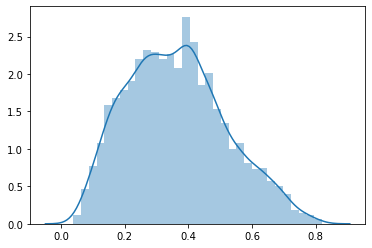

In [181]:
sns.distplot(y_predict)
plt.show()

In [173]:
roc_auc_score(target_test,y_predict)

0.6464179114678278

In [174]:
s = pd.Series(y_predict)

In [175]:
s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.07)]

0.619183174530777

In [164]:
int(y_predict.shape[0] *0.05)

282

In [165]:
y_predict.max()

0.8223315108724027

In [176]:
list(map(lambda x:1 if x>=s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.07)] else 0,y_predict)).count(1)

396

In [48]:
y_predict.shape

(5656,)

In [49]:
target_test.shape

(5656,)

In [177]:
target_test.sum()

642

In [182]:
y_predict = list(map(lambda x:1 if x>=s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.07)] else 0,y_predict))

In [183]:
print(classification_report(target_test, y_predict))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5014
           1       0.23      0.14      0.18       642

    accuracy                           0.85      5656
   macro avg       0.57      0.54      0.55      5656
weighted avg       0.82      0.85      0.83      5656



<Figure size 864x432 with 0 Axes>

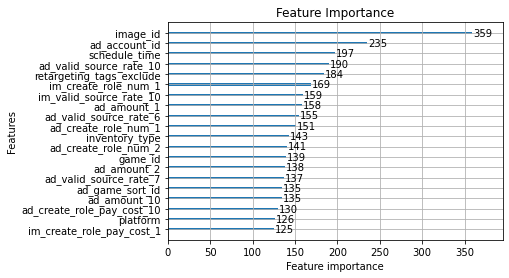

In [184]:
plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_b, max_num_features=20)
plt.title('Feature Importance')
plt.show()

In [694]:
test_data.head()

ad_account_id  game_id  smart_bid_type  hide_if_exists  delivery_range  \
887            230        0               1               0               0   
888            230        0               1               0               0   
889            230        0               1               0               0   
890            230        0               1               0               0   
891            230        0               1               0               0   

     adjust_cpa  inventory_type  hide_if_converted  flow_control_mode  \
887         NaN              41                  5                  1   
888         NaN              19                  5                  1   
889         NaN              15                  5                  1   
890         NaN              15                  5                  1   
891         NaN              15                  5                  1   

     schedule_time  auto_extend_enabled  gender  city  platform  launch_price  \
887            340                    0       0   551         0             0   
888            340                    0       0   551         0             0   
889            340                    0       0   551         0             0   
890            340                    0       0   551         0             0   
891            340                    0       0   551         0             0   

     retargeting_tags_exclude  interest_categories  ac  android_osv  \
887                      1683                 1136  12            9   
888                      1683                 1136  12            9   
889                      1683                 1136  12            9   
890                      1683                 1136  12            9   
891                      1683                 1136  12            9   

     location_type  retargeting_tags_include  retargeting_type  ios_osv  \
887              1                      3474                 0       11   
888              1                      3474                 0       11   
889              1                      3474                 0       11   
890              1                      3474                 0       11   
891              1                      3474                 0       11   

     interest_action_mode  age  action_categories  action_days  action_scene  \
887                     0   34                541            2             4   
888                     0   34                541            2             4   
889                     0   34                541            2             4   
890                     0   34                541            2             4   
891                     0   34                541            2             4   

     image_id  label_ids  label  im_amount_1  im_create_role_num_1  \
887      1209          1      0     71826.85                1352.0   
888      1209          1      0     71826.85                1352.0   
889      1166         13      0     15774.29                 227.0   
890      1275         13      0     76443.96                1548.0   
891      1301         50      0      1779.73                   9.0   

     im_new_role_money_1  im_pay_role_user_num_1  im_source_num_1  \
887               2352.0                    21.0             20.0   
888               2352.0                    21.0             20.0   
889                242.0                     5.0             12.0   
890               4204.0                    23.0             26.0   
891                  0.0                     0.0              2.0   

     im_valid_source_num_1  im_pay_rate_1  im_create_role_cost_1  \
887                   10.0         0.0155              53.126368   
888                   10.0         0.0155              53.126368   
889                    3.0         0.0220              69.490264   
890                    9.0         0.0149              49.382403   
891                    0.0         0.0000             197.747778   

